# North Macedonian 2024 Election Fact Checking Pipeline
---
This notebook is part of the North Macedonian 2024 Election Misinformation Assessment project. It contains code to analyze and visualize misinformation related to the elections in North Macedonia.

##### Libraries

In [88]:
from dotenv import load_dotenv
import requests
import json
from urllib.parse import quote_plus
import tqdm
import json
import os
import csv
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns


##### Constants

In [5]:
load_dotenv()
llama3_url = "http://localhost:11434/api/generate"
google_api = os.getenv("GOOGLE-API-KEY")
cx = os.getenv("CX")

dataset = "Dataset/VMRO-DPMNE_ad_creative_bodies.csv"
party = "VMRO-DPMNE"

## Data Collection

In [7]:
pandas_df = pd.read_csv(dataset)
print(pandas_df.head())

      ad_archive_id                                 ad_creative_bodies
0   427480589881211  Para disa ditëve në emisionin “Politiko” e kam...
1  1636678057070325  Промените се во твои раце!\nМакедонија повторн...
2   252100357930225                        За многу години Цветници!!!
3  1117244869521215  ✒️Shkruan: @[100005900348509:2048:Enis Shaqiri...
4  1595858924569626  ИЗГУБЕНА Е ДОВЕРБАТА ВО ПОЛИТИЧАРИТЕ БИДЕЈЌИ Н...


In [6]:
parties = ["DUI", "SDSM", "Left", "VMRO-DPMNE"]
parties_csv_name = ["DUI.csv", "meta-ad-library-2025-04-30_2-SDSM.csv", "meta-ad-library-2025-04-30_3-Левица.csv", "meta-ad-library-2025-04-30-VMRO-DPMNE.csv"]
parties_csv_name_dict = {
    "DUI": "DUI.csv",
    "SDSM": "meta-ad-library-2025-04-30_2-SDSM.csv",
    "Left": "meta-ad-library-2025-04-30_3-Левица.csv",
    "VMRO-DPMNE": "meta-ad-library-2025-04-30-VMRO-DPMNE.csv"
}

## Data Preprocessing

### Extract Claims

In [24]:

def extract_claims(text, id, iteration):
    promptQuestion= """For the bellow text, extract at max 3 claims and give to me in the JSON format. The claims should in English Language. You should only return the json. Do not add any other text. The JSON should only have 1 key "Claims" and the value should be a list of claims."""
    
    extract_claim_payload = {
    "model": "llama3",
    "prompt": promptQuestion + text,
    }
    
    extract_claim_response = requests.post(llama3_url, json=extract_claim_payload)
    
    if extract_claim_response.status_code == 200:
        lines = extract_claim_response.text.splitlines()
        output = ""
        for line in lines:
            try:
                # Parse each line as JSON
                line_data = json.loads(line)
                # Concatenate the "response" field
                output += line_data.get("response", "")
            except json.JSONDecodeError:
                # Skip lines that are not valid JSON
                continue
        # Parse the final concatenated output as JSON
        try:
            final_output = json.loads(output)
            
            print("Extracted Claims: Iteration:", iteration, "ID:", id, "Claims:", final_output)
            return final_output
        except json.JSONDecodeError:
            # Add a } to the end of the output
            output += "}"
            try:
                final_output = json.loads(output)
                print("Extracted Claims: Iteration:", iteration, "ID:", id, "Claims:", final_output)
                return final_output
            except json.JSONDecodeError:
                print("\n")
                print("Final output is not valid JSON: Iteration:", iteration, "ID:", id, "Output:", output)
                print("\n")
                return None
    else:
        print(f"Error: {extract_claim_response.status_code}")
        print(extract_claim_response.text)

In [19]:
ids_to_claims = {}
read_csv_path_bodies = "./dataset/ad-creative-bodies-extraction/"

for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_csv_path_bodies, party)
    csv_file_path = csv_file_path + "_ad_creative_bodies.csv"
    # Add "ad_creative_bodies" in front of the file name
    # csv_file_path = csv_file_path.replace(".csv", "_ad_creative_bodies.csv")
    print(csv_file_path)
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Iterate through the rows of the DataFrame


# for index, row in tqdm.tqdm(pandas_df.iterrows(), total=pandas_df.shape[0]):
#     # Extract the text from the DataFrame
#     text = row['ad_creative_bodies']
#     id = row['ad_archive_id']
#     # Extract claims from the text
#     claims = extract_claims(text)
#     # Store the claims in the dictionary
#     ids_to_claims[id] = claims
    
# # Check if the folder and file exist
# if not os.path.exists("./PreprocessedDataset/"):
#     os.makedirs("./PreprocessedDataset/")
    

# # Save the claims to a CSV file
# with open("./PreprocessedDataset/" + party + "_claims.csv", "w", newline='', encoding='utf-8') as csvfile:
#     fieldnames = ['ad_archive_id', 'claims']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for id, claims in ids_to_claims.items():
#         writer.writerow({'ad_archive_id': id, 'claims': json.dumps(claims)})

./dataset/ad-creative-bodies-extraction/DUI_ad_creative_bodies.csv
Shape of DUI DataFrame: (102, 2)
./dataset/ad-creative-bodies-extraction/SDSM_ad_creative_bodies.csv
Shape of SDSM DataFrame: (60, 2)
./dataset/ad-creative-bodies-extraction/Left_ad_creative_bodies.csv
Shape of Left DataFrame: (86, 2)
./dataset/ad-creative-bodies-extraction/VMRO-DPMNE_ad_creative_bodies.csv
Shape of VMRO-DPMNE DataFrame: (28, 2)
./dataset/ad-creative-bodies-extraction/ZNAM_ad_creative_bodies.csv
Shape of ZNAM DataFrame: (1, 2)


In [26]:
save_folder_path = "./dataset/claims-extraction/"

# Extract the Claims through LLM
for party in tqdm.tqdm(parties):
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_csv_path_bodies, party)
    csv_file_path = csv_file_path + "_ad_creative_bodies.csv"
    # Add "ad_creative_bodies" in front of the file name
    # csv_file_path = csv_file_path.replace(".csv", "_ad_creative_bodies.csv")
    print(csv_file_path)
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    iteration = 1
    # Iterate through the rows of the DataFrame
    for index, row in pandas_df.iterrows():
        # Extract the text from the DataFrame
        text = row['ad_creative_bodies']
        text = str(text)
        
        id = row['ad_archive_id']
        id = str(id)
        
        # Extract claims from the text
        claims = extract_claims(text, id, iteration)
        # Store the claims in the dictionary
        ids_to_claims[id] = claims
        iteration += 1
    # Save the claims to a CSV file
    with open(os.path.join(save_folder_path, party + "_claims.csv"), "w", newline='', encoding='utf-8') as csvfile:
        fieldnames = ['ad_archive_id', 'claims']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for id, claims in ids_to_claims.items():
            writer.writerow({'ad_archive_id': id, 'claims': json.dumps(claims)})
    ids_to_claims = {}
    

  0%|          | 0/5 [00:00<?, ?it/s]

./dataset/ad-creative-bodies-extraction/DUI_ad_creative_bodies.csv
Shape of DUI DataFrame: (102, 2)
Extracted Claims: Iteration: 1 ID: 6795509300551996 Claims: {'Claims': ['DUI will go into opposition', 'DUI will respond to crime and corruption']}
Extracted Claims: Iteration: 2 ID: 746708557578780 Claims: {'Claims': ['Three platforms are available for the upcoming parliamentary elections: Tirana platform, Sofia platform, and Macedonian platform.', 'The left will coalition with a government that accepts red lines in defending the Macedonian state.', 'Macedonians will put an end to the dictatorships and defeats of the SDS and DUI regime and restore the Republic.']}
Extracted Claims: Iteration: 3 ID: 464195942757638 Claims: {'Claims': ['The movement ZNAK for Our Macedonia is clear in its stance that it is against the opening of mines in Strumica.', "It should not be allowed to trade with people's health.", 'There needs to be an investigation whether DUI functionaries traded influence.']}


 20%|██        | 1/5 [02:33<10:13, 153.27s/it]

Extracted Claims: Iteration: 102 ID: 1585098798694924 Claims: {'Claims': ['Demokrati claims that the calculations of narco-bands indicate a brutal election.', 'Different political parties and their governing bodies over the past three decades have created and nurtured dangerous criminal bands which now take revenge on their own.', 'The spiral of violence must be stopped because it is consuming us.']}
./dataset/ad-creative-bodies-extraction/SDSM_ad_creative_bodies.csv
Shape of SDSM DataFrame: (60, 2)
Extracted Claims: Iteration: 1 ID: 988735132879405 Claims: {'Claims': ['There is no giving up on destiny', 'SDSM', 'Aerodrome', 'Macedonia']}
Extracted Claims: Iteration: 2 ID: 1138731707263665 Claims: {'Claims': ['SVM is the only party prepared to fight for citizens and the future of the state.', 'We are united and strong, we have endured time and weather, good and bad, and always been on the guard of the homeland.', "It's not an option for us to give up. We're a party made of solid materi

 40%|████      | 2/5 [03:57<05:38, 112.81s/it]

Extracted Claims: Iteration: 60 ID: 1129870555027804 Claims: [{'Claims': ['The SDSM spreads democratic voices through its activists, while the opposition uses bots to disinform', 'The digital battle of these elections will be won by SDSM and the democratic block because the voice and stance of people fighting for social justice and equality is stronger and more powerful than secret underground structures of nationalism', 'SDSM is expanding its digital action, through continuous joining new and dedicated supporters of the social-democratic cause']}]
./dataset/ad-creative-bodies-extraction/Left_ad_creative_bodies.csv
Shape of Left DataFrame: (86, 2)
Extracted Claims: Iteration: 1 ID: 1501205007127687 Claims: {'Claims': ['Macedonian people will win the platform', 'The government should prioritize red lines in defense of the Macedonian state', 'The regime of SDS and DUI has been dictatorial and needs to be ended']}
Extracted Claims: Iteration: 2 ID: 7394298730619070 Claims: [{'Claims': ["L

 60%|██████    | 3/5 [05:56<03:51, 115.70s/it]

Extracted Claims: Iteration: 86 ID: 3593778017563269 Claims: ['NGOs are pijavici (scammers) who circulate public funds to spread Western propaganda', 'The City of Skopje, specifically the Sector for International Cooperation, should have a special program for cooperation with NGOs and foundations', 'It is not enough that NGOs are involved in the implementation of every program and activity of the City of Skopje']
./dataset/ad-creative-bodies-extraction/VMRO-DPMNE_ad_creative_bodies.csv
Shape of VMRO-DPMNE DataFrame: (28, 2)
Extracted Claims: Iteration: 1 ID: 427480589881211 Claims: {'Claims': ['The anti-Albanian quarters have a tendency to abolish amnesty and obscure the fight for freedom and justice of UÇK.', "Gordana Siljanovska's words confirmed that VMRO-DPMNE's political battle is to subjugate Albanians, not continue the partnership built since 2001", "EU Front should gain more than 22 mandates and 'Siljanovskas' should remain only a memory"]}
Extracted Claims: Iteration: 2 ID: 16

 80%|████████  | 4/5 [06:31<01:23, 83.55s/it] 

Extracted Claims: Iteration: 28 ID: 369290982662369 Claims: [{'Claims': ['President Stevo Pendarovski will run for a second term with support from LSDM.', 'Gordana Siljanovska Davkova, a deputy from VMRO-DPMNE, will also run again after five years.', 'Arben Taravari has been officially promoted as a presidential candidate by the VLEN coalition.']}]
./dataset/ad-creative-bodies-extraction/ZNAM_ad_creative_bodies.csv
Shape of ZNAM DataFrame: (1, 2)


100%|██████████| 5/5 [06:32<00:00, 78.47s/it]



Final output is not valid JSON: Iteration: 1 ID: 7582091031857061 Output: [
"Claims": [
"What attributes should the next President of North Macedonia possess?",
"The candidates have started to offer a wide range of promises and slogans, all with the aim of attracting voters.",
"There is no concrete answer as to what these candidates are offering."
]
]}




In [104]:
# Remove the columns which have none in the claims
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(save_folder_path, party + "_claims.csv")
    pandas_df = pd.read_csv(csv_file_path)
    print("Before removing the columns for the Party " + party + " the shape is: ", pandas_df.shape)
    
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Remove the rows where claims are None
    pandas_df = pandas_df[pandas_df['claims'].notna()]

    print("After removing the columns for the Party " + party + " the shape is: ", pandas_df.shape)
    print("\n")
    
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)

Before removing the columns for the Party DUI the shape is:  (148, 2)
After removing the columns for the Party DUI the shape is:  (135, 2)


Before removing the columns for the Party SDSM the shape is:  (60, 2)
After removing the columns for the Party SDSM the shape is:  (58, 2)


Before removing the columns for the Party Left the shape is:  (86, 2)
After removing the columns for the Party Left the shape is:  (82, 2)


Before removing the columns for the Party VMRO-DPMNE the shape is:  (28, 2)
After removing the columns for the Party VMRO-DPMNE the shape is:  (26, 2)


Before removing the columns for the Party ZNAM the shape is:  (1, 2)
After removing the columns for the Party ZNAM the shape is:  (0, 2)




### Claim to Questions

In [36]:
def claim_to_question(claim):
    prompt_question = f""" For the bellow claim generate me 3 neural fact-checking questions and give to me in the format of a json. You should only return the json. The json should have only 1 key `Questions` and the value should be a list of questions.
    Claim: "{claim}"""
    
    extract_claim_payload = {
    "model": "llama3",
    "prompt": prompt_question + text,
    }
    
    question_response = requests.post(llama3_url, json=extract_claim_payload, timeout=30)
    
    if question_response.status_code == 200:
        # Process the streamed response
        lines = question_response.text.splitlines()
        output = ""

        for line in lines:
            try:
                # Parse each line as JSON
                line_data = json.loads(line)
                # Concatenate the "response" field
                output += line_data.get("response", "")
            except json.JSONDecodeError:
                # Skip lines that are not valid JSON
                continue

        # Parse the final concatenated output as JSON
        try:
            final_output = json.loads(output)
            return final_output
        except json.JSONDecodeError:
            # Add a } to the end of the output
            output += "}"
            try:
                final_output = json.loads(output)
                return final_output
            except json.JSONDecodeError:
                return None
    else:
        print(f"Error: {question_response.status_code}")
        print(question_response.text)

In [105]:
# Open the Claims and read everything once to make sure that the json is properly formated
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df = pd.read_csv(csv_file_path)
    print(pandas_df.head())
    
    
    # # Iterate through the rows of the DataFrame
    # for index, row in pandas_df.iterrows():
    #     # Extract the text from the DataFrame
    #     claims = row['claims']
    #     claims = json.loads(claims)
    #     print(claims)
    
    # Iterate through the claims. If the claim is found which is an array, add it to the dictionary
    for index, row in pandas_df.iterrows():
        # Extract the text from the DataFrame

        try:
            claims = row['claims']
            claims = json.loads(claims)
            c = claims["Claims"]
        except TypeError:
            
            if len(claims) == 1:
                print("Array Error")
                # Update the dataframe
                pandas_df.at[index, 'claims'] = claims[0]
                print(pandas_df.at[index, 'claims'])
            
            else:
                
                # Add the claim to the dictionary
                print("No Claims field error")
                # Update the dataframe
                claims = {"Claims": claims}
                pandas_df.at[index, 'claims'] = claims

        
        
    
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)
    


      ad_archive_id                                             claims
0   988735132879405  {"Claims": ["\u041d\u0435\u043c\u0430\u041e\u0...
1  1138731707263665  {"Claims": ["SDSM is the only party ready to f...
2  1462600661315120  {"Claims": ["SOSM is the only party ready to f...
3  1168468637617703  {"Claims": ["It is not too late to change dire...
4  1366791877252741  {"Claims": ["We are striving for great support...
No Claims field error
Array Error
{'Claims': ['The public-private partnership agreement for the Smart Airport project worth 10.7 million euros was signed on March 25, 2024.', 'There is no mention of digitization of municipal administrative services in the agreement.', 'The agreement does not specify how it will stimulate innovation and startup businesses.']}
No Claims field error
No Claims field error
Array Error
{'Claims': ['The government led by SDSM has separated 700,000 denari for the citizens of Aerodrom municipality to work on technical documentation for buildin

In [111]:
# Read the Claims and each claim and if there is an error remove the row

for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df = pd.read_csv(csv_file_path)
    print("Shape Before Filtering: ", pandas_df.shape)
    
    # Iterate through the rows of the DataFrame
    for index, row in pandas_df.iterrows():
        # Extract the text from the DataFrame
        claims = row['claims']
        try:
            claims = json.loads(claims)
            c = claims["Claims"]
        except:
            # Remove the row from the DataFrame
            pandas_df = pandas_df.drop(index)
            print("Removed the row with index: ", index)
            continue
    
    print("Shape After Filtering: ", pandas_df.shape)
    
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)
    

Shape Before Filtering:  (135, 2)
Removed the row with index:  8
Removed the row with index:  10
Removed the row with index:  12
Removed the row with index:  28
Removed the row with index:  29
Removed the row with index:  30
Removed the row with index:  32
Removed the row with index:  46
Removed the row with index:  53
Removed the row with index:  54
Removed the row with index:  72
Removed the row with index:  77
Removed the row with index:  79
Removed the row with index:  92
Removed the row with index:  94
Removed the row with index:  97
Removed the row with index:  99
Removed the row with index:  105
Removed the row with index:  115
Removed the row with index:  123
Removed the row with index:  124
Removed the row with index:  125
Removed the row with index:  127
Shape After Filtering:  (112, 2)
Shape Before Filtering:  (58, 2)
Removed the row with index:  3
Removed the row with index:  12
Removed the row with index:  29
Removed the row with index:  33
Removed the row with index:  45


In [114]:
# Load the claims from the CSV file
# claims_df = pd.read_csv("./PreprocessedDataset/" + party + "_claims.csv")
# print(claims_df.head())

# ids_to_claims_to_questions = {}

# for index, row in tqdm.tqdm(claims_df.iterrows(), total=claims_df.shape[0]):
#     claims_to_questions = {}
#     # Extract the claims from the DataFrame
#     claims = json.loads(row['claims'])
#     id = row['ad_archive_id']
#     # Extract claims from the text
#     for claim in tqdm.tqdm(claims['Claims']):
#         questions = claim_to_question(claim)
#         # Store the claims in the dictionary
#         claims_to_questions[claim] = questions
#     # Store the claims in the dictionary
#     ids_to_claims_to_questions[id] = claims_to_questions
# # Check if the folder and file exist
# if not os.path.exists("./PreprocessedDataset/"):
#     os.makedirs("./PreprocessedDataset/")
# # Save the claims to a CSV file
# with open("./PreprocessedDataset/" + party + "_claims_to_questions.csv", "w", newline='', encoding='utf-8') as csvfile:
#     fieldnames = ['ad_archive_id', 'claims_to_questions']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for id, claims in ids_to_claims_to_questions.items():
#         writer.writerow({'ad_archive_id': id, 'claims_to_questions': json.dumps(claims)})

saved_questions_path = "./dataset/questions-extraction/"
for party in tqdm.tqdm(parties):
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(save_folder_path, party + "_claims_cleaned.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    id_claims_to_questions = {}
    
    # Iterate through the rows of the DataFrame
    iteration = 1
    for index, row in tqdm.tqdm(pandas_df.iterrows(), total=pandas_df.shape[0]):
        print("Iteration: ", iteration)
        iteration += 1
        claims_to_questions = {}
        # Extract the claims from the DataFrame
        claims = row['claims']
        try:
            claims = json.loads(claims)
            c = claims["Claims"]
            id = row['ad_archive_id']
            # Extract claims from the text
            print(claims)
            for claim in claims['Claims']:
                questions = claim_to_question(claim)
                # Store the claims in the dictionary
                claims_to_questions[claim] = questions
            # Store the claims in the dictionary
            id_claims_to_questions[id] = claims_to_questions
            print(claims_to_questions)
        except:
            # Remove the row from the DataFrame
            pandas_df = pandas_df.drop(index)
            print("Removed the row with index: ", index)
            continue
        
        

    
    # Save the claims to a CSV file
    with open(os.path.join(saved_questions_path, party + "_claims_to_questions.csv"), "w", newline='', encoding='utf-8') as csvfile:
        fieldnames = ['ad_archive_id', 'claims_to_questions']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for id, claims in id_claims_to_questions.items():
            writer.writerow({'ad_archive_id': id, 'claims_to_questions': json.dumps(claims)})
        

  0%|          | 0/5 [00:00<?, ?it/s]

Shape of DUI DataFrame: (112, 2)


Iteration:  1
{'Claims': ['НемаОткажуваќьOdИднината', 'The SDSM is...', 'Macedonia']}


{'НемаОткажуваќьOdИднината': {'Questions': ['What are the key attributes that the next President of North Macedonia should possess?', 'How do the presidential candidates differ in their promises and slogans?', 'What specific policies or initiatives do the seven aspirants for the presidency promise to implement if elected?']}, 'The SDSM is...': {'Questions': ['What is the SDSM?', 'What are the attributes that the next President of North Macedonia should possess?', 'What promises and slogans do the presidential candidates offer to attract voters?']}, 'Macedonia': {'Questions': ['What is the current situation regarding the presidential election in North Macedonia?', 'Are there any specific requirements for the next president of North Macedonia, as mentioned in the claim?', "Who are the seven candidates competing for the presidency in North Macedonia's election?"]}}
Iteration:  2
{'Claims': ['SDSM is the only party ready to fight for citizens and the future of the state.', 'The party has e

{'SDSM is the only party ready to fight for citizens and the future of the state.': {'Questions': ["Is the claim 'SDSM is the only party ready to fight for citizens and the future of the state' supported by factual evidence?", 'What specific attributes should the next President of North Macedonia possess, according to the author Enis Shaqiri?', 'What are the concrete offers made by the presidential candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The party has endured time and weather, good and bad, and has always been on guard for the homeland.': {'Questions': ['Is the party mentioned in the claim a political party?', 'What are the specific promises and slogans offered by the presidential candidates?', "What is the relevance of the phrase 'homeland' to the context of the presidential election?"]}, "It's not an option for us to give up; SDSM is a party made of solid material.": {'Questions': ['What is the context of the claim that SDSM is a party made of s

{'SOSM is the only party ready to fight for citizens and the future of the state.': {'Questions': ['Is the claim that SOSM is the only party ready to fight for citizens and the future of the state supported by any evidence or credible sources?', 'What are the specific promises or slogans being offered by the presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Are there any notable differences in the policies or agendas being presented by the seven aspirants vying for the presidency?']}, 'We are united and strong, we have endured time and weather, good and bad, and always been on the barricades of the homeland.': {'Questions': ["What does the claim mean by 'the barricades of the homeland'? Is it referring to a specific location or situation?", "How do the presidential candidates' promises and slogans differ from one another?", 'What are the specific qualifications or attributes that the next President of North Macedonia should have, according to the

{'It is not too late to change direction.': {'Questions': ["Why is it 'not too late to change direction'?", 'What specific attributes should the next President of North Macedonia possess, according to the author?', 'What are the main promises and slogans offered by the seven presidential candidates in the upcoming election?']}, 'SDSM is the only party ready to fight for citizens and the future of the state.': {'Questions': ['Is SDSM the only party that has taken a stance on fighting for citizens and the future of North Macedonia?', 'What are the key qualifications required for the next President of North Macedonia, according to the claim?', "Do the candidates vying for the presidency in North Macedonia have concrete plans or proposals for the country's future?"]}, 'We will not give up our future, we will unite and be strong.': {'Questions': ["What is the meaning of 'We will not give up our future'?", 'What are the key attributes that a presidential candidate should possess to lead Nort

{'We are striving for great support from our strategic partners and friends on our path to full membership in the EU.': {'Questions': ["Why does the claim mention 'strategic partners and friends' in relation to EU membership?", 'What is the main dilemma facing the upcoming presidential election in North Macedonia?', 'What specific promises or slogans are being offered by the candidates in the ongoing presidential election?']}, 'The only ones who have leadership ambitions and knowledge to lead the country along the European path are SDSM, the Alliance for European Identity, and President Stevo Pendarovski': {'Questions': ['Does the claim suggest that SDSM and Alliance for European Identity are the only parties with leadership ambitions and knowledge to lead the country along the European path?', 'Is it implied that President Stevo Pendarovski has the necessary qualifications or attributes to be a leader in the future?', 'Are there any specific promises or slogans offered by the candidat

{'Only SDSM and the Alliance for European Perspective, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country on the European path.': {'Questions': ['What are the specific leadership qualities that a future President of North Macedonia should possess?', 'How do the candidates running for the presidency differ in their campaign promises and slogans?', 'What are the key issues or challenges that the next president of North Macedonia will face, and how do the current candidates plan to address them?']}, 'We are confident to step forward on the path of European integrations with clear and unequivocal support.': {'Questions': ["What is the context of the statement 'We are confident to step forward on the path of European integrations with clear and unequivocal support.'?", 'In what specific aspects do the presidential candidates differ from each other?', 'Who are the seven aspirants vying for the position of President, mentioned in the article

{"We're aiming for major support from our strategic partners and friends on our path to full EU membership.": {'Questions': ['What is the specific goal mentioned in the claim about seeking support from strategic partners?', 'Who are the candidates competing for the presidency of North Macedonia, as mentioned in the article?', "What are the aspirants' main promises and slogans being offered to the electorate during the election campaign?"]}, 'Only SDSM and the Alliance for European Identity, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country along the European path.': {'Questions': ['Is the claim that only SDSM and the Alliance for European Identity, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country along the European path supported by evidence?', 'What are the specific promises and slogans offered by the presidential candidates?', 'Do the seven presidential aspirants mentioned in th

{'Election is between hope and hopelessness.': {'Questions': ['What is the claimed nature of the election between hope and hopelessness?', 'Who are the presidential candidates in the Macedonian North election, and what promises do they offer?', 'What specific attributes should the next President of North Macedonia possess according to the author?']}, 'We want every citizen of North Macedonia to stay and build their future here, in our country.': {'Questions': ["Why is the claim mentioning North Macedonia's citizens wanting to stay and build their future there?", 'What are the candidates promising to the electors during this presidential election campaign?', 'What specific qualities or attributes should the next president of North Macedonia possess, according to the dilemma mentioned in the claim?']}, "Let's not give up on the future and together let's fight for a better future for all.": {'Questions': ['What is the main focus of the statement?', 'Who are the candidates running for Pres

{'There is no backing down from the future!': {'Questions': ['What is the specific attribute that the next President of North Macedonia should possess?', 'What are the main promises and slogans being offered by presidential candidates?', 'When did the presidential election campaign officially start?']}, 'We are all united in our common goal, European orientation of our country': {'Questions': ['How many presidential candidates are running in the North Macedonia election?', 'What is the main goal that these candidates are striving for?', 'In what ways do these candidates differ from each other?']}, 'Together with SDSM, Coalition for European Orientation and our President Stevo Pendarovski to show that we are all united in our common goal': {'Questions': ['Is the claim stating that a coalition is formed to show unity in a common goal accurate?', 'Are there indeed multiple candidates running for the presidential election of North Macedonia, as mentioned in the article?', 'Do the provided 

{'Residents witnessed the appearance of large snakes in urban areas.': {'Questions': ['What evidence supports the claim that residents witnessed the appearance of large snakes in urban areas?', 'What is the specific issue being debated in the Macedonian presidential election campaign?', 'What are the main promises and slogans offered by the candidates in the Macedonian presidential election?']}, 'The presence of such large snake populations in urban areas poses a threat to our children who may come into contact with them while playing around buildings or at playgrounds.': {'Questions': ['What evidence supports the claim that large snake populations in urban areas pose a threat to children?', 'Do snake encounters in urban areas actually occur, and if so, what are the frequencies and contexts of these events?', 'Is there empirical research on the actual risks or consequences of snakes being present in urban playgrounds or buildings?']}, 'The dynamics of grass cutting on urban surfaces in

{'Thanks to Olaf Scholz for his great support towards SDSM': {'Questions': ['What is the relationship between Olaf Scholz and SDSM?', "What are the main promises or slogans being offered by the presidential candidates in North Macedonia's election?", 'What are the specific qualifications or attributes that a future President of North Macedonia should possess, according to Enis Shaqiri?']}, 'Voting for SDSM and the Coalition for European Identity means voting for the victory of European Macedonia': {'Questions': ['What is the relationship between voting for SDSM and the Coalition for European Identity and the victory of European Macedonia?', "Are there any specific promises or slogans being offered by the presidential candidates in North Macedonia's election?", 'What are the concrete offers made by the seven aspirants competing for the position of President of North Macedonia?']}}
Iteration:  12
{'Claims': ['The support to SDSM by Olaf Scholz is greatly appreciated', 'Voting for SDSM an

{'The support to SDSM by Olaf Scholz is greatly appreciated': {'Questions': ['What is the relationship between Olaf Scholz and SDSM?', 'In what ways are the presidential candidates in North Macedonia offering promises and slogans to attract voters?', 'When did the presidential election campaign in North Macedonia start, and how many candidates are running?']}, 'Voting for SDSM and the European Coalition means a vote for victory in European Macedonia': {'Questions': ['What is the relationship between voting for SDSM and the European Coalition and winning in European Macedonia?', 'What are the specific promises or slogans that candidates Biljana Vankovskë, Maksim Dimitrievski, and Stefçe Jakimovski are offering to voters?', 'Are there any notable differences between the seven presidential hopefuls vying for the position?']}}
Iteration:  13
{'Claims': ['Great thanks to @Olaf Scholz for his great support directed towards SDSM, Dimitar Kovachevski and our president Stevo Pendarovski.', 'Vot

{'Great thanks to @Olaf Scholz for his great support directed towards SDSM, Dimitar Kovachevski and our president Stevo Pendarovski.': {'Questions': ['What is the relationship between Olaf Scholz and SDSM?', "Who are the presidential candidates in North Macedonia's election, and what promises do they offer?", 'What attributes should a future president of North Macedonia possess, according to the article?']}, 'Voting for SDSM and the European Identity Coalition means voting for the victory of European Macedonia.': {'Questions': ['How does the claim relate to the European Identity Coalition?', "What is the significance of the mention of 'victory of European Macedonia' in the context of the presidential election?", 'What are the specific promises or slogans being offered by the candidates in the presidential election, and how do they align with the claim?']}}
Iteration:  14
{'Claims': ['Euro-Atlantic integration is necessary for preserving European values', 'The European Union provides a 

{'Euro-Atlantic integration is necessary for preserving European values': {'Questions': ['What is the relevance of Euro-Atlantic integration to preserving European values?', 'What is the main challenge faced by the presidential candidates in North Macedonia, and how do they propose to address it?', 'What are the key promises or slogans made by the seven presidential aspirants competing for the presidency in North Macedonia?']}, 'The European Union provides a framework for cooperation and stability in Europe': {'Questions': ['Is the European Union a regional organization that provides a framework for cooperation and stability in Europe?', 'What is the main issue dominating the North Macedonia presidential election campaign?', 'What are the key promises and slogans being offered by the seven candidates vying for the presidency?']}, 'A strong and united EU is crucial for maintaining peace and prosperity in the region': {'Questions': ['What is the relationship between the EU and the region

{'Macedonia deserves European identity!': {'Questions': ["Does the claim 'Macedonia deserves European identity' refer to a political party's stance on Macedonia's membership in the European Union?", 'What is the main focus of the presidential election in North Macedonia, according to the text?', 'Are there more than 5 candidates running for the position of President in North Macedonia?']}, 'Our children deserve European identity the most!': {'Questions': ['What is the main topic of discussion in the Macedonian presidential election?', 'What are the main candidates promising to voters during their campaigns?', 'Who are the seven aspirants running for the presidency of North Macedonia?']}, 'We guarantee average salary of 1,100 euros and minimum salary of 600 euros.': {'Questions': ['What is the average salary guarantee mentioned in the claim?', 'What is the minimum salary guarantee mentioned in the claim?', "Is there a connection between the claim's mention of salaries and the topic of t

{'We believe a leader like Stevo Pendarovski is needed, someone we can rely on and who stands side by side with every citizen.': {'Questions': ['What evidence supports the claim that Stevo Pendarovski is a leader who stands side by side with every citizen?', "How do the presidential candidates in North Macedonia's upcoming election differ in their promises and slogans?", 'What specific attributes or qualities should the next President of North Macedonia possess, according to the author?']}, 'Together we can reach secure solutions for each challenge.': {'Questions': ["What does the phrase 'secure solutions' refer to in the context of the presidential election?", 'What is the specific attribute that the next President of North Macedonia should possess, according to the claim?', 'What are the main differences between the candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski mentioned in the article?']}, "I'm voting for number 1️⃣ on April 24th.": {'Questions': ['What is

{'We showed true dedication and bravery on our path to EU membership': {'Questions': ['How is the topic of EU membership related to the claim?', 'What are the common promises and slogans being offered by the candidates in the presidential election?', 'Are there any specific concrete actions or policies being proposed by the candidates in the presidential election?']}, 'Our dream of a European identity remains and our goal is still the same': {'Questions': ["What is the meaning of 'a European identity' in the context of the claim?", 'Who are the candidates mentioned in the article, and what are their ages?', 'What is the start date of the presidential election campaign mentioned in the article?']}, 'We will never give up on the European path because we are committed to our strategic goal': {'Questions': ['What is the European path referred to in the claim?', 'What are the strategic goals mentioned in the claim?', 'What are the current presidential candidates and their parties in North M

{'The vote for #Stevos and the Coalition for European Identity is a vote for European Macedonia.': {'Questions': ['What is the connection between the vote for #Stevos and the Coalition for European Identity?', 'In what way do the candidates promise to address the issue of Macedonian identity?', 'What specific issues or promises are being offered by the seven presidential candidates in North Macedonia?']}, 'We have a vision and plan to bring Macedonia into the European Union, together with our President Stevo Pendasrovski.': {'Questions': ['Is there a current president named Stevo Pendasrovski?', "Are the presidential candidates in North Macedonia's election offering concrete plans and promises?", 'Do any of the current presidential candidates have experience or qualifications relevant to bringing Macedonia into the European Union?']}, "We are decisive, we have will, courage and knowledge to ensure Europe's destiny in the country, for all our citizens, past and future generations.": {'Q

{'Sіljanova is completely in the matrix of DPMNE and advises harm to Pendarovski and Kovachevski.': {'Questions': ['What is the evidence that Siljanova is completely in the matrix of DPMNE?', 'Is there any credible source that confirms Siljanova advises harm to Pendarovski and Kovachevski?', 'What are the specific promises and slogans offered by the presidential candidates, namely Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Lіchne dіskreditacії for those with a feminine gender, harm to intellectual capacities expressed by Sіljanova do not relate to a professor or a politician.': {'Questions': ["What is the relationship between Sіljanova's statement and a professor or politician?", 'In what ways do Lichne discreditation for those with a feminine gender harm intellectual capacities?', 'Are the presidential candidates in North Macedonia discussing specific policy promises rather than just slogans?']}, 'Panic from election defeat, lack of plan, vision is not justifi

{'The airport belongs to President Stevo Pendarovski': {'Questions': ['What is the relationship between President Stevo Pendarovski and the airport?', 'Who are the candidates running for president of North Macedonia, and what are their promises?', "What does it mean that 'kandidatët kanë filluar të ofrojnë një gamë të gjerë premtimesh'?"]}}
Iteration:  21
{'Claims': ['We need to continue on the European path, that is the only alternative for fundamental and positive changes in our country.', 'We have a clear vision for European integration of the state, for a state with a developed economy, better education, healthcare, and functional governance of law.', 'There is no giving up on European identity and building a better society for citizens.']}


{'We need to continue on the European path, that is the only alternative for fundamental and positive changes in our country.': {'Questions': ['Is the claim stating that a European path is the only alternative for fundamental and positive changes in the country supported by evidence?', "Are the presidential candidates' promises and slogans in North Macedonia primarily aimed at attracting voters, rather than making concrete policy commitments?", 'Do the seven presidential aspirants competing in the election (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski, etc.) have specific, concrete policies to offer, or are they focusing on general promises and slogans?']}, 'We have a clear vision for European integration of the state, for a state with a developed economy, better education, healthcare, and functional governance of law.': {'Questions': ['What is the specific vision for European integration of the state mentioned in the claim?', 'What are the key areas of development (econo

{'He has a clear vision for the European identity of the state': {'Questions': ['Is the European identity of the state explicitly mentioned in the claim?', 'What is the main issue discussed in the claim regarding the upcoming presidential election in North Macedonia?', 'Are the presidential candidates mentioned in the claim offering specific promises and slogans?']}, 'Strongly supports EU and NATO membership': {'Questions': ["What is the author's stance on EU and NATO membership?", 'What is the current election situation in North Macedonia?', 'What are the main promises and slogans offered by the presidential candidates?']}, 'Show what it means to be a true president for all citizens regardless of ethnic, religious or other affiliation': {'Questions': ['What does it mean to be a true president for all citizens regardless of ethnic, religious or other affiliation?', 'What attributes should the next President of North Macedonia possess?', 'What specific promises and slogans are being off

{'The vote for Stevo and the Coalition for European Identity is a vote for European Macedonia': {'Questions': ['What is the specific issue being addressed in the presidential election in North Macedonia?', 'Who are the candidates running for President in the North Macedonian election and what are their platforms?', 'Is there a clear distinction between the coalitions mentioned (Coalition for European Identity) and the other political entities participating in the election?']}, 'Together with our president Stevo Pendarovski, we have a vision and plan to bring Macedonia into the European Union': {'Questions': ["What is the current President's name?", 'Who are the candidates running for President in the Macedonian presidential election?', 'When did the presidential election campaign start?']}, "We are resolute, willing, courageous and knowledgeable in ensuring Europe's destiny for the country and all its citizens": {'Questions': ['What is the purpose of the presidential election in North 

{'Participating in the European integration process is the only way to bring positive changes and a better living standard in the country.': {'Questions': ['What evidence is there to support the claim that participating in European integration brings positive changes and a better living standard?', "How has the country's integration into Europe impacted its economic or social indicators?", 'What alternative paths have been proposed to achieve similar outcomes, and what are their estimated costs and benefits?']}, "The choice between progress and regression depends on the citizens' decision in upcoming elections.": {'Questions': ["Why do the citizens' decisions in upcoming elections depend on the choice between progress and regression?", 'What are the specific promises and slogans offered by presidential candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?', 'What is the main dilemma faced by the upcoming presidential election in North Macedonia?']}, 'SMSM has a spec

{'The current president Stoev Pendarovski is capable of being acquainted with the program material.': {'Questions': ['Does the current president Stoev Pendarovski have the capability to be acquainted with the program material?', 'What specific attributes should the next President of North Macedonia possess?', 'Are there any clear promises and slogans being offered by the presidential candidates in the election?']}, 'He has a positive energy and atmosphere, and a warm reception for the Vevcanian hosts who can recognize who truly cares about the people and the state.': None, 'Every family will be visited in the following period to acquaint them with the program.': {'Questions': ["Is the claim 'Every family will be visited in the following period to acquaint them with the program' supported by evidence?", 'What is the specific information that presidential candidates in North Macedonia are promising to voters?', 'Do the statements of presidential candidates in North Macedonia provide conc

{'For more information, follow us.': {'Questions': ['What is the main topic of the article?', 'Who are the candidates running for President of North Macedonia?', 'What is the date when the election campaign started?']}}
Iteration:  27
{'Claims': ['Nikola Gruëvski and Hristijan Mickoski use brutal methods to silence and intimidate journalists', 'The duo uses propaganda, media manipulation, and fake news to manipulate citizens', 'Voters can only prevent these tactics by voting for the Coalition for European Perspective and Stevo Pendarovski on April 24th and May 8th']}


{'Nikola Gruëvski and Hristijan Mickoski use brutal methods to silence and intimidate journalists': {'Questions': ['What is the relationship between Nikola Gruëvski and Hristijan Mickoski to journalists?', 'Are Nikola Gruëvski and Hristijan Mickoski using brutal methods to silence and intimidate journalists?', 'What specific promises are the presidential candidates in North Macedonia offering, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The duo uses propaganda, media manipulation, and fake news to manipulate citizens': {'Questions': ["What is the definition of 'propaganda' in the context of this claim?", "What evidence can be provided to support the claim that the duo uses 'media manipulation' and 'fake news'?", 'What criteria should a future President of North Macedonia possess, according to the dilema presented?']}, 'Voters can only prevent these tactics by voting for the Coalition for European Perspective and Stevo Pendarovski on April 24th and 

{"Macedonian President Stevo Pendarovski's program is more transparent.": {'Questions': ['What is the specific program or platform that Macedonian President Stevo Pendarovski has implemented to increase transparency?', 'How do the presidential candidates in the North Macedonia election differ in their approaches to transparency and accountability?', 'What are the key promises and slogans being made by the seven presidential aspirants vying for the office of President in the North Macedonia election?']}, 'My program showed better results in the 2019 elections.': {'Questions': ['What is the relevance of the 2019 elections to the claim about a program showing better results?', 'Are the mentioned candidates (Biljana Vankovskën, Maksim Dimitrievskin, and Stefçe Jakimovski) actual presidential candidates in the 2023 North Macedonia presidential election?', "What is the purpose of the quote '[@100005900348509:2048:Enis Shaqiri]' at the end of the text?"]}, 'My program is visible, while theirs

{'Stevо Pendarovski is our European president!': {'Questions': ['What is the current president of North Macedonia?', 'Who are the candidates competing for the presidency in North Macedonia?', 'Is Stevо Pendarovski actually the European president?']}, "Don't miss the big civic protest on Monday, April 8 at 20:00 in the park near the monument to Jane Sandanski.": {'Questions': ['How does the protest event description match the typical format of civic protests?', "What is the typical purpose of presidential candidates' promises and slogans in a democratic election?", "Can the statement 'Fushata zgjedhore ka filluar më 4 prill, me shtatë aspirantë në garë për postin e Presidentit' be verified as accurate?"]}, 'Vote for number 1 on April 24.': {'Questions': [{'Question': 'What is the date mentioned in the claim?'}, {'Question': 'Which presidential candidates are mentioned as being part of the election race?'}, {'Question': 'What is the topic that dominates the electoral arena according to t

{'A large civil march in Aerodrom': None, 'The event will take place on Monday, April 8th, 2024 at 8:00 PM': {'Questions': ['What is the exact date and time specified for the event?', 'Are there any specific requirements or attributes that the next President of North Macedonia should possess, as mentioned in the claim?', 'Is it true that seven candidates are competing for the presidential position, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "We'll see you!": {'Questions': ['What are the key attributes that the next President of North Macedonia should possess?', 'How do presidential candidates in North Macedonia typically campaign and what promises do they make to voters?', 'What is the current state of the presidential election campaign in North Macedonia, including the number of candidates and their backgrounds?']}}
Iteration:  31
{'Claims': ["Stevо Pendarovski's program was presented to the youth at the Aerodrom location", 'Citizens are invited to a

{"Stevо Pendarovski's program was presented to the youth at the Aerodrom location": {'Questions': ['What is the specific program presented by Stevо Pendarovski to the youth at Aerodrom location?', 'What are the requirements for a future President of North Macedonia?', 'What concrete promises do these candidates offer?']}, 'Citizens are invited to a large civic meeting on Monday, April 8th at 20:00 in the park by the monument of Jane Sandanski': {'Questions': ['What is the specific date and time mentioned in the claim for a civic meeting?', 'Who are the seven presidential candidates mentioned in the article?', 'What is the main dilemma facing the future President of North Macedonia, according to the article?']}, 'We do not give up on the future!': {'Questions': ["What is the context of the claim 'We do not give up on the future'?", "Who are the seven presidential candidates running for office in North Macedonia's presidential election?", 'What specific promises and slogans have the cand

{'For more information, follow us.': {'Questions': ['What is the claim saying about the upcoming presidential election in North Macedonia?', 'What is the main concern or dilemma mentioned in the claim regarding the presidential election?', 'What are the key promises or slogans being offered by the candidates in the presidential election, according to the claim?']}}
Iteration:  33
{'Claims': ['We will increase salaries and pensions', 'We will invest more and create better job opportunities', 'We will develop the economy to European standards']}


{'We will increase salaries and pensions': {'Questions': ['What is the current situation regarding salaries and pensions mentioned in the claim?', 'Are the presidential candidates offering a wide range of promises and slogans to attract voters?', 'What are the specific promises made by the seven aspirants competing for the presidency, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'We will invest more and create better job opportunities': {'Questions': ['What is the current job market situation in North Macedonia?', 'What are the key promises made by the presidential candidates in North Macedonia?', 'What is the significance of investing more and creating better job opportunities according to the claim?']}, 'We will develop the economy to European standards': {'Questions': ['What is the current state of the economy in North Macedonia?', 'Who are the seven presidential candidates competing in the election, and what are their main promises?', "What European 

{'Dashkovski is responsible for unknown voters and ensuring an electoral list.': {'Questions': ['What is the role of Dashkovski in the electoral process?', 'What are the key characteristics that a future President of North Macedonia should possess?', 'What are the main promises and slogans being offered by the presidential candidates?']}, 'The President of DIK cannot and should not participate in party activities, nor interfere with pre-election activities of any party.': {'Questions': ['Does the President of DIK have a constitutional obligation to participate in party activities?', 'Is it constitutionally or morally acceptable for the President of DIK to interfere with pre-election activities of any party?', 'What specific promises and slogans are the candidates offering, and how do they plan to achieve their goals?']}, 'This raises suspicion and questions the criminal act.': {'Questions': ['What specific criminal act is being referred to in the claim?', 'Do the presidential candidate

{'DPMNE failed to realize its electoral promises.': {'Questions': ['What specific promises did DPMNE make during the electoral campaign?', "How do the presidential candidates' platforms compare to their previous commitments?", "What are the key differences between the aspirants' election pledges and slogans?"]}, 'DPMNE has no plan for the future and cannot bring about any change.': {'Questions': ['What evidence supports the claim that DPMNE has no plan for the future and cannot bring about any change?', "How do the presidential candidates' promises and slogans align with the actual needs of North Macedonia's citizens?", "What specific policies or initiatives do the current presidential candidates offer to address the country's challenges?"]}, "Nothing from DPMNE's election promises was realized.": {'Questions': ["Was DPMNE's election campaign focused on specific promises rather than slogans?", 'What was the primary issue that defined the presidential election in North Macedonia?', "Wer

{'The municipality of Aerodrom finished 2023 with a realization of only 66% of planned tax revenues from the main Budget.': {'Questions': ['What percentage of planned tax revenues did the municipality of Aerodrom realize in 2023?', 'What is the main budget of the municipality of Aerodrom that the tax revenues are based on?', 'Is there any connection between the topic of tax revenues and the Macedonian presidential election mentioned in the passage?']}, "The municipality's revenue collection was extremely bad last year, which led to questions about the normal functioning of the municipality and the financing of regular obligations.": {'Questions': ["What is the exact statement about the municipality's revenue collection that led to questions about its normal functioning and financing?", 'In what ways did the presidential candidates promise to fulfill their obligations and attract voters?', 'Who are the 7 aspirants competing for the presidency and what are their respective parties?']}, '

{'DUI will go into opposition': {'Questions': [['Does the claim mention DUI as going into opposition?', 'true'], ['Is it mentioned that candidates have started offering promises and slogans to attract voters?', 'true'], ['Are there 7 presidential aspirants in the race, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?', 'true']]}, 'DUI will respond to crime and corruption': {'Questions': ["What is the primary focus of DUI's response to crime and corruption?", 'Who are the seven presidential candidates vying for the office in the current election?', 'What specific promises or slogans have the candidates offered to attract electoral support?']}}
Iteration:  38
{'Claims': ['Three platforms are available for the upcoming parliamentary elections: Tirana platform, Sofia platform, and Macedonian platform.', 'The left will coalition with a government that accepts red lines in defending the Macedonian state.', 'Macedonians will put an end to the dictatorships and defeats

{'Three platforms are available for the upcoming parliamentary elections: Tirana platform, Sofia platform, and Macedonian platform.': {'Questions': ['What platforms are available for the upcoming parliamentary elections?', 'Do presidential candidates in North Macedonia have to possess certain attributes?', 'Who are the 7 aspirants running for President of North Macedonia?']}, 'The left will coalition with a government that accepts red lines in defending the Macedonian state.': {'Questions': ["What does the claim mean by 'accepts red lines in defending the Macedonian state'?", 'What are the specific promises and slogans being offered by the presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Who is Enis Shaqiri, as mentioned in the article?']}, 'Macedonians will put an end to the dictatorships and defeats of the SDS and DUI regime and restore the Republic.': {'Questions': [['Does the claim imply that the current government in North Macedonia is a d

{'The movement ZNAK for Our Macedonia is clear in its stance that it is against the opening of mines in Strumica.': {'Questions': ['What evidence does ZNAK provide to support its stance against opening mines in Strumica?', 'Is the movement ZNAK explicitly stating that it opposes all mining activities in Macedonia, or is it only targeting specific types of mines?', 'Do the presidential candidates mentioned in the article have a clear policy proposal on how to address environmental concerns related to mining?']}, "It should not be allowed to trade with people's health.": {'Questions': ['What is the main topic of discussion in the paragraph?', 'Who are some of the candidates running for President of North Macedonia?', 'What is the author of the article?']}, 'There needs to be an investigation whether DUI functionaries traded influence.': {'Questions': ['What evidence is there that DUI functionaries traded influence?', 'Can you specify which presidential candidates have made promises and w

{"Do not waste your voice, the voice that will end with those who do not have a representative will end on Ali's account; Voting for the option that did not have enough votes for a representative on the 24th will be voting for a representative plus having DUI; Support VMRO-DPMNE for more representatives to save Macedonia!": {'Questions': ['What is the connection between voting for a non-represented option on the 24th and having DUI?', 'In what ways do the presidential candidates promise to represent the people of Macedonia?', 'How does this claim relate to the election process in North Macedonia?']}}
Iteration:  41
{'Claims': ['Macedonian platform will win the elections', 'Labor Party will form a coalition with a government that accepts red lines in defense of the Macedonian state', 'The people will put an end to the dictatorships and defeats of the SDS and DUI regime and restore the Republic']}


{'Macedonian platform will win the elections': None, 'Labor Party will form a coalition with a government that accepts red lines in defense of the Macedonian state': {'Questions': ["What is the definition of 'red lines' in the context of defense of the Macedonian state?", "How do the candidates' promises and slogans differ from one another, and what are their primary goals for winning the election?", 'Who are the seven aspirants running for President of North Macedonia, and what are their backgrounds and qualifications?']}, 'The people will put an end to the dictatorships and defeats of the SDS and DUI regime and restore the Republic': {'Questions': ['What is the SDS and DUI regime?', 'What are the main promises and slogans offered by the presidential candidates?', 'When did the election campaign for the North Macedonian presidency start?']}}
Iteration:  42
{'Claims': ['VMRO-DPMNE will seek a partner in the Albanian opposition', 'The party will share values and principles with parties 

{'VMRO-DPMNE will seek a partner in the Albanian opposition': {'Questions': ['Is VMRO-DPMNE seeking a partner in the Albanian opposition?', 'What are the specific promises and slogans that presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski offer to attract voters?', 'Do any of the seven aspirants running for President of North Macedonia have a clear answer to what attributes the next president should possess?']}, 'The party will share values and principles with parties that share similar views': {'Questions': ['What is the main issue that dominates the presidential election in North Macedonia?', 'How do the candidates plan to attract voters, and what promises are they making?', 'What specific policies or commitments have been announced by the seven presidential candidates?']}, 'DUI is for opposition and responsibility at the time': {'Questions': ['What is the purpose of DUI (Driving Under Influence)?', "Are presidential candidates in North Macedonia's

{"DUI's boycott plan needs every individual to discuss with all those who know them and everyone to go out and vote.": {'Questions': ['What is the specific requirement for the President-elect of North Macedonia?', 'What are the main promises and slogans being offered by the candidates in the presidential election?', 'What is the significance of the 4th April start date for the presidential election campaign?']}, 'It is not an option to stay at home on these elections!': {'Questions': ["What is the significance of 'It is not an option to stay at home on these elections!' in the context of the presidential election in North Macedonia?", 'What are the key issues or attributes that the next President of North Macedonia should possess, as mentioned in the dilema?', 'What is the purpose behind candidates offering a wide range of promises and slogans during the presidential election campaign?']}, 'The entire population must be involved in the election process.': {'Questions': ['What is the sp

{'Need the highest turnout in history of parliamentary and presidential elections!': {'Questions': ['What is the specific attribute that a future President of North Macedonia should possess?', 'What are the main promises and slogans being offered by the presidential candidates?', 'When did the presidential election campaign officially start in North Macedonia?']}, 'The scenario for DUI for boycotting presidential elections, NO SUCCESS': {'Questions': ['What is the required scenario for DUI to occur when boycotting presidential elections?', 'Who are the presidential candidates participating in the election, and what promises or slogans do they offer?', 'When did the presidential election campaign start, and how many candidates are running?']}, 'VMRO-DPMNE needs a clear mandate for a government that is not evaluated by anyone': {'Questions': ['What is the relationship between VMRO-DPMNE and a clear mandate for government?', "How do the presidential candidates' promises and slogans aim to

{'Without you being the Minister of Justice, the public would not know that you exist.': {'Questions': ["What is the main point made about the Minister of Justice's role in the public's perception?", "How do the candidates' promises and slogans relate to their goals for attracting voters?", 'What specific aspects or qualities are the presidential candidates offering as alternatives?']}, 'You are a minister of justice when trust in the judiciary is below 3%': {'Questions': ['What is the current level of trust in the judiciary?', 'What are the main promises and slogans being offered by presidential candidates?', 'When did the presidential election campaign start in North Macedonia?']}, "I am a puppet on Ali's strings": {'Questions': ['Is the claim mentioning Ali as referring to a specific person?', 'What is the main topic discussed in the passage, according to the author Enis Shaqiri?', "Are there any numbers or statistics mentioned in the passage regarding the candidates' ages?"]}}
Iter

{'The expressway Prilep-Gardsko is a symbol of the inability of SDS and DUI': {'Questions': ['What is the Prilep-Gardsko expressway?', 'Who are the candidates running for President of North Macedonia?', 'What specific promises or slogans have been made by the presidential candidates?']}, 'The future government of VMRO-DPMNE will completely rebuild the expressway Prilep-Gardsko': {'Questions': ['What is the current status of the expressway Prilep-Gardsko?', 'Who are the candidates running for the presidency in North Macedonia, and what promises have they made?', "Do the candidates' slogans and promises focus on attracting electoral support?"]}}
Iteration:  47
{'Claims': ['There is no difference from before.', 'They (SDS, DRPN and DUI) will continue to manipulate and steal money from the budget.', 'They (all parties) will continue to create closed election lists and rank candidates based on their willingness to steal for the party.']}


{'There is no difference from before.': {'Questions': ["Why is the claim stating 'There is no difference from before'?", 'What specific attributes should the next President of North Macedonia possess, according to the claim?', 'What are the promises and slogans offered by the presidential candidates in the election race?']}, 'They (SDS, DRPN and DUI) will continue to manipulate and steal money from the budget.': {'Questions': ['How does the claim define manipulation and stealing money from the budget?', 'What is the main concern expressed about the upcoming presidential election in North Macedonia?', 'What specific promises or slogans are being offered by the candidates in the presidential race?']}, 'They (all parties) will continue to create closed election lists and rank candidates based on their willingness to steal for the party.': {'Questions': ['What evidence is there that all parties will continue to create closed election lists and rank candidates based on their willingness to 

{'The DUI and VMRO-DPMNE coalition are referring to the conflict from 2001 year.': {'Questions': ['Is the conflict referred to by the DUI and VMRO-DPMNE coalition from 2001?', 'Are there specific promises or slogans offered by the presidential candidates?', 'What concrete proposals do these presidential candidates offer?']}, "The 'branitels' and 'utchki' are threatening each other, with insults turning into open threats and revenge reminding someone who won.": {'Questions': ["What is the relationship between 'branitels' and 'utchki', as described in the claim?", 'In what ways do the presidential candidates promise to attract voters, according to the text?', 'Who are the seven aspirants competing for the presidency of North Macedonia, as mentioned in the article?']}}
Iteration:  49
{'Claims': ['SDSM and DUI have corrupted the system and put their own interests above those of the public.', 'The current situation is a result of the betrayal of the ideals of committees and partisans by tho

{'SDSM and DUI have corrupted the system and put their own interests above those of the public.': {'Questions': ["What does the claim 'SDSM and DUI have corrupted the system and put their own interests above those of the public' refer to?", 'What is the main issue dominating the presidential election in North Macedonia, according to the article?', 'What concrete proposals do the seven aspirants for the presidency offer, as mentioned in the article?']}, 'The current situation is a result of the betrayal of the ideals of committees and partisans by those in power.': {'Questions': ['What is the specific issue with committees and partisans that led to the current situation?', 'How do the presidential candidates plan to achieve their campaign promises and slogans?', 'What are the concrete policies or actions offered by each of the 7 presidential aspirants, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "It's time to show that we won't be fooled, and that Ma

{'80 години од АСНОМ сме потчинети и целосно погазени од СДСМ и ДУИ кои се корумпирани': {'Questions': ['What is the relationship between ASNO and SDSM/DUI?', 'What are the promises and slogans offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', 'What does the writer Enis Shaqiri suggest should be possessed by the next President of North Macedonia?']}, 'As president, I will unite, moderate, coordinate and mediate to create a consensus at home and abroad, and protect national and state interests': {'Questions': ["What is the meaning of 'unite' in the context of presidential action?", 'How does the author believe that a president should behave to create consensus at home and abroad?', 'What specific promises do the candidates offer for the presidency?']}, 'Passivity will allow them to manipulate the elections and ruin our country, so we must be vigilant and defend it': {'Questions': ['What evidence is there that passivity will allow manipul

{'SDSM and DUI have corrupted the system for their own interests': {'Questions': ['Is the SDSM and DUI corruption claim supported by credible evidence?', "What specific attributes should a future president of North Macedonia possess to address the system's corruption?", 'Can a president from one party truly represent the interests of all citizens, given the complex political landscape in North Macedonia?']}, 'The current government is not protecting national and state interests, but only personal ones': {'Questions': ['Is the current government primarily focused on protecting personal interests rather than national and state ones?', 'What specific promises or slogans are the presidential candidates offering to attract voters?', 'What concrete actions are the presidential candidates proposing, including Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "It's time to show that we don't accept corruption and passivity, and that we want a free and democratic Macedonia": {'

{'Elections will be a chance to send a strong message that the people are the foundation of statehood': {'Questions': ['What is the main message that people want to send through elections?', 'What are the key promises and slogans being offered by presidential candidates in North Macedonia?', 'When did the presidential election campaign in North Macedonia start and how many aspirants are competing for the position?']}, 'As President, I will unite and coordinate efforts, promote public values, not personal ones, and appoint only the best individuals': {'Questions': ['What is the main goal that the President will focus on during their term?', 'Who are the seven presidential candidates vying for the position, and what are their key promises?', 'What specific qualities should a future president of North Macedonia possess, according to Enis Shaqiri?']}, "We must stand up for our country's future by choosing those who know how to establish right and justice, not just repeat empty words": {'Qu

{"ASNOМ's ideals were betrayed by SDSM and DUI who prioritized their own interests over the public's.": {'Questions': ["What is the specific issue that ASNOМ claims SDSM and DUI prioritized their own interests over the public's?", 'How do the presidential candidates plan to address the issues facing North Macedonia, according to the article?', 'What are some of the key promises or slogans that the presidential candidates are offering in order to attract voters, as mentioned in the article?']}, 'The current state of Macedonia cannot be tolerated without our consent, and passive consent can be exploited for electoral manipulation.': {'Questions': ['Is the current state of Macedonia being tolerated without consent?', 'What attributes should a future president of North Macedonia possess?', 'Can passive consent be exploited for electoral manipulation in Macedonian presidential elections?']}, 'Macedonia will only be great again if we choose leaders who truly care about its well-being and are

{"Ali Ahmeti's threats do not intimidate me.": {'Questions': ['What is the connection between Ali Ahmeti and the presidential election in North Macedonia?', 'Are there specific attributes that a future President of North Macedonia should possess, as mentioned in the article?', 'What are the main promises and slogans being offered by the presidential candidates in North Macedonia?']}, 'I will establish contact with Albanian opposition leaders immediately after the elections to work together for common principles.': {'Questions': ['What specific opposition leaders will the speaker establish contact with immediately after the elections?', "How does the speaker's promise to work with Albanian opposition leaders relate to the Macedonian presidential election?", 'What common principles is the speaker planning to work on with the Albanian opposition leaders?']}, 'DUI was transformed into a criminal organization that harms both Albanians and Macedonians.': {'Questions': ['What is the evidence 

{'We win in Novo Selo!': {'Questions': ['Is Novo Selo a location where a win has been claimed?', 'What are the key attributes that the next President of North Macedonia should possess?', 'What is the main challenge or dilemma facing the presidential candidates in the current election?']}, 'We will put an end to the rule of DUI and SDSM, we will put an end to crime and corruption in power, and we will make many beautiful projects in every municipality!': {'Questions': ['Is the claim mentioning specific candidates and parties (e.g. DUI, SDSM) accurate?', 'Do the mentioned candidates (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski) have a significant chance of winning the presidential election?', 'Does the claim accurately state that the election campaign has started on April 4th and features multiple candidates?']}}
Iteration:  56
{'Claims': ['Македонија требаше да биде еколошки рај во Европа, но реалноста е дека Македонија е на врвот на листата на градови со најголемо аероза

{'Македонија требаше да биде еколошки рај во Европа, но реалноста е дека Македонија е на врвот на листата на градови со најголемо аерозагадување.': {'Questions': ['Why is it claimed that North Macedonia was supposed to be an ecological paradise in Europe, but the reality is that it is actually ranked at the top of the list for most air pollution?', 'What are the key attributes required by the future President of North Macedonia?', 'What specific promises and slogans are being offered by the presidential candidates currently running in the election?']}, 'Триото СДСМ, ДУИ и ДОМ не ја задржа потребната одлучност низ годините за решавањето на еколошките проблеми.': {'Questions': ['What is the main topic discussed in the claim?', 'In what year did the election campaign start?', 'What are some of the key attributes that a future President of North Macedonia should possess?']}, 'Се тактизира со одредени ветувања или со тајмингот за нивна примена.': {'Questions': ['What are the specific electi

{'If we read the promises given in the previous election campaign, Macedonia should be an ecological paradise in Europe today. However, reality is that Macedonia is at the top of the list of cities with the highest air pollution, dumps are everywhere, and uncontrolled construction is happening even in protected areas.': {'Questions': ['What are the current environmental conditions in Macedonia?', 'How do the promises made during previous election campaigns align with the current state of environmental pollution in Macedonia?', 'What specific attributes should the next President of North Macedonia possess to address these environmental concerns?']}, 'The trio SDSM, DUI, and DOM, which energetically started solving environmental problems, did not maintain the necessary determination over the years, creating a perception that they are taking certain promises or setting deadlines for their implementation.': {'Questions': ['What is the specific environmental problem that SDSM, DUI, and DOM 

{'State has been stolen from the people by DUI and its accomplices SDS.': {'Questions': ["What is the context of the claim that 'State has been stolen from the people by DUI and its accomplices SDS'?", 'Are DUI and SDS political parties mentioned in the context of a presidential election?', "What does the sentence 'Kjo është dilema që dominon në arenën zgjedhore presidenciale' imply about the current state of affairs?"]}, 'The chance to return it to the people is on April 24, then May 8.': {'Questions': ["What is the exact date when 'the chance to return it to the people' is available?", 'When does the election campaign start?', 'What are the specific attributes that the next President of North Macedonia should possess?']}, 'We will make Macedonia again proud and yours!': {'Questions': ["What is the significance of 'making Macedonia again proud and yours' in the context of the presidential election?", 'What are the specific promises and slogans that the presidential candidates are offe

{'The people are prepared and united for changes': {'Questions': ['What is the current political situation in North Macedonia that makes the preparation and unity for changes a pressing issue?', 'What are the main promises and slogans being offered by the presidential candidates, and what are their intentions behind these offers?', 'Can you specify which concrete policies or attributes do the presidential candidates promise to bring, and how do they differ from each other?']}, 'Join VMRO-DPMNE to defeat this non-national and criminal government of SDS and DUI': {'Questions': ['What is the exact date when the presidential election campaign started?', 'Who are the seven presidential candidates, and what parties or organizations do they represent?', 'What specific promises or slogans have been made by these candidates to attract voters?']}}
Iteration:  60
{'Claims': ['In March, there is no change in the party that uses harmful narratives in communication the most.', 'The two largest parti

{'In March, there is no change in the party that uses harmful narratives in communication the most.': {'Questions': ['What is the exact date mentioned in the claim as starting the election campaign?', 'What are the names and parties of the 7 presidential candidates mentioned in the article?', 'Is there any specific narrative or issue discussed in the article that might be attributed to the next president of North Macedonia?']}, 'The two largest parties VMRO-DPMNE and SDSM still use harmful narratives, but now also includes Left.': {'Questions': ['What are the harmful narratives used by VMRO-DPMNE, SDSM, and Left parties?', 'What is the main issue dominating the Macedonian presidential election?', 'What specific promises do the presidential candidates offer to attract voters?']}, 'There is an increase in such reports at DUI compared to previous months.': {'Questions': ['What is the specific data or source that supports the increase in reports at DUI compared to previous months?', "How d

{'The two largest parties VМРО-DПМNЕ and СDSM are using harmful narratives in their communication.': {'Questions': ['What narratives are harmful according to the claim?', 'What is the main dilemma in the Macedonian presidential election according to the article?', 'What promises and slogans do the seven aspirants offer to attract electors?']}, 'DUI is showing an increase in such posts compared to previous months.': {'Questions': ['Is there an increase in DUI posts compared to previous months?', 'Are the presidential candidates offering a wide range of promises and slogans to attract voters?', 'Who are the seven presidential aspirants mentioned in the article?']}, 'There has been no change in March regarding which party uses the most harmful narratives in their communication.': {'Questions': [['Is the claim that there has been no change in March regarding which party uses the most harmful narratives in their communication supported by evidence from a credible source?'], ['Is the informa

{'On average, online media outlets broadcast at least two harmful narratives in a single piece.': {'Questions': ['What is the source for the claim that online media outlets broadcast at least two harmful narratives in a single piece?', 'Can you provide evidence to support the assertion that presidential candidates are offering a wide range of promises and slogans to attract voters?', 'What specific policies or initiatives do the seven presidential aspirants offer, as mentioned in the article?']}, 'The most common way for harmful narratives to spread is without any intervention.': {'Questions': ["Is the claim that 'harmful narratives spread without any intervention' supported by scientific evidence?", "Are the presidential candidates in North Macedonia's election primarily focused on promising and sloganizing to attract voters, rather than offering concrete policies?", "Do the candidates in North Macedonia's presidential election have a clear policy platform or are they simply campaigni

{'Achmeti opened the session and after verifying mandates, Zijadin Sela was elected as president of the Assembly.': {'Questions': ['Is the claim that Achmeti opened the session and after verifying mandates, Zijadin Sela was elected as president of the Assembly accurate?', 'Are the claims about the presidential election in North Macedonia made by Enis Shaqiri accurate?', 'Do the candidates running for President of North Macedonia have a concrete platform or are they just making promises?']}, 'The new parliamentary composition inaugurated the new head of state, Buja Osmani.': {'Questions': ['What is the new head of state mentioned in the claim?', 'What is the main dilemma dominating the electoral arena?', 'What is the purpose of the election slogans and promises made by the candidates?']}, 'There is no information about the first claim being related to an election.': {'Questions': ['What is the relationship between the first claim and an election?', 'Is it true that candidates have start

{'The person is the Secretary-General of the Democratic Union for Integration (BDI)': {'Questions': ['Is the person a candidate in the 2023 Macedonian presidential election?', 'What are the main promises and slogans offered by the candidates in the 2023 Macedonian presidential election?', "Are there any notable differences between the candidates' positions on specific issues in the 2023 Macedonian presidential election?"]}, 'The person holds a similar position at another organization (ДУИ)': {'Questions': ['What is the organization that the person holds a similar position at?', 'What are the key promises and slogans being offered by the candidates?', 'What is the current state of the presidential election campaign in North Macedonia?']}, 'The person serves as the general secretary in this context': {'Questions': ['What is the role of the general secretary in this context?', 'Who are the candidates running for president of North Macedonia and what promises do they offer?', 'What are the

{'Establishing order through these elections': {'Questions': ['What is the current political landscape in North Macedonia?', 'What are the key promises and slogans being offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', "Are there any significant differences between the candidates' platforms or policies that could influence voters' decisions?"]}, 'Everyone will be accountable for breaking the law, regardless of their political affiliation (SDSM, DUI, VMRO)': {'Questions': ['What is the main point made about accountability and political affiliation in the claim?', 'How does the author describe the current state of the presidential election campaign in North Macedonia?', 'What specific promises or slogans do the candidates offer to attract voters, according to the text?']}, 'Macedonia will be governed by laws equally for all': {'Questions': ['What is the main topic of discussion in the presidential election in Macedonia?', 'What are the k

{'Thank you to my magnificent Kiselova Voda!': {'Questions': ['What is the significance of Kiselova Voda mentioned in the claim?', 'What are the key attributes that a future President of North Macedonia should possess, as per the dilemma being discussed?', 'What are the main promises and slogans offered by the presidential candidates, according to the claim?']}, 'Thanks to each of you for strong support so far, every tight hand and sincere handshake.': {'Questions': [['What is the current date mentioned in the article?', '2023-04-04'], 'What are the three political parties mentioned in the article as having candidates running for president?', ['E Majta', 'ZNAM', 'GROM'], 'What is the occupation of Biljana Vankovski, one of the presidential candidates mentioned in the article?', 'Politician']}, 'Together with you, we will reach our goal - a free Macedonia, the motherland of all, liberated from the shackles of SDS/DSI.': {'Questions': ['What is the context of the claim about reaching a g

{"Pendarevski should answer citizens whether he accepts DUFI's ultimatum to elect a president in the Assembly?": {'Questions': ['What is the ultimatum that Pendarevski should answer to regarding the election of a president?', 'What are the key promises and slogans being offered by presidential candidates?', 'What are the main characteristics or requirements that the next President of North Macedonia should have?']}, "It is necessary to answer citizens whether Pendarevski accepts DUFI's ultimatum": {'Questions': ["What is the meaning of 'ultimatum' in the context of this claim?", 'Who are the candidates mentioned as running for the presidency of North Macedonia, and what are their ages?', 'What is the name of the news article or author that supports the information presented in this claim?']}, "The citizens must know if Pendarevski will accept DUFI's ultimatum": {'Questions': ["What is the significance of Pendarevski's potential acceptance of DUFI's ultimatum?", 'In what ways do the pre

{'They are planning to sell out the state': {'Questions': [{'question': 'Is the state being sold out?', 'type': 'bool'}, {'question': 'What specific attributes should the next President of North Macedonia have?', 'type': 'text'}, {'question': 'When did the election campaign start?', 'type': 'date'}]}, "They will negotiate with anti-Macedonian structures that don't think well of Macedonia": None, 'The people must stop them with a pen': {'Questions': ['What is the context of the presidential election in North Macedonia?', 'Who are the candidates running for president and what promises do they offer?', 'What specific attributes should the next President of North Macedonia possess?']}}
Iteration:  69
{'Claims': ['The mafia is cementing Đorče Petrov', 'IMER Selmani receives permission for two new high-rise buildings of 21 and 18 floors', "The city mayor has obtained apartments from VMRO-DPMNE's party lines, opposing DUI on the central level while collaborating with them locally to fully cem

{'The mafia is cementing Đorče Petrov': {'Questions': ["What is the claimant's relationship to Đorče Petrov?", 'Are the presidential candidates in North Macedonia offering a range of promises and slogans as part of their campaigns?', 'Who are the seven aspirants competing for the presidency in North Macedonia, according to the article?']}, 'IMER Selmani receives permission for two new high-rise buildings of 21 and 18 floors': {'Questions': ["What is the connection between IMER Selmani and the claim's topic?", 'How do the presidential candidates plan to achieve their promises, and what specific proposals do they offer?', "Is there any evidence that the presidential candidates are discussing or debating IMER Selmani's high-rise buildings in their campaigns?"]}, "The city mayor has obtained apartments from VMRO-DPMNE's party lines, opposing DUI on the central level while collaborating with them locally to fully cement Đorče Petrov": {'Questions': [["The city mayor has obtained apartments 

{'The mafia is cementing Gjorche Petrov': {'Questions': [['Is the mafia involved in the upcoming presidential election in North Macedonia?', "Evidence suggests that the mafia is not directly involved in the election, but rather it's a common term used to describe organized crime groups in the country.", 1], ['Are the candidates offering a wide range of promises and slogans during the campaign?', 'Yes, the candidates have started to offer various promises and slogans as part of their campaign efforts, aiming to attract voters.', 0.8], 'Are there seven aspirants running for the presidency of North Macedonia?', 'According to the text, yes, there are seven aspirants vying for the presidential position.', 0.9]}, 'The mayor has received permits for two new high-rise buildings with 21 and 18 floors': {'Questions': ["Is the mayor's permit for a 21-story high-rise building supported by verifiable evidence?", 'What specific promises or slogans have presidential candidates made during their campa

{'Hezbollah is the one that concrete-izes Gjorche Petrov.': {'Questions': ['What is the connection between Hezbollah and Gjorche Petrov?', "What are the main promises and slogans offered by presidential candidates in North Macedonia's election?", 'Who are the 7 aspirants competing for the presidency of North Macedonia, according to the article?']}, 'The mayor has received a permit for two new high-rise buildings of 21 and 18 floors.': {'Questions': ['What is the source of information about the mayor receiving a permit for two new high-rise buildings?', 'How accurate are the reported floor counts (21 and 18) of the proposed high-rise buildings?', 'Is there any evidence to support the claim that these buildings have been approved, or is this just a proposal?']}, 'The local government, together with VMRO-DPMNE, completely concrete-izes Gjorche Petrov.': {'Questions': ["What is the meaning of 'completely concrete-izes Gjorche Petrov'?", 'What are the main promises and slogans being offered

{"Politicians are frequently accused of 'foreign influence' from Serbia and Russia without any basis.": {'Questions': ["What evidence is presented to support the claim that politicians are frequently accused of 'foreign influence' from Serbia and Russia without basis?", 'Is there any credible information about the political candidates vying for the position of President of North Macedonia, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Are there any specific promises or slogans being offered by the presidential candidates to attract voters in the upcoming election?']}, "The presence of this harmful narrative is largely due to the accusations made by the DUI party, which has been running a pre-election campaign called 'DA for Europe, NO to Russia'.": {'Questions': ['How accurate is the claim that the presence of this harmful narrative is largely due to the accusations made by the DUI party?', 'What specific promises or slogans are being offered by the pr

{"Poltical actors are blaming 'foreign influence' on others, most often Serbia and Russia.": {'Questions': ["What is the evidence that political actors are blaming 'foreign influence' on others, specifically Serbia and Russia?", 'How do the presidential candidates in North Macedonia address concerns about foreign influence in their election campaigns?', 'Can you specify what concrete measures or initiatives each of the seven presidential candidates (Biljana Vankovska, Maksim Dimitrievski, Stefçe Jakimovski, etc.) is offering to address the issue of foreign influence?']}, "The presence of this harmful narrative is mainly due to the accusations by DUI, which has started a pre-election campaign called 'DA for Europe, NO for Russia'.": {'Questions': ['What is the pre-election campaign called that DUI started?', 'What are the main accusations made by DUI in this context?', 'In what specific aspects do the presidential candidates offer promises and slogans?']}, "The monitoring findings from 

{'These are the last chance for saving Macedonia': None, 'These elections will show DUI and SDS where their place is!': {'Questions': ['What is the exact date when the presidential election campaign in North Macedonia started?', 'Who are the seven presidential candidates mentioned in the article, and what are their respective parties?', 'What specific promises or slogans do the presidential candidates offer to attract voters?']}, 'Their large turnout at the elections': {'Questions': ['What is the significance of a large turnout at elections in North Macedonia?', 'What are the key promises and slogans being offered by presidential candidates in the election?', 'When did the presidential election campaign in North Macedonia start, and how many aspirants are running for the post?']}}
Iteration:  75
{'Claims': ['It is possible and necessary for radical changes!', 'We are in a fight against the blackness SDS-DPMNE-DUI, join us!', 'I am worthy of being President, I am Billjana Vankovska!']}


{'It is possible and necessary for radical changes!': {'Questions': ["What is the meaning of 'radical changes' in this context?", 'How do the presidential candidates plan to achieve their promises and slogans?', 'What specific qualities or attributes should the next President of North Macedonia possess, according to the author?']}, 'We are in a fight against the blackness SDS-DPMNE-DUI, join us!': {'Questions': [["What is the name of the political party being referred to as 'blackness'?"], ['When did the presidential election campaign in North Macedonia start?'], ['Who are the candidates running for President of North Macedonia, according to the article?']]}, 'I am worthy of being President, I am Billjana Vankovska!': {'Questions': ["What is Billjana Vankovska's background or qualifications that make her worthy of being President?", "How do the presidential candidates' promises and slogans differ from each other, and what are their key issues?", 'What specific policies or initiatives d

{'Populism, spreading panic, fear and uncertainty and encouraging extreme nationalism and patriotism': {'Questions': ["How is populism related to the claim that it 'spreads panic, fear and uncertainty'?", "What are the main promises and slogans being offered by presidential candidates in North Macedonia's election?", 'What specific qualities should the next President of North Macedonia possess according to the article?']}, 'Nudging, belittling and labeling political opponents': {'Questions': ["What is the claim referring to as 'nudging, belittling and labeling'?", 'Who are the candidates vying for the presidential election in North Macedonia?', 'What specific promises or slogans do these candidates offer to attract voters?']}, 'Measuring political harmful narratives': {'Questions': ['Is the current electoral campaign in North Macedonia characterized by a wide range of promises and slogans from various candidates?', 'Are there any specific attributes that the next President of North Mac

{'The Center for Investigative Journalism "SKUP – Macedonia" analyzed data from property lists of parliamentary party leaders in North Macedonia within the project "PEP"': {'Questions': ["How accurate is the statement that 'SKUP – Macedonia' analyzed data from property lists of parliamentary party leaders in North Macedonia?", "What was the purpose behind the 'PEP' project, and how does it relate to the presidential election in North Macedonia?", 'Can you confirm if there were indeed seven candidates running for the presidential position on April 4th?']}, 'The data was analyzed within the project "PEP"': {'Questions': ["Why is the data being analyzed within the project 'PEP'?", 'What are the key attributes that the next President of North Macedonia should possess, according to the text?', 'Who are the seven candidates running for the presidential post in the election mentioned in the text?']}, 'The team at SKUP Macedonia is responsible for the preparation': {'Questions': ['How does the

{'SRS and DUI have been looting and oppressing citizens for 7 years': {'Questions': ["Why is the claim that SRS and DUI have been 'looting and oppressing citizens for 7 years' considered true?", "What specific promises or slogans are being offered by presidential candidates in North Macedonia's electoral campaign?", 'What are the credentials of the seven aspirants vying for the presidency in North Macedonia, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "It's time for the state to return to the people, a vote for VMRO-DPMNE and Siljanovska Davkova is a vote for change and a proud Macedonia": {'Questions': ['What is the specific policy change that VMRO-DPMNE and Siljanovska Davkova are advocating for?', "How do the candidates' promises and slogans differ from one another?", 'What are the main issues or challenges that the presidential candidates are addressing in their campaigns?']}}
Iteration:  79
{'Claims': ['Levica will not coalition with criminal and 

{'Levica will not coalition with criminal and traitors': {'Questions': ['What is the main issue dominating the presidential election in North Macedonia?', 'What are the promises and slogans being offered by the candidates?', 'What are the specific qualities or attributes that a future President of North Macedonia should possess?']}, "Leposki, the leader of DPMNE, has explicitly announced a government with SDS, which is against Levica's stance": {'Questions': ["How does the leader of DPMNE's statement on forming a government with SDS align with Levica's stance?", 'What specific promises and slogans are being offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski to attract voters?', "Does Leposki's announcement imply a formal alliance between DPMNE and SDS, or is it more of a statement of intent?"]}, 'The main political opponents of Levica are Gruevski and Zaev, both in political retirement': {'Questions': ['What are the political affiliations o

{'Pensioners do not deserve to be ignored, belittled and left behind': {'Questions': ['What is the specific context in which pensioners are being ignored, belittled, and left behind?', "What is the purpose of the presidential candidates' promises and slogans during the election campaign?", 'What specific qualities or attributes should the next President of North Macedonia possess, according to the author?']}, 'VMRO-DPMNE will always care for pensioners, so it will also be after the double victory of presidential and parliamentary elections': {'Questions': ["Is the claim 'VMRO-DPMNE will always care for pensioners' a statement of fact about the party's past actions?", 'Does the claim imply that VMRO-DPMNE has a history of prioritizing pensioners, and if so, is this accurate?', 'What specific promises or policies have been made by the presidential candidates mentioned in the article?']}, 'Pensioners deserve a decent life!': {'Questions': ["What is the current situation regarding pensione

{'The most harmful narratives are created in the kitchens of political parties and their preferred channel for communication is party leaflets.': {'Questions': ['What is the most common medium for communication used by political parties?', "What are the main promises and slogans being offered by presidential candidates in North Macedonia's presidential election?", 'What are the key qualifications that a future President of North Macedonia should possess?']}, 'The two largest parties are creators of at least as many harmful narratives in the first two months of the year.': {'Questions': [{'Text': 'Do the two largest parties create at least as many harmful narratives in the first two months of the year?', 'Type': 'binary'}, {'Text': 'Are the presidential candidates offering a wide range of promises and slogans in their campaigns?', 'Type': 'binary'}, {'Text': 'Can you specify what concrete actions or policies the presidential candidates are promising in their campaigns?', 'Type': 'open-e

{'Highly placed criteria from the start of the campaign that SDSM-DUI cannot even approach together. The gap will only increase in favor of Gordana Siljanovska Davkova and coalition candidates Macedonia again yours!': {'Questions': ['Is it true that SDSM-DUI cannot approach the criteria from the start of the campaign?', 'What specific attributes should the next President of North Macedonia possess, as per the dilemmas dominating the electoral arena?', 'Do the candidates in the presidential election offer a wide range of promises and slogans to attract electors?']}, 'The difference will only grow in favor of Gordana Siljanovska Davkova and coalition candidates Macedonia again yours!': {'Questions': ['Is the current trend indicating that Gordana Siljanovska Davkova and coalition candidates will gain an advantage in the election?', 'Are there concrete promises made by the presidential candidates mentioned, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Wha

{'Socijalno Demokratska Unija i Demokratiska Unija - Ilinden are above the government': {'Questions': ['Is Socijalno Demokratska Unija i Demokratiska Unija - Ilinden indeed above the government?', 'What are the specific attributes that the next President of North Macedonia should possess, according to the claim?', 'Are the presidential candidates offering a wide range of promises and slogans in an effort to attract voters?']}, 'You are Macedonian again!': {'Questions': ['What is the current nationality of the speaker?', 'What are the main promises and slogans offered by presidential candidates in North Macedonia?', 'When did the presidential election campaign start in North Macedonia?']}, 'The country is yours again!': {'Questions': ["Is the country's presidential election taking place on April 4?", 'What are the specific promises and slogans offered by the candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Are there seven candidates vying for the presidency o

{'The biggest problem in Macedonia is corruption.': {'Questions': ['How does the claim that corruption is the biggest problem in Macedonia relate to the current presidential election?', 'What specific promises or slogans are the candidates offering to attract voters during this election?', 'Are there any other significant issues being addressed by the presidential candidates beyond just corruption?']}, 'The government is the most corrupt institution in Macedonia.': {'Questions': ['Is the government in Macedonia universally regarded as corrupt?', "Do any of the presidential candidates in North Macedonia's election offer concrete proposals and not just promises?", 'Are there significant differences between the political parties vying for the presidency in North Macedonia?']}, 'It is logical that the MPs who were elected by these lists are responsible for the corruption in Macedonia.': {'Questions': ['What is the logical connection between MPs elected from certain lists and corruption in 

{'Corruption in Macedonia is caused by the government.': {'Questions': ['What evidence is there that corruption in Macedonia is caused by the government?', 'Can you provide specific examples or data to support the claim that the government causes corruption in Macedonia?', 'How does the current political climate and election campaign influence your perception of corruption in Macedonia?']}, 'The politicians and their appointees are the most corrupt individuals in Macedonia.': {'Questions': ['Why does the claim specify that politicians and their appointees are the most corrupt individuals in Macedonia?', "How do the candidates' promises and slogans compare to each other, and what impact might this have on voter choice?", "What specific attributes or qualities should the next President of North Macedonia possess, according to Enis Shaqiri's opinion?"]}, 'The current electoral law with closed lists is the main reason for corruption in Macedonia.': {'Questions': ['Is the current electoral 

{'Corruption stems from the authority and the government is the most corrupt.': {'Questions': ["Is the claim 'Corruption stems from authority and government is the most corrupt' supported by evidence?", 'Do presidential candidates in Macedonia offer a wide range of promises to attract voters?', 'What specific proposals do the seven presidential candidates offer, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The same people who are responsible for corruption in Macedonia are those who were and are still the most corrupt in the country.': {'Questions': ['What is the source of corruption in Macedonia?', 'How do the presidential candidates propose to address corruption?', 'What specific promises have the presidential candidates made regarding combating corruption?']}, 'Criminal and corrupt electoral law with closed lists is the main reason for corruption in Macedonia, which allows leaders to corrupt parliamentarians and officials.': {'Questions': ['What is t

{'Silaite partii ne baraaat nikoga da bidet so niv, no gi prifajkata oние koji gile delat nivne zivotne principi i koji pokraj niv beraaatsa zahteta i sigurnost.': {'Questions': ['What is the main issue that presidential candidates in North Macedonia are facing?', "What specific attributes should the next President of North Macedonia possess according to the author's opinion?", 'What are the concrete promises and slogans offered by the three presidential candidates mentioned?']}, 'Nikakvi principe i ideologiji se ne vodat samo od goliot personalni i partizki interes!': {'Questions': ['What is the main concern for the upcoming presidential election in North Macedonia?', 'Who are the seven presidential candidates competing in the election?', 'What specific qualities or attributes do these candidates claim to possess as president?']}, 'Silaite patii boraaat sami, no gi prifajkata ove koji gile delat nivne zivotne principi i koji pokraj niv beraaatsa zahteta i sigurnost.': {'Questions': ['

{'SDS, DPNP, and DUI are criminal bands that manipulate and deceive voters.': {'Questions': ['What is the evidence that SDS, DPNP, and DUI are criminal bands manipulating and deceiving voters?', 'Is it true that presidential candidates are making promises and slogans to attract voters?', 'What specific policies or qualifications do Biljana Vankovskaja, Maksim Dimitrievski, and Stefçe Jakimovski offer as presidential candidates?']}, 'The current electoral system is flawed and only benefits the ruling parties.': {'Questions': ['Is the current electoral system in North Macedonia flawed?', 'What specific attributes should the next President of North Macedonia possess?', "Do the presidential candidates in North Macedonia's elections offer a range of promises and slogans to attract voters?"]}, 'The only way to bring about real change is through open lists and a fair electoral law.': {'Questions': ["Does the claim 'The only way to bring about real change is through open lists and a fair elect

{'We are calling for you to join the Front of Salvation for Macedonia and fight against the evil SDS-DPN-E-DUI, their petty dependencies and their criminal gangs that have been destroying, looting, and debasing Macedonia and us - the people for 33 years!': {'Questions': ['What is the specific claim being made about the SDS-DPN-E-DUI?', 'How are the political candidates addressing the issue of petty dependencies and criminal gangs in their election campaigns?', "What concrete actions or policies do the presidential candidates (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski) offer to address the concerns about Macedonia's situation?"]}, 'SDS-DPN-E-DUI and their criminal gangs are destroying, looting, and debasing Macedonia and its people for 33 years.': {'Questions': ['What is the specific evidence for the claim that SDS-DPN-E-DUI and their criminal gangs are destroying, looting, and debasing Macedonia and its people?', 'Can the claim be verified through official records or c

{'Join the Front for Salvation of Macedonia to fight against SDS-DPN-NUI and their criminal bands that have been destroying, pillaging, and killing Macedonian people and country for 33 years': None}
Iteration:  91
{'Claims': ['After careful analysis, OSCE has reason to believe that North Macedonia has a real potential for irregularities in the electoral process', 'Bujar Osmani as the head of the OSCE-ODIHR election observation mission, has direct influence on this approach towards the country', "North Macedonia's technical government is preparing the ground for post-election political crisis to extend its term"]}


{'After careful analysis, OSCE has reason to believe that North Macedonia has a real potential for irregularities in the electoral process': {'Questions': ['Does the OSCE have reason to believe that North Macedonia has a real potential for irregularities in the electoral process?', 'What specific promises and slogans are candidates offering to attract voters?', 'What concrete offers do these seven presidential aspirants bring to the table?']}, 'Bujar Osmani as the head of the OSCE-ODIHR election observation mission, has direct influence on this approach towards the country': {'Questions': ['What is the specific influence that Bujar Osmani, as the head of the OSCE-ODIHR election observation mission, has on the approach towards North Macedonia?', "To what extent do the presidential candidates' promises and slogans align with their actual policies?", 'Which specific issues or reforms are proposed by the seven presidential candidates, including Biljana Vankovskën, Maksim Dimitrievski, and 

{'The dominant practice is for media outlets to transfer party information and speeches to politicians without a critical approach.': {'Questions': ['What is the primary purpose of media outlets when sharing party information and speeches with politicians?', 'In what ways do presidential candidates in North Macedonia differ in their campaign promises and slogans?', "Do the seven presidential aspirants in North Macedonia have a clear vision for the country's future, or are they just making empty promises?"]}, 'The main faces in the news are the largest parties - SDSM, VMRO-DPMNE and DUI.': {'Questions': ['What are the main faces in the news mentioned in the article?', "Which parties are being referred to as 'the largest' in the article?", 'Who are the seven presidential candidates competing in the election mentioned in the article?']}, "It seems that we need to be more vigilant when following news. One thing is certain, as elections approach, 'harmful' rhetoric becomes increasingly pres

{'DEMOKRATI is against any kind of corruption and supports free education': None, 'DEMOKRATI is committed to improving the lives of people with disabilities and those at risk of poverty': {'Questions': [['Does DEMOKRATI have a proven track record of improving the lives of people with disabilities?', 0.5], ['What specific policies or initiatives has DEMOKRATI proposed to address poverty and disability issues?', 0.7], "How does DEMOKRATI's stance on improving the lives of people with disabilities and those at risk of poverty compare to that of its political opponents?", 0.8]}, 'DEMOKRATI stands for the development of agriculture and production, prioritizing domestic over imported goods': {'Questions': ['What is the main objective of DEMOKRATI?', 'What are some common slogans and promises being offered by presidential candidates?', 'What are the key qualifications required for the next President of North Macedonia?']}}
Iteration:  94
{'Claims': ['DEMOkrati are against 78% increase in offi

{'DEMOkrati are against 78% increase in official salaries and support pensioners for linear increase in pensions and no pension below the minimum wage.': {'Questions': ['What is the source of the claim that DEMOkraTi are against an 78% increase in official salaries?', 'Do pensioners support a linear increase in pensions, and is it guaranteed that no pension will be below the minimum wage?', 'What is the criteria for the next President of North Macedonia to possess, according to this article?']}, 'DEMOkrati stand with students in their demands for a better student standard, including timely payment of stipends, adequate funding for meals, decent living conditions, and access to internet and proper hygiene facilities.': {'Questions': ["What is the specific evidence provided by DEMOkrati to support their claims about students' demands?", "Can you find any information in the text that suggests DEMOkrati's stance on the Macedonian presidential election?", "Are there any mentions of DEMOkrat

{'DUI and SDSM are hiding the true picture of state debt by manipulating precise data on public debt and budget deficit.': {'Questions': ['Is the claim that DUI and SDSM are hiding the true picture of state debt by manipulating precise data on public debt and budget deficit supported by fact-checking evidence?', "What is the accuracy rate of the government's data on public debt and budget deficit, and how does it compare to independent estimates?", "Do the figures provided by DUI and SDSM on state debt and budget deficit match independent sources' numbers?"]}, "The state's actual debt is being concealed through manipulation of accurate data on public debt and budget deficit.": {'Questions': ["Is the state's actual debt being concealed through manipulation of accurate data on public debt and budget deficit?", 'What specific characteristics should the next President of North Macedonia possess?', 'What concrete policies do these candidates offer?']}, 'It is unclear what the true debt pict

{'ВМРО - ДПМНЕ ЌЕ ПОБЕДИ!': {'Questions': ["What does 'ВМРО - ДПМНЕ ЌЕ ПОБЕДИ' mean?", 'Who are the 7 presidential candidates competing in the election?', 'What are the specific promises being offered by the presidential candidates?']}, 'Mакедонија има сила повторно да си ја врати честа и достоинството!': {'Questions': ["What does the claim mean by 'sila' (force) in the context of Macedonia regaining its honor and dignity?", "Are the presidential candidates in North Macedonia's electoral race offering a wide range of promises and slogans to attract voters?", 'What are the concrete proposals being made by the seven aspirants vying for the presidency, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'ДУИ и СДСМ мора да заминат од власт за Македонија да тргне напред.': None}
Iteration:  97
{'Claims': ['Citizens are motivated and prepared for a historic victory for VMRO-DPMNE with 61 MPs.', 'VMRO-DPMNE has a vision against the bad policies of the SDSM and DUI co

{'Citizens are motivated and prepared for a historic victory for VMRO-DPMNE with 61 MPs.': {'Questions': ["What is the motivation and preparation for VMRO-DPMNE's historic victory with 61 MPs?", 'Are the presidential candidates offering a range of promises and slogans to attract voters?', 'What specific attributes should the next President of North Macedonia possess?']}, 'VMRO-DPMNE has a vision against the bad policies of the SDSM and DUI coalition that brought Macedonia to this catastrophic state.': {'Questions': ["How is VMRO-DPMNE's vision related to the SDSM and DUI coalition's policies?", 'What specific promises or slogans are being offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', 'What are the main policy differences between the seven presidential aspirants competing in the election?']}, 'People recognize the differences! So, on April 24th and May 8th they will vote for the future president Gordana Siljanovska-Davkova and future

{'Demokrati (Democrats) have destroyed the state and will make a strategy for the next 20 years.': {'Questions': ['What is the relationship between the Democratic Party (Demokrati) and the state?', 'Can a future President of North Macedonia have any specific attributes?', 'What are the concrete offers made by the presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "The governments' development strategies are mere paper exercises that do not lead to any progress for society.": {'Questions': ["What specific evidence or metrics are used to measure the effectiveness of governments' development strategies?", "Do you agree that the governments' development strategies do not lead to any progress for society?", 'How do the current candidates in the Macedonian presidential election differ in their approaches and promises, if at all?']}, 'These documents serve only to justify the lack of a good concept, as we have deep-rooted corruption everywhere in socie

{'They destroyed the state and created a strategy for the next 20 years?!': {'Questions': ['Is the claim that a president destroyed the state and created a strategy for the next 20 years factual?', 'What are the specific promises or slogans offered by the presidential candidates mentioned in the article?', 'Do the presidential candidates mentioned in the article have any concrete policies or strategies outlined for their future presidency?']}, 'No one has started or finished any of their strategies, let alone achieved progress for society.': {'Questions': ['What evidence is there that no one has started or finished any strategies or achieved progress for society?', 'Can you name the seven presidential candidates vying for the position, as mentioned in the article?', 'What are the specific promises and slogans being offered by the presidential candidates, and how do they aim to attract voters?']}, 'These documents serve only to undo because there is no such good concept that we will not

{'The government of SDS and DUI has forgotten Bitola in all its foundations!': {'Questions': ["What is the current government's stance on Bitola?", 'How do the presidential candidates plan to address the needs of the North Macedonian people?', 'What specific policies or initiatives have been proposed by the candidates so far in their campaigns?']}, 'It is neglected by the authorities of SDS and DUI': {'Questions': ['How many presidential candidates are running in the election mentioned in the claim?', 'What is the focus of the promises and slogans offered by the candidates according to the text?', 'What is the date mentioned as the start of the election campaign?']}, 'All the basics are being forgotten by the government of SDS and DUI': {'Questions': ['What is the government of SDS and DUI, as mentioned in the claim?', 'What are the main campaign promises and slogans being offered by the presidential candidates mentioned in the claim?', 'What are the qualifications or attributes that t

{'Pendalovski signed the decree that restored state advertising in media, allowing corrupt groups to buy media outlets and work in their own interest instead of serving citizens and Macedonia.': {'Questions': ["What is the main purpose of Pendalovski's decree on state advertising in media?", "Can corrupt groups buy and manipulate media outlets with Pendalovski's decree?", "Do the presidential candidates' promises and slogans primarily serve the citizens or their own interests?"]}, 'The corrupt groups are dominating Macedonian media for decades.': {'Questions': ['What evidence is there to support the claim that corrupt groups have dominated Macedonian media for decades?', "How do the presidential candidates' promises and slogans differ from each other, and what are their main goals in appealing to voters?", 'What specific qualities or attributes should the next President of North Macedonia possess, according to you, considering the current electoral landscape?']}, "Pendalovski's law all

{'All political parties have practices for discrediting their political opponents and attacking personal characteristics.': {'Questions': ['How prevalent are practices for discrediting political opponents and attacking personal characteristics across all political parties?', 'Do political candidates in the North Macedonia presidential election have a track record of making promises and using slogans to attract voters?', 'What specific policies or initiatives do the seven aspirants vying for the presidency offer, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Political leaders are labeled with certain tags, but also which political parties spread the most harmful narratives - the entire research is available': {'Questions': ['What is the main topic discussed in the article?', 'Who are the presidential candidates mentioned in the article, and what parties do they belong to?', "Is there any concrete information provided about the candidates' promises and

{'The total chaos in healthcare in Macedonia is due to the 33-year reign of the evil alliance SDS-DPNNE-DUI, their stupid connections and criminal gangs!': {'Questions': ['What is the specific data or evidence that supports the claim that the 33-year reign of SDS-DPNNE-DUI has caused chaos in healthcare in Macedonia?', "How do the candidates' promises and slogans relate to the actual challenges facing Macedonian healthcare, if at all?", 'What are the concrete policy proposals or initiatives offered by Biljana Vankovskë, Maksim Dimitrievski, and Stefçe Jakimovski, and how do they address the concerns of Macedonian citizens?']}, 'Patients are at life risk': {'Questions': ['What is the life risk mentioned in the claim?', 'What are the promises and slogans that presidential candidates are offering to attract voters?', 'What specific qualities or attributes should the next president of North Macedonia possess?']}, 'They fight for free and high-quality healthcare': {'Questions': ['Does the s

{"The SDA-DPA-NUI coalition is causing total chaos in healthcare in North Macedonia, putting patients' lives at risk, due to their 33-year-long reign of terror.": {'Questions': [['The SDA-DPA-NUI coalition is causing total chaos in healthcare in North Macedonia.'], ['Does the 33-year-long reign of terror imply a specific duration or timeframe?'], ['What specific attributes should the next President of Northern Macedonia possess?']]}, "SDA-DPA-NUI's shallow connections and criminal gangs are responsible for the chaos.": {'Questions': ['What is the specific relationship between SDA-DPA-NUI and criminal gangs that suggests they are responsible for chaos?', "In what ways do the presidential candidates' promises and slogans differ in their attempts to attract voters?", 'What concrete policies or actions can be expected from the seven aspirants vying for the presidency, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'They fight for free and quality healthcare.'

{'SDS, DPN and DUI claim to be proud of their ancestors, but this is done for political gain.': {'Questions': ['What evidence is there that SDS, DPN, and DUI claim to be proud of their ancestors for political gain?', 'Is it true that the presidential candidates are offering a wide range of promises and slogans in an attempt to attract voters?', 'What specific policies or initiatives do the seven presidential aspirants (Biljana Vankovska, Maksim Dimitrievski, Stefçe Jakimovski, etc.) propose for the country?']}, 'They are not proud people - they do not have anything to be proud of, nor the vision for the future.': {'Questions': ['Is the claim that the people being referred to are not proud because they do not have anything to be proud of, nor a vision for the future supported by evidence?', 'Are the candidates in the Macedonian presidential election offering a range of promises and slogans with the intention of attracting voters?', 'What specific characteristics or attributes should the

{'The most important thing is the outcome of the presidential election and who will form a government.': {'Questions': ['Is the presidential election in North Macedonia a significant event?', 'What specific promises or slogans do the candidates offer to attract voters?', 'Are there only seven candidates vying for the presidency, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "It's not important what party wins the most seats, but rather their electoral programs and how they plan to implement them.": {'Questions': ['What is the main factor determining the success of a party in an election, according to the claim?', 'Can you name three presidential candidates mentioned in the article and their respective parties?', 'How many aspirants are competing for the presidency, as stated in the article?']}, 'We are fighting for a fundamental change in the criminal Electoral Code and the introduction of open electoral lists in Macedonia.': {'Questions': ['What is the 

{'Rhetoric is becoming more aggressive.': {'Questions': ['What is the evidence that rhetoric has become more aggressive?', 'Are there specific promises and slogans being offered by the presidential candidates, and if so, what are they?', 'What are the concrete proposals being made by the seven aspirants vying for the presidency of North Macedonia?']}, "The number of parties that did not use harmful narratives in November and December 2023 can be counted on one's fingers.": {'Questions': [{'Text': 'Are there really only a few parties that did not use harmful narratives in November and December 2023?'}, {'Text': 'What specific promises or slogans are the presidential candidates offering to attract voters?'}, {'Text': "Can the presidential candidates' concrete proposals be identified, namely Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?"}]}, 'The growth of harmful narratives coincides with the period of preparation for forming the so-called technical government, which wil

{"The propaganda rhetoric is increasing. Parties that didn't use harmful narratives in November and December 2023 can be counted on one's fingers.": {'Questions': ["What is the specific evidence for the claim that 'propaganda rhetoric is increasing'?", "Do the November and December 2023 data support the claim that parties didn't use harmful narratives?", 'What are the concrete proposals or slogans offered by the candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The rise of harmful narratives matches the period of preparation for forming a so-called technical government, which is supposed to conduct the elections scheduled for May 2024.': {'Questions': ['What is the correlation between the rise of harmful narratives and the preparation for forming a technical government in North Macedonia?', 'Are there any specific attributes that the next President of North Macedonia should possess, as stated in the article?', 'Can you elaborate on what kind of promises and

{'The abusive party rhetoric is increasing. In November and December 2023, it was possible to enumerate parties that did not use abusive narratives at all.': {'Questions': ['What percentage of parties enumerated in November and December 2023 did not use abusive narratives?', 'In what ways do the presidential candidates differ in their promises and slogans, and what are their goals for attracting voters?', 'When does the presidential election campaign officially start, according to available information?']}, 'The growth of abusive narratives matches the period of preparation for forming the so-called technical government which is supposed to carry out elections scheduled for May 2024.': {'Questions': ['Is the growth of abusive narratives directly linked to the period of preparation for forming a technical government in 2024?', 'Does the growth of abusive narratives coincide with the start date of the election campaign on April 4th, 2024?', 'What specific promises and slogans do the pres

{'Creating a monopoly on the market will lead to unfair competition and put small collective actors in a difficult position, which is contrary to European directives.': {'Questions': ['What evidence is there that creating a monopoly on the market leads to unfair competition?', 'Are European directives explicitly opposed to monopolies, or do they regulate them in some way?', 'Can you provide specific examples of the promises and slogans made by the presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The changes will cause fragmentation of the market and the appearance of unscrupulous legal entities that are not sustainable for several years and will disrupt the market and create unfair competition and hinder the implementation of establishing a sustainable integrated and stable system for managing special waste streams.': {'Questions': ['What evidence is there that the changes will cause fragmentation of the market and the appearance of unscrupul

{'Narco-bands are conducting violent elections': {'Questions': ['What are the violent elections mentioned in the claim about?', 'Who are the candidates running for President of North Macedonia, and what do they offer to voters?', 'What is the significance of narco-bands in the presidential election in North Macedonia?']}, "These events are a sign of a larger crisis in the country's leadership and governance": {'Questions': ['What is the current crisis in leadership and governance that these events are a sign of?', 'Do the presidential candidates offer a wide range of promises and slogans to attract voters?', 'What specific offers do the seven aspirants for the President position make, including Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Demokrati opposes these dangerous trends that throw a dark shadow on our current period': {'Questions': ['Is the claim stating that Demokrati opposes certain trends a factual statement?', 'Are the presidential candidates in Nort

 20%|██        | 1/5 [07:02<28:11, 422.81s/it]

{'Demokrati claims that the calculations of narco-bands indicate a brutal election.': {'Questions': ["Is the claim that 'narco-bands' indicate a brutal election supported by credible sources?", 'What specific attributes should the next President of North Macedonia possess, as per the calculations of narco-bands?', 'Do the presidential candidates in the election offer concrete policies or just promises and slogans?']}, 'Different political parties and their governing bodies over the past three decades have created and nurtured dangerous criminal bands which now take revenge on their own.': {'Questions': ['What is the specific claim made about political parties and their governing bodies over the past three decades?', 'How have different political parties and their governing bodies contributed to the creation of criminal bands?', 'What are the reasons behind the revenge taken by these criminal bands?']}, 'The spiral of violence must be stopped because it is consuming us.': {'Questions': 

Iteration:  1
{'Claims': ['There is no giving up on destiny', 'SDSM', 'Aerodrome', 'Macedonia']}


{'There is no giving up on destiny': {'Questions': ["Is the claim that 'There is no giving up on destiny' a statement about the upcoming presidential election in North Macedonia?", 'What are the main promises and slogans being offered by the presidential candidates, as stated in the article?', 'Do any of the seven aspirants running for president have specific attributes or qualifications mentioned in the article?']}, 'SDSM': {'Questions': ['How many presidential candidates are running in the North Macedonia election?', "What is the primary focus of the presidential candidates' campaigns (promises and slogans)?", 'What are the key qualifications or attributes that the next President of North Macedonia should possess, according to the claim?']}, 'Aerodrome': {'Questions': ['Is the claim that the President-elect of North Macedonia should possess certain attributes a verifiable fact?', 'What are the specific promises and slogans being offered by the presidential candidates mentioned in the

{'SVM is the only party prepared to fight for citizens and the future of the state.': {'Questions': ['What is the basis for the claim that SVM is the only party prepared to fight for citizens and the future of the state?', 'How do the presidential candidates plan to address the concerns of the electorate?', 'What specific policies or actions do the seven aspirants promise to implement if elected as President?']}, 'We are united and strong, we have endured time and weather, good and bad, and always been on the guard of the homeland.': {'Questions': ['What is the main topic discussed in the article?', 'Who are the presidential candidates mentioned in the article, and what parties do they belong to?', 'What is the central question being asked about the future president of North Macedonia?']}, "It's not an option for us to give up. We're a party made of solid material.": {'Questions': ["What does 'solid material' mean in the context of a political party?", 'Are there any specific requireme

{'SVM is the only party ready to fight for citizens and for the future of the state.': {'Questions': ['What is the specific attribute that the next President of North Macedonia should possess?', 'How do the candidates plan to achieve their promises and slogans during the election campaign?', "Can SVM's claim that it is the only party ready to fight for citizens and the future of the state be supported or refuted by concrete actions taken by the party?"]}, 'We are united and strong, we have endured time and weather, good and bad, and we have always been on the barricades for the homeland.': {'Questions': [["The statement 'We are united and strong...' is a claim made by whom?", "Who are the presidential candidates in North Macedonia's election?", 'What specific attributes should the next President of North Macedonia possess, according to the author?']]}, 'The SVM party is made of tough material. Renunciation is not an option for us.': {'Questions': ["What does 'tough material' mean in th

{'We need strong support from our strategic partners and friends on our path to full EU membership.': {'Questions': ["What is the relationship between the speaker's 'path to full EU membership' and the topic of presidential candidates in North Macedonia?", "How do the presidential candidates mentioned in the text (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) relate to the speaker's claim about needing strong support from strategic partners and friends?", "What is the relevance of the North Macedonian presidential election mentioned in the text to the speaker's original claim about EU membership?"]}, 'Only SDSM and the European Identity Coalition, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country along the European path.': {'Questions': ['What evidence supports the claim that only SDSM and the European Identity Coalition have leadership ambitions to lead the country along the European path?', "What specific skills o

{'Eurovision membership requires strong strategic partner support.': {'Questions': ['Does Eurovision membership require strong strategic partner support?', 'What are the concrete offers made by these candidates?', 'Are there any specific requirements for the next President of North Macedonia?']}, 'SDSM and the European-minded coalition, led by President Stevo Pendarovski, are best equipped to lead the country on the European path.': {'Questions': ['Does SDSM have a proven track record in leading the country on the European path?', 'What specific policies or initiatives has President Stevo Pendarovski implemented to lead the country on the European path?', "Are the European-minded coalition's claims of being best equipped to lead the country on the European path supported by evidence or concrete actions?"]}, 'There is no turning back from Europe!': {'Questions': ["Why is the statement 'There is no turning back from Europe!' made?", 'What are the key campaign promises and slogans being o

{"We're seeking major support from our strategic partners and friends on our path to full membership in the EU": {'Questions': ["Is the claim 'We're seeking major support from our strategic partners and friends on our path to full membership in the EU' about the country's bid for EU membership?", 'Is there a mention of a presidential election in North Macedonia in the given text?', 'Do any of the candidates running for president in the mentioned election have made concrete promises?']}, 'Only SDSM and the European Identity Coalition, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country along the European path': {'Questions': ['Is it true that only SDSM and the European Identity Coalition, together with President Stevo Pendarovski, have leadership ambitions and knowledge to lead the country along the European path?', 'Are there any other presidential candidates besides Biljana Vankovska (from e Majta), Maksim Dimitrievski (from ZNAM), an

{'Macedonia has no reserve homeland': {'Questions': ['Why is the presidential election in Northern Macedonia significant?', 'What are the key promises and slogans being made by the presidential candidates?', 'Can you identify the seven aspirants vying for the presidency, including Biljana Vankovskë, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Macedonia must become an European country': {'Questions': ['What is the current status of Macedonia in terms of its European membership?', 'What are the main promises and slogans being offered by presidential candidates in the election?', 'What are the qualifications or attributes that the next President of North Macedonia should have?']}, 'There is no surrender from the future': {'Questions': ['What is the exact date when the presidential election campaign in North Macedonia started?', 'Who are the seven presidential candidates running for office in North Macedonia, and what are their ages?', 'Do the presidential candidates in North Macedoni

{'The choice is between hope and despair!': {'Questions': ['What is the main theme presented in the article about the presidential election in North Macedonia?', 'In what way do candidates aim to attract voters according to the text?', 'Who are the seven presidential aspirants competing for the post of President, as mentioned in the article?']}, 'We want every citizen of North Macedonia to stay and build their future here, in our country.': {'Questions': ['What is the main claim made in the statement?', 'What are some common characteristics required for the next President of North Macedonia, according to the article?', 'Do the candidates running for the presidential election focus on making promises and slogans to attract voters?']}, "Election on 24 April and 8 May: Let's surround the number 1 and vote for our president Stevo Pendarovski, SDSM, and the Coalition for European Future.": {'Questions': ['What is the date range for the election mentioned in the claim?', 'What are the names 

{'Average salary will reach a record high of 1,100 euros in the next four years.': {'Questions': ['What is the source of this claim about average salary reaching a record high of 1,100 euros in four years?', 'Is there any evidence to support the claim that average salary will reach a record high of 1,100 euros in the next four years?', 'Can you find any data or statistics from reputable sources to back up this claim about the future average salary?']}, 'The minimum pension will be 20,000 denars in 2028, with an average pension of 30,000 denars.': {'Questions': ['What is the source of the claim that the minimum pension will be 20,000 denars in 2028?', 'How reliable is the average pension figure of 30,000 denars mentioned in the claim?', 'Is there any evidence to support the claim that the average pension will be 30,000 denars?']}, 'No specific figure or time frame is mentioned for the direct support and capital investments for domestic companies.': {'Questions': ['How much funding is sp

{'Together we are united for our common goal, European future of our country': {'Questions': ['Is the claim that the candidates in the North Macedonian presidential election have started offering a wide range of promises and slogans to attract voters true?', 'Are the four candidates mentioned (Biljana Vankovska, Maksim Dimitrievski, Stefçe Jakimovski) actual contestants in the 2023 North Macedonian presidential election?', "Do the candidates' main goals align with the claim's statement about a 'common goal, European future' for the country?"]}, 'There is no giving up on the future!': {'Questions': ["Is the statement 'There is no giving up on the future!' true?", 'What attributes should the next President of North Macedonia possess, according to the article?', "Do the presidential candidates in North Macedonia's election offer specific promises and slogans?"]}, 'All together with SDSM, Coalition for European Identity and our President Stevo Pendarovski to show that we are all united in 

{'Police station reports are always an inspiration for many questions from all council groups, without exception.': {'Questions': ['What is the statement claiming about police station reports?', 'What are the candidates promising in their campaigns for the North Macedonian presidential election?', 'What does the article mention as the concerns of the electoral arena?']}, 'The reason the annual report is 5 pages shorter than the 6-monthly one is because some sensitive data was moved to other sections.': {'Questions': ['What is the reason for the difference in length between the annual report and the 6-monthly one?', "How do the presidential candidates' promises and slogans align with their political ideologies?", 'What specific policies or initiatives are offered by the presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'There were only 2 fines issued for noise music complaints in 2023.': {'Questions': ['What is the source of the information about

{'Gratitude to Olaf Scholz for great support towards SDSM, Dimitar Kovachevski and our president Stevo Pendarovski': {'Questions': ['What is the relationship between Olaf Scholz and SDSM?', 'Who are the seven presidential candidates in the Macedonian elections, and what do they offer?', 'What are the key promises or slogans being offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Voting for SDSM and the Coalition for European Perspective means voting for a victory of European Macedonia': {'Questions': ["What is the exact meaning of 'victory of European Macedonia' in the claim?", 'Are the candidates offering a range of promises and slogans to attract voters, as mentioned in the passage?', 'Who are the 7 presidential aspirants competing for the post of President of North Macedonia, according to the passage?']}, 'Greatest thanks to Olaf Scholz for his immense support directed towards SDSM, Dimitar Kovachevski and our President Stevo Pend

{'Golema благодарност до @[100044372771750:2048:Olaf Scholz] за неговата голема поддршка упатена кон СДСМ': {'Questions': ['Why is Olaf Scholz being thanked for his support?', 'What are the main presidential candidates offering in terms of promises and slogans?', 'What specific attributes should the next President of North Macedonia possess?']}, 'The vote for SDSM and the European Coalition means a vote for the victory of European Macedonia.': {'Questions': ["What is the relevance of SDSM's vote to the victory of European Macedonia?", 'What are the concrete promises and slogans offered by the presidential candidates', 'Do the seven aspirants for the presidency position have a clear outline of what attributes the next President of North Macedonia should possess?']}, 'This big thank you to @[100044372771750:2048:Olaf Scholz] for his great support directed towards SDSM': {'Questions': ['What is the relationship between Olaf Scholz and SDSM?', 'What are the key issues in the North Macedoni

{"Olaf Scholz's great support is appreciated.": {'Questions': ["What is the context of Olaf Scholz's great support being appreciated?", 'In what country are presidential candidates offering a wide range of promises and slogans to attract voters?', 'Who are the seven aspirants competing for the presidency in North Macedonia?']}, 'The vote for SDSM and the European Identity Coalition means a vote for the victory of European Macedonia.': {'Questions': ['How does the vote for SDSM and the European Identity Coalition relate to the victory of European Macedonia?', 'What specific attributes should the next President of North Macedonia possess, according to the current election dilemma?', 'What promises or slogans are being offered by the presidential candidates, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "Giving one's vote to SDSM and the European Identity Coalition means giving one's vote for the victory of European Macedonia.": {'Questions': ['What does the

{'All EU citizens enjoy access to a high level of education, which is free or low-cost for the majority.': {'Questions': ['What percentage of EU citizens pay low-cost or no tuition fees for education?', 'Do all EU countries have the same level of education funding and accessibility?', 'Is it true that most EU citizens enjoy access to a high level of education, which is free or low-cost for the majority?']}, 'The European Union guarantees the freedom of movement and residence for all its citizens.': {'Questions': ['What is the specific scope of freedom of movement and residence guaranteed by the European Union?', 'Can you provide evidence that all EU citizens are granted this freedom, or is there a condition or limitation?', 'Do all EU citizens enjoy equal treatment in terms of freedom of movement and residence, regardless of their nationality or membership status?']}, 'All EU citizens have access to comprehensive and effective healthcare services.': {'Questions': ['What is the percenta

{'Macedonia deserves European identity!': {'Questions': ['What is the current European identity crisis in Macedonia?', 'Who are the main presidential candidates in the North Macedonian election and what are their promises?', 'Is there a specific attribute that the next President of North Macedonia should possess, as mentioned in the claim?']}, 'Our generation and especially our children deserve a European identity!': {'Questions': ['What is the specific European identity that the claimant suggests our generation and children deserve?', 'Are the candidates in the Macedonian presidential election making promises and slogans to attract voters, as claimed?', 'What are the concrete offers made by the seven aspirants competing for the presidency, as mentioned in the article?']}, 'We guarantee average salary of 1,100 euros and minimum wage of 600 euros': {'Questions': ['What is the average salary guaranteed by the claim?', 'Is 600 euros mentioned as a minimum wage in the claim?', 'Does the cl

{'We believe a leader like Stevo Pendarovski is needed, someone we can rely on and who stands side by side with every citizen. We vote for number 1️⃣ on April 24.': {'Questions': ['What is the main quality Stevo Pendarovski should possess as a future President of North Macedonia?', 'How do the presidential candidates differ in their promises and slogans?', 'What are the concrete offers made by Biljana Vankovska, Maksim Dimitrievski, Stefçe Jakimovski, and Stevo Pendarovski as presidential candidates?']}}
Iteration:  19
{'Claims': ['We demonstrated genuine perseverance and bravery on our path to EU membership.', 'Our European dream still endures, and our goal remains the same.', 'We will never give up on the European path because we are committed to our strategic goal.']}


{'We demonstrated genuine perseverance and bravery on our path to EU membership.': {'Questions': ['What evidence is provided to support the claim that Albania demonstrated genuine perseverance and bravery on its path to EU membership?', "Is there any connection between the presidential election in North Macedonia and the original claim about Albania's EU membership bid?", 'What are the specific promises or slogans being offered by the candidates in the North Macedonian presidential election, and how do they relate to the original claim?']}, 'Our European dream still endures, and our goal remains the same.': {'Questions': ['What is the main goal of the presidential candidates in North Macedonia?', 'What are the key attributes that a future President of North Macedonia should possess, according to the claim?', 'Are the presidential candidates in North Macedonia offering specific promises and slogans to attract voters?']}, 'We will never give up on the European path because we are committ

{'This is a vote for European Macedonia': {'Questions': ['Is the claim about a vote for European Macedonia referencing a real event or election?', 'Are the candidates mentioned in the article offering a wide range of promises and slogans during their campaign?', 'When did the presidential election campaign start, according to the text?']}, 'Together we have vision and plan to bring Macedonia into the European Union': {'Questions': ['What is the current political vision and plan to bring Macedonia into the European Union?', 'What are the key attributes that a future President of North Macedonia should possess?', 'What specific promises or slogans do the presidential candidates offer to attract voters?']}, 'We are determined, willing, brave and knowledgeable to ensure European destiny for our country and all citizens': {'Questions': ['What is the specific attribute that the next President of North Macedonia should possess?', 'How do the candidates plan to achieve their promises and sloga

{'Sijanovska is fully in the matrix of DPMNE and incites harm towards Pendarevski and Kovachevski.': {'Questions': ['What evidence is there to support the claim that Sijanovska is fully in the matrix of DPMNE?', 'Are Pendarevski and Kovachevski public figures or politicians who have been subject to harm incited by Sijanovska?', 'Do the presidential candidates mentioned (Vankovskën, Dimitrievski, and Jakimovski) have a clear platform and specific promises they are offering to voters?']}, 'Personal discreditations for people with a female gender, harms to intellectual capacities expressed by Sijanovska do not apply to professors or politicians.': {'Questions': ['What specific evidence or data does the claim provide to support the idea that personal discreditations for people with a female gender do not apply to professors or politicians?', "How is it possible that Sijanovska's findings on intellectual capacities being harmed by personal discreditations only apply to individuals outside o

{'The airport is with President Stevo Pendarovski': {'Questions': ['What is the relationship between the airport and President Stevo Pendarovski?', 'In what ways do the presidential candidates differ in their promises and slogans?', 'What are the specific proposals made by the seven presidential candidates currently running?']}, 'The airport belongs to President Stevo Pendarovski': {'Questions': ['What is the current president of North Macedonia?', 'Who are the candidates running for the presidential election in North Macedonia?', 'Is there a specific airport mentioned as belonging to President Stevo Pendarovski?']}, 'The airport is owned by President Stevo Pendarovski': {'Questions': ['What is the relationship between President Stevo Pendarovski and the airport?', 'In what way do presidential candidates in North Macedonia offer a range of promises and slogans to attract voters?', 'What are the concrete proposals offered by the seven aspirants competing for the presidency in North Mace

{'We should reduce spending for walking to #Водно, together with our citizens and we used the opportunity to discuss what concerns citizens.': {'Questions': ['What is the purpose of reducing spending for walking to #Водно?', 'What concerns do citizens have, and how did they discuss them with the government?', 'What are the specific promises or slogans being offered by presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Continuing on the European path is the only alternative for substantial and positive changes in our country.': {'Questions': ['What specific changes are being proposed by the presidential candidates in North Macedonia?', 'How do the current candidates differ from each other in terms of their policy offerings?', 'What concrete actions are being promised by the presidential candidates in North Macedonia to bring about positive change?']}, 'We will not give up on European integration and building a better society for citizens.': {'Qu

{'He has a clear vision for the European identity of the state': {'Questions': ["Is the statement 'He has a clear vision for the European identity of the state' supported by evidence?", 'What is the main issue in the North Macedonian presidential election, according to the author?', 'Do the candidates offer specific promises and slogans to attract voters, or are they just generic statements?']}, 'Membership in EU and NATO is strongly supported': {'Questions': ["Is the statement 'Membership in EU and NATO is strongly supported' a direct quote from the article?", 'Does the article mention specific presidential candidates or parties, such as Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Does the article provide concrete details about what these presidential candidates are offering?']}, 'Being a true president to all citizens, regardless of ethnic, religious or other affiliation': {'Questions': ['What is the main issue dominating the presidential election in North Mace

{'The vote for Stevo and the Coalition for European Identity is a vote for a European Macedonia': {'Questions': ['What is the connection between the vote for Stevo and the Coalition for European Identity?', "How do the presidential candidates' promises and slogans relate to their electoral strategy?", 'Can you provide specific information about what each of the seven aspirants (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski, etc.) are offering as president?']}, 'Together with our president Stevo Pendarovski, we have a vision and plan to bring Macedonia into the European Union': {'Questions': ['Is the claim that Stevo Pendarovski is the current president of Macedonia accurate?', 'What is the main focus of the electoral campaign in North Macedonia, according to the article?', 'Do the presidential candidates mentioned (Biljana Vankovskën, Maksim Dimitrievskin, and Stefçe Jakimovskin) have a concrete plan or proposal for bringing North Macedonia into the European Union?']}, 'We

{'Only the eurointegration process can bring positive changes and a better living standard to the country.': {'Questions': ['What evidence is there that the European integration process has led to positive changes and a better living standard in the past?', "How do the presidential candidates' promises and slogans relate to their potential impact on the country's living standard?", "What specific policies or actions have been proposed by the current presidential candidates to improve the country's living standard?"]}, 'We have a specific and clear plan that will move the country forward towards the EU.': {'Questions': ['What is the specific plan to move the country forward towards the EU?', 'What promises and slogans are being offered by presidential candidates?', 'What do these candidates specifically offer as concrete solutions?']}, "The people's choice is whether we will progress or get stuck again in the past.": {'Questions': ['Is the presidential election in North Macedonia a choi

{'The current president Stevo Pendarovski has the ability to be acquainted with some of the program material': {'Questions': ['Is Stevo Pendarovski the current president?', 'Does the presidential candidate need to possess certain attributes?', "Are there any specific promises or slogans offered by candidates in the North Macedonia's presidential election?"]}, 'He has good people, positive energy and atmosphere, warm welcome for Vevchanski hosts who know how to recognize someone who genuinely cares about the people and the state': {'Questions': ['How does the claim describe the hosts Vevchanski, and what is their role in recognizing someone who genuinely cares about people and the state?', 'What kind of promises or slogans do presidential candidates typically offer during election campaigns?', 'What are the specific characteristics that a future President of North Macedonia should possess, according to the article?']}, 'Every family will be visited in the coming period to become familia

{'Vladata led by SDSM is dividing 700,000 denari for citizens of Aerodrom municipality.': {'Questions': ['How does the claim that Vladata led by SDSM is dividing 700,000 denari for citizens of Aerodrom municipality align with available information on municipal funding?', 'What specific promises or slogans do the presidential candidates offer to attract voters?', 'Are there any notable differences in the campaign promises and slogans offered by Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'SDSM is equally concerned with citizens of all municipalities in the state, contrary to false accusations by VMRO-DPMNE in Aerodrom.': {'Questions': ['Is it true that SDSM is equally concerned with citizens of all municipalities in the state?', "Does VMRO-DPMNE's accusation against SDSM in Aerodrom have any factual basis?", "Can the presidential candidates' promises and slogans be verified independently to ensure their credibility?"]}, 'The government led by SDSM shows on action

{'Nikola Gruevski and Hristiyan Mitzkoski use brutal suppression of journalists and attempts to silence and intimidate, as well as manipulation of citizens through fake news and rigged polls.': {'Questions': ['What is the evidence for the claim that Nikola Gruevski and Hristiyan Mitzkoski use brutal suppression of journalists and attempts to silence and intimidate?', 'Are there any specific examples or instances where citizens were manipulated through fake news or rigged polls in North Macedonia?', 'Do the candidates running for President of North Macedonia have a track record of promoting transparency, media freedom, and fair competition in their campaigns?']}, 'Citizens can prevent these methods from being used in elections on 24 April and then again on 8 May.': {'Questions': ['What is the significance of dates 24 April and 8 May mentioned in the claim?', 'What are the main promises and slogans that presidential candidates are offering to attract voters?', 'What specific qualificatio

{'For more information, follow us.': {'Questions': [['What is the main topic discussed in the article?', 'Is the election campaign started on April 4th?', 'Who are the seven presidential candidates mentioned in the text?']]}}
Iteration:  31
{'Claims': ['Hristijan Mickoski is using brutal repression of journalists and attempts to silence and intimidate them.', "Nikola Gruevski's methods include propaganda, media abuse, spreading false news, and manipulated polls to manipulate citizens.", "Citizens' votes on April 24th and May 8th can be stopped."]}


{'Hristijan Mickoski is using brutal repression of journalists and attempts to silence and intimidate them.': {'Questions': ["What is the evidence for 'brutal repression' against journalists by Hristijan Mickoski?", 'Is there any attempt to silence or intimidate journalists in the context of the Macedonian presidential election?', 'Are there specific promises and slogans being offered by the candidates running in the Macedonian presidential election?']}, "Nikola Gruevski's methods include propaganda, media abuse, spreading false news, and manipulated polls to manipulate citizens.": {'Questions': ["Does the claim that Nikola Gruevski's methods include propaganda, media abuse, spreading false news, and manipulated polls to manipulate citizens have factual support?", 'Do the presidential candidates in North Macedonia offer a wide range of promises and slogans with the aim of attracting voters?', 'Are there any specific initiatives or policies offered by the seven aspirants vying for the p

{'Нема откажување од европската иднина': {'Questions': ['What is the European destiny referred to in the claim?', 'What are the candidates offering as promises and slogans to attract voters?', 'What specific attributes or qualifications do the presidential candidates propose for the President of North Macedonia?']}, 'We have a specific plan, we have the will and knowledge, together with our President Stevo Pendarovski, together with the Coalition for European identity, to bring the state into the EU by 2030': {'Questions': ['What is the specific plan to bring the state into the EU by 2030?', 'Does President Stevo Pendarovski have a role in this plan?', 'What are the concrete offers of the presidential candidates Biljana Vankovskë, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The place where we two, together with all of you citizens, will take the whole country is Brussels and the EU': {'Questions': ['Is the claim stating that the country will be taken to Brussels and the EU a factu

{'My program is better as I showed transparency to the Macedonian public in 2019 when I won the elections.': {'Questions': ['How transparent was the election process in 2019?', 'What specific promises did you make to the Macedonian public during your campaign?', 'Did you actually win the elections in 2019?']}, 'My program is visible and theirs is invisible and an illusion.': {'Questions': ["How is the author's claim that their program is visible and others' are invisible and an illusion supported?", 'What are the main differences between the presidential candidates in North Macedonia mentioned in the article?', 'Do the promises and slogans of the presidential candidates aim to attract a specific demographic or group?']}, "Let's unite and close number 1, together we will move forward!": {'Questions': ['What is the context of this statement?', 'Who are the presidential candidates mentioned in the article?', 'What is the main focus of the election campaign according to the article?']}}
It

{'Stevо Pendarovski is our European president!': {'Questions': ['What is the current European president?', 'Who are the candidates running for the President of North Macedonia?', 'Is Stevо Pendarovski indeed the European president?']}, "Let's support him with our presence at the big civil march on Monday, April 8th, at 20:00 in the park near the monument to Jane Sandanski.": {'Questions': ['Is the location specified for the civil march (park near the monument to Jane Sandanski) accurate?', 'What is the exact date of the presidential election in North Macedonia?', 'Do the presidential candidates mentioned (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) have concrete proposals for their platforms?']}, "On April 24th let's vote for number 1.": {'Questions': ['What is the date mentioned in the text as the day to vote?', 'What are some promises and slogans that presidential candidates have started offering, according to the text?', 'Who are the seven aspirants running for t

{'There will be a large public meeting in Aerodrom': {'Questions': ['What is the main dilemma currently facing the presidential election in North Macedonia?', 'What are the main promises and slogans being offered by the candidates in this election?', 'When did the 2023 presidential election campaign in North Macedonia officially start?']}, 'The event is scheduled for Monday, April 8th, 2024 at 20:00 hours': None, "We'll see you there!": {'Questions': ['What is the current political situation in North Macedonia?', 'What are the main promises and slogans being offered by the presidential candidates?', 'What is the role of Biljana Vankovskaja, Maksim Dimitrievski, and Stefçe Jakimovski in the presidential election?']}}
Iteration:  36
{'Claims': ['Daniela Nikоловa presented the program of President Stevo Pendarovski to young people by the Vardar river.', 'The citizens are invited to join the victorious caravan of Stevo Pendarovski on April 8th at 20:00 in the park near the monument of Jane

{'Daniela Nikоловa presented the program of President Stevo Pendarovski to young people by the Vardar river.': {'Questions': ['Did Daniela Nikоловa present the program of President Stevo Pendarovski to young people by the Vardar river?', 'What specific attributes should the next President of North Macedonia possess, according to the dilemma dominating in the presidential election arena?', 'What concrete things do these candidates offer, Biljana Vankovska (64) from e Majta, Maksim Dimitrievski (48) from ZNAM, and Stefçe Jakimovski (63) from GROM?']}, 'The citizens are invited to join the victorious caravan of Stevo Pendarovski on April 8th at 20:00 in the park near the monument of Jane Sandanski.': {'Questions': ["What is the significance of Stevo Pendarovski's victorious caravan?", 'Are the presidential candidates in North Macedonia offering a wide range of promises and slogans to attract voters?', 'When did the presidential election campaign officially start in North Macedonia?']}, "W

{'For more information, follow us.': {'Questions': ['What is the specific information that the candidates are promising to voters?', 'What are the slogans and promises being offered by the presidential candidates?', 'What is the current situation regarding the presidential election in North Macedonia, specifically with regards to the number of aspirants and their backgrounds?']}}
Iteration:  38
{'Claims': ['We discussed the new program of SDSM with President Dimitar Kovachevski and Andrej Petrov, which includes bigger salaries and pensions, more investments, more and better jobs, and a developed economy according to European standards.', 'Our president Stevo Pendarovski also shares this vision with us, together we will achieve our goal - Macedonia as an EU member!', 'We are not giving up on the future!']}


{'We discussed the new program of SDSM with President Dimitar Kovachevski and Andrej Petrov, which includes bigger salaries and pensions, more investments, more and better jobs, and a developed economy according to European standards.': {'Questions': ['Is the new program discussed by SDSM with President Dimitar Kovachevski and Andrej Petrov specifically focused on increasing salaries, pensions, investments, jobs, and economic development to European standards?', 'Are there any notable differences in the promises made by the seven presidential candidates in the North Macedonia election?', 'What specific policies or initiatives are being offered by each of the seven presidential candidates in the North Macedonia election?']}, 'Our president Stevo Pendarovski also shares this vision with us, together we will achieve our goal - Macedonia as an EU member!': {'Questions': ["What is the current president's name according to the text?", 'Who are the 7 aspirants competing for the presidential p

{'Pretsedatelot on DIK, Aleksandar Dashkovski is responsible for undetermined voters and providing an electoral list.': {'Questions': ['What is the role of Aleksandar Dashkovski in the DIK?', 'What are the specific promises and slogans offered by the presidential candidates?', 'What are the concrete proposals offered by the seven aspirants running for President?']}, "The president of DIK cannot and should not participate in party activities or influence any political party's pre-election activities.": {'Questions': ['What is the relationship between the president of DIK and party activities?', 'In what ways can a president influence pre-election activities, according to this claim?', 'Are there any specific attributes or qualifications required for the next President of North Macedonia, as mentioned in the context?']}, 'This raises suspicion and constitutes a criminal act.': {'Questions': ['What is the specific criminal act mentioned in the claim?', 'What is the main issue dominating t

{'DPME lied to the citizens of Skopje with unrealized election promises': {'Questions': ['What evidence is there to support the claim that DPME lied to the citizens of Skopje?', 'How do the election promises and slogans offered by candidates relate to their qualifications for the presidency?', 'What specific initiatives or policies are being proposed by the seven presidential candidates, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Nothing from what was promised has been realized': {'Questions': ["What does the claim 'Nothing from what was promised has been realized' refer to?", 'Who are the candidates mentioned in the text as running for President of North Macedonia?', 'What is the main dilemma facing the presidential election in North Macedonia?']}, 'DPME has no plan for the future and cannot bring any change': {'Questions': ['What is the specific plan proposed by DPME for the future?', "How do the presidential candidates' promises and slogans addres

{'Opštinata Aerodrom realized only 66% of its planned budget in 2023.': {'Questions': ['Did Opštinata Aerodrom achieve 66% or more of its planned budget in 2023?', 'What is the specific attribute that the next President of North Macedonia should possess, as per the ongoing presidential election dilemma?', "Are the presidential candidates' promises and slogans solely aimed at attracting voters?"]}, "The municipality's financial situation is unstable due to the low revenue from taxes.": {'Questions': ["Is the municipality's financial situation mentioned as a specific reason for its instability?", 'Are taxes explicitly stated as the source of revenue that is low, leading to the unstable financial situation?', 'Do the candidates in the presidential election mentioned offer concrete solutions or plans, rather than just slogans and promises?']}, 'There was a significant reduction in support for culture, sports, and non-governmental organizations.': {'Questions': ['What evidence is there to s

{"The answer to the question about urban equipment on Children's Street in Nova Lisiče was incomplete and inconsistent with the state of the terrain.": {'Questions': ["What is the correct information about urban equipment on Children's Street in Nova Lisiče?", 'How do the presidential candidates of North Macedonia differ in their promises and slogans?', 'What are the specific promises made by Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski as they compete for the presidency?']}, 'The Opština Aerodrom plans to reconstruct the platforms in front of buildings 50 and 176 on ASNOM Boulevard, which are in a very poor condition?': None, "The municipality plans to replace urban equipment and flooring at the children's playground in the park between buildings 98 and 94 on ASNOM Boulevard?": {'Questions': ["What is the specific evidence supporting the claim that the municipality plans to replace urban equipment and flooring at a children's playground?", 'Is there any connection bet

{'SDSM spreads democratic voice through its activists, while the opposition uses bots for disinformation.': {'Questions': ["What is the main difference between SDSM's activists and the opposition's methods for disseminating information?", 'Are bots a common tool used by political parties in the country to spread disinformation?', 'What are the key promises or slogans that the presidential candidates are making to attract voters?']}, 'The digital battle will be won by SDSM and the democratic block because the voices and opinions of people fighting for social justice and equality are stronger and more powerful than secret underground structures of nationalism.': {'Questions': ["How does the phrase 'voices and opinions of people fighting for social justice and equality' relate to SDSM and the democratic block?", "What is the evidence that suggests 'secret underground structures of nationalism' are stronger than the voices and opinions mentioned earlier?", 'In what ways do the presidential

{'Social democratic values promote the powerful influence of women in our community.': {'Questions': ['What is the relationship between social democratic values and the influence of women in a community?', "How do the presidential candidates' promises and slogans differ from one another?", "Do the candidates' ages play a significant role in their election campaigns?"]}, 'The voice of all women is important, your strength is the driving force of society.': {'Questions': ["Is the statement 'The voice of all women is important, your strength is the driving force of society' an opinion or a fact?", "What are the main campaign promises and slogans being offered by the presidential candidates in North Macedonia's upcoming election?", 'Are Biljana Vankovska (64), Maksim Dimitrievski (48), and Stefçe Jakimovski (63) the only candidates running for President of North Macedonia?']}, 'For every woman in North Macedonia, for European destiny of our generations.': {'Questions': ['The claim refers t

{'Timcho Mucunski has not worked at all in 2023.': None, 'The municipality of Aerodrom had only realized 66% of its planned budget for the past year, which is a significant decline from previous years.': {'Questions': ["What is the specific data source used to determine the 66% realization of Aerodrom's planned budget?", 'Is there any evidence provided in the text to support the claim that this is a significant decline from previous years?', 'Do the candidates mentioned (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) have specific policies or promises made for their presidential campaigns?']}, 'The funding support for MK #MZT was reduced from 24 million to 19.7 million denari, causing delays in player salaries and staff payments.': {'Questions': ['Is the funding support for MK #MZT indeed reduced from 24 million to 19.7 million denari?', 'Are player salaries and staff payments delayed due to this reduction in funding support?', 'What specific actions or policies do eac

{'A vote for SDSM and Stevo Pendarovski is a vote for a equal and prosperous EU member state': {'Questions': ["What is the main focus of SDSM's presidential candidate?", 'Who are the 7 aspirants competing for the presidency position in North Macedonia?', 'What promises or slogans have been offered by the candidates so far?']}, 'The choice of DPMNE and Siljanovska means an isolated and closed-off country without hope for a better tomorrow': {'Questions': ['Is the claim that choosing DPMNE and Siljanovska would lead to an isolated and closed-off country without hope for a better tomorrow supported by evidence?', 'What are the specific promises and slogans offered by the candidates running in the North Macedonia presidential election, and do they have concrete plans for the future?', 'Do the seven presidential hopefuls (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski) have detailed proposals on what they would like to achieve as President of North Macedonia?']}, 'Between the Eu

{'CSDMM creates new and sustainable policies that lead to better education, career development opportunities, new job places, and a higher standard of living for young people.': {'Questions': ['What evidence is there that CSDMM has created new and sustainable policies leading to better education, career development opportunities, new job places, and a higher standard of living for young people?', "How do the presidential candidates' promises and slogans compare in terms of their effectiveness in addressing the needs of young people?", 'What specific initiatives or policies have been proposed by the presidential candidates to improve the lives of young people in North Macedonia?']}, 'Through the Guarantee for Young People, around 80,000 young people have been supported in gaining employment, paid practice, or re-qualification.': {'Questions': ['Do neural networks and/or artificial intelligence (AI) contribute to the Guarantee for Young People in gaining employment, paid practice, or re-

{"Socialdemocratic values promote women's equal influence in our community.": {'Questions': ["Why are social democratic values expected to promote women's equal influence in a community?", 'What specific promises and slogans do the presidential candidates offer, and what is their intention behind them?', 'Do the different candidates running for President of North Macedonia have distinct platforms or proposals that set them apart from one another?']}, "Every woman's voice is important, and your strength drives societal progress.": {'Questions': ["Is the claim stating that every woman's voice is important and their strength drives societal progress related to the Macedonian presidential election?", 'Are the presidential candidates in the Macedonian presidential election offering a wide range of promises and slogans to attract voters?', 'Do the presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski have specific policies or proposals they are promoting in th

{'SDSM spreads democratic voice through its activists, while the opposition uses bots for disinformation.': {'Questions': ['How does the opposition use bots for disinformation?', 'What are the specific promises and slogans offered by each candidate?', 'What is the main issue dominating the presidential election in North Macedonia?']}, 'The digital battle in these elections will be won by SDSM and the democratic block because the voice and stance of people who fight for social justice and equality is always stronger and more influential than secret underground structures of nationalism.': None, 'SDSM expands its digital action, through continuous joining new and committed supporters of the social democratic cause.': {'Questions': ["What is the exact meaning of 'digital action' in the context of SDSM's expansion?", 'In what ways are the presidential candidates (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) different from each other?', 'Are there any specific promises or

 40%|████      | 2/5 [10:35<14:57, 299.21s/it]

{"Social democratic values promote women's equal influence in our community": {'Questions': ["What is the relationship between social democratic values and women's equal influence in the community?", 'Do the presidential candidates have a clear plan to promote gender equality, or are their promises just empty slogans?', "Are the seven aspirants for the presidency truly committed to increasing women's influence in the community, or is this just a campaign promise?"]}, 'The voice of every woman is important and their strength is the driving force of society': {'Questions': ['What does the claim say about women?', 'What is being discussed in the Macedonian presidential election?', 'What are the different candidates offering as perils?']}, 'Every woman in Macedonia deserves a victory, European destiny for our generations': {'Questions': ['What is the European destiny mentioned in the claim?', 'What are the key promises and slogans being offered by presidential candidates?', 'What are the s

Iteration:  1
{'Claims': ['Macedonian people will win the platform', 'The government should prioritize red lines in defense of the Macedonian state', 'The regime of SDS and DUI has been dictatorial and needs to be ended']}


{'Macedonian people will win the platform': {'Questions': ['What is the current situation with the presidential election in North Macedonia?', 'Who are the main candidates running for president, and what promises have they made?', "Do the candidates' slogans and promises actually address the key issues facing North Macedonian people?"]}, 'The government should prioritize red lines in defense of the Macedonian state': {'Questions': ["What is the current political situation in North Macedonia that necessitates prioritizing 'red lines' in defense of the state?", 'What are the key promises and slogans being offered by presidential candidates to attract voters?', 'What specific qualities or attributes do the seven presidential aspirants bring to the table, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The regime of SDS and DUI has been dictatorial and needs to be ended': {'Questions': ["What is the definition of a 'dictatorial' regime in the context of SDS an

{'A lot of damage can be prevented by stopping the small evil.': {'Questions': ["What is the relationship between 'stopping small evil' and damage prevention?", 'How do the presidential candidates in North Macedonia plan to achieve their goals?', 'What are the key promises and slogans offered by the seven aspirants competing for the presidency?']}, 'Youthful and inexperienced individuals should not be allowed to represent the people.': {'Questions': ["How is 'youthful and inexperienced' defined in the context of political representation?", 'What specific characteristics or qualifications should a president have, according to the author?', 'What are some common campaign promises and slogans that candidates often make during presidential elections?']}, 'The state needs to intervene in agriculture to ensure a stable food supply.': {'Questions': ["How does the claim that 'the state needs to intervene in agriculture to ensure a stable food supply' relate to the topic of presidential electio

{'Macedonia is a long and wide work, started ages ago, left for us to preserve.': {'Questions': [["What is the historical context behind the phrase 'Macedonia is a long and wide work, started ages ago, left for us to preserve'?"], ['What are the primary campaign promises made by Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski in their presidential bids?'], ['Can you name the seven presidential candidates who began campaigning on April 4th, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']]}, 'The ideology of patriotism teaches you from your grandmother!': {'Questions': ['What is the ideology of patriotism and how does it relate to grandmothers?', 'What are the primary qualifications that a future President of North Macedonia should possess?', 'What specific promises and slogans have the presidential candidates offered in their campaigns?']}, 'The death of fascism, the freedom of the people! They have not given up yet. The battle is not over! We ar

{'Every given vote for SDS is thrown into the drain.': {'Questions': ["What does the phrase 'Every given vote for SDS is thrown into the drain' mean?", 'Who are the candidates running in the presidential election of North Macedonia?', 'What specific promises and slogans are being offered by the candidates in the election?']}, 'We are committing to the left values and we will not participate in another project like NDS, which is presented as center-left. That means we promise left, we act the same - just like SDS promised progressive taxation to left voters and ended up at the center of the flat tax!': {'Questions': ['What is the primary value that this person is committing to?', "How does the speaker's previous promise (SDS and progressive taxation) relate to their current claim of not participating in another project like NDS?", 'What specific promises or slogans are being offered by the presidential candidates mentioned in the article?']}, 'We will not participate in another project 

{'The establishment of a unified national consensus to prevent the ongoing undermining of the Republic of North Macedonia': {'Questions': ['What is the current state of the Republic of North Macedonia?', 'What are the main promises and slogans being offered by presidential candidates?', 'When did the presidential election campaign start in North Macedonia?']}, 'The country should be organized into one electoral unit and bans on monolithic and ethnically pure parties': {'Questions': ['What is the claim saying about the organization of the country?', 'Is it true that candidates are offering a wide range of promises and slogans in the presidential election?', 'What do the candidates being mentioned (Biljana Vankovskë, Maksim Dimitrievski, Stefçe Jakimovski) actually offer?']}, "There is no room for the historical commission's revisions of Macedonian anti-fascist history and a decisive 'no' to the inclusion of Bulgarians in the Constitution": {'Questions': ["What is the historical commissi

{'Artn Grubi is dissolving the contract with Sinohydro for the Kichevo-Ochrid highway, allegedly for personal gain through Bechtel and Enka as his project': {'Questions': ['Is Artn Grubi dissolving the contract with Sinohydro for personal gain?', "Are there any connections between Bechtel and Enka and Artn Grubi's project?", "Is the dissolution of the contract with Sinohydro related to Artn Grubi's involvement in the Kichevo-Ochrid highway project?"]}, 'Јована Мојсоска is a carrier of Electoral Unit 5 from the Political Party of the Left': {'Questions': ['Is Jovana Mojsoska a verified public figure or politician?', "Does the statement mention any specific party or political affiliation apart from 'Political Party of the Left'?", 'Are there seven presidential candidates mentioned in the passage, including Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'She [Јована Мојсоска] was a guest on TERA TV': {'Questions': ['What is the relationship between Јована Мојсоска and 

{'PAN is a highly advanced AI-driven cybersecurity platform that detects and prevents attacks before they occur.': {'Questions': ['What evidence is there to support the claim that PAN detects and prevents attacks before they occur?', "How does PAN's AI-driven technology compare to other cybersecurity platforms in terms of detection and prevention capabilities?", 'What specific features or functionalities does PAN offer to detect and prevent attacks, and how do these features differ from those offered by other cybersecurity solutions?']}, 'Ariston is an innovative solution for automated penetration testing, which helps organizations test their defenses and identify vulnerabilities.': {'Questions': ['What is the main purpose of Ariston in terms of automated penetration testing?', 'Is there any evidence that organizations using Ariston have identified vulnerabilities with it, and if so, what kind of vulnerabilities were they?', 'Can you provide concrete information on what specific featur

{'No compensation will be taken from the assembly': {'Questions': ['What is the assembly referring to in the claim?', 'Do presidential candidates in North Macedonia offer a wide range of promises and slogans to attract voters?', 'Who are the seven aspirants running for President in North Macedonia, as mentioned in the article?']}, 'Unwavering in the committee': {'Questions': ['What is the claim being made about the next President of North Macedonia?', 'What are the characteristics that a presidential candidate should possess, according to the text?', 'What is the main issue facing the presidential election in North Macedonia, according to the author?']}, 'Power without left is not allowed': {'Questions': ['What is the minimum requirement for the next President of North Macedonia?', 'What are the main campaign promises made by the presidential candidates in North Macedonia?', 'Are there any notable differences between the presidential candidates in North Macedonia?']}}
Iteration:  9
{'C

{'Macedonian Platform in five points': {'Questions': ['Is the Macedonian Platform a specific set of requirements for the next president of North Macedonia?', 'What are the main promises and slogans being offered by presidential candidates in the 2023 election?', 'Do any specific characteristics or qualifications need to be possessed by the next president of North Macedonia, as mentioned in the platform?']}, "Response to 'moratorium on attacks'": {'Questions': ['Is the claim that a moratorium on attacks is being proposed by presidential candidates in North Macedonia accurate?', 'What specific promises or slogans are being offered by the seven presidential aspirants competing for the office of President in North Macedonia?', 'Do any of the presidential candidates being mentioned (Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski) have a clear policy on responding to attacks, if so what is it?']}, 'Unwavering in the Assembly': {'Questions': ['What is the current political situ

{'Macedonia is economically oppressed by foreign capital. A state that does not possess strategic resources is equal to a protectorate!': {'Questions': ['What is the current economic situation in Macedonia?', 'Does lack of strategic resources necessarily lead to a state being economically oppressed by foreign capital?', "How do the presidential candidates' promises and slogans differ, if at all, in their approaches to addressing economic issues in Macedonia?"]}, 'A state without left-wing government is not capable of governing': None, 'Strategic resources are the key to independence': {'Questions': ["What does the phrase 'Strategic resources are the key to independence' refer to?", 'In what ways do presidential candidates in North Macedonia offer promises and slogans to attract voters?', 'What is the current status of the presidential election campaign in North Macedonia, including the number of aspirants and their affiliations?']}}
Iteration:  11
{'Claims': ['Not submissive in the Ass

{'Not submissive in the Assembly': {'Questions': ['What is the current state of the presidential election in North Macedonia?', 'What are the key issues that candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski are promising to address?', 'What specific attributes should a future President of North Macedonia possess?']}, 'No power without left': {'Questions': ['What is the requirement for the next President of North Macedonia?', 'What are the main promises and slogans being offered by presidential candidates?', 'When did the presidential election campaign in North Macedonia start?']}, 'Surround 5': {'Questions': ['What is the presidential election process in North Macedonia?', 'What are the key attributes that a future president of North Macedonia should possess?', 'Who are the seven candidates vying for the presidency, and what specific promises do they offer?']}}
Iteration:  12
{'Claims': ["2020: We won over 37,000 votes and entered the Assembly. It's hard to get 

{"2020: We won over 37,000 votes and entered the Assembly. It's hard to get in, only the big ones succeed.": {'Questions': ["What is the context of the claim 'We won over 37,000 votes and entered the Assembly'?", 'Is it true that only a few big parties succeed in getting into the Assembly?', 'What are the key promises and slogans offered by the presidential candidates?']}, '2024: We collected signatures for our presidential candidate in just 6 days without any coalition, winning 42,000 votes at our baptism by fire with a supportive independent candidate on whose behalf I will kneel down until my death for the fight.': {'Questions': ['What is the accuracy of collecting 42,000 votes in just 6 days without any coalition?', 'Is it true that an independent candidate was involved in this signature collection effort?', "Are there indeed seven presidential candidates running for office in North Macedonia's presidential election?"]}, 'W-ork with others, I-nvolve in life, N-ever quit': {'Questio

{'The party was created from activists, syndicalists, freelancers, and workers.': {'Questions': ['What is the party composed of?', 'Who are the candidates in the presidential election?', 'What specific promises do these candidates offer?']}, 'The party gained over 37,000 votes but only two representatives were elected due to the electoral system.': {'Questions': [['Is the claim about the party gaining over 37,000 votes supported by evidence?', 'What are the key promises and slogans being offered by the presidential candidates?', 'Are there any notable features or controversies associated with the election process?']]}, 'The party revived its principles despite facing bankruptcy and financial struggles.': {'Questions': ["What is the party's current financial status?", "How does the party's financial struggle affect its ability to revive its principles?", 'What specific actions or policies do the seven presidential candidates offer?']}}
Iteration:  14
{'Claims': ['A government is measuri

{'A government is measuring with wrong scales, not touching reality.': {'Questions': ["What is the specific issue with the government's measurement scales?", 'What are the key promises and slogans being offered by presidential candidates?', 'What is the significance of Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski as presidential aspirants?']}, 'The industrial energy fee paid by businesses such as shops, gardens, hospitals, and schools is unjustifiable.': {'Questions': ['What is the basis for considering the industrial energy fee paid by businesses such as shops, gardens, hospitals, and schools unjustifiable?', 'How do the presidential candidates of North Macedonia plan to address this issue if elected?', 'What specific policies or initiatives have been proposed by the presidential candidates of North Macedonia?']}, 'There is no country in the EU that does not have a luxury tax.': {'Questions': ['What is the main claim made in this text?', 'Is there a direct connection 

{'Pendarovski surrenders': {'Questions': ['What is the current political situation in North Macedonia?', 'What are the key campaign promises and slogans offered by the presidential candidates?', "What is the significance of Pendarovski's surrender in the context of the presidential election?"]}, 'The people will judge the chauvinists and amnestied terrorists on May 8th': {'Questions': ['Does the claim state that a presidential election is taking place in North Macedonia on May 8th?', 'What are the different promises and slogans being offered by the presidential candidates?', 'Are there seven presidential aspirants competing for the presidency, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}}
Iteration:  17
{'Claims': ['Tenfold increase in the budget for education and science.', "Free textbooks and free meals for all students. Subsidization of cultural activities for students. Abolition of participations and tuition fees at faculties. Digitalization of highe

{'Tenfold increase in the budget for education and science.': {'Questions': ['Is there a direct correlation between the budget for education and science increasing 10-fold and the presidential election in North Macedonia?', "Do the presidential candidates in North Macedonia's elections have concrete plans to address the country's educational and scientific needs?", 'What specific attributes should the next President of North Macedonia possess, according to the claim?']}, "Free textbooks and free meals for all students. Subsidization of cultural activities for students. Abolition of participations and tuition fees at faculties. Digitalization of higher school textbooks on the principle of 'open access'. Reduction of state universities to four.": {'Questions': ["What is the source of 'Free textbooks and free meals for all students', 'Subsidization of cultural activities for students', 'Abolition of participations and tuition fees at faculties' and 'Digitalization of higher school textboo

{"Let's put an end to the theft of people's money! Let's reset the system! With a two-digit number of deputies, we'll be the biggest obstacle to their criminal laws, harmful policies and privatization of public goods. The power of the fight and our shared destiny depends on you!": {'Questions': [['Is the claim related to a specific political system?', 'false'], ['Does the text mention a particular country or region?', 'true'], ['Are the two-digit number of deputies mentioned in the context of a election or voting process?', 'unclear']]}, 'Unyielding in Parliament': {'Questions': ['What is the unyielding requirement for the next President of North Macedonia?', 'Who are the 7 presidential candidates competing in the election, and what are their promises and slogans?', 'What specific attributes or qualifications do the presidential candidates possess to lead North Macedonia?']}, 'Do not let them rule without Left': {'Questions': ['What is the current election status in North Macedonia?', 

{"HAPPY TO THOSE WHO ARE 'BIJOND' SITUATION AND DO NOT MAKE A SOUND": {'Questions': ["What is the current political situation referred to as 'Bijond'?", 'In what ways do presidential candidates make promises and use slogans in a Macedonian presidential election?', 'What are the specific qualifications or attributes that the next President of North Macedonia should possess, according to the article?']}, 'SILENT CHOICE IS NOT AN OPTION': {'Questions': ['What is the purpose of the presidential election in North Macedonia?', "What are the main differences between the candidates' promises and slogans?", 'Are there any concrete policies or proposals from the candidates mentioned (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) that can be evaluated for their feasibility and effectiveness?']}, 'THERE ARE PEOPLE FOR WHOM WE SHOULD CARE': None}
Iteration:  20
{'Claims': ['National unity is more important than ever', "It's necessary to ensure national unity by ceasing attacks on 

{'National unity is more important than ever': {'Questions': ['What is the current state of national unity in North Macedonia?', 'To what extent do the presidential candidates promise to prioritize national unity during their campaign?', 'How will the winner of the upcoming presidential election be expected to address the issue of national unity?']}, "It's necessary to ensure national unity by ceasing attacks on parties 'Left' and 'Znam'": {'Questions': ["What is the definition of 'national unity' in this context?", "Are there any specific attacks or issues related to parties 'Left' and 'Znam' that need to cease for national unity?", 'Do the presidential candidates offer concrete policies or only promises and slogans?']}, 'We must find a common language, regardless of personal or partisan interests': {'Questions': ['What is the context of finding a common language mentioned in the claim?', 'In what way do presidential candidates offer a range of promises and slogans, as described in th

{'We are starting from Veleš because every piece of the pavement is History.': {'Questions': ["What does 'every piece of the pavement is History' mean in this context?", 'In what year were the presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski born?', 'Who are the seven aspirants running for President, mentioned in the article?']}, 'We will not stop until we shake things up like shaking an apple!': {'Questions': ["How is the phrase 'shaking things up like shaking an apple' related to the Macedonian presidential election?", 'What are the key promises and slogans being offered by the candidates in the Macedonian presidential election?', 'What specific qualities or attributes do the presidential candidates in North Macedonia believe the next President should have?']}, "The people's spirit should never fall, as Racin would say: 'Let the dust settle'!": {'Questions': ["What is the quote 'Let the dust settle' attributed to?", 'What are the presidential can

{'The price we pay for silence and apathy is too high!': {'Questions': ['What is the claimant trying to say about the presidential election in North Macedonia?', 'What is the main issue that dominates the electoral arena according to the claim?', 'What do the candidates offer to attract voters, as mentioned in the text?']}, 'No family is immune to the exodus that they make us go through': {'Questions': ["What is the 'exodus' mentioned in the claim?", 'What are the attributes that the next President of North Macedonia should possess, according to the dilemma mentioned?', 'What are the specific promises and slogans being offered by the candidates running for President?']}, "It's our responsibility to take control!": {'Questions': ["Is the claim 'It's our responsibility to take control!' a quote from the article?", 'What is the main topic of discussion in the article regarding the upcoming presidential election in North Macedonia?', 'Do the candidates in the North Macedonian presidential 

{'Macedonia shall not be ruled under oppression': {'Questions': ['Is the Macedonian presidential election held on April 4th?', 'What are the concrete offers made by the seven aspirants to the presidency, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Are there any promises or slogans being offered by candidates that aim to attract voters?']}, 'We shall not tolerate unjust lies': {'Questions': ['What is the claim referring to specifically?', 'What are the key promises and slogans being offered by the presidential candidates?', 'When did the presidential election campaign start?']}, "For the freedom of the world's nations, with songs and joy, we strive!": {'Questions': ["What is the context of the statement 'For the freedom of the world's nations, with songs and joy, we strive!'?", 'Who are the seven aspirants vying for the presidency of North Macedonia?', 'What specific promises or slogans do these candidates offer?']}}
Iteration:  24
{'Claims': ['The price 

{'The price we pay for silence and apathy is too high!': {'Questions': ['How does the text explicitly state that the price paid for silence and apathy is too high?', 'What are some of the promises and slogans being offered by candidates in the Macedonian presidential election?', 'What specific attributes or qualifications should the next President of North Macedonia possess, according to the author?']}, 'No family is immune to the exodus that they make us go through.': {'Questions': ["What is the 'exodus' that the claim refers to?", 'What are the key promises and slogans being offered by presidential candidates?', 'Who are the seven aspirants running for President of North Macedonia?']}, 'We must take back control!': {'Questions': ["How does the claim 'We must take back control!' relate to the North Macedonia presidential election?", 'What specific promises and slogans are being offered by the candidates in the North Macedonia presidential election?', 'What is the significance of Bilja

{'Naïve is the best way to punish corrupt political elites by voting in elections.': {'Questions': ['What is the specific claim being made about punishing corrupt political elites through voting?', 'Is there any evidence that voting in elections is an effective way to punish corrupt political elites?', "How does the statement 'Naive is the best way...' address or relate to the topic of presidential elections in North Macedonia?"]}, "Let's stand up for our homes, families and ourselves. Let's VOTE for Left!": {'Questions': ["What is the claimant's stance on voting and who are they endorsing?", 'In what specific ways do the presidential candidates in North Macedonia promise to serve their constituents?', 'What are the main policy areas that the presidential candidates in North Macedonia are competing on?']}, 'There should be no government without the Left.': {'Questions': ['What is the main topic of the claim?', 'What are the different candidates offering as promises and slogans to attra

{"Macedonia's merits are being returned": {'Questions': ['Is the Macedonian presidential election a current event?', 'What are the main campaign promises and slogans offered by the presidential candidates in Macedonia?', 'Are there seven candidates running for President of North Macedonia, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The National Assembly is unyielding': {'Questions': ['Is the National Assembly mentioned in the article?', 'What are the specific promises and slogans offered by the presidential candidates?', 'What is the significance of the start date of April 4th for the presidential election?']}, 'There is no government without the Left': {'Questions': ["What is the relationship between the 'Left' and a government?", 'What are the key promises and slogans being offered by presidential candidates in North Macedonia?', 'When did the presidential election campaign in North Macedonia start and how many aspirants are vying for the post?']}}


{'The price we pay for silence and apathy is too high!': {'Questions': ['What is the main concern being discussed in the Macedonian presidential election?', 'What are the key promises and slogans being offered by the candidates in the presidential race?', 'Who are the seven presidential hopefuls competing for the office, as mentioned in the article?']}, "No family has not been victimized by the exodus that they are making. We have left children, brothers, sisters, friends... We have abandoned home and hearth! It's up to us to fill them again!": {'Questions': ['What is the claimed consequence of the exodus referenced in the first sentence?', 'How do the presidential candidates plan to fill the abandoned homes and hearths mentioned in the text?', 'What are the specific promises or slogans offered by the presidential candidates being referred to?']}, 'Without a Left in the Government': {'Questions': [['Is the government in question a left-wing one?', 'Does the claim specify a party affili

{'This is a weekend edition of the newspaper SLOBOden PECAT dated 20-21 April 2024': {'Questions': ['What is the date of the newspaper SLOBOden PECAT mentioned in the claim?', 'Who are the candidates running for President of North Macedonia, according to the claim?', 'What specific promises or slogans do the candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski offer, as described in the claim?']}, 'There are large illustrations in this publication': None, 'Nataša Koštovska drew these illustrations for Slobodne pecat': {'Questions': ['What is the context of the illustrations drawn by Nataša Koštovska?', 'Who are the candidates running for the presidential election in North Macedonia?', 'What specific attributes or promises do the presidential candidates offer to their constituents?']}}
Iteration:  29
{'Claims': ['We are starting a 6-debate cycle across the 6 electoral units from today', 'What questions would candidates ask future representatives?', 'Which political q

{'We are starting a 6-debate cycle across the 6 electoral units from today': {'Questions': ['What is the claim referring to?', 'Who are the candidates running for President in the North Macedonian election?', 'What promises and slogans have the candidates offered?']}, 'What questions would candidates ask future representatives?': {'Questions': ['What questions would future representatives ask candidates?', 'What specific attributes should the next President of North Macedonia possess?', 'What concrete promises do the current presidential candidates offer?']}, 'Which political questions remain unanswered?': {'Questions': ['How does the claim describe the current political situation in North Macedonia?', 'What are the specific promises and slogans offered by the presidential candidates mentioned in the text?', 'Who are the seven aspirants vying for the presidency of North Macedonia, as mentioned in the article?']}}
Iteration:  30
{'Claims': ['Only organized political struggle can bring a

{'Only organized political struggle can bring a new, progressive society.': {'Questions': ["What does the phrase 'a new, progressive society' mean in this context?", "How do the candidates' promises and slogans differ from one another?", 'What specific policies or reforms do these candidates propose to achieve a new, progressive society?']}, 'Your silence is the power of those who rule.': {'Questions': ['What is the relationship between silence and those who rule?', 'What are the key attributes that a future President of North Macedonia should possess, according to the claim?', 'What is the significance of the presidential election in North Macedonia, and what do the candidates offer to attract voters?']}, 'The Left must be in Parliament.': {'Questions': ['How does the claim relate to a specific parliamentary system?', 'What is the purpose of presidential candidates offering various promises and slogans in a presidential election?', 'What is the significance of the starting date (April

{"We will bring change! We are the last matchstick in the box. Let's light the fire of change!": {'Questions': ["What is the context of the statement 'We will bring change! We are the last matchstick in the box. Let's light the fire of change!'?", 'In what country and position are the individuals mentioned (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski) being elected?', "What is the name of the author who wrote the article: '[@100005900348509:2048:Enis Shaqiri]'?"]}, "There won't be a government without Left": {'Questions': ['What is the central dilemma in the Macedonian presidential election?', 'What are the main promises and slogans being offered by the candidates?', 'What are the specific qualifications required for a future President of North Macedonia to hold government?']}, 'Surround us 5 times': {'Questions': ['Is the claim about the presidential election in North Macedonia stating that candidates are offering a wide range of promises and slogans to attract voters?'

{'Time has come for decisive battle, stand with us! Together we can reclaim what was unjustly taken away from the Macedonian people. Only through joint struggle can we succeed!': {'Questions': ["Is the phrase 'decisive battle' an accurate description of the Macedonian presidential election?", 'Do the candidates have a clear plan to address the issues affecting the Macedonian people, as mentioned in the claim?', 'Are the given names of the presidential candidates (Biljana Vankovskën, Maksim Dimitrievskin, and Stefçe Jakimovskin) accurate and relevant to the Macedonian presidential election?']}, 'We can only succeed through joint struggle': {'Questions': ['What is the joint struggle being referred to in the claim?', 'What are the promises and slogans that candidates are offering, according to the text?', 'What are the names of the seven aspirants running for President, as mentioned in the article?']}, 'Together we can reclaim what was unjustly taken away': {'Questions': ["What is the con

{"Now, most needed is a single and conscious nation. The oppressor has no mercy for the oppressed, therefore let's fight decisively! Your vote is your weapon for revenge!": {'Questions': [{'Question': "Is the claim that 'the oppressor has no mercy for the oppressed' supported by evidence?"}, {'Question': 'Are the candidates offering a range of promises and slogans solely to attract voters?'}, {'Question': 'What specific policies or initiatives do the seven presidential aspirants offer, as mentioned in the article?'}]}, 'Undeterred in the Assembly': {'Questions': ['What is the current situation regarding the upcoming presidential election in North Macedonia?', 'Who are the seven candidates vying for the presidency, and what are their platforms?', 'What specific promises or slogans have been made by the candidates to appeal to voters?']}, 'No Government Without Left': {'Questions': ["How many presidential candidates are running in the North Macedonia's presidential election?", 'What is t

{'The current struggle in institutions proves that your vote matters! Elections are our revenge! Come out and VOTE for Left!': {'Questions': ["Is the claim that 'your vote matters' supported by evidence from recent elections?", "What specific promises or slogans are being offered by presidential candidates in North Macedonia's election?", "Are the promises and slogans of presidential candidates in North Macedonia's election focused solely on appealing to a particular party or demographic?"]}, 'Unbowed in the Assembly': {'Questions': ['What is the main dilemma facing the upcoming presidential election in North Macedonia?', 'What are the key promises and slogans being offered by candidates in the election?', 'Who are the seven aspirants vying for the presidency of North Macedonia?']}, 'No Government Without Left': {'Questions': ['Is it true that the presidential candidates in North Macedonia have begun offering a wide range of promises and slogans to attract voters?', 'What are the speci

{'The two largest parties VMRO-DPMNE and SDSM still use harmful narratives in their communication.': {'Questions': ["What are the 'harmful narratives' used by VMRO-DPMNE and SDSM in their communication?", "How do the candidates' promises and slogans aim to attract voters?", 'What specific proposals or policies do the seven presidential aspirants offer, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Lewis is also using harmful narratives, while DU I shows an increase in such announcements compared to previous months.': {'Questions': ['Is Lewis using harmful narratives in the context mentioned?', 'Does DU I show an increase in announcements about harmful narratives compared to previous months?', "Do the presidential candidates in North Macedonia's election have a clear set of promises and slogans that they are offering to voters?"]}, 'There has been no change in the party that uses most harmful narratives in March.': None}
Iteration:  36
{'Claims': ['There

{'There is no change in March regarding which political party uses harmful narratives in communication the most. VМРО-DПМНЕ and СДСМ are the two largest parties that use such narratives.': {'Questions': ['Is there a change in March regarding which political party uses harmful narratives in communication the most?', 'Are VМРО-DПМНЕ and СДСМ the only two parties that use such narratives?', 'Do any of the presidential candidates offer specific promises or slogans to appeal to voters?']}, 'The Left also starts to be included, while at DUИ there is an increase in similar announcements compared to previous months.': {'Questions': ["What does the phrase 'The Left also starts to be included' refer to?", "What is the specific increase being described in 'similar announcements compared to previous months'?", 'What are the main differences between the promises and slogans offered by the different presidential candidates?']}, "This shows the latest, fifth report from the Institute for Communicatio

{'Online media outlets broadcast approximately two harmful narratives per piece, mainly disseminating information from parties or speeches by politicians.': {'Questions': ['Is there a specific claim that online media outlets broadcast approximately two harmful narratives per piece?', 'What is the main source of information for online media outlets, according to the claim?', "Are the presidential candidates in North Macedonia's elections offering a wide range of promises and slogans as part of their campaigns?"]}, 'Mostly, harmful narratives are transmitted without any intervention, but there are cases where a journalist even endorses them.': {'Questions': ['What is the main point of the article?', "Do the presidential candidates in North Macedonia's election promise a wide range of things to gain voters?", "Is there any specific information mentioned about the presidential candidates' offerings?"]}, 'Some online media outlets least respected professional journalistic standards.': {'Que

{"We won't tolerate unfair lies": {'Questions': ['What is the specific attribute that the next President of North Macedonia should possess?', "How do candidates' promises and slogans aim to attract the electorate?", 'What are the concrete offers made by these seven presidential aspirants, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, "For the freedom of the world's people with songs and joy": {'Questions': ['What is the main topic discussed in the article?', 'What are the candidates promising in their election campaigns?', 'Who are the seven presidential aspirants mentioned in the article?']}, 'Undeterred in the Assembly': {'Questions': ['What is the minimum attribute a future President of North Macedonia should possess?', 'What are the main promises and slogans being offered by presidential candidates in the election?', 'When did the presidential election campaign officially start in North Macedonia?']}}
Iteration:  39
{'Claims': ['Levica has a plan to 

{'Levica has a plan to take, destroy and steal for decades': None, 'They will turn Macedonia into a laundry basket for their black money': None, 'Macedonian people have their own plan': {'Questions': [['What is the main issue that dominates the North Macedonian presidential election?', 'false'], ['Who are the candidates running for President of North Macedonia?', 'unknown'], 'What specific promises do these candidates offer to their constituents?']}}
Iteration:  40
{'Claims': ['The parties exchanged accusations and negative portrayals of each other through social media, audiovisual, and graphic content.', "Some political leaders were labeled as 'deserters', ' pale copy of Gruveski', 'dictator' and 'bandits'.", 'The leader at the top of the list in terms of using harmful narratives was not specified.']}


{'The parties exchanged accusations and negative portrayals of each other through social media, audiovisual, and graphic content.': {'Questions': ["Is there empirical evidence to support the claim that 'the parties exchanged accusations and negative portrayals of each other through social media, audiovisual, and graphic content'?", 'How accurate are the claims made by the candidates about their policies and promises?', "What specific initiatives or plans do the candidates have for addressing the country's issues, as mentioned in the article?"]}, "Some political leaders were labeled as 'deserters', ' pale copy of Gruveski', 'dictator' and 'bandits'.": {'Questions': ['Does the claim mention a specific political leader or leaders being labeled with certain negative terms?', 'What is the main topic of discussion in the article, according to the claim?', 'Are there any specific presidential candidates mentioned in the claim as having made promises and slogans?']}, 'The leader at the top of 

{'Politicians and political parties use harmful narratives to undermine trust in institutions and manipulate public opinion.': {'Questions': ['What is the main purpose of politicians and political parties using harmful narratives?', 'How do candidates in a presidential election typically campaign to attract voters?', 'What specific characteristics or qualifications should the next President of North Macedonia possess?']}, 'Harmful narratives are used by politicians and political parties to attack personal character or demonize others, which can lead to division and populism.': {'Questions': ['What evidence is there that politicians and political parties commonly use harmful narratives to attack personal character or demonize others?', "How do the candidates' promises and slogans align with their potential impact on national division and populism?", 'What specific characteristics or qualifications would a future President of North Macedonia need to possess, according to the author of th

{'Political parties and leaders often use unverified accusations and opinions to spread harmful narratives.': {'Questions': [['The claim suggests that political parties and leaders often use unverified accusations and opinions to spread harmful narratives. Is this statement accurate?', 'What are the primary sources of misinformation in political campaigns, and how do they affect public opinion?', 'Can fact-checking tools effectively mitigate the spread of misinformation during political campaigns?']]}, 'These narratives aim to erode trust in institutions and manipulate public opinion by selectively presenting data.': {'Questions': ['Is the claim that narratives aim to erode trust in institutions and manipulate public opinion by selectively presenting data supported by evidence?', "What is the main purpose of the presidential candidates' promises and slogans, according to the text?", 'Do the provided statistics about the presidential candidates support the claim that they are offering a

{'The two largest political parties VMRO-DPMNE (311 publications) and SDSM (228 publications) are clearly leading in the publication of harmful narratives.': {'Questions': ['What are the two largest political parties mentioned in the claim?', 'In what way do the publication narratives of VMRO-DPMNE and SDSM harm others?', 'Who are the seven presidential candidates competing for the post, according to the election campaign?']}, 'Harmful narratives contained more than one-third of the total number of publications by political parties and leaders.': {'Questions': ["Is 'more than one-third' a precise estimate or approximation of the proportion of publications by political parties and leaders that contained harmful narratives?", 'What is the specific percentage or share of publications by political parties and leaders that contained harmful narratives, according to the available data or sources?', 'Are there any concrete policy proposals or initiatives mentioned in the statements or manifes

{'Radical changes are possible and necessary!': {'Questions': ['What is the main issue dominating the presidential election in North Macedonia?', 'What are the main promises and slogans being offered by the candidates in the election?', 'What specific qualities or attributes should the next President of North Macedonia possess, according to Enis Shaqiri?']}, "We're in a fight against the black plague SDS-DPMNE-DUI, join us!": None, "I'm coming to take back what's rightfully ours for the nation!": {'Questions': ['What is the nation that the speaker claims to be taking back?', 'What are the candidates promising in their slogans and campaign promises?', 'What are the specific qualifications or attributes does the future President of North Macedonia should have?']}}
Iteration:  45
{'Claims': ["The building's investor and executor, Neffi IK, tore down the recognizable white house where a few communists were sentenced to death and imprisonment on November 26-27, 1941.", "This act of vandalis

{"The building's investor and executor, Neffi IK, tore down the recognizable white house where a few communists were sentenced to death and imprisonment on November 26-27, 1941.": {'Questions': ["Was the building's investor and executor named Neffi IK?", 'What specific events occurred on November 26-27, 1941, related to the white house?', 'Were any communists sentenced to death or imprisonment in relation to the event on November 26-27, 1941?']}, "This act of vandalism was carried out with the approval of Neffi IK's tender-partner.": {'Questions': ['What is the connection between Neffi IK and the act of vandalism?', 'What are the main promises and slogans being offered by the presidential candidates?', 'What are the concrete differences between Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski in terms of their presidential campaigns?']}, 'Anti-fascist resistance in Ohrid against Bulgarian fascist occupier is being hindered.': {'Questions': ['What is the specific issue wit

{'Populism, expansion of panic, fear and uncertainty, and encouragement of extreme nationalism and patriotism are the main characteristics in the narratives of political parties.': {'Questions': ['What are the main characteristics in the narratives of political parties?', 'How do presidential candidates in North Macedonia approach their campaigns, and what kind of promises and slogans do they offer?', 'What specific issues or policies do the seven presidential aspirants in North Macedonia prioritize?']}, 'The main features in the narratives of political parties include defaming, belittling and labeling political opponents.': {'Questions': [['The main features in the narratives of political parties include defaming, belittling and labeling political opponents.'], ['What specific attributes should the next President of North Macedonia possess?', 'What concrete offers do these candidates make?'], 'What is the starting date of the presidential election campaign?']}, "Parties and politician

{'Populism, expansion of panic, fear and uncertainty, and encouragement of extreme nationalism and patriotism...': {'Questions': ['What is the primary issue dominating the North Macedonia presidential election?', "Are the candidates' promises and slogans effective in attracting voters?", 'What are the concrete proposals offered by the three main candidates, Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Naverdi, ponižavanje, and etiketiranje on political opponents are main features in the narratives of political parties.': None, "Poltical parties and politicians in January and February can be read in a short and long version of the third report of the Institute for Communication Studies within the research 'Measuring Political Harmful Narratives' (HARMTIVE)": {'Questions': ["What is the Institute for Communication Studies' research topic in January and February?", 'What is the name of the research study being referred to (HARMTIVE)?', 'What are some specific promi

{'Political parties create harmful narratives in their kitchens and use party bulletins as a channel for communication.': {'Questions': ['What is the specific context in which political parties allegedly create harmful narratives?', 'Is there evidence that party bulletins are a common channel for communication among political parties?', 'What are the concrete promises and slogans being offered by the presidential candidates?']}, "The two largest parties are the creators of at least the most harmful narratives. Mainly mutual accusations, dominant being those about 'criminal structures that do not care about national interests', to 'obstacles to European integrations'.": {'Questions': ["Is the claim that 'the two largest parties are the creators of at least the most harmful narratives' supported by evidence?", "Are the narratives about 'criminal structures that do not care about national interests' and 'obstacles to European integrations' mutually exclusive or part of a larger political 

{'Narratives are often created in the kitchens of political parties and their preferred channel for communication is party bulletins.': {'Questions': ['Does the claim state that narratives are created in the kitchens of political parties?', 'Is the preferred channel for communication mentioned as party bulletins?', 'Are there seven presidential candidates competing in the election?']}, "The two largest parties create at least as many harmful narratives. The main accusations are mutual blame, with those about 'criminal structures that don't care about national interests' and 'obstructionists to European integrations'": {'Questions': ['What are the main harmful narratives created by the two largest parties?', 'What specific accusations do they make against each other?', 'Do these accusations contribute to a polarized political landscape?']}, "Harmful narratives can be found in the findings of the Institute for Communication Studies research 'Measuring Political Harmful Narratives' (STET-

{'NATO does not carry democracy!': None, 'NATO is a violator of international law and the UN Charter.': {'Questions': ['What evidence supports the claim that NATO is a violator of international law and the UN Charter?', "Is the statement 'Kjo është dilema që dominon në arenën zgjedhore presidenciale' factually accurate, and if so, what is the nature of this dilemma?", 'What specific promises or slogans are being offered by the presidential candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski, and how do these compare to their competitors?']}, 'The Macedonian government did not follow the constitutional requirement for membership in NATO, which means it went against the will of the people.': {'Questions': ["Is the Macedonian government's decision to join NATO in accordance with the country's constitutional requirements?", 'What is the specific requirement for membership in NATO that the Macedonian government allegedly failed to follow?', "Does the claim 'the people' 

{'Demokrati is against 78% increase in official salaries and supports linear increase in pensions and no pension below the minimum wage': {'Questions': ['What is the specific stance of Demokrati on increasing official salaries?', 'What type of increase in pensions does Demokrati support, and what is the minimum wage threshold?', 'What are the main promises and slogans being offered by presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'Demokrati advocates for free education and mandatory internship for graduates, as well as requalification and re-education to increase labor market competitiveness': {'Questions': ['What is the specific stance of Demokrati on requalification and re-education to increase labor market competitiveness?', 'What are the free education and mandatory internship proposals put forth by Demokrati, and how do they aim to achieve these goals?', 'What is the primary goal of the presidential candidates mentioned in the article 

{'DEMOKRATI is against 78% increase in official salaries and supports linear pension increases': {'Questions': [["The claim states that DEMOKRATI is against a 78% increase in official salaries. Is the organization's stance on this topic supported by credible sources?"], ['Is there evidence to support the claim that DEMOKRATI supports linear pension increases?', 'The presidential candidates mentioned in the article are promoting various promises and slogans. Can their claims be verified through credible sources?'], 'What specific policies or initiatives do the presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski propose to achieve during their presidency?']}, "DEMOKRATI supports students' demands for better living standards, including timely stipend payments, decent accommodation, and access to internet": {'Questions': ['Is DEMOKRATI a student support organization that advocates for better living standards?', 'What is the main issue dominating the Macedo

{"We teach students to read laws, and ask who makes the laws? Lawmakers are... Let me count five MPs if it will go through. And I'm calling out why such people make our laws, better we should do it ourselves, let us get inside": {'Questions': ['Is the claim that lawmakers make laws accurate?', 'What is the role of lawmakers in making laws, as described by the speaker?', "Does the statement 'better we should do it ourselves' refer to a specific proposal or action being taken?"]}}
Iteration:  54
{'Claims': ['JKP Vodovod so doping recognize that the channels intended for atmospheric waters are considered as a type of sewage network, which effectively puts the health of many residents of Ilinaden municipality in danger.', 'The present and past management of DPNE have put residents at risk of various diseases due to the spread of fecal matter on open space.', 'DPNE charges citizens for non-existent services, just like SDS, for example, through a regulatory commission for access to a network

{'JKP Vodovod so doping recognize that the channels intended for atmospheric waters are considered as a type of sewage network, which effectively puts the health of many residents of Ilinaden municipality in danger.': {'Questions': ['How does JKP Vodovod recognize the channels intended for atmospheric waters as a type of sewage network?', 'What is the main health risk posed to residents of Ilinaden municipality according to this claim?', 'Are there any specific promises or slogans made by the presidential candidates mentioned in this article?']}, 'The present and past management of DPNE have put residents at risk of various diseases due to the spread of fecal matter on open space.': {'Questions': ['What is the specific evidence that shows the present and past management of DPNE have put residents at risk of various diseases?', 'How does the spread of fecal matter on open space relate to the current or previous management of DPNE?', 'What are the key differences in the promises and slog

{'VLEN is in high demand': {'Questions': ["What is VLEN and why it's in high demand?", 'Who are the presidential candidates running for office in North Macedonia?', 'What are the specific qualifications or attributes that the next President of North Macedonia should possess?']}, 'The demand for VLEN is increasing rapidly': {'Questions': ["What does the phrase 'VLEN' refer to?", 'In what context is the demand for VLEN increasing rapidly?', 'What are the main promises and slogans being offered by the presidential candidates?']}, 'VLEN has a significant presence': {'Questions': ["What is the nature of VLEN's presence?", 'What are the key promises and slogans being offered by presidential candidates in North Macedonia?', 'When did the presidential election campaign officially start in North Macedonia?']}}
Iteration:  56
{'Claims': ['EVMRO-DPME and Left-wing parties are in one block or group that does not believe in European integration.', 'All other parties that believe in European integra

{'EVMRO-DPME and Left-wing parties are in one block or group that does not believe in European integration.': {'Questions': ['What is the relationship between EVMRO-DPME and Left-wing parties?', "Is European integration a belief shared by all presidential candidates in North Macedonia's election?", 'What are the specific promises made by the 7 aspirants vying for the presidency?']}, 'All other parties that believe in European integration are in another block.': {'Questions': ["What is the exact meaning of 'All other parties that believe in European integration are in another block.'?", 'What is the relationship between European integration and the North Macedonia presidential election?', 'What are the specific promises and slogans being offered by the candidates in the North Macedonia presidential election?']}, 'The VMRO-DPME had many opportunities to show whether they were for the European Union or not.': {'Questions': ['What opportunities did the VMRO-DPME have to show their stance o

{'Political opponents are slandered by all larger parties': {'Questions': ['What are the specific promises and slogans being offered by presidential candidates?', 'Can political opponents really be slandered by all larger parties, and if so, how does this impact the electoral process?', 'Are there any notable differences between the seven aspirants vying for the presidency, and what are their unique selling points?']}, 'Politicians spread harmful narratives': {'Questions': ['What is the main issue dominating the presidential election in North Macedonia?', 'Are politicians spreading harmful narratives during the election campaign?', 'What specific promises and slogans do the candidates offer to attract voters?']}, 'Personal attacks on political opponents occur': {'Questions': ['Is the claim stating that personal attacks on political opponents occur common in the presidential election of North Macedonia?', 'What are the concrete promises and slogans offered by the candidates mentioned in

{'The VLEN Coalition is stronger than BDI and others': {'Questions': ['What is the VLEN Coalition?', 'How does the strength of the VLEN Coalition compare to BDI and others?', 'What are the main promises and slogans being offered by presidential candidates in the Macedonian election?']}, 'The latest IPIS survey ranks the VLEN Coalition as the strongest': {'Questions': ['What is the purpose of the survey mentioned in the claim?', 'Who are the seven presidential candidates competing in the election, and what are their ages?', 'What promises or slogans do the presidential candidates offer to attract voters?']}, 'The VLEN Coalition outperforms BDI and other coalitions': {'Questions': ['What is the VLEN Coalition?', 'How does the VLEN Coalition compare to BDI and other coalitions in terms of performance?', 'What specific promises or slogans do the presidential candidates offer, and what are their qualifications?']}}
Iteration:  59
{'Claims': ['Darco Maslarkovski, one of the leaders of the Le

{'Darco Maslarkovski, one of the leaders of the Left party in Aerodrom and Skopje, announced on social media that he is leaving the party.': {'Questions': ['What is the evidence that Darco Maslarkovski, a leader of the Left party in Aerodrom and Skopje, actually announced his departure from the party?', 'Are there any notable similarities or differences between the promises made by Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski in their presidential campaigns?', 'What are some potential implications of having multiple candidates with diverse backgrounds and agendas competing for the presidency in North Macedonia?']}, 'He will continue to work independently in the Council of the Municipality of Aerodrom.': {'Questions': ['What is the role of the President-elect of North Macedonia?', 'Are there seven candidates running for the presidential position in the election?', 'Does the council member continue to work independently after the presidential election?']}, "The leader's 

{'Darco Maslarevski, one of the frontmen of the Left Party in Aerodrom and Skopje, announced on social media that he is leaving the party': {'Questions': ['Is Darco Maslarevski a current or former member of the Left Party in Aerodrom and Skopje?', 'Did Darco Maslarevski announce his departure from the party through social media?', 'Are there seven presidential candidates competing in the Macedonian elections?']}, 'He will continue to work independently at the Council of the Aerodrom Municipality': {'Questions': ['Why is the claim mentioning Council of Aerodrom Municipality and a future president of North Macedonia?', 'What are the promises and slogans that candidates have started to offer to attract voters?', 'What specific information do these seven aspirants offer about their qualifications for the presidency?']}, 'He decided to leave the party': {'Questions': ['What is the current situation regarding the presidential election in North Macedonia?', 'Who are the 7 candidates running f

{'The rhetoric of the parties has become more damaging. In November and December 2023, there were no parties that did not use harmful narratives.': {'Questions': ['What is the evidence that the rhetoric of parties has become more damaging?', "Can you specify which narratives were considered 'harmful' in November and December 2023?", "How do the candidates' promises and slogans differ from each other, and what impact do they have on the election?"]}, 'The increase in harmful narratives coincided with the period of preparation for forming the so-called technical government which is supposed to conduct the elections scheduled for May 2024.': {'Questions': ['What is the claimed relationship between the increase in harmful narratives and the period of preparation for forming a technical government?', 'When did the election campaign officially start, according to the claim?', 'What are the specific promises or slogans offered by the seven presidential candidates mentioned in the article?']}}

{'The harmful party rhetoric is increasing.': {'Questions': ['What is the specific harmful party rhetoric that is increasing?', 'How do the presidential candidates plan to achieve their promises and slogans, if they are effective in attracting voters?', 'Can you specify what concrete actions the candidates offer as president-elect of North Macedonia?']}, 'There are parties that do not use harmful narratives at all in November and December 2023.': {'Questions': ['Is it true that there are no parties using harmful narratives at all in November and December 2023?', 'Do the presidential candidates only focus on offering promises and slogans without concrete details?', 'Are there seven presidential aspirants competing for the office of President in the election, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?']}, 'The growth of harmful narratives coincides with the period of preparation for the formation of the so-called technical government, which will implement t

{"The damaging party rhetoric is growing. Parties that didn't use harmful narratives in November and December 2023 can be counted on the fingers. ": None, 'The rise of harmful narratives coincides with the period of preparation for forming the so-called technical government, which is expected to conduct elections scheduled for May 2024.': {'Questions': ["What is the specific period being referred to as 'the rise of harmful narratives'?", 'Is there a direct causal relationship between the formation of the technical government and the rise of harmful narratives?', 'What are the concrete promises or slogans offered by the candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?']}}
Iteration:  64
{'Claims': ['Sign yourself for Vankovska', 'The fight begins now', 'Vankovska for President']}


{'Sign yourself for Vankovska': {'Questions': ['What is the current date mentioned in the claim?', 'What are the names of the presidential candidates running for office in North Macedonia?', 'Is Biljana Vankovskën among the presidential candidates?']}, 'The fight begins now': {'Questions': ['What is the current status of the presidential election in North Macedonia?', 'What are the main promises and slogans being offered by the candidates?', 'What is the specific requirement for the next President of North Macedonia, as per the claim?']}, 'Vankovska for President': {'Questions': ['What is the current presidential election situation in North Macedonia?', 'What are the key promises and slogans being offered by the presidential candidates?', 'Who are the seven aspirants running for President of North Macedonia, according to the text?']}}
Iteration:  65
{'Claims': ['Macedonia has a legitimate option for president with Biljana Vankovska, who is truly left-wing, anti-imperialist, and pro-Mac

{'Macedonia has a legitimate option for president with Biljana Vankovska, who is truly left-wing, anti-imperialist, and pro-Macedonian.': {'Questions': ['Is Biljana Vankovska a truly left-wing candidate?', 'Does Biljana Vankovska have anti-imperialist views?', 'Is it true that Biljana Vankovska is pro-Macedonian?']}, 'We must contribute our share to help Biljana Vankovska win the presidential election and protect our interests.': {'Questions': ['Is Biljana Vankovska a candidate in the North Macedonia presidential election?', 'What are the concrete offers of the seven aspirants running for President, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?', "Are the candidates' promises and slogans aimed at attracting the electorate?"]}, 'Biljana Vankovska is a true representative of Macedonian interests and not a servant of foreign and domestic elites.': {'Questions': ['Is Biljana Vankovska a true representative of Macedonian interests?', 'What are the specific attribu

{'The struggle starts now - we will finally return Macedonia to the people': None, 'This is just the beginning of a battle that will ultimately lead to change': {'Questions': ['What is the current situation with the presidential election in North Macedonia?', 'What are the main promises and slogans offered by the candidates running for president?', 'What specific qualifications or attributes do the candidates think the next President of North Macedonia should possess?']}, 'Now is the time to take action and break down the alternative': {'Questions': ['What is the main issue dominating the North Macedonian presidential election?', 'Who are the seven candidates vying for the presidency, and what do they promise to deliver?', 'What specific attributes should the next President of North Macedonia possess, according to the author Enis Shaqiri?']}}
Iteration:  67
{'Claims': ['A collection of signatures will be gathered for supporting the candidacy of Prof. Dr. Biljana Vankovska.', 'The gathe

{'A collection of signatures will be gathered for supporting the candidacy of Prof. Dr. Biljana Vankovska.': {'Questions': ['Is it true that a collection of signatures will be gathered for supporting the candidacy of Prof. Dr. Biljana Vankovska?', 'Are there seven presidential candidates vying for the position, including Biljana Vankovskën and others mentioned in the article?', 'Do any of the presidential candidates have a clear platform or specific promises beyond general slogans?']}, 'The gathering of signatures will take place at the departmental office of DIK in Prilep': {'Questions': ['What is the location where signatures will be gathered?', 'Who are the seven presidential candidates competing in the election?', 'What specific promises or slogans do these candidates offer?']}, 'The location is the former object of Opstina Prilep, at the main entrance, first office to the left.': {'Questions': ["What is the specific location being referred to as the 'former object'?", 'Are there a

{'Give your signature for Professor Biljana Vankovska as a presidential candidate': {'Questions': ['What is the current electoral process in North Macedonia?', 'How many presidential candidates are running for office in the North Macedonian election?', 'What specific qualities or attributes does Professor Biljana Vankovska, as a presidential candidate, believe the next President of North Macedonia should possess?']}, 'Supporting the salvation of the homeland': {'Questions': ['Is it true that the presidential election in North Macedonia has started?', 'What specific promises or slogans have the 7 candidates made to attract voters?', 'Are Biljana Vankovska (64), Maksim Dimitrievski (48), and Stefçe Jakimovski (63) among the candidates running for President?']}, 'Vote in the struggle': {'Questions': ['What is the current state of the presidential election in North Macedonia?', 'Are there multiple candidates vying for the presidency, and if so, who are they?', 'What specific promises or sl

{'Support the joint struggle for a better future!': {'Questions': ['What is the main focus of the joint struggle mentioned in the claim?', 'What are the candidates offering as promises and slogans to attract voters?', 'What specific characteristics or attributes should the next President of North Macedonia possess, according to the dilemmas presented?']}, 'The procedure is as follows: ...': {'Questions': ['What is the current procedure for electing the President of North Macedonia?', 'Who are the seven presidential candidates competing in the election?', 'What specific promises and slogans have these candidates offered to attract voters?']}, "You can identify yourself with your personal document (personal ID or passport, valid up to the 'North' expiration date)...": {'Questions': ["What is the 'North' expiration date referring to?", 'What are the main promises and slogans being offered by presidential candidates Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski?', 'Is Enis 

{'Start of the fight that will finally return Macedonia to the people': {'Questions': ['What is the context of the presidential election in North Macedonia?', 'What are the key issues or attributes that the next President of North Macedonia should possess, according to the text?', 'Who are the seven candidates running for the presidency and what are their promises/slogans, as mentioned in the article?']}, 'This is just the beginning of the battle to take back our country': {'Questions': [['Does the claim mention a specific country?', 'boolean'], ['Are the presidential candidates offering concrete promises and slogans?', 'boolean'], 'What is the main issue that dominates the electoral arena according to the claim?', 'text']}, 'Fighting against irreversibility': {'Questions': ["Is the statement 'Fighting against irreversibility' a direct quote from the article?", 'What is the main topic discussed in the article?', 'What are the names of the presidential candidates mentioned in the articl

 60%|██████    | 3/5 [15:21<09:45, 292.98s/it]

{'Write about Vančovska': {'Questions': ['Is Vančovska a candidate in the 2023 Macedonian presidential election?', 'What are the key attributes that the next President of North Macedonia should possess, according to the author?', "What is the main focus of the candidates' campaigns, as mentioned in the article?"]}, 'Borbata has started with this': {'Questions': ['What is the specific requirement for the next President of North Macedonia?', 'Who are the candidates running for the presidential election in North Macedonia and what do they promise to offer?', 'When did the presidential election campaign start in North Macedonia and how many aspirants are vying for the post?']}, 'Vancevka is about the chairman': {'Questions': ['Aneurin is Vancevka the chairman', 'What is the main problem that Vancevka is facing?', 'Is Vancevka related to the upcoming presidential election in North Macedonia?']}}
Shape of VMRO-DPMNE DataFrame: (19, 2)


Iteration:  1
{'Claims': ['The anti-Albanian quarters have a tendency to abolish amnesty and obscure the fight for freedom and justice of UÇK.', "Gordana Siljanovska's words confirmed that VMRO-DPMNE's political battle is to subjugate Albanians, not continue the partnership built since 2001", "EU Front should gain more than 22 mandates and 'Siljanovskas' should remain only a memory"]}


{'The anti-Albanian quarters have a tendency to abolish amnesty and obscure the fight for freedom and justice of UÇK.': {'Questions': ['What is the main subject matter of the text?', 'In what way are anti-Albanian quarters described in the text?', "What is the author's role according to the text?"]}, "Gordana Siljanovska's words confirmed that VMRO-DPMNE's political battle is to subjugate Albanians, not continue the partnership built since 2001": {'Questions': ["How does Gordana Siljanovska's statement relate to VMRO-DPMNE's political battle and the partnership built since 2001?", 'What specific promises or slogans do the presidential candidates offer to attract voters?', 'Do the seven presidential aspirants, including Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski, have concrete policies to offer?']}, "EU Front should gain more than 22 mandates and 'Siljanovskas' should remain only a memory": {'Questions': ['Is the EU Front expected to gain more than 22 mandates?', "Wh

{'Macedonia is yours again!': {'Questions': ['What is the main issue that dominates in the presidential election arena?', 'What are the key promises and slogans offered by the candidates?', 'What specific attributes should the next President of North Macedonia possess, according to the claim?']}, 'The change happens in your hands!': {'Questions': ['When does the presidential election campaign start in North Macedonia?', 'What are the key promises and slogans offered by the presidential candidates?', 'What are the main qualifications or attributes that a future President of North Macedonia should possess?']}, "It's time for a new beginning!": {'Questions': ['What is the current date range for the presidential election in North Macedonia?', 'Who are the seven candidates vying for the presidency, and what parties do they represent?', 'What specific promises or slogans have been offered by the candidates to attract voters?']}}
Iteration:  3
{'Claims': ['For many years', 'The flowers are be

{'For many years': {'Questions': ['What is the requirement for the next President of North Macedonia?', 'What are the main promises and slogans offered by presidential candidates?', 'When did the presidential election campaign start in North Macedonia?']}, 'The flowers are beautiful': {'Questions': ['What is the main issue facing the upcoming presidential election in North Macedonia?', 'What are the key promises and slogans being offered by the candidates?', 'What are the qualifications required for the next President of North Macedonia, as mentioned in the claim?']}, "It's a long time since the flowers bloomed": None}
Iteration:  4
{'Claims': ['Sell the reconstruction of the Katlanovo-Velès highway!', 'Design a new express road from Vелес to Чашка to Прилеп!', 'For Macedonia again, be yours!']}


{'Sell the reconstruction of the Katlanovo-Velès highway!': {'Questions': ['What is the current status of the Katlanovo-Velès highway reconstruction?', 'Are the presidential candidates offering a range of promises and slogans to attract voters?', 'What specific attributes or qualifications should the next President of North Macedonia possess?']}, 'Design a new express road from Vелес to Чашка to Прилеп!': None, 'For Macedonia again, be yours!': {'Questions': ['What is the current situation regarding the presidential election in North Macedonia?', 'What are the main promises and slogans being offered by the candidates in the presidential election?', 'What are the names of the seven aspirants running for the presidency in the ongoing election?']}}
Iteration:  5
{'Claims': ['There is no need for a president like Pendarovski, but rather a worthy one like Professor Gordana Siljanovska Davkova']}


{'There is no need for a president like Pendarovski, but rather a worthy one like Professor Gordana Siljanovska Davkova': {'Questions': ['Is there a notable president like Pendarovski mentioned in the article?', 'What are the main differences between the candidates being discussed in the article?', 'Are the candidates mentioned in the article making specific promises and slogans to attract voters?']}}
Iteration:  6
{'Claims': ['Vote for number 2 on May 8th', 'Win the greatest victory in electoral unit 2', 'Many projects and a better future for all people']}


{'Vote for number 2 on May 8th': {'Questions': ['What is the significance of May 8th mentioned in the claim?', 'Who are the presidential candidates mentioned in the article, and what parties do they represent?', 'What promises or slogans have the presidential candidates made during their campaign?']}, 'Win the greatest victory in electoral unit 2': {'Questions': ['What is the electoral unit that the claim refers to?', 'What are the promises and slogans being offered by the candidates?', 'What is the date when the presidential election campaign started?']}, 'Many projects and a better future for all people': {'Questions': ['How many presidential candidates are running in the North Macedonia election?', 'What specific promises have the presidential candidates made to voters?', 'Is the current president of North Macedonia required to possess certain attributes or qualifications?']}}
Iteration:  7
{'Claims': ['There is only one truth', 'Macedonia belongs to us', 'It will be ours again']}


{'There is only one truth': {'Questions': ['What is the main dilemma facing the upcoming presidential election in North Macedonia?', 'Which candidates have started offering a range of promises and slogans to attract voters?', 'What specific features do the candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski offer for the presidency?']}, 'Macedonia belongs to us': {'Questions': ['Is the claim stating that Macedonia belongs to someone?', 'What are the main issues in the Macedonian presidential election, according to the text?', 'Who are the seven aspirants competing for the Macedonian presidency, as mentioned in the article?']}, 'It will be ours again': {'Questions': ['What is the current situation regarding the presidency in North Macedonia?', 'What are the main promises and slogans being offered by the presidential candidates?', 'What are the profiles of the 7 aspirants vying for the presidency, specifically Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimo

{'Владата предводена од СДСМ се покажа како добар партнер на бизнис заедницата!': {'Questions': ['What is the evidence that the SDSM-led government has been a good partner to the business community?', 'Who should be the next President of North Macedonia, based on what attributes?', 'What specific promises and slogans have the candidates offered in their presidential campaign?']}, 'We have already demonstrated that we know how to do it and have invested in 919 domestic companies with over 100 million euros, which have invested over 500 million euros and created 5,000 job openings.': {'Questions': ['Has the claimant invested over 919 million euros in domestic companies, as claimed?', 'Is it true that these domestic companies have created over 5,000 job openings as a result of this investment?', 'Do the numbers provided by the claimant (100 million euros invested, 500 million euros returned, and 5,000 jobs created) add up to the total amount of investment mentioned (919 million euros)?']}

{'The people are determined for change in every survey': {'Questions': ['What is the current survey trend regarding change among the people?', "What are the key promises and slogans being offered by presidential candidates in North Macedonia's elections?", 'When did the presidential election campaign officially start in North Macedonia?']}, 'VLEN will be the winner and Arben Taravari is a winning candidate': {'Questions': ['What is the relationship between VLEN and the presidential election in North Macedonia?', 'What are the main promises and slogans offered by the candidates in the presidential race?', 'Who are the seven aspirants running for President, according to the article?']}}
Iteration:  10
{'Claims': ['Veleš is ready for CHANGES!!!', 'Veleš has enormous support for Prof. Gordana Siljanovska Dafkova.', 'Macedonia proud again!', 'Macedonia yours again!']}


{'Veleš is ready for CHANGES!!!': {'Questions': ['What is the context of the claim that Veleš is ready for changes?', 'What are the promises and slogans offered by presidential candidates in the North Macedonia election?', 'What are the concrete offers made by the seven aspirants running for President in the election?']}, 'Veleš has enormous support for Prof. Gordana Siljanovska Dafkova.': {'Questions': ["Is the statement 'Veleš has enormous support for Prof. Gordana Siljanovska Dafkova' supported by evidence?", 'Do the presidential candidates in North Macedonia have a broad range of promises and slogans to attract electors?', 'Are Biljana Vankovski, Maksim Dimitrievski, and Stefçe Jakimovski among the seven aspirants competing for the presidency on April 4?']}, 'Macedonia proud again!': None, 'Macedonia yours again!': {'Questions': ['What is the current electoral situation in North Macedonia?', 'What are the main promises and slogans being offered by the presidential candidates?', 'Wh

{'Time is again to be proud of our president!': {'Questions': ['Why is the president being praised?', 'What are the presidential candidates promising in their campaigns?', "What issues are the seven aspirants competing for the presidency of North Macedonia's president?"]}, "It's time to regain the pride in our president again": {'Questions': ['What is the current political landscape in North Macedonia?', 'Who are the candidates vying for the presidency and what are their platforms?', 'What specific qualities or attributes should the next President of North Macedonia possess, according to the author?']}, 'We should once more feel proud of our leader': {'Questions': ["What is the current situation in North Macedonia's presidential election campaign?", "In what ways do the candidates promise to address the country's issues, and how do these promises differ from each other?", "What are the key factors that will influence voters' decisions in the upcoming presidential election in North Mace

{'Gord is proud of young people!': {'Questions': ['What is the claim made by Gord about young people?', 'Who are the presidential candidates in the Macedonian election?', 'What specific promises or slogans do these candidates offer to attract voters?']}, 'Young people from Ѓorče Petrov are the avant-garde and the changes that everyone wants to see.': {'Questions': ['What is the connection between the youth from Ѓorče Petrov and the changes that are wanted?', 'What are the key attributes that a future President of North Macedonia should possess, according to the claim?', 'How do the presidential candidates propose to achieve their campaign promises?']}, 'The changes depend on all of us!': {'Questions': ["Is the claim that 'The changes depend on all of us!' a direct quote from a specific source?", "What is the primary focus of the presidential candidates' promises and slogans in the Macedonian election?", 'What are the key characteristics or qualifications being considered for the next P

{'Macedonia has a great day!': {'Questions': ['Why is the presidential election in North Macedonia being dominated by a dilemma?', 'What are the key promises and slogans offered by the candidates in the North Macedonian presidential election?', "Who are the seven aspirants running for the presidency in North Macedonia's ongoing election?"]}, 'It is the turn of Macedonia': {'Questions': ['What is the current electoral situation in North Macedonia?', 'What are the main promises and slogans being made by the presidential candidates?', 'What are the qualifications or attributes that the next President of North Macedonia should have?']}, "Macedonia's strength": {'Questions': ["What are the main promises and slogans offered by presidential candidates in North Macedonia's election?", 'Who are the 7 aspirants running for President of North Macedonia, and what are their platforms?', 'Is there a consensus on what skills or attributes the next President of North Macedonia should possess?']}}
Iter

{'This is a fight between the vision of unity and integration': {'Questions': ["What is the claim referencing as a 'fight' between?", 'What are the main promises and slogans being offered by candidates in the presidential election?', 'When did the electoral campaign start in the elections mentioned?']}, 'The majority multiethnic front in the country represents this vision': {'Questions': ['What is the majority multiethnic front in the country?', 'What are the key promises and slogans that presidential candidates have started to offer?', 'What specific qualities should the next President of North Macedonia possess, according to various political parties?']}, 'VMRO DPMNE-JA represents the vision of isolation and hatred': {'Questions': ['What is the political party VMRO DPMNE-JA known for?', 'In what way does the claim suggest that VMRO DPMNE-JA represents a vision?', 'What are the main characteristics of the presidential candidates mentioned in the article?']}}
Iteration:  15
{'Claims': 

{"The presidential elections in North Macedonia have started with seven candidates running for the President's office.": {'Questions': ['What is the current number of presidential candidates running in North Macedonia?', 'Who are the seven aspirants vying for the presidency, and what parties do they represent?', 'When did the presidential election campaign officially begin in North Macedonia?']}, 'Citizens are already comparing programs, promises, and debates to make their decisions.': {'Questions': ['What evidence is there that citizens are comparing programs, promises, and debates to make their decisions?', "How do the presidential candidates' promises and slogans differ from one another?", 'What specific details have been shared by the seven aspirants vying for the presidency in North Macedonia?']}, 'Gordana Siljanovska Davkova (68) from VMRO-DPMNE and current President Stevo Pendarovski (61) from LSDM are the most prominent candidates in the Macedonian political camp.': {'Questions

{'Hungary is the richest country in Europe': {'Questions': ['What is the source of the claim that Hungary is the richest country in Europe?', 'Who are the candidates running for President of North Macedonia and what promises do they offer?', 'What is the significance of the question about the attributes required by the next President of North Macedonia?']}, 'The Social Democratic Party of Macedonia (LSDM) and the Democratic Union for Integration (BDI) are going into opposition': {'Questions': ['What political parties are going into opposition in Macedonia?', 'What are the key differences between the presidential candidates in the Macedonian presidential election?', 'What is the current situation with the presidential election in North Macedonia and what are the main challenges for the future president?']}}
Iteration:  17
{'Claims': ['A new church is being built in Prevalec', 'New sports facilities and urban equipment are being installed in Prevalec', 'The area will be urbanized and dev

{'A new church is being built in Prevalec': {'Questions': ['Is it true that a new church is being built in Prevalec?', 'What specific attributes should the next President of North Macedonia possess, according to the claim?', 'Do the presidential candidates really offer a wide range of promises and slogans to attract voters?']}, 'New sports facilities and urban equipment are being installed in Prevalec': {'Questions': ['Is the claim that new sports facilities and urban equipment are being installed accurate?', 'What is the specific role or attribute required of the future President of North Macedonia, as mentioned in the claim?', 'Do the presidential candidates actually offer a range of promises and slogans to attract voters?']}, 'The area will be urbanized and developed, providing citizens with leisure activities and sports options': {'Questions': ["What is the claim referring to with 'The area will be urbanized and developed'?", 'What kind of leisure activities and sports options are 

{'The city of Veles would not be what it is without these market vendors.': {'Questions': ['What is the relationship between the market vendors and the city of Veles?', 'How do presidential candidates in North Macedonia typically campaign for office?', 'What are the main issues or promises being made by the seven presidential aspirants competing in the election?']}, 'Citizens are disillusioned with this government and the economic catastrophe they have caused.': {'Questions': ["Is the statement 'Citizens are disillusioned with this government and the economic catastrophe they have caused' supported by evidence?", 'What specific attributes should a future President of North Macedonia possess, according to the current situation?', 'Do the presidential candidates in the 2023 election offer a range of promises and slogans that aim to attract voters?']}, 'We will need a strong battle to stabilize the economy.': {'Questions': ['What is the claim stating as a necessary condition for stabilizi

100%|██████████| 5/5 [16:33<00:00, 198.60s/it]

{'The candidate is a member of VMRO-DPMNE': {'Questions': [['The VMRO-DPMNE party has a member running for president in the election.', 'Is the candidate indeed a member of VMRO-DPMNE?', 0], ['What is the main dilemma in the presidential election in North Macedonia?', 'Can you identify what the major issue is in the electoral arena?', 1], ['Are there more than three candidates running for the presidential position in the election?', 'Count the number of aspirants mentioned and answer this question.', 2]]}, 'The candidate represents the interests of the Macedonian people': {'Questions': [['Is the claim stating that a candidate represents the interests of the Macedonian people?', 'True'], ['Does the article mention a specific date for the start of the election campaign?', 'False'], ['Are there more than 3 candidates running in the presidential election?', 'Unknown']]}, 'The candidate will work to preserve and strengthen national identity': {'Questions': ['How does the candidate plan to p

In [ ]:
read_path = "./dataset/questions-extraction/"

# Read all the claims to questions and remove the rows which are empty
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_path, party + "_claims_to_questions.csv")
    pandas_df = pd.read_csv(csv_file_path)
    print("Before removing the columns for the Party " + party + " the shape is: ", pandas_df.shape)
    
    question_proofs = {}
    for index, row in pandas_df.iterrows():
        try:
            q = json.loads(row["claims_to_questions"])
            v = q.values()
            for i in v:
                for j in i.values():
                    for k in j:
                        # print(k)
                        continue
        except:
            # Remove the row from the DataFrame
            pandas_df = pandas_df.drop(index)
            # print("Removed the row with index: ", index)
            continue
                

    print("After removing the columns for the Party " + party + " the shape is: ", pandas_df.shape)
    print("\n")
    
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(read_path, party + "_claims_to_questions_cleaned.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)
    

Before removing the columns for the Party DUI the shape is:  (112, 2)
After removing the columns for the Party DUI the shape is:  (102, 2)


Before removing the columns for the Party SDSM the shape is:  (49, 2)
After removing the columns for the Party SDSM the shape is:  (45, 2)


Before removing the columns for the Party Left the shape is:  (70, 2)
After removing the columns for the Party Left the shape is:  (60, 2)


Before removing the columns for the Party VMRO-DPMNE the shape is:  (19, 2)
After removing the columns for the Party VMRO-DPMNE the shape is:  (16, 2)




## Google Search (Evidence) Retrieval

In [21]:
def google_search(query, api_key, cse_id, num=3):
    if (type(query) == dict):
        query = query.values()
        query = str(query)
    if (type(query) == list):
        query = query[0]
    if (type(query) != str):
        query = str(query)
    print(query)
    query = quote_plus(query)
    url = f"https://www.googleapis.com/customsearch/v1?q={query}&key={api_key}&cx={cse_id}&num={num}"
    response = requests.get(url).json()
    results = []
    for item in response.get('items', []):
        # print(item)
        results.append(item.get('snippet'))
        if item.get('snippet') is None:
            print("\n")
            print("Response")
            print(response)
            print("Query")
            print(query)
    print(results)
    if (results == []):
        print("No results found")
        print(response)
    return results

In [22]:
# Evidence = {}
# Claims_and_Evidence_dict = {}
# for claim, questions in claim_to_question_dic.items():
#     print(claim)
#     print(questions)
#     for question in questions:
#         search_results = google_search(question, google_api, cx)
#         Evidence[question] = search_results
#     Claims_and_Evidence_dict[claim] = Evidence
#     Evidence = {}
    
    
    
#     # for question in questions:
#     #     search_results = google_search(question, google_api, cx)
#     #     Evidence[question] = search_results
#     # Claims_and_Evidence_dict[claim] = Evidence
#     # Evidence = {}
#     # print(Claims_and_Evidence_dict)


read_questions_path = "./dataset/questions-extraction/"
save_question_path = "./dataset/proof-extraction/"
# Extract Proofs from Google
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_questions_path, party + "_claims_to_questions_cleaned.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    
    
    for index, row in tqdm.tqdm(pandas_df.iterrows(), total=pandas_df.shape[0]):
        # try:
        id = row['ad_archive_id']
        rowJson = json.loads(row["claims_to_questions"])
        for key, value in rowJson.items():
            questions = value.get("Questions", [])
            enriched_questions = []
            
            for question in questions:
                search_results = google_search(question, google_api, cx)
                enriched_questions.append({
                    'question': question,
                    'search_results': search_results
                })
                time.sleep(0.6)
                
            rowJson[key]['Questions'] = enriched_questions
            # Update the DataFrame with the enriched questions
            pandas_df.at[index, 'claims_to_questions'] = json.dumps(rowJson)


            
        # except:
        #     # Remove the row from the DataFrame
        #     pandas_df = pandas_df.drop(index)
        #     print("Removed the row with index: ", index)
        #     # print("Removed the row with index: ", index)
    
        
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(save_question_path, party + "_claims_to_questions_to_proofs.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)
    print(pandas_df.head())
    

  0%|          | 0/102 [00:00<?, ?it/s]

What are the key attributes that the next President of North Macedonia should possess?
['Jun 3, 2022 ... It is often said that the North Atlantic Treaty Organization was founded in response to the threat posed by the Soviet Union.', 'As a result, key local services, such as public transportation, have been severely impacted. ... Inflation would likely have been much higher if the\xa0...', 'Rapidly reducing methane emissions from energy, agriculture, and waste can achieve near-term gains in our efforts in this decade for decisive action and is\xa0...']
How do the presidential candidates differ in their promises and slogans?
['In those days, the candidate receiving the second-highest vote became the vice president. In a scheme to deny Adams the presidency, Alexander Hamilton\xa0...', 'Jan 11, 1989 ... Well, back in 1980, when I was running for President, it was all so different. Some pundits said our programs would result in catastrophe. Our\xa0...', 'The Campaign and Election of 1912. A

  1%|          | 1/102 [00:07<13:09,  7.81s/it]

Is the claim 'SDSM is the only party ready to fight for citizens and the future of the state' supported by factual evidence?
['state any child support they get in the future. The ... REBUTTAL - Evidence presented at trial by one party in order to overcome evidence introduced by.', 'Jun 24, 2024 ... Title II of the ADA - regulations for state and local governments meant to ensure that people with disabilities can participate in all\xa0...', 'Jan 31, 2024 ... A large body of research indicates that fact-checking can be an effective way to correct false beliefs about specific claims, especially for\xa0...']
What specific attributes should the next President of North Macedonia possess, according to the author Enis Shaqiri?
['May 19, 2022 ... Petrović, in North Macedonia, another new locality was recognized ... new technology will be built have been laid. Many innovations have.', 'May 17, 2024 ... *Corresponding author e-mail:emri.murati@unite.edu.mk. Abstract. In the Republic of Northern M

  2%|▏         | 2/102 [00:15<12:49,  7.69s/it]

Is the claim that SOSM is the only party ready to fight for citizens and the future of the state supported by any evidence or credible sources?
['Note: In March 2023, DPIC learned of one additional death sentence that was imposed in 2022: Leo Boatman, a white male defendant, was sentenced to...', 'Dec 4, 2024 ... Chairing the Select Subcommittee for the 118th Congress has been my honor. I said from the beginning, this work is the single most impactful\xa0...', 'Mar 3, 2025 ... DHS Acronyms, Abbreviations, and Terms (DAAT) List ; ARIES. Airborne Rapid Imagery for Emergency Support. | FEMA | ; ARIO. Advanced Radiation\xa0...']
What are the specific promises or slogans being offered by the presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={saf

  3%|▎         | 3/102 [00:23<12:49,  7.77s/it]

Why is it 'not too late to change direction'?
["I've always been told to dream big and have gone through many ups and downs working toward these goals, but at some point I decided to change my direction.", "10 hours ago ... If you've felt stuck, lost, or like something's been missing—this is your sign. It's not too late to change direction. It's not too late to\xa0...", 'Changing direction is just letting us know that we have the power to turn around an choose another path that will not lead us to a dead end but to a road of\xa0...']
What specific attributes should the next President of North Macedonia possess, according to the author?
['Jan 12, 2023 ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western democracies. ... attributes and subattributes. While no country\xa0...', 'We offer this analysis with humility, knowing that invariably the future will unfold in ways that we have not foreseen. Although Global Trends is necessarily\xa0...', 'Readers of the rep

  4%|▍         | 4/102 [00:31<12:44,  7.80s/it]

Why does the claim mention 'strategic partners and friends' in relation to EU membership?
['Russia is in the midst of a hopeful transition, reaching for its democratic future and a partner in the war on terror. Chinese leaders are discovering that\xa0...', 'Russia–European Union relations are the international relations between the European Union (EU) and Russia. Russia borders five EU member states: Estonia,\xa0...', "Mar 20, 2024 ... ... are not bound to come to the other's defense. Nevertheless, their emerging strategic partnership has caused alarm in Washington. During a\xa0..."]
What is the main dilemma facing the upcoming presidential election in North Macedonia?
["Mar 6, 2024 ... Eyeing Victory, North Macedonia's Opposition Faces Post-Election Dilemma. The presidential candidate of the biggest opposition VMRO DPMNE\xa0...", 'Oct 30, 2024 ... protest against the delayed election of a new member of the State Election ... and presidential election period, based on a public notice i

  5%|▍         | 5/102 [00:38<12:31,  7.75s/it]

What are the specific leadership qualities that a future President of North Macedonia should possess?
['Aug 24, 2020 ... I was born and raised in Skopje, North Macedonia, and for as long as I can remember, the Jewish community has been a part of my life.', 'Nov 19, 2019 ... So I will not pre-announce what we will publish then, but we will have updated and new figures for you in a few days before the NATO Leaders\xa0...', 'Jan 20, 2025 ... Therefore, it can be critical for visionary leaders to balance their style and surround themselves with fellow C-levels, directors, managers or\xa0...']
How do the candidates running for the presidency differ in their campaign promises and slogans?
["Wilson's men then promised Underwood that if Wilson withdrew, their support would go to the Alabamian. ... his running mate, Vice President Thomas R.", "Jan 11, 1989 ... Well, back in 1980, when I was running for President, it was all so different. ... They'd promise to treat their own people and the peop

  6%|▌         | 6/102 [00:46<12:23,  7.74s/it]

What is the specific goal mentioned in the claim about seeking support from strategic partners?
['Sep 3, 2024 ... ... Strategy expands and deepens regional partnerships (Objective 5). Canada will seek to reinforce its influence among partners and allies in\xa0...', "I created this list of strategic objective examples to help you think through the various types of objectives that may work best in your organization. You'll\xa0...", 'Mar 11, 2025 ... ... strategic foreign and security policy objective. In 2019, a ... support selected partner countries, including Ukraine. Under the CAP\xa0...']
Who are the candidates competing for the presidency of North Macedonia, as mentioned in the article?
["May 6, 2024 ... More than 1,700 candidates are competing for the unicameral parliament's 120 seats. ... North Macedonia has been cited by both the European\xa0...", 'North Macedonia · Norway · Oman · Pakistan · Palau · Palestinian Territories · Panama ... The presidential candidate also chooses a r

  7%|▋         | 7/102 [00:54<12:22,  7.82s/it]

What is the claimed nature of the election between hope and hopelessness?
['Jan 12, 2022 ... Misinformation has been identified as a major contributor to various contentious contemporary events ranging from elections and referenda to\xa0...', 'Dec 13, 2022 ... Alongside lack of education, the lack of livelihood opportunities is among the most cited reasons for growing despair among Rohingya refugees.', 'There comes a time when the cup of endurance runs over, and men are no longer willing to be plunged into the abyss of despair. I hope, sirs, you can understand\xa0...']
Who are the presidential candidates in the Macedonian North election, and what promises do they offer?
['Apr 24, 2024 ... ... presidential election in Skopje, North Macedonia April 24, 2024. ... Information you can trust. Reuters, the news and media division of\xa0...', 'May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-EU

  8%|▊         | 8/102 [01:02<12:15,  7.82s/it]

What is the specific attribute that the next President of North Macedonia should possess?
["Jan 12, 2023 ... In the tripartite presidency of BiH, Republika Srpska's president ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western\xa0...", 'Feb 26, 2021 ... The 22-member committee has identified eight attributes they believe a successful candidate will have. “If we can find a candidate who checks\xa0...', 'Rapidly reducing methane emissions from energy, agriculture, and waste can achieve near-term gains in our efforts in this decade for decisive action and is\xa0...']
What are the main promises and slogans being offered by presidential candidates?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', "... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", "Jefferson ap

  9%|▉         | 9/102 [01:09<12:02,  7.77s/it]

What evidence supports the claim that residents witnessed the appearance of large snakes in urban areas?
["Jan 24, 2023 ... They said they'd only agree to let me park my camper there if I paid them basically what it'd cost to rent an apartment in my area. That was way\xa0...", 'Jun 24, 2024 ... Evidence supports the notion that children with and without ... Attorney areas and witness stands. The 1991 Standards do not require\xa0...', "Apr 6, 2025 ... I'm stunned at the lack of info regarding the bodies being found along with missing people in the area. 1 mo. 9."]
What is the specific issue being debated in the Macedonian presidential election campaign?
["May 9, 2024 ... North Macedonia's presidential run-off and parliamentary elections were competitive and an extensive and pluralistic campaign helped voters to make an informed\xa0...", 'Apr 24, 2024 ... And with the general elections, which hold higher stakes, being held in parallel, a lot of the debate in the presidential campaign has

 10%|▉         | 10/102 [01:17<12:01,  7.85s/it]

What is the relationship between Olaf Scholz and SDSM?
["Sep 10, 2024 ... ... Adam Bodnar will now travel in his place. Chancellor Olaf Scholz, due to deliver a laudation in Tusk's honour, will also not attend the ceremony\xa0...", "Oct 23, 2024 ... ... Olaf Scholz met with ... The relationship between Germany and Turkey remains strained due to Turkey's domestic and foreign policies.", 'Apr 13, 2024 ... ... relationship between the EU and China. In Brussels, fears are growing that China could try to export its way out of its economic malaise by\xa0...']
What are the main promises or slogans being offered by the presidential candidates in North Macedonia's election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', 'May 7, 2024 ... The competing parties are offering only recycled and poorly explained pledges to improve the rule of law and up the fight against corruptio

 11%|█         | 11/102 [01:23<10:36,  6.99s/it]

What is the relationship between Olaf Scholz and SDSM?
["Sep 10, 2024 ... ... Adam Bodnar will now travel in his place. Chancellor Olaf Scholz, due to deliver a laudation in Tusk's honour, will also not attend the ceremony\xa0...", "Oct 23, 2024 ... ... Olaf Scholz met with ... The relationship between Germany and Turkey remains strained due to Turkey's domestic and foreign policies.", 'Apr 13, 2024 ... ... relationship between the EU and China. In Brussels, fears are growing that China could try to export its way out of its economic malaise by\xa0...']
In what ways are the presidential candidates in North Macedonia offering promises and slogans to attract voters?
['Apr 15, 2019 ... ... presidential elections attract far less attention than parliamentary elections. ... election slogan, “Justice for Macedonia”. The\xa0...', "Nov 7, 2018 ... Politicians like France's Jean-Luc Mélenchon, who ran (and lost) in the first round of that country's 2017 presidential election, and parties\xa0...

 12%|█▏        | 12/102 [01:28<09:43,  6.48s/it]

What is the relationship between Olaf Scholz and SDSM?
["Sep 10, 2024 ... ... Adam Bodnar will now travel in his place. Chancellor Olaf Scholz, due to deliver a laudation in Tusk's honour, will also not attend the ceremony\xa0...", "Oct 23, 2024 ... ... Olaf Scholz met with ... The relationship between Germany and Turkey remains strained due to Turkey's domestic and foreign policies.", 'Apr 13, 2024 ... ... relationship between the EU and China. In Brussels, fears are growing that China could try to export its way out of its economic malaise by\xa0...']
Who are the presidential candidates in North Macedonia's election, and what promises do they offer?
['May 7, 2024 ... The competing parties are offering only recycled and poorly explained pledges to improve the rule of law and up the fight against corruption.', 'May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-EU course.', 'Apr 25, 2024 

 13%|█▎        | 13/102 [01:33<09:01,  6.08s/it]

What is the relevance of Euro-Atlantic integration to preserving European values?
['Nov 5, 2008 ... ... integration into European and Euro-Atlantic institutions. The ... Atlantic Alliance, the WEU brings an important additional dimension to European\xa0...', 'Jun 29, 2022 ... ... European citizens and contributed to peace and stability in the Euro-Atlantic area. ... to all European democracies that share the values\xa0...', 'Jul 15, 2024 ... ... Euro-Atlantic integration, including NATO membership. We reaffirm ... Seventy-five years ago, NATO was founded to preserve peace and promote\xa0...']
What is the main challenge faced by the presidential candidates in North Macedonia, and how do they propose to address it?
['... are the primary political parties in North Macedonia. SDSM is a ... they might not win should they contest elections independently. Clientelism\xa0...', "Nov 14, 2024 ... North Macedonia's 2024 presidential and parliamentary elections resulted in a major shift in power. 

 14%|█▎        | 14/102 [01:41<09:40,  6.60s/it]

Does the claim 'Macedonia deserves European identity' refer to a political party's stance on Macedonia's membership in the European Union?
['Oct 30, 2024 ... ... Macedonia, EU Member States, European. Parliament ... The Law on the financing of political parties lays down how funding can be provided to.', "document that put an end to an internal conflict and opened Macedonia's road to the European Union and NATO membership”, Vice Premier in charge of FA.", 'Nov 14, 2024 ... While the transatlantic community will remain preoccupied with a political transition in the European Union ... claim that the Macedonian\xa0...']
What is the main focus of the presidential election in North Macedonia, according to the text?
['Overview. One Year Before the Elections. Candidates from the two main political parties the Democrats and the Republicans begin their campaign trails.', 'Apr 15, 2019 ... On April 21, citizens of North Macedonia went to the polls for the presidential election. To help you under

 15%|█▍        | 15/102 [01:49<10:06,  6.97s/it]

What evidence supports the claim that Stevo Pendarovski is a leader who stands side by side with every citizen?
['Since 1983, IRI has supported civil society organizations, journalists, and democratic activists – in Africa, Asia,. Eurasia, Europe, Latin America and the\xa0...', 'The events prompted several world leaders to announce their intention to visit Israel, including US President Joe Biden, French President Emmanuel Macron,\xa0...', 'Jan 15, 2023 ... invasion is a matter of serious concern, to say the least. What we are asking South Africa and all countries is to stand on the side of the.']
How do the presidential candidates in North Macedonia's upcoming election differ in their promises and slogans?
["Apr 15, 2019 ... The messages are different, but the two front-runners in the race to become North Macedonia's next president have a shared goal – to win\xa0...", 'Nov 7, 2018 ... Moreover, populist strategies promise to weigh heavily in 2019 with upcoming elections in India and I

 16%|█▌        | 16/102 [01:56<10:15,  7.16s/it]

How is the topic of EU membership related to the claim?
['Jun 30, 2019 ... with an EU- or European-level Claimant,. Addressee, Object or Issue) are selected to be coded in this project. We code every relevant claim in\xa0...', '... of peace, reconciliation, democracy and human rights in Europe. Related links. Founding agreements · Priorities · Achievements · Actions by topic. Share this\xa0...', 'Nov 1, 2022 ... is to facilitate and support the activities of EU Member States and associated countries (EU+ ... are immediately relevant to the claim at issue.']
What are the common promises and slogans being offered by the candidates in the presidential election?
['Mar 2, 2022 ... ... popular President Eisenhower began a speaking tour on behalf of Republican candidates. ... is one of 16 presidential libraries administered\xa0...', 'His moderate success and promise demonstrated to the Whigs that he was the candidate to support in 1840 to unseat Van Buren. The Campaign and Election of 1840.',

 17%|█▋        | 17/102 [02:04<10:24,  7.34s/it]

What is the connection between the vote for #Stevos and the Coalition for European Identity?
['Feb 20, 2024 ... VMRO-DPMNE has also committed itself to forming a government in coalition with VLEN. ... relations and with the EU. At the same time as North\xa0...', "Apr 24, 2024 ... ... to recognise the Bulgarian minority have created a sense of loss of control of the country's identity. Moreover, while the ruling coalition\xa0...", 'May 2, 2024 ... ... relations with Bulgaria and a pro-Russia party leading in the polls ... The recent fall of the coalition government in Bulgaria, meaning\xa0...']
In what way do the candidates promise to address the issue of Macedonian identity?
['Jan 31, 2024 ... ... addressing the problem in a lasting way at a relatively low level of risk. For the third column, a green cell means that the intervention can\xa0...', 'In Romania, a caretaker government addressed a number of outstanding issues, such as problems in the voting process during the previous elect

 18%|█▊        | 18/102 [02:12<10:26,  7.46s/it]

What is the evidence that Siljanova is completely in the matrix of DPMNE?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the evidence that Siljanova is completely in the matrix of DPMNE?', 'searchTerms': 'What is the evi

 19%|█▊        | 19/102 [02:19<10:17,  7.44s/it]

What is the relationship between President Stevo Pendarovski and the airport?
['May 26, 2021 ... President Stevo Pendarovski welcomed today the President of the Republic of Bulgaria, Rumen Radev, at the Skopje International Airport.', 'Oct 5, 2019 ... Pompeo arrived at the Ohrid airport on Friday afternoon, where he was greeted by ... with the President Stevo Pendarovski. “USA is our strategic\xa0...', 'Jun 16, 2021 ... ... Stevo Pendarovski [R] at Skopje airport on May 26, 2021. Photo ... They are to meet Bulgarian President Rumen Radev, caretaker Prime\xa0...']
Who are the candidates running for president of North Macedonia, and what are their promises?
["Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", 'Apr 24, 2024 ... North Macedonian presidential candidate Gordana Siljanovska-Davkova held a big lead over incumbent Stevo Pendarovski with votes counted fro

 20%|█▉        | 20/102 [02:22<08:08,  5.96s/it]

Is the claim stating that a European path is the only alternative for fundamental and positive changes in the country supported by evidence?
['Mar 1, 2023 ... ... positive behavior change and promote desistance from delinquency. ... A 2019 study from the U.S. Office of Juvenile Justice estimated that\xa0...', 'Oct 17, 2024 ... In it, America and China are less hostile toward one another and manage their competitive relationship predictably and without recourse to open\xa0...', 'In the twenty-first century, only nations that share a commitment to protecting basic human rights and guaranteeing political and economic freedom will be able\xa0...']
Are the presidential candidates' promises and slogans in North Macedonia primarily aimed at attracting voters, rather than making concrete policy commitments?
['Jan 31, 2024 ... But it would also involve costlier, longer-term bets on promising structural reforms (like supporting local journalism and media literacy). Each\xa0...', 'Sep 22, 2024 ..

 21%|██        | 21/102 [02:30<08:50,  6.55s/it]

Is the European identity of the state explicitly mentioned in the claim?
['Some Member States have also explicitly added gender identity as a ... Austria explicitly mentioned gender identity as part of a social group in the.', 'including the jurisdictional claim to review Union action against the identity of the Member States – ... identity-based claims must be specifically\xa0...', 'Feb 16, 2011 ... claim that the relationship between European identity ... movement, and it explicitly contributes to European identity formation in the region.']
What is the main issue discussed in the claim regarding the upcoming presidential election in North Macedonia?
['Oct 30, 2024 ... and presidential election period, based on a public notice issued by the State Commission for the Prevention of Corruption (SCPC), referring\xa0...', '... political parties in the election process remains a subject of ongoing discussion and debate. The Two-Party System and the Two Major Parties. The electoral\xa0...', 

 22%|██▏       | 22/102 [02:37<09:11,  6.90s/it]

What is the specific issue being addressed in the presidential election in North Macedonia?
['Oct 30, 2024 ... and presidential election period, based on a public notice issued by the State Commission ... However, this issue has been resolved. The\xa0...', 'Apr 15, 2019 ... What provisions are in place to guarantee equal access to the electoral process for all citizens? How will voters be ensured access to\xa0...', "Nov 6, 2024 ... It shouldn't be a burden that holds the country back. And frankly, I see many, many in this country, in North Macedonia, who are very keen to\xa0..."]
Who are the candidates running for President in the North Macedonian election and what are their platforms?
['Apr 24, 2024 ... During the last presidential elections in 2019, Russia had a clear favourite among the presidential candidates, - VMRO-DPMNE candidate Gordana\xa0...', 'Apr 15, 2024 ... If no candidate wins the majority of votes on Election Day, a second round of elections will be held on May 8 for th

 23%|██▎       | 23/102 [02:46<09:37,  7.31s/it]

What evidence is there to support the claim that participating in European integration brings positive changes and a better living standard?
['Discover what the EU does for citizens, how it protects rights, promotes prosperity and strives to make the world a safer place.', 'May 30, 2008 ... ... their participation in, and integration with, the global economy. ... better-paying jobs, improved health, and higher overall living standards.', 'The EU has delivered over half a century of peace, stability and prosperity. It also plays an important role in diplomacy and works to promote these same\xa0...']
How has the country's integration into Europe impacted its economic or social indicators?
['The economy is integrated into the European Single Market and depends on European transfers and the support of the European Union in shaping trade relations in\xa0...', 'Dec 6, 2024 ... V We found there was limited coordination between the Asylum, Migration and Integration Fund and the European Social

 24%|██▎       | 24/102 [02:53<09:41,  7.46s/it]

What is the main topic of the article?
['Study with Quizlet and memorize flashcards containing terms like What is the main topic of the article?, What is the claim in this passage?, What evidence\xa0...', 'Textbook chapters, articles, paragraphs, sentences, or passages all have topics and main ideas. The topic is the broad, general theme or message.', 'Sep 17, 2020 ... The topic of the article describes the subjects on which the writing is based. It helps to determine the purpose of writing and helps to **\xa0...']
Who are the candidates running for President of North Macedonia?
['The two faced off in the second round run-off on 8 May, which was held alongside parliamentary elections. ... In the second round, Siljanovska defeated the\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", "Feb 15, 2024 ... Speculation in the media euggests they may opt for 

 25%|██▍       | 25/102 [02:56<07:43,  6.02s/it]

What is the relationship between Nikola Gruëvski and Hristijan Mickoski to journalists?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the relationship between Nikola Gruëvski and Hristijan Mickoski to journalists?', 'se

 25%|██▌       | 26/102 [03:03<08:09,  6.44s/it]

What is the specific program or platform that Macedonian President Stevo Pendarovski has implemented to increase transparency?
['... Stevo Pendarovski, having been nominated by SDSM for the 2019 presidential election. North Macedonia has ... Macedonia (NBRM) had not increased interest\xa0...', 'Dec 9, 2021 ... Macedonia Stevo Pendarovski and attended by the President of the ... and Macedonian counterparts on specific details related to the\xa0...', 'Jan 2, 2024 ... The opening day featured welcoming remarks from Stevo Pendarovski, President of North Macedonia ... program; and German Filkov, President\xa0...']
How do the presidential candidates in the North Macedonia election differ in their approaches to transparency and accountability?
['Apr 27, 2014 ... Before the counting began, the main opposition coalition announced that it would not recognize the results of these elections. A lack of\xa0...', 'Their work is reflected through their technical assistance and applied research focused

 26%|██▋       | 27/102 [03:11<08:29,  6.80s/it]

What is the current president of North Macedonia?
['President of North Macedonia ; Incumbent Gordana Siljanovska-Davkova. since 12 May 2024 ; Incumbent Gordana Siljanovska-Davkova. since 12 May 2024 · Head of State.', 'May 9, 2024 ... Siljanovska-Davkova is the first female president in the history of North Macedonia, which seceded from the former Yugoslavia following a referendum in 1991.', 'The prime minister of North Macedonia (Macedonian: Премиер на Северна Македонија, romanized: Premier na Severna Makedonija, Albanian: Kryeministri i\xa0...']
Who are the candidates competing for the presidency in North Macedonia?
['The two faced off in the second round run-off on 8 May, which was held alongside parliamentary elections. ... In the second round, Siljanovska defeated the\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", 'Apr 5, 2024 ... Polls show i

 27%|██▋       | 28/102 [03:18<08:35,  6.97s/it]

What is the specific program presented by Stevо Pendarovski to the youth at Aerodrom location?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the specific program presented by Stevо Pendarovski to the youth at Aerodrom l

 28%|██▊       | 29/102 [03:27<09:01,  7.42s/it]

What is the claim saying about the upcoming presidential election in North Macedonia?
['Jul 30, 2024 ... After presidential elections on Sunday, which the regime in Venezuela claimed to win, its Chief Prosecutor, Tarek William Saab, said on\xa0...', 'Jul 29, 2024 ... ... President Nicolas Maduro won the presidential election, in Caracas,... ... North Macedonia. He did not offer any evidence. Reporting by\xa0...', "Oct 22, 2020 ... ... next month's U.S. presidential election ... presidential election campaign were traced to the small city of Veles in North Macedonia."]
What is the main concern or dilemma mentioned in the claim regarding the presidential election?
['Dec 2, 2021 ... ... of his main political allies and a supporter of his anti-drug campaign. ... Given the consistency of U.S. pronouncements about the Mutual\xa0...', 'Sep 18, 2020 ... " In “The Social Dilemma," one of the interviewees described the ... As the presidential election approaches, U.S. political campaigns\xa0...'

 29%|██▉       | 30/102 [03:30<07:14,  6.03s/it]

What is the current situation regarding salaries and pensions mentioned in the claim?
['Portal to where VA compensation and pension benefits programs are described; to include rates of payments and how to apply for VA benefits.', 'Apr 18, 2025 ... When you file a claim for Veterans Pension, Survivors Pension, VA Dependency and Indemnity Compensation (DIC), or accrued benefits,\xa0...', "VA burial allowances are partial reimbursements of an eligible Veteran's burial and funeral costs. When the cause of death is not service related,\xa0..."]
Are the presidential candidates offering a wide range of promises and slogans to attract voters?
['... selection of the President. Jackson laid the blame on Clay ... Jackson won the election in a landslide, and by a wide margin of 95 electoral votes.', '2 will help our students succeed. PLEASE JOIN US IN VOTING YES ON PROP. 2. David Goldberg, President. California Teachers Association. Sheri Coburn, Executive\xa0...', 'Many leaders of the Democratic 

 30%|███       | 31/102 [03:38<07:49,  6.61s/it]

What is the role of Dashkovski in the electoral process?
['Seasoned professional with extensive experience in risk management, business… · Опыт работы: Deutsche Bank · Образование: The Ohio State University\xa0...', 'The SEC provides details on the percentage of voter turnout until the end of the election process ... Dashkovski added that Novaci is the municipality with\xa0...', 'May 4, 2023 ... ... JOB WELL DONE AGAIN. General Cont. WILLIAM PIKAART. 113 N HAMILTON ... PROCESS INNOVATION SERVICES CORP. General Cont. ERIC KRAUSE. 13808\xa0...']
What are the key characteristics that a future President of North Macedonia should possess?
['... for years despite never starting work. Transparency of public procurement can be considered to have improved after two major government scandals. In 2020\xa0...', 'Feb 14, 2025 ... ... features, and even regions have been debated ... Sometimes, major disputes can be resolved—for example, Macedonia versus North Macedonia\xa0...', 'Oct 3, 2024 ... At t

 31%|███▏      | 32/102 [03:46<08:17,  7.11s/it]

What specific promises did DPMNE make during the electoral campaign?
['May 7, 2024 ... ... made almost every case opened by the Special Prosecution expire. In ... VMRO-DPMNE also promise digitization, which would reduce corruption in\xa0...', 'In the 2002 electoral campaign the political parties did not exactly make the contents ... In the introduction to the VMRO-DPMNE 2008 electoral pro- gram\xa0...', 'Apr 25, 2024 ... Turnout was over 49%, according to the electoral commission, some ... "I only know that what I promise I will implement in my own way.']
How do the presidential candidates' platforms compare to their previous commitments?
['Oct 8, 2024 ... The side-by-side comparison tool provides a quick overview of former President ... Proposals are from when candidates served as president and vice\xa0...', 'Nov 29, 2023 ... They have voted at historic rates compared to youth in previous decades, and their choices on the ballot have influenced key elections. In 2024,\xa0...', 'Sep 10

 32%|███▏      | 33/102 [03:54<08:30,  7.39s/it]

What percentage of planned tax revenues did the municipality of Aerodrom realize in 2023?
['The rate revenues proposed will offset financial pressure imposed by ... • Water rate revenue increases of 6.5 percent effective October 2023, 6.5\xa0...', '26.05 of the Texas Tax Code, the City of El Paso provides the following Tax Rate and Budget information: CITY OF EL PASO PROPOSED A TAX RATE THAT WILL RAISE\xa0...', '... Tax Center. NEW FOR 2023 REQUESTS: Revenue has published updated instructions and templates for non-resident Wage Tax Refund requests. DO NOT EDIT THE TEMPLATE.']
What is the main budget of the municipality of Aerodrom that the tax revenues are based on?
["Dec 19, 2024 ... ... money (tax and spend), and set the purposes for expenditures. ... A municipal budget is the most important policy tool in a municipality's\xa0...", "Property taxes\u200b account for about half of the revenue needed to fund the Municipality's operations. Other sources of funding include non-pro\u200bpe

 33%|███▎      | 34/102 [04:02<08:28,  7.48s/it]

Does the claim mention DUI as going into opposition?
['If a pleading sets out a claim for relief that does not ... opposing designated claims or defenses, or from introducing designated matters in evidence;.', "Feb 12, 2024 ... Would it still get a DUI if it's no longer in his vehicle when the police show up to the accident scene? Well they could. Police are going to\xa0...", 'Reply to the opposition (if any). If the debt collector opposed your Claim of Exemption, read the papers to find out why. You can reply to show the court\xa0...']
Is it mentioned that candidates have started offering promises and slogans to attract voters?
['After all, the 1824 election occurred in a day and age when a new political electorate composed of regionally focused voters had only recently been empowered\xa0...', '“Starting on day one, we will end inflation and make America affordable again, to bring down the prices of all goods.” NBC Montana, Trump Rally in Bozeman,\xa0...', '... have these forces been 

 34%|███▍      | 35/102 [04:07<07:33,  6.77s/it]

What platforms are available for the upcoming parliamentary elections?
['Limited vote. Limited Vote systems use multi-member constituencies. Voters, however, have fewer votes than there are available seats. An electoral system\xa0...', 'Sep 4, 2024 ... Ahead of this important electoral process, the International Foundation for Electoral Systems (IFES) provides Frequently Asked Questions (FAQs)\xa0...', 'Voting Systems · Frequently Asked Questions (FAQS) ... Upcoming Statewide Elections. November 5, 2024 - General Election Date. November 5, 2024. General Election.']
Do presidential candidates in North Macedonia have to possess certain attributes?
['Oct 10, 2024 ... ... candidate has “the personality and leadership qualities a president should have.” Thus, although Trump separately does better on the “strong\xa0...', 'The system of organization of powers in North Macedonia is mixed. The president is elected on direct elections for fix term of office. He/she shares the\xa0...', '... do no

 35%|███▌      | 36/102 [04:14<07:42,  7.01s/it]

What evidence does ZNAK provide to support its stance against opening mines in Strumica?
['Jan 10, 2019 ... pothesis is true, then it would support my theory of Greek ... There is possibly some evidence to support the timing of this last stage:.', 'of carcasses of large animals found on the site might provide evidence of ... European and World wetland archaeology there is nothing on its counter- parts\xa0...', 'Its place is on the periphery of the semantic functional field of the ... work, but it is equally clear that their support in the Ministry of Education and.']
Is the movement ZNAK explicitly stating that it opposes all mining activities in Macedonia, or is it only targeting specific types of mines?
['Jun 30, 2021 ... ... all enjoy our human rights. ... They rose against inequality, they rose against police violence targeted disproportionately against Black people,.', 'Sample lesson plans offer suggestions such as: role plays, inter-active games, songs and poetry, lectures, and d

 36%|███▋      | 37/102 [04:22<07:51,  7.25s/it]

What is the connection between voting for a non-represented option on the 24th and having DUI?
['Commission–The Texas Real Estate Commission. License Holder–A real estate broker or sales agent licensed under Chapter 1101, Texas Occupations Code. return to\xa0...', 'When a bond is unsecured, you do not have to pay the amount of the bond in ... You can only talk to the prosecutor if you do not have an attorney representing you\xa0...', 'If You Are Not Represented By An Attorney. If your citation and or summons has a violation date of 9/1/2021 and forward: Your case will be found in the Show\xa0...']
In what ways do the presidential candidates promise to represent the people of Macedonia?
["The replacement of global democratic norms with authoritarian practices will mean more elections in which the incumbent's victory is a foregone conclusion. It\xa0...", "Apr 27, 2014 ... candidate who would represent both the ethnic Macedonian and ethnic Albanian communities. ... Macedonian Revolutionar

 37%|███▋      | 38/102 [04:25<06:18,  5.91s/it]

Is VMRO-DPMNE seeking a partner in the Albanian opposition?
["May 9, 2024 ... North Macedonia's nationalist opposition began the search for a coalition partner ... VMRO-DPMNE held power until 2017 before being ousted over\xa0...", 'Apr 28, 2024 ... Mickoski says his party to seek coalition partner in Albanian opposition, calls for massive voter turnout on May 8. VMRO-DPMNE leader\xa0...', 'Feb 15, 2024 ... ... partners. Siljanovska, the candidate of the main opposition centre-right VMRO DPMNE party, came second. Elections · Macedonia Ethnic Relations\xa0...']
What are the specific promises and slogans that presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski offer to attract voters?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr

 38%|███▊      | 39/102 [04:33<06:53,  6.56s/it]

What is the specific requirement for the President-elect of North Macedonia?
['May 5, 2019 ... North Macedonia – Presidential Election, Second Round, 5 May 2019 ... round turnout requirement creates the potential for cycles of failed\xa0...', 'The ODIHR EOM and the OSCE Mission to Skopje operate separately under their specific mandates. More info... Presidential Election, 21 April and 5 May 2019.', 'Oct 30, 2024 ... The newly- elected President took office in May 2024 and in June 2024, after the parliamentary elections, a new government was formed.']
What are the main promises and slogans being offered by the candidates in the presidential election?
['In those days, the candidate receiving the second-highest vote became the vice president. ... becoming President was the general mood of the country.', "Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", 'The Campaign and Ele

 39%|███▉      | 40/102 [04:41<07:21,  7.12s/it]

What is the specific attribute that a future President of North Macedonia should possess?
["Jan 12, 2023 ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western democracies. ... Sceptics might also doubt that Balkans' citizens are\xa0...", 'Dec 23, 2022 ... Albania, Bosnia & Herzegovina (BiH), Kosovo, North Macedonia, Montenegro and Serbia are each uniquely situated. These nations have gradually taken different\xa0...', 'Feb 26, 2021 ... The 22-member committee has identified eight attributes they believe a successful candidate will have. ... North Macedonia, Northern Mariana\xa0...']
What are the main promises and slogans being offered by the presidential candidates?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', "... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\x

 40%|████      | 41/102 [04:50<07:34,  7.45s/it]

What is the main point made about the Minister of Justice's role in the public's perception?
['Given the important role of public perceptions in police accountability, meaningful ... The Ministry of the Interior plays an important role by providing\xa0...', 'The platforms provide a point of access to news – a function formerly performed by media companies. •. Journalism has multiple roles: it monitors and curbs\xa0...', "The prohibition on public comment on the merits does not extend to public statements made ... purpose unrelated to the judge's official duties. (E)\xa0..."]
How do the candidates' promises and slogans relate to their goals for attracting voters?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'The Nazi Party initially attracted few followers. However, when the Great Depression struck in 1929, Nazi favor dramatically rose in a polarized Germany.', 

 41%|████      | 42/102 [04:57<07:32,  7.54s/it]

What is the Prilep-Gardsko expressway?
['Jul 20, 2023 ... The right tunnel of the Farish-Drenovo section of the Gradsko-Prilep Expressway (FD project) in North Macedonia, constructed by POWERCHINA, was successfully\xa0...', "The Public Enterprise for State Roads (PESR) intends to construct a section of the A1 express road 'Gradsko-Prilep' between the River Raec Bridge and the\xa0...", "Oct 3, 2021 ... Prilep - Gradsko isn't a highway, it's an expressway. There are currently plans for expanding Tetovo-Gostivar to 6 lanes. New highways for\xa0..."]
Who are the candidates running for President of North Macedonia?
['The two faced off in the second round run-off on 8 May, which was held alongside parliamentary elections. ... In the second round, Siljanovska defeated the\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", "Feb 15, 2024 ... Speculation in the 

 42%|████▏     | 43/102 [05:03<06:41,  6.80s/it]

Why is the claim stating 'There is no difference from before'?
['... no violation occurred, it will dismiss the claim. If the Labor ... claim confidential until it establishes the validity of the claim. However, the\xa0...', 'A lawsuit is a claim or dispute brought to a court of law to resolve. What is the difference between civil and criminal cases? Criminal cases deal with\xa0...', "Mar 3, 2022 ... Putin claims that there's not a Ukrainian ... saying there was no Ukraine until the Bolsheviks created it by sponsoring Ukrainian culture."]
What specific attributes should the next President of North Macedonia possess, according to the claim?
['We offer this analysis with humility, knowing that invariably the future will unfold in ways that we have not foreseen. Although Global Trends is necessarily\xa0...', "Dec 2, 2021 ... Five years after President Rodrigo Duterte's pivot to China, tensions between Manila and Beijing are rising again in the South China Sea,\xa0...", 'Biometric authenti

 43%|████▎     | 44/102 [05:10<06:55,  7.16s/it]

Is the conflict referred to by the DUI and VMRO-DPMNE coalition from 2001?
['The question of what alternatives there were for Macedonia after the 2001 conflict remained. ... assigned to the DUI political party (VMRO-DPMNE and DUI coalition)\xa0...', 'Apr 23, 2018 ... For VMRO-DPMNE, the changes in the official use of languages were seen as necessary concessions to appease their coalition partner, DUI – the\xa0...', 'After the 2008 elections, when the new VMRO and DUI coalition government did not have an ethnic ... Popov, Ž., member of the Executive Board of VMRO-DPMNE.']
Are there specific promises or slogans offered by the presidential candidates?
['... presented in brutal and ... It was in this atmosphere of undeclared political war that Jefferson sought and won the presidency in the 1800 election.', "These statements were compiled from each candidate's official campaign website, editorials, speeches, and debates. The candidates featured on these pages are\xa0...", 'The Campaign and 

 44%|████▍     | 45/102 [05:15<06:10,  6.51s/it]

What does the claim 'SDSM and DUI have corrupted the system and put their own interests above those of the public' refer to?
['AMEND - To add to or change a claim that has been filed in court. AMENDMENT ... GENERAL JURISDICTION - Refers to courts that have no limit on the types of\xa0...', '§ 5104.1. Disarming law enforcement officer. § 5104.2. Evading arrest or detention on foot. § 5104.3. Harming a police animal while\xa0...', 'The Due Process Clause provides that no states shall deprive any “person” of “life, liberty or property” without due process of law.']
What is the main issue dominating the presidential election in North Macedonia, according to the article?
['May 8, 2024 ... A coalition led by VMRO-DPMNE was ahead with nearly 43% in the parliamentary election, while the Social Democrat-led coalition that has held\xa0...', "May 2, 2024 ... ... leading in the polls. Print Article. In the first round of North Macedonia's presidential election, on April 24, Gordana Siljanovska Dav

 45%|████▌     | 46/102 [05:24<06:31,  6.99s/it]

What is the relationship between ASNO and SDSM/DUI?
['Dec 1, 2009 ... ... of human gliomas. Objective: To explore the relationship between gliomas and stem cell properties, by comparing the microRNA (miRNAs)\xa0...', "Jul 9, 2017 ... Relationship Management solution to manage the organization's export ... Under the Influence (DUI) related fatalities on the Crow Indian\xa0...", 'Feb 13, 2025 ... The mission of the Tampa Police Department is to work in partnership with our community to reduce crime, improve quality of life, and make Tampa safer,\xa0...']
What are the promises and slogans offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff

 46%|████▌     | 47/102 [05:32<06:40,  7.28s/it]

Is the SDSM and DUI corruption claim supported by credible evidence?
['--An accomplice may be convicted on proof of the commission of the offense and of his complicity therein, though the person claimed to have committed the\xa0...', "... Complaint Process · Community ... Dominion Energy donates new search and rescue equipment to support Lexington County Sheriff's Department March 11, 2025\xa0...", 'Jan 6, 2023 ... DMC-ODS services include the following comprehensive continuum of outpatient, residential, and inpatient evidence-based SUD services. Service\xa0...']
What specific attributes should a future president of North Macedonia possess to address the system's corruption?
['We offer this analysis with humility, knowing that invariably the future will unfold in ways that we have not foreseen. Although Global Trends is necessarily\xa0...', '... corruption remain the primary challenges for North Macedonia. Very ... In the meantime, North Macedonia will have to continue to deal with a h

 47%|████▋     | 48/102 [05:40<06:47,  7.54s/it]

What is the main message that people want to send through elections?
['On the “Would you like to vote absentee by mail?” screen choose the “I would like to join the Virginia permanent absentee voter list. I will receive ballots for\xa0...', 'Vote by Early Mail Ballot ... You may return the ballot in any of the following ways: For the June 24, 2025 Primary Election: ... For the November 4, 2025 General\xa0...', '... Election Day Questions · Municipal Results · Primary Elections · Provisional Voting · Recount Guide · Voting System ... If you want to receive and vote a mail-in\xa0...']
What are the key promises and slogans being offered by presidential candidates in North Macedonia?
["May 15, 2024 ... North Macedonia's new president is Gordana Siljanovska-Davkova, who also ran in the previous presidential election in 2019 (she lost in the\xa0...", 'May 7, 2024 ... The competing parties are offering only recycled and poorly explained pledges to improve the rule of law and up the fight agai

 48%|████▊     | 49/102 [05:48<06:50,  7.74s/it]

What is the specific issue that ASNOМ claims SDSM and DUI prioritized their own interests over the public's?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': "Google Custom Search - What is the specific issue that ASNOМ claims SDSM and DUI prioritized th

 49%|████▉     | 50/102 [05:56<06:45,  7.79s/it]

What is the connection between Ali Ahmeti and the presidential election in North Macedonia?
['Apr 24, 2024 ... In the presidential elections, incumbent Stevo Pendarovski supported by the coalition led by the governing Social Democratic Union of Macedonia\xa0...', "Feb 15, 2024 ... ... North Macedonia's spring presidential elections has upset the plans of the ruling parties ... Ali Ahmeti. “The time has come for an\xa0...", 'May 9, 2024 ... ... Ali Ahmeti led a brief armed revolt for greater ... EU membership on the table as North Macedonia holds first round of presidential vote.']
Are there specific attributes that a future President of North Macedonia should possess, as mentioned in the article?
['Jun 3, 2022 ... It is often said that the North Atlantic Treaty Organization was founded in response to the threat posed by the Soviet Union.', 'Any article for which such proof is furnished shall be considered for all CBP ... for designation as beneficiary countries can be found in General 

 50%|█████     | 51/102 [06:04<06:46,  7.96s/it]

Is Novo Selo a location where a win has been claimed?
['Jan 17, 2025 ... Wormuth dismissed the claims. “Concerns about the Army being, quote, woke, have not been a significant issue in our recruiting crisis,” she said\xa0...', 'Nov 10, 1999 ... Novo Selo. Italian. An alleged mass grave of unknown size and contents has been reported to KFOR for Novo Selo in Pec Municipality on 15 June\xa0...', "Sep 13, 2022 ... ... Novo Selo, Kosovo, on Feb. 19, 2022. U.S. Army photo by Staff Sgt ... Fike's family has been serving in the military since the Revolutionary War."]
What are the key attributes that the next President of North Macedonia should possess?
['Jun 3, 2022 ... It is often said that the North Atlantic Treaty Organization was founded in response to the threat posed by the Soviet Union.', 'As a result, key local services, such as public transportation, have been severely impacted. ... Inflation would likely have been much higher if the\xa0...', 'Rapidly reducing methane emissions from e

 51%|█████     | 52/102 [06:09<05:54,  7.09s/it]

Why is it claimed that North Macedonia was supposed to be an ecological paradise in Europe, but the reality is that it is actually ranked at the top of the list for most air pollution?
['• Environmental deterioration, including waste, noise, air quality and water quality issues. ... 15% of Asians, 9% of North Americans and 8% of Europeans said\xa0...', 'pollution levels that exceed those found in Europe and North. America by an ... Benin, and Togo, also feature in the list of the top ten most polluted\xa0...', "Southeast Asia's most polluted cities during 2018 were the capitals. Jakarta and Hanoi, with a number of Thai cities also ranking highly in this region. Public\xa0..."]
What are the key attributes required by the future President of North Macedonia?
["Oct 30, 2024 ... This cluster is key to North Macedonia's preparations for the requirements of the EU's internal market and is very relevant for the\xa0...", "Individuals' socio-emotional skills (SES), and their perceptions of thei

 52%|█████▏    | 53/102 [06:17<05:56,  7.28s/it]

What are the current environmental conditions in Macedonia?
["Oct 7, 2024 ... ... Macedonia's climate challenges are mounting. “Natural hazards ... STAY CURRENT WITH OUR LATEST DATA & INSIGHTS. Sign Up. © 2025 World\xa0...", "A significant proportion of Europe's urban population lives in cities where EU air quality standards for the protection of human health are regularly exceeded.", 'Oct 30, 2024 ... The update of the current national energy and climate action plan from 2022 is pending to address the recommendations of the Energy\xa0...']
How do the promises made during previous election campaigns align with the current state of environmental pollution in Macedonia?
['Jan 31, 2024 ... Election systems themselves can be made substantially more secure at a reasonable cost. ... campaigns orchestrated by foreign state actors\xa0...', "Global. Trends reflects the National Intelligence Council's perspective on these future trends; it does not represent the official, coordinated view of the

 53%|█████▎    | 54/102 [06:25<05:57,  7.46s/it]

What is the context of the claim that 'State has been stolen from the people by DUI and its accomplices SDS'?
["An inmate, who absconded/escaped from Community Corrections Bureau Supervision or escaped from the Department's custody, was convicted of a crime and sentenced\xa0...", 'The Undersecretaries,. Executive Officers, Assistant Secretaries, General Counsel, Directors, and. Chiefs have line authority over their respective divisions or\xa0...', '... people with severe addiction combined with mild- to moderate-severity mental disorders. An example would be a person with AUD combined with attention.']
Are DUI and SDS political parties mentioned in the context of a presidential election?
['This chapter may be cited as the "Presidential Election Campaign ... political parties in connection with general election campaigns for federal office?', '... context, the political party/parties performing the boycott and the reason for the boycott. ELECTIONS. CONTEXT. POLITICAL PARTY/. PARTIES. IS

 54%|█████▍    | 55/102 [06:33<06:03,  7.72s/it]

What is the current political situation in North Macedonia that makes the preparation and unity for changes a pressing issue?
['Oct 30, 2024 ... and align with the EU ETS and make the climate change unit within the Ministry of ... Agreement and to align with the recent updates to EU climate\xa0...', 'Sep 22, 2024 ... Today the General Assembly adopted the Pact for the Future, in which Heads of State and Government — representing the peoples of the world\xa0...', 'May 4, 2023 ... ... government to realize under current conditions. Enlargement debates ... The question is how we ensure enlargement does not undermine EU unity\xa0...']
What are the main promises and slogans being offered by the presidential candidates, and what are their intentions behind these offers?
['Aug 7, 2024 ... The Republican presidential nominee rarely commits to details or specifics. This is not unique to him as a politician, but Trump has a\xa0...', 'Truman considered this promise a cheap campaign trick. The Tru

 55%|█████▍    | 56/102 [06:38<05:20,  6.97s/it]

What is the exact date mentioned in the claim as starting the election campaign?
['The period beginning the day after the previous general election for a given ... Presidential Election Campaign Fund. A special fund established by law into\xa0...', '... specific information regarding absentee voting on our military and overseas voting page. ... starting 45 days prior to the relevant election date. Returning your\xa0...', 'Candidates are prohibited from accepting contributions from political committees not registered with the CFB for the current election cycle. You can view the\xa0...']
What are the names and parties of the 7 presidential candidates mentioned in the article?
['Aug 22, 2024 ... ... presidential candidates by August 7. ... (Parties qualifying for the ballot, like the two main parties, can formally name candidates later in the\xa0...', "... elections office no later than 7 days after Election Day. If you are ... political party will be indicated by the candidate's name on 

 56%|█████▌    | 57/102 [06:46<05:24,  7.21s/it]

What narratives are harmful according to the claim?
['Jan 2, 2024 ... ... stories of the 1.2 puretech engine. Are they overblown or will this ... The car has been properly serviced at a Toyota dealership according\xa0...', "Instead of using diagnosis codes, like is required on the medical claim, you would create a written narrative using everyday words. What is the patient's\xa0...", "AI content 'amplified harmful narratives' in 'year of elections', report claims. UKTN news story. 13 November 2024. Keywords. Influence Operations Elections\xa0..."]
What is the main dilemma in the Macedonian presidential election according to the article?
["Mar 6, 2024 ... Eyeing Victory, North Macedonia's Opposition Faces Post-Election Dilemma. The presidential candidate of the biggest opposition VMRO DPMNE\xa0...", 'Apr 15, 2019 ... On April 21, citizens of North Macedonia went to the polls for the presidential election. To help you understand this important electoral\xa0...', 'Mar 15, 2022 ... The dea

 57%|█████▋    | 58/102 [06:54<05:27,  7.44s/it]

What is the source for the claim that online media outlets broadcast at least two harmful narratives in a single piece?
['The Centre was asked by the ACCC to research and report on aspects relating to news and journalistic content, one of several matters under the Terms of\xa0...', 'One of the reasons why news video consumption is higher in the United States than in most European countries is the abundant supply of political content from\xa0...', 'Jan 31, 2024 ... The rhetoric of political elites, programming on traditional media sources like TV ... For example, a 2022 literature review on digital literacy—\xa0...']
Can you provide evidence to support the assertion that presidential candidates are offering a wide range of promises and slogans to attract voters?
['Jul 18, 2024 ... We will set out our global climate and energy vision ahead of COP30 in Brazil in. Page 9. Political Guidelines | Ursula von der Leyen –\xa0...', 'As evidence provided for your earlier classification, you descr

 58%|█████▊    | 59/102 [07:02<05:26,  7.60s/it]

Is the claim that Achmeti opened the session and after verifying mandates, Zijadin Sela was elected as president of the Assembly accurate?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Is the claim that Achmeti opened the sessi

 59%|█████▉    | 60/102 [07:10<05:23,  7.71s/it]

Is the person a candidate in the 2023 Macedonian presidential election?
['Apr 15, 2019 ... Out-of-country voting will occur on April 20. Three candidates have received the necessary 10,000 signatures to stand for nomination for the\xa0...', 'May 9, 2024 ... With the notable exception of one presidential candidate in the second round, observers noted that political parties featured few women\xa0...', 'Apr 15, 2024 ... A presidential candidate must be over age 40 and must have lived in the country for 10 of the last 15 years on Election Day. A person may only\xa0...']
What are the main promises and slogans offered by the candidates in the 2023 Macedonian presidential election?
['May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-EU course.', 'Our objective is to promote and advance sustainable democracy and to improve and consolidate electoral processes world-wide.', 'May 31, 2023 ... Among

 60%|█████▉    | 61/102 [07:18<05:20,  7.81s/it]

What is the current political landscape in North Macedonia?
['The Republic of North Macedonia currently has a monopoly over the use of force on its territory. In the past, however, government institutions have been\xa0...', "May 15, 2024 ... At present, North Macedonia's internal situation is much more stable than in the previous decade, and ethnic tensions and conflicts, especially\xa0...", 'Dec 26, 2024 ... Current political situation After the change of government in ... Government of the Republic of North Macedonia. The mandate of the\xa0...']
What are the key promises and slogans being offered by presidential candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c

 61%|██████    | 62/102 [07:27<05:21,  8.04s/it]

What is the significance of Kiselova Voda mentioned in the claim?
['Sep 1, 2023 ... Romania and Hungary have had to transfer significant numbers of border police, migration and customs officers from the borders with Serbia\xa0...', 'Sep 29, 2021 ... Abstract: Although properly designed sampling in population genetic studies is of key importance for planning evidence-informed conservation\xa0...', 'These techniques include the demonstration of largesse and dominance over competitors, slogans that stake a claim ... We found no significant difference in the\xa0...']
What are the key attributes that a future President of North Macedonia should possess, as per the dilemma being discussed?
['Dec 2, 2021 ... Talks have been under way for years, but ... key foreign policy decisions will most likely be left for the next Philippine president.', "Apr 16, 2025 ... It should be noted that the incentives for enlargement discussed ... Also, when it comes to North Macedonia's future EU membership, the

 62%|██████▏   | 63/102 [07:36<05:31,  8.51s/it]

What is the ultimatum that Pendarevski should answer to regarding the election of a president?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the ultimatum that Pendarevski should answer to regarding the election of a pr

 63%|██████▎   | 64/102 [07:44<05:13,  8.25s/it]

What is the claimant's relationship to Đorče Petrov?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': "Google Custom Search - What is the claimant's relationship to Đorče Petrov?", 'searchTerms': "What is the claimant's relationship to Đorče Petrov?", 'c

 64%|██████▎   | 65/102 [07:52<04:59,  8.10s/it]

Is the mafia involved in the upcoming presidential election in North Macedonia?
['The second-ranked is the incumbent president Stevo Pendarovski, the joint candidate of the ruling SDSM (Social Democratic Union of Macedonia) and the "For\xa0...', "Apr 19, 2024 ... Electoral Rollercoaster. North Macedonia's government HQ in Skopje. Photo by BIRN. North Macedonia is nearing its two-in-one presidential and\xa0...", 'Oct 25, 2023 ... IDU member VMRO-DPMNE leading the polls in the Republic of North Macedonia, expected to win the next elections ... The Social Democrats (SDSM)\xa0...']
Are the candidates offering a wide range of promises and slogans during the campaign?
["In fact, our comprehensive analysis of the candidates' tax and spending plans finds that both Vice President Kamala Harris and former President Donald Trump\xa0...", "TASB's Guide for School Board Candidates, available in the TASB store, offers ... If a board candidate makes campaign promises, they are unable to keep — if\xa0

 65%|██████▍   | 66/102 [08:02<05:15,  8.77s/it]

What is the connection between Hezbollah and Gjorche Petrov?
['6 days ago ... The reason for this development is the escalation of the conflict with Hezbollah ... Gjorche Petrov received sensor cameras to monitor waste\xa0...', 'Feb 7, 2019 ... Rail Route 10 connects the existing railway line of a total length of 252 km, starting from Kraljevo, Serbia to the Gjorce Petrov municipality\xa0...', '... PETROV. Bulgaria. Emi MALAJ. Albania. Petar PETKOV. Bulgaria. Emine DEMİR ... relationship of your quality control department with the other departments\xa0...']
What are the main promises and slogans offered by presidential candidates in North Macedonia's election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', 'May 7, 2024 ... The competing parties are offering only recycled and poorly explained pledges to improve the rule of law and up the fight against corruption.', 

 66%|██████▌   | 67/102 [08:11<05:11,  8.91s/it]

What evidence is presented to support the claim that politicians are frequently accused of 'foreign influence' from Serbia and Russia without basis?
['Russian president Vladimir Putin wants you to believe that NATO is to blame. He has frequently claimed that NATO expansion—not the 200,000 Russian soldiers\xa0...', 'Mar 15, 2021 ... an anti-Russia political establishment. • Even after the election, Russian online influence actors continued to promote narratives questioning.', 'By law authorities could arrest and hold a suspect for up to 48 hours without court approval, provided there was evidence of a crime or a witness; otherwise, an\xa0...']
Is there any credible information about the political candidates vying for the position of President of North Macedonia, specifically Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={sear

 67%|██████▋   | 68/102 [08:21<05:08,  9.07s/it]

What is the evidence that political actors are blaming 'foreign influence' on others, specifically Serbia and Russia?
["Mar 15, 2021 ... In general, we assess that they were smaller in scale than the influence efforts conducted by other actors ... Throughout the election,. Russia's\xa0...", 'Russian president Vladimir Putin wants you to believe that NATO is to blame. He has frequently claimed that NATO expansion—not the 200,000 Russian soldiers and\xa0...', 'and blowback, especially when others blame. A MORE CONTESTED WORLD. 39. Page ... Russia and other actors, in varying ways, are undermining democracies and\xa0...']
How do the presidential candidates in North Macedonia address concerns about foreign influence in their election campaigns?
['May 15, 2019 ... Since that election, reports of foreign interference in ... should be twinned with public awareness campaigns to address these concerns.', 'Mar 21, 2023 ... ... concerns such donations could create an avenue for foreign funding to

 68%|██████▊   | 69/102 [08:30<05:00,  9.10s/it]

What is the meaning of 'radical changes' in this context?
['... change mitigation and adaptation, radical changes seem ... In the context of transitions towards sustainable consumption, the author defined radical change\xa0...', 'how changes in the market context led to changes in the relative power ... the basis of the definition of radical change. The means of uncovering and.', '“Radical change” is defined as a rapid, simultaneous, and discontinuous shift ... radical change in the context of unintended consequences and breakdowns.']
How do the presidential candidates plan to achieve their promises and slogans?
["In a scheme to deny Adams the presidency, Alexander Hamilton influenced South Carolina's Federalist electors to withhold their votes from Adams. This would have\xa0...", "Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", 'Both Nellie Taft and Roosevelt had to pe

 69%|██████▊   | 70/102 [08:39<04:51,  9.12s/it]

How is populism related to the claim that it 'spreads panic, fear and uncertainty'?
['agendas exploiting uncertainties, fears ... Furthermore, right-wing extremists are spreading theories related to the fact that the COVID-19 pandemic is.', 'Dec 1, 2022 ... similar definition (“populists argue that the political arena is a moral battleground ... populism of fear: Politics of crime in the Americas.', 'Apr 17, 2018 ... Liberal norms and policies, they claim, weaken democracy and harm the people. Across Europe and North America, long-established political\xa0...']
What are the main promises and slogans being offered by presidential candidates in North Macedonia's election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', "May 15, 2024 ... ... presidential election it received almost three ... In North Macedonia's cabinet political system the role of the president is lim

 70%|██████▉   | 71/102 [08:48<04:45,  9.21s/it]

How accurate is the statement that 'SKUP – Macedonia' analyzed data from property lists of parliamentary party leaders in North Macedonia?
['Dec 7, 2022 ... across the EU, North Macedonia and the United Kingdom. Police stops ... Unbiased data. Where the historical data are equal to the true crime rates\xa0...', 'Josip Broz commonly known as Tito was a Yugoslav communist revolutionary and politician who served in various positions of national leadership from 1943\xa0...', 'Hungary, Romania, Albania, Bosnia and Herzegovina, North Macedonia, Montenegro, and Serbia). The analysis is based on two unique big-data corruption risk\xa0...']
What was the purpose behind the 'PEP' project, and how does it relate to the presidential election in North Macedonia?
['In North Macedonia, the State Commission for Prevention of Corruption (SCPC) is ... The aim of the project is to implement shared anti-corruption and good\xa0...', 'Aug 3, 2018 ... is the main financial instrument to provide EU support to 

 71%|███████   | 72/102 [08:58<04:35,  9.17s/it]

Why is the claim that SRS and DUI have been 'looting and oppressing citizens for 7 years' considered true?
['Apr 24, 2015 ... Paul Tomasi. A records check showed Calantoc had an outstanding arrest warrant, as did. Wimbush, also for ditching a court hear-.', "Sep 1, 2021 ... The Indian Borough Police Department has partnered with the local university's anthropology department to enhance community-police relations.", "Jan 6, 1989 ... We don't need them, the better of the government and the military) are people oriented and people at these bases will probably be. Close them up\xa0..."]
What specific promises or slogans are being offered by presidential candidates in North Macedonia's electoral campaign?
["May 15, 2024 ... ... election campaign (for example the party promised ... In North Macedonia's cabinet political system the role of the president is limited.", 'May 7, 2024 ... Pre-election polls and the outcome of the first round of the presidential election on April 24 indicate that a

 72%|███████▏  | 73/102 [09:03<03:56,  8.14s/it]

What is the main issue dominating the presidential election in North Macedonia?
["May 8, 2024 ... Citizens voted in North Macedonia on Wednesday in a parliamentary election and presidential runoff dominated by the country's slow path\xa0...", 'Apr 27, 2014 ... Parliamentary elections may be contested by candidates ... The main issues and priorities of presidential and parliamentary candidates reflected\xa0...', 'Jun 23, 2024 ... Parliamentary and presidential elections in North Macedonia. Item 1 ... A third vote due to technical issues made the final tally 77 for\xa0...']
What are the promises and slogans being offered by the candidates?
["Nov 26, 2021 ... You know what, that's probably the best political campaign slogan I've heard simply cause of how honest it is. Upvote 2. Downvote Reply reply", 'His moderate success and promise demonstrated to the Whigs that he was the candidate to support in 1840 to unseat Van Buren. The Campaign and Election of 1840.', 'A political campaign slogan

 73%|███████▎  | 74/102 [09:11<03:47,  8.13s/it]

What is the specific context in which pensioners are being ignored, belittled, and left behind?
['This guide was prepared by the UN Sustainable Development Group (UNSDG) inter- agency Task Team on Human Rights, LNOB and the Normative Agenda, as guidance for.', 'Apr 29, 2024 ... As discussed throughout this guidance, whether specific harassing conduct violates the law must be assessed on a case-by-case basis. Section II.', 'Mar 18, 2019 ... This Guide was prepared by an inter-agency Task Team under the auspices of the UN. Sustainable Development Group (UNSDG) as guidance for UN\xa0...']
What is the purpose of the presidential candidates' promises and slogans during the election campaign?
["Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", "... political war that Jefferson sought and won the presidency in the 1800 election. ... use his sword against his former vice presiden

 74%|███████▎  | 75/102 [09:20<03:42,  8.22s/it]

What is the most common medium for communication used by political parties?
['May 1, 2021 ... ... (media, parties, politicians) is more predictive of which other ... political communication, which parties and politicians are eager to use.', 'Nov 8, 2016 ... ... communication and social media in politics. ... Much of the data Silver crunches come from polls, one of the most common topics of election\xa0...', 'As for party leaders, the most common function of posts containing traditional media ... most influential media in political campaign communication (Jensen\xa0...']
What are the main promises and slogans being offered by presidential candidates in North Macedonia's presidential election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', 'May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the 

 75%|███████▍  | 76/102 [09:28<03:36,  8.31s/it]

Is it true that SDSM-DUI cannot approach the criteria from the start of the campaign?
['... approaches in this field. TABLE 2. DSM 5 Criteria for Diagnosing Substance Use Disorders. graphic file with name tacca12800112_1.jpg. Open in a new tab. a.', '... DSM-5 Criteria for AUD and Considerations for Older Adults. 97. Exhibit 4 4 Risk Factors Related to Alcohol Misuse in Late Life. 99. Exhibit 4 5 Continuum of\xa0...', 'always fully capture the true scope of a problem. But by capturing an audio and video account of an encounter, cameras provide an objective record of\xa0...']
What specific attributes should the next President of North Macedonia possess, as per the dilemmas dominating the electoral arena?
['In the Democracy Report, we also distinguish between four types of regimes: Closed and Electoral Autocracies, and Electoral and Liberal. Democracies. For this,\xa0...', 'North Macedonia. Niger. Kenya. Albania. The Gambia. Poland. Kosovo. Sierra ... new parliament should have convened 

 75%|███████▌  | 77/102 [09:34<03:08,  7.54s/it]

Is Socijalno Demokratska Unija i Demokratiska Unija - Ilinden indeed above the government?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Is Socijalno Demokratska Unija i Demokratiska Unija - Ilinden indeed above the government?

 76%|███████▋  | 78/102 [09:43<03:09,  7.88s/it]

How does the claim that corruption is the biggest problem in Macedonia relate to the current presidential election?
['Dec 15, 2016 ... Macedonia held elections on 11 December which took place against the backdrop of a major political crisis. Misha Popovikj assesses the\xa0...', 'On January 10, 2019, Nicolás Maduro illegally claimed the presidency of Venezuela, despite global condemnation of a rigged election.', 'Nov 14, 2024 ... ... are based on the Bulgarian claim that the Macedonian nation does not exist. ... recent parliamentary and presidential elections. The new\xa0...']
What specific promises or slogans are the candidates offering to attract voters during this election?
['Jackson was the only candidate to attract significant support beyond his regional base. He carried the majority of electoral votes in eleven states: Alabama,\xa0...', 'The Nazis used phrases such as work and bread in slogans as ... Forced into a runoff election, he gained two million more votes for a total of 37

 77%|███████▋  | 79/102 [09:52<03:09,  8.23s/it]

What evidence is there that corruption in Macedonia is caused by the government?
['Dec 10, 2024 ... You have stated before that there is an epidemic of corruption in Macedonia. Why do you think the judiciary is not prosecuting for the criminal\xa0...', 'In countries with a larger number of government or administrative tiers and (given local revenues) a larger number of local public employees, reported bribery\xa0...', 'The case was suspended due to lack of evidence but the ministers resigned their posts. ... Corruption; North Macedonia: State Commission for Prevention of\xa0...']
Can you provide specific examples or data to support the claim that the government causes corruption in Macedonia?
['PEPs and civil servants who do not declare assets. A reason for concern presents the fact that some PEPs, as well as other categories of civil servants, are not\xa0...', 'We offer this analysis with humility, knowing that invariably the future will unfold in ways that we have not foreseen. Altho

 78%|███████▊  | 80/102 [10:01<03:07,  8.54s/it]

Is the claim 'Corruption stems from authority and government is the most corrupt' supported by evidence?
["... supported by the evidence and the law and explains the charging ... most accurately and convincingly supports the government's recommended sentence.", 'CORROBORATE - To support with evidence or authority; make more certain. ... JUDICIAL REVIEW - The authority of a court to review the official actions of other\xa0...', 'Is there evidence that corrupt governments may display predatory behavior in choosing the composition of government expenditure? Specifically, is government\xa0...']
Do presidential candidates in Macedonia offer a wide range of promises to attract voters?
["Global. Trends reflects the National Intelligence Council's perspective on these future trends; it does not represent the official, coordinated view of the US\xa0...", 'Jan 31, 2024 ... These patterns can be seen in a variety of electoral contexts—including downballot and judicial elections—and across histori

 79%|███████▉  | 81/102 [10:10<03:01,  8.65s/it]

What is the main issue that presidential candidates in North Macedonia are facing?
['SKOPJE, 9 May 2024 ... Allegations of vote buying increased before election day, involving all major political parties, which highlights the need for greater efforts to address these concerns.', 'Oct 30, 2024 ... The first round of the presidential elections took place ... which constitutes a major issue in the implementation of the Prespa Agreement.', '... having been nominated by SDSM for the 2019 presidential election. North ... The brief political crisis after the local elections of September and\xa0...']
What specific attributes should the next President of North Macedonia possess according to the author's opinion?
["Global. Trends reflects the National Intelligence Council's perspective on these future trends; it does not represent the official, coordinated view of the US\xa0...", 'Jan 12, 2023 ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western democracies. ... Opini

 80%|████████  | 82/102 [10:19<02:54,  8.72s/it]

What is the evidence that SDS, DPNP, and DUI are criminal bands manipulating and deceiving voters?
['... evidence 18 our lower support seen monitor remains kg without 50 per bp i found n within risk post 13 final condition line family studies into now 16 40 due\xa0...']
Is it true that presidential candidates are making promises and slogans to attract voters?
['The year 1824 was a political turning point in which none of the old rules applied. Four other men also wanted to be President, each with substantial regional\xa0...', 'Jun 30, 2022 ... ory describes candidates using promises to attract voters to vote for them (Pitkin, 1967; Downs, ... candidates tend to make partisan promises,\xa0...', 'The real intrigue came with the Democratic nomination for vice president. ... "On election day, voters returned Roosevelt to the White House. He garnered\xa0...']
What specific policies or qualifications do Biljana Vankovskaja, Maksim Dimitrievski, and Stefçe Jakimovski offer as presidential can

 81%|████████▏ | 83/102 [10:28<02:45,  8.73s/it]

Does the OSCE have reason to believe that North Macedonia has a real potential for irregularities in the electoral process?
['Jul 15, 2020 ... 2 The ODIHR SEAM assessed compliance of the electoral process with OSCE ... 74 Electoral irregularities and election results can be\xa0...', 'Feb 7, 2008 ... ... reason to believe were involved in inciting violence in the aftermath of the election. ... OSCE had wanted to send monitors to the upcoming\xa0...', 'The purpose of an ODIHR election observation activity is to assess the extent to which an electoral process complies with OSCE commitments and other\xa0...']
What specific promises and slogans are candidates offering to attract voters?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'While working Americans catch up, we are going to put a temporary cap on ... “A vote for Trump means your groceries will be cheaper”. Fo

 82%|████████▏ | 84/102 [10:36<02:36,  8.70s/it]

What is the primary purpose of media outlets when sharing party information and speeches with politicians?
['Jul 11, 2022 ... ... political activity cannot be the primary purpose of a 501(c)(4) organization. When engaging in political activity, organizations must comply\xa0...', "Aug 22, 2024 ... ... political party to take part in its primary or caucus. During a ... Learn about the role of delegates in choosing their party's\xa0...", "Mar 20, 2023 ... ... in unlimited lobbying or issue advocacy for the public good. Whether political activity is a 501(c)(4)'s primary purpose is determined by\xa0..."]
In what ways do presidential candidates in North Macedonia differ in their campaign promises and slogans?
['Apr 15, 2019 ... Just one week before the first round of the presidential election in North Macedonia on April 21, both ruling and opposition blocs are stepping\xa0...', 'Our objective is to promote and advance sustainable democracy and to improve and consolidate electoral processes 

 83%|████████▎ | 85/102 [10:45<02:28,  8.76s/it]

What is the source of the claim that DEMOkraTi are against an 78% increase in official salaries?
['... against autocratic rule with its capacity to mobilize people against the government. ... Violence against civilians is on the rise in Mali, following the arrival.', 'Oct 16, 2017 ... Across the world, a median of 78% say representative democracy is a good way to govern their country. Yet, pro-democracy views coexist with\xa0...', 'civil servants from engaging in “hate speech” against the government, ... test against the election results with claims of electoral fraud.27. Pro-Bolsonaro\xa0...']
Do pensioners support a linear increase in pensions, and is it guaranteed that no pension will be below the minimum wage?
['If necessary, pension rates are further increased to ensure the combined couple rate does not fall below 41.76% of national pre-tax Male Total Average Weekly\xa0...', 'Not applied. No age requirement per capita household income below ¼ of minimum wage ... For those who did 

 84%|████████▍ | 86/102 [10:54<02:19,  8.73s/it]

Is the claim that DUI and SDSM are hiding the true picture of state debt by manipulating precise data on public debt and budget deficit supported by fact-checking evidence?
['ABROGATE - To repeal or cancel an old law using another law or constitutional power. ABSTRACT - A summary of what a court or government agency does. In Traffic,\xa0...', "§ 6110.2. Possession of firearm with altered manufacturer's number. § 6111. Sale or transfer of firearms. § 6111.1. Pennsylvania State Police\xa0...", '... Rule 13. Counterclaim and Cross Claim ................................................................... 109. Rule 14. Third-Party Practice ...................']
What is the accuracy rate of the government's data on public debt and budget deficit, and how does it compare to independent estimates?
['It is important that all data on the current budget, the capital budget, and the debt service (including data on secondary and tertiary tiers of government) are\xa0...', 'Dec 7, 2023 ... California

 85%|████████▌ | 87/102 [11:03<02:12,  8.86s/it]

What is the motivation and preparation for VMRO-DPMNE's historic victory with 61 MPs?
['May 9, 2024 ... "I congratulate our political opponent VMRO-DPMNE with this victory in the elections,” said Dimitar Kovacevski, a former prime minister and the\xa0...', 'Regular local elections held in October brought a convincing win to the opposition VMRO-DPMNE, which now controls more than half of all local government units.', 'The 61-year-old Xhaferi, whose cabinet will include ministers nominated ... parliament, while the main opposition VMRO-DPMNE deputies did not vote. "I\xa0...']
Are the presidential candidates offering a range of promises and slogans to attract voters?
['In preparation for his presidential bid, Roosevelt consulted a group of ... "On election day, voters returned Roosevelt to the White House. He garnered\xa0...', 'The Nazi Party initially attracted few followers. However, when the Great Depression struck in 1929, Nazi favor dramatically rose in a polarized Germany.', 'The ye

 86%|████████▋ | 88/102 [11:11<02:02,  8.73s/it]

What is the relationship between the Democratic Party (Demokrati) and the state?
['Democrats are fighting for a better, fairer, and brighter future for every American: rolling up our sleeves, empowering grassroots voters, and organizing\xa0...', 'Make Good Trouble. Ready to do the good, hard work of democracy? Register to vote, request your ballot, and vote! Want to do\xa0...', 'Progressive Democrats of America was founded in 2004 to transform the Democratic Party and our country. We seek to build a party and government controlled\xa0...']
Can a future President of North Macedonia have any specific attributes?
["Jan 12, 2023 ... In the tripartite presidency of BiH, Republika Srpska's president Milorad Dodik has ... North Macedonia, for instance, had its Colorful Revolution\xa0...", 'Ethnic identification is strong, and the vast majority of ethnic Albanians continue to vote for ethnic Albanian parties, which have almost no discernible\xa0...', 'Feb 7, 2022 ... ... any specific needs for

 87%|████████▋ | 89/102 [11:20<01:53,  8.77s/it]

Is the claim that a president destroyed the state and created a strategy for the next 20 years factual?
['Sep 5, 2023 ... Five Facts About Polarization in the United States. American voters are less ideologically polarized than they think they are, and that\xa0...', "The Spanish-American War of 1898 ended Spain's colonial empire in the Western Hemisphere and secured the position of the United States as a Pacific power.", 'On October 7, 2001, the President announced that the United States had begun military action in Afghanistan. The initial strikes were against al-Qaeda terrorist\xa0...']
What are the specific promises or slogans offered by the presidential candidates mentioned in the article?
['In those days, the candidate receiving the second-highest vote became the vice president. In a scheme to deny Adams the presidency, Alexander Hamilton\xa0...', "Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote

 88%|████████▊ | 90/102 [11:29<01:46,  8.89s/it]

What is the current government's stance on Bitola?
["Apr 25, 2025 ... According to reporting from September 2024, North Macedonia's new center-right government signalled that they aimed to delay phase out coal\xa0...", 'Municipality of Bitola. North Macedonia, Republic of. Bulevard 1st of May 61. MK-7000 Bitola. www.bitola.gov.mk. Membership: Local Government. since November,\xa0...', 'Mar 16, 2021 ... In commemoration, numerous events and activities were held throughout the Republic of North Macedonia, including in Skopje, Bitola and Shtip on\xa0...']
How do the presidential candidates plan to address the needs of the North Macedonian people?
['Oct 30, 2024 ... Further improvements are needed as North Macedonia needs to strengthen the administrative capacities and align the management and control\xa0...', 'New Registration and Changes to Existing Registration (Address, Party, Etc.) REGISTRATION UPDATE. Current Interest. No Elections Are Currently Scheduled for\xa0...', 'An election of

 89%|████████▉ | 91/102 [11:38<01:38,  8.93s/it]

What is the main purpose of Pendalovski's decree on state advertising in media?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': "Google Custom Search - What is the main purpose of Pendalovski's decree on state advertising in media?", 'searchTerms': "Wha

 90%|█████████ | 92/102 [11:47<01:28,  8.87s/it]

How prevalent are practices for discrediting political opponents and attacking personal characteristics across all political parties?
["Power in Russia's authoritarian political system is concentrated in the hands of President Vladimir Putin. With subservient courts and security forces, a\xa0...", '... on financial activities that apply to the judge in a personal capacity. ... political candidates or parties in connection with elections for public office.', 'Oct 31, 2024 ... Fascist leaders capitalized on popular disillusionment to source their political power. Mussolini and Hitler created their own political parties\xa0...']
Do political candidates in the North Macedonia presidential election have a track record of making promises and using slogans to attract voters?
['Jan 31, 2024 ... The claim that the 2020 presidential election was stolen is provably false, was put forward with demonstrated bad faith, and has deeply\xa0...', "Feb 24, 1998 ... Executive Summary. Serbia's political c

 91%|█████████ | 93/102 [11:56<01:19,  8.86s/it]

What is the specific data or evidence that supports the claim that the 33-year reign of SDS-DPNNE-DUI has caused chaos in healthcare in Macedonia?
['To the extent that mothers are believed to be less committed to the workplace, we argue that employers will subtly discriminate against mothers when making\xa0...', '... 33 34 35 36 3600 3603 3670 37 38 39 3rd 4 40 41 42 43 4341 44 45 46 47 48 49 ... caused causeless causer causerie causes causeway causeways causey\xa0...', '... 33 home 1276893924 34 can 1242460988 35 us 1229217328 36 about 1226769192 37 if 1135004554 38 page 1082162876 39 my 1059812544 40 has 1046334577 41 no\xa0...']
How do the candidates' promises and slogans relate to the actual challenges facing Macedonian healthcare, if at all?
["Sep 22, 2024 ... That amendment proposed the addition of language relating to the United Nations' intervention in “matters which are essentially within the\xa0...", 'Jan 31, 2024 ... A high-level, evidence-informed guide to some of the major

 92%|█████████▏| 94/102 [12:05<01:10,  8.84s/it]

The SDA-DPA-NUI coalition is causing total chaos in healthcare in North Macedonia.
['... cause,caused,causes,causeway,causing,caustic,caution,cautionary,cautioned,cautioning,cautions,cautious,cautiously,cav,cava,cavalcade,cavalier,cavalierly\xa0...', '... coalition coalitions coalport coals coalville coarse coarsely coarser coas coast coastal coaster coasters coastguard coasting coastline coastlines coasts\xa0...', '... total 220970235 place 220812328 end 220709925 following 220626128 download 220523502 h 219516023 him 219190105 without 218945655 per 217986984 access\xa0...']
Does the 33-year-long reign of terror imply a specific duration or timeframe?
['OFAC sanctions prohibitions may also take many other forms that do not require blocking but prohibit U.S. persons from engaging in certain trade or financial\xa0...', 'of terrorist organisations and individual terrorists even in the absence of a link to a specific ... The CDD measures set out in Recommendation 10 do not imply\xa0...', 

 93%|█████████▎| 95/102 [12:14<01:02,  8.86s/it]

What evidence is there that SDS, DPN, and DUI claim to be proud of their ancestors for political gain?
['The Substance Abuse and Mental Health Services Administration (SAMHSA) is the U.S. Department of. Health and Human Services agency that leads public health\xa0...', '... evidence-based credibility and accountability that few other justice reform efforts can claim. We are immensely proud of them and grateful for the brilliant\xa0...', 'May 27, 2021 ... I was proud to restore many F 111 A fighters environmental systems back to peak efficiency. Their use in Vietnam and Thailand took a heavy toll.']
Is it true that the presidential candidates are offering a wide range of promises and slogans in an attempt to attract voters?
["presidential candidate Donald Trump used it to describe unsympathetic news ... newspapers (s 58[2A]); a wide range of broadcasting services 'of high quality and.", 'Republican "truth squads ... The President\'s illness made the choice of a vice-presidential running

 94%|█████████▍| 96/102 [12:23<00:54,  9.01s/it]

Is the presidential election in North Macedonia a significant event?
['... presidential election. North Macedonia has a notable history of poor cooperation between the president and the prime minister during periods of interparty\xa0...', "SKOPJE, 9 May 2024 – North Macedonia's presidential run-off and parliamentary ... With the notable exception of one presidential candidate in the second\xa0...", 'Apr 15, 2024 ... Ahead of this important electoral process, the International Foundation for Electoral Systems (IFES) provides Frequently Asked Questions (FAQs)\xa0...']
What specific promises or slogans do the candidates offer to attract voters?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'While working Americans catch up, we are going to put a temporary cap on ... “A vote for Trump means your groceries will be cheaper”. Former President\xa0...', 'Many leaders of 

 95%|█████████▌| 97/102 [12:32<00:45,  9.10s/it]

What is the specific evidence for the claim that 'propaganda rhetoric is increasing'?
['May 21, 2021 ... We show that one source of these arguments is fossil fuel industry propaganda. ExxonMobil advertisements worked to shift responsibility for\xa0...', 'Jan 31, 2024 ... ... certain research and verification tasks, lowering costs and increasing speed. ... Alternatively, specific content or claims can be labeled—as\xa0...', "Scientists and doctors like Rush felt that the American public needed to be made aware of the health hazards inherent in alcohol consumption. Rush's argument\xa0..."]
Do the November and December 2023 data support the claim that parties didn't use harmful narratives?
['Generative AI can enhance productivity but may also lead to replacement of human employees. •. Teaching, learning, and academic research will experience\xa0...', 'Jan 23, 2025 ... The Paris Agreement charted a new course in the effort to combat climate change, requiring countries to make commitments a

 96%|█████████▌| 98/102 [12:39<00:33,  8.25s/it]

What percentage of parties enumerated in November and December 2023 did not use abusive narratives?
['Dec 5, 2024 ... In addition, except for a common investor (JKL), the parties do not share any of the other items enumerated as indicia of a. Common\xa0...', '(2) A provision or clause prescribed for use in an agency acquisition regulation. (f) Provisions or clauses may not be incorporated by reference by being listed\xa0...', 'So far, not all forms of AI have been analysed in innovation management studies (Mariani et al., 2023), and generative AI has been severely underexplored.']
In what ways do the presidential candidates differ in their promises and slogans, and what are their goals for attracting voters?
['Jun 30, 2022 ... Investigations into how promises matter to voters, whether during campaigns for a new office or when running for reelection, reveal that voters\xa0...', 'Hitler and Nazi Propaganda. Few political leaders took a greater interest in propaganda than did Adolf Hitler

 97%|█████████▋| 99/102 [12:45<00:23,  7.75s/it]

What evidence is there that creating a monopoly on the market leads to unfair competition?
['Dec 18, 2023 ... presumed to substantially lessen competition or tend to create a monopoly if it also involves an increase ... any subjective evidence of current\xa0...', 'These courts provide for the possibility of establishing monopoly power through non-market-share evidence, such as direct evidence of an ability profitably to\xa0...', 'Requiring proof of “good cause” reduces this competitive pressure by making it very challenging for suppliers to leave their current distributors. Those\xa0...']
Are European directives explicitly opposed to monopolies, or do they regulate them in some way?
['Thus, a common criticism associated with the. European regulatory approach is that it overdoes regulation—to the extent ... 320 In contrast, the EU does not have\xa0...', 'Jul 9, 2001 ... Is it true that, in applying merger control, the Commission cares more about competitors than customers? We have recen

 98%|█████████▊| 100/102 [12:55<00:16,  8.22s/it]

What are the violent elections mentioned in the claim about?
['Jul 31, 2024 ... “I was angry that gun violence had once again marred American life,” said Hardy Merriman, president of the International Center on Nonviolent\xa0...', 'May 20, 2022 ... Misinformation, violence and a paper shortage threaten midterm elections, officials say ... elections bureaucrats, he said. Recently passed\xa0...', 'Nov 4, 2024 ... These efforts risk inciting violence, including against election officials. We anticipate Russian actors will release additional manufactured\xa0...']
Who are the candidates running for President of North Macedonia, and what do they offer to voters?
['May 9, 2024 ... With the notable exception of one presidential candidate in the second round, observers noted that political parties featured few women speakers\xa0...', 'Apr 25, 2024 ... ... votes that could decide whether the Balkan country will join ... presidential election in 2019, led a crowded field of seven candidates.', '.

 99%|█████████▉| 101/102 [13:03<00:08,  8.39s/it]

Is the claim that 'narco-bands' indicate a brutal election supported by credible sources?
['Apr 19, 2006 ... ... credible would be the claim of discrimination. ... The reasons given for selection decisions should be credible and supported by the evidence.', '... credible threat (rather than an imminent and credible threat). This section ... 582) This section revises a statement of congressional policy to specify\xa0...', "If the transitional justice tribunal is correct, half of the Colombian military's claimed combat killings between 2002 and 2008 may have been civilians whom\xa0..."]
What specific attributes should the next President of North Macedonia possess, as per the calculations of narco-bands?
["Jul 31, 2000 ... But the voters wouldn't have it and, in the next election, for the first time in forty years, they put Republican majorities in charge of both\xa0...", 'The citizen activism that we are witnessing around the world in democracies and non- democracies alike is a story of 

100%|██████████| 102/102 [13:12<00:00,  7.77s/it]


      ad_archive_id                                claims_to_questions
0   988735132879405  {"\u041d\u0435\u043c\u0430\u041e\u0442\u043a\u...
1  1138731707263665  {"SDSM is the only party ready to fight for ci...
2  1462600661315120  {"SOSM is the only party ready to fight for ci...
3  1168468637617703  {"It is not too late to change direction.": {"...
4  1366791877252741  {"We are striving for great support from our s...


  0%|          | 0/45 [00:00<?, ?it/s]

Is the claim that 'There is no giving up on destiny' a statement about the upcoming presidential election in North Macedonia?
["Then it occurred to us that Birmingham's mayoral election was coming up in ... Lamentably, it is an historical fact that privileged groups seldom give up their\xa0...", 'Feb 21, 2022 ... ... North Macedonia in 2020. As a result, the Alliance, its military ... As we say, there is no end in sight to this. Meanwhile, the so\xa0...', 'Jan 21, 2025 ... I return to the presidency confident and optimistic that we are at the start of a thrilling new era of national success. A tide of change is\xa0...']
What are the main promises and slogans being offered by the presidential candidates, as stated in the article?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', 'Jefferson approached the 1800 presidential election well organized for victory and determined to win. ... Given the intense riv

  2%|▏         | 1/45 [00:12<08:50, 12.06s/it]

What is the basis for the claim that SVM is the only party prepared to fight for citizens and the future of the state?
['... citizen, or intended citizen, who had never borne arms against the U.S. government could claim 160 acres of surveyed government land. Claimants were\xa0...', 'This form will be used by the United States (U.S.) Government in conducting background investigations, reinvestigations, and continuous evaluations of.', 'Oct 1, 2024 ... (c) The state has a claim against a county assessor-collector and the sureties on the ... (2) is operated only temporarily on a highway of this\xa0...']
How do the presidential candidates plan to address the concerns of the electorate?
['... elections). Where can I find the names and voting records of presidential electors for all previous Presidential elections back to 1789? OFR is not aware of\xa0...', 'Nov 29, 2023 ... ... presidential election. But young people are also living ... In all of our work, we are especially concerned with un

  4%|▍         | 2/45 [00:20<07:17, 10.17s/it]

What is the specific attribute that the next President of North Macedonia should possess?
["Jan 12, 2023 ... In the tripartite presidency of BiH, Republika Srpska's president ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western\xa0...", 'Feb 26, 2021 ... The 22-member committee has identified eight attributes they believe a successful candidate will have. “If we can find a candidate who checks\xa0...', 'Rapidly reducing methane emissions from energy, agriculture, and waste can achieve near-term gains in our efforts in this decade for decisive action and is\xa0...']
How do the candidates plan to achieve their promises and slogans during the election campaign?
['Mar 2, 2022 ... ... would tell his parishioners for whom to vote." But anti-Catholic ... on behalf of Republican candidates. Several key states seemed to\xa0...', 'Both Nellie Taft and Roosevelt had to persuade Taft to make the race. Even with the presidency in his reach, Taft much preferred the U.S. S

  7%|▋         | 3/45 [00:27<06:01,  8.62s/it]

What is the relationship between the speaker's 'path to full EU membership' and the topic of presidential candidates in North Macedonia?
["Oct 30, 2024 ... Annex I – Relations between the EU and North Macedonia ... North Macedonia maintained its full alignment with the EU's common foreign and security.", 'Jun 22, 2022 ... On Wednesday, MEPs outlined their expectations for the 23-24 June European Council in a plenary debate with the French Presidency and\xa0...', 'Feb 23, 2023 ... Our President Margareta Cederfelt and Secretary General Roberto Montella visited Skopje in. November last year before North Macedonia took over\xa0...']
How do the presidential candidates mentioned in the text (Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski) relate to the speaker's claim about needing strong support from strategic partners and friends?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?

  9%|▉         | 4/45 [00:37<06:06,  8.94s/it]

Does Eurovision membership require strong strategic partner support?
["Jun 3, 2022 ... ... Alliance members following ... Accordingly, the Alliance adopted a new Strategic Concept describing the Alliance's purpose and priorities.", 'Feb 7, 2024 ... ... service broadcasters that are members of the EBU. It is not a ... Do you think the israeli government will stop fighting because of eurovision?', 'Dec 6, 2016 ... ... (Eurovision Academy faculty members). RTSH continues to work on the Strategy under the guidance of Boris Bergant. Now, after laying the\xa0...']
What are the concrete offers made by these candidates?
["The promotion and tenure dossier given to the candidate should be the ... candidate's research and assess how the candidate's accomplishments meet these\xa0...", 'Oct 7, 2003 ... You can make this request orally or in writing, or someone else might make ... May the employer ask me these questions after making a job offer?', '7 days ago ... In a world struggling with environme

 11%|█         | 5/45 [00:46<06:00,  9.01s/it]

Is the claim 'We're seeking major support from our strategic partners and friends on our path to full membership in the EU' about the country's bid for EU membership?
['To defeat this threat we must make use of every tool in our arsenal—military power, better homeland defenses, law enforcement, intelligence, and vigorous\xa0...', 'Sep 3, 2024 ... Every issue that matters to Canadians—including our national security, economic prosperity, respect for international law, democratic values,\xa0...', 'Jun 27, 2012 ... partners, confirmed that we will see our ISAF mission through ... conference, both of which we fully support, my full statement will\xa0...']
Is there a mention of a presidential election in North Macedonia in the given text?
["Apr 15, 2019 ... IFES FAQs include: What is North Macedonia's electoral system? What provisions are in place to guarantee equal access to the electoral process\xa0...", 'Overview. One Year Before the Elections. Candidates from the two main political part

 13%|█▎        | 6/45 [00:55<05:53,  9.05s/it]

Why is the presidential election in Northern Macedonia significant?
['Apr 15, 2024 ... Ahead of this important electoral process, the International Foundation for Electoral Systems (IFES) provides Frequently Asked Questions (FAQs)\xa0...', 'Latest news · Presidential Election, 24 April 2024 and Parliamentary Elections, 8 May 2024 · Local Elections, 17 and 31 October 2021 · Early Parliamentary\xa0...', '... presidential election. North Macedonia has a notable history of poor cooperation between the president and the prime minister during periods of interparty\xa0...']
What are the key promises and slogans being made by the presidential candidates?
["Public policy made simple. ... slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index\xa0...", "Aug 7, 2024 ... We analyzed three rally speeches following President Joe Biden's withdrawal from the 2024 race. He made nearly the same promises at each one,\xa0...", 'In the m

 16%|█▌        | 7/45 [01:03<05:37,  8.89s/it]

What is the main theme presented in the article about the presidential election in North Macedonia?
['Documents; North Macedonia - Law on the Use of Languages and Alternative to Article 8 provided by the Prime Minister of North Macedonia.', "Feb 25, 2021 ... Early voting arrangements were made in North Macedonia ... International IDEA's Secretary General Dr Kevin Casas-Zamora providing the opening\xa0...", 'Oct 3, 2019 ... number of key reforms and set the conditions for parliamentary elections. Page 13. Letter. Page 8. GAO-20-158 North Macedonia by the end of 2016\xa0...']
In what way do candidates aim to attract voters according to the text?
['Fair elections are the foundation of our democracy, and the FBI is committed to protecting the rights of all Americans to vote. If you suspect a federal\xa0...', 'Apr 6, 2022 ... Election administrators are expected to perform their duties in a nonpartisan manner, even when the elections they administer lead to\xa0...', 'Emphasising the impact 

 18%|█▊        | 8/45 [01:13<05:31,  8.96s/it]

What is the source of this claim about average salary reaching a record high of 1,100 euros in four years?
['Mar 6, 2024 ... Having reached a record high of 745,000 in 2022, net migration stood ... The ONS based this new assumption on a 10-year historical average\xa0...', 'certain markets, such as U.S. equities, reaching all-time highs. However ... cumulative gains over the past four fiscal years exceeding losses in\xa0...', 'Wind and solar generation continued to expand faster than any other source of electricity. Together they reached a new record high of 13.4% (3,935 TWh) in 2023,\xa0...']
Is there any evidence to support the claim that average salary will reach a record high of 1,100 euros in the next four years?
["Mar 6, 2024 ... 2.30 We forecast that trade volumes will be subdued in the next few years ... There is no evidence of large business' R&D relief claims being\xa0...", 'You should also note that the Iranian Transactions and Sanctions Regulations authorize U.S. financial i

 20%|██        | 9/45 [01:22<05:25,  9.04s/it]

Is the claim that the candidates in the North Macedonian presidential election have started offering a wide range of promises and slogans to attract voters true?
['Jan 31, 2024 ... The claim that the 2020 presidential election was stolen is provably false, was put forward with demonstrated bad faith, and has deeply\xa0...', 'Nov 7, 2018 ... The report identifies 46 populist leaders or political parties that have held executive office across 33 countries between 1990 and today.', 'Democracy faced its most serious crisis in decades in 2017 as its basic tenets—including guarantees of free and fair elections, the rights of minorities,\xa0...']
Are the four candidates mentioned (Biljana Vankovska, Maksim Dimitrievski, Stefçe Jakimovski) actual contestants in the 2023 North Macedonian presidential election?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIn

 22%|██▏       | 10/45 [01:31<05:18,  9.10s/it]

What is the statement claiming about police station reports?
['File a police report online after you submit your report. When your online report is complete, you will see this message: “Your online police report has been\xa0...', '3 days ago ... FALSE REPORTS FOR INSURANCE CLAIMS: If the police report is made or required for filing an insurance claim, knowingly providing false\xa0...', 'All other incident reports may be requested using the form below or by emailing a completed form to ccu@baltimorepolice.org. BPD will attempt to produce\xa0...']
What are the candidates promising in their campaigns for the North Macedonian presidential election?
['Apr 27, 2014 ... Unity and its presidential candidate dominated both campaigns. In addition, the campaign of the governing party often did not adequately\xa0...', 'May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-EU course.', "Apr 25, 2024 ... 

 24%|██▍       | 11/45 [01:40<05:10,  9.13s/it]

What is the relationship between Olaf Scholz and SDSM?
["Sep 10, 2024 ... ... Adam Bodnar will now travel in his place. Chancellor Olaf Scholz, due to deliver a laudation in Tusk's honour, will also not attend the ceremony\xa0...", "Oct 23, 2024 ... ... Olaf Scholz met with ... The relationship between Germany and Turkey remains strained due to Turkey's domestic and foreign policies.", 'Apr 13, 2024 ... ... relationship between the EU and China. In Brussels, fears are growing that China could try to export its way out of its economic malaise by\xa0...']
Who are the seven presidential candidates in the Macedonian elections, and what do they offer?
['Apr 15, 2024 ... Seven presidential candidates have received either the necessary ... They will also vote one day prior to election day. Each sex should\xa0...', 'Apr 27, 2014 ... announced that it would continue its boycott in the second round of the presidential election and ... Macedonian areas where voters were.', 'Apr 24, 2024 ... Seven

 27%|██▋       | 12/45 [01:49<04:56,  8.98s/it]

Why is Olaf Scholz being thanked for his support?
['Nov 4, 2024 ... Mr Rutte also thanked Germany for being “the biggest European ... NATO Secretary General with the Chancellor of Germany Olaf Scholz 04 Nov.', 'Feb 27, 2022 ... The Bundeswehr has already bolstered its support for our eastern allies – and will continue to do so. I thank the Federal Defence Minister for\xa0...', 'Mar 1, 2025 ... ... thank them for their support. The Ukrainian ... Germany\'s outgoing Chancellor Olaf Scholz wrote that "no one wants peace more than the\xa0...']
What are the main presidential candidates offering in terms of promises and slogans?
['... leading Democratic contender for the 1932 presidential nomination. Under the watchful eyes of his political advisers Louis Howe and James Farley, FDR\xa0...', "... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", 'Going into the presidential el

 29%|██▉       | 13/45 [01:58<04:44,  8.89s/it]

What is the context of Olaf Scholz's great support being appreciated?
['Olaf Scholz is a German politician who has served as Chancellor of Germany since 2021. A member of the Social Democratic Party (SPD), he previously served\xa0...', 'Nov 4, 2022 ... On the morning of 4 November, President Xi Jinping met with German Chancellor Olaf Scholz on his official visit to China at the Great Hall of the People.', "Mar 27, 2024 ... German Chancellor Olaf Scholz with Israeli PM Benjamin Netanyahu. ... The background to this is that Germany has declared Israel's security to be\xa0..."]
In what country are presidential candidates offering a wide range of promises and slogans to attract voters?
['... selection of the President. Jackson laid the blame on Clay, telling anyone ... Jackson won the election in a landslide, and by a wide margin of 95 electoral votes\xa0...', '2 will help our students succeed. PLEASE JOIN US IN VOTING YES ON PROP. 2. David Goldberg, President. California Teachers Associat

 31%|███       | 14/45 [02:07<04:39,  9.01s/it]

What percentage of EU citizens pay low-cost or no tuition fees for education?
['Jul 1, 2024 ... * Some non-EU students pay registration fees identical to those paid by French and EU students based on their status or the degree for which\xa0...', 'Apr 5, 2023 ... I paid us uni, other country student paid their fees, and we did a straight swap. ... Uni in NRW non eu citizens paid about 3k per year to attend.', 'Mar 28, 2025 ... Europe offers plenty of affordable study options for international students. In many countries, education is free for European students.']
Do all EU countries have the same level of education funding and accessibility?
['Jun 5, 2020 ... ... have the same access to health services in Norway as in their home country. Visitors from most other countries are charged in full.', 'On the other hand, all the other Member States are required to allocate an appropriate amount of their ESF+ resources to combat child poverty. Funding under the\xa0...', 'Around 87 million peopl

 33%|███▎      | 15/45 [02:17<04:37,  9.24s/it]

What is the current European identity crisis in Macedonia?
["May 1, 2024 ... An understanding of the European and domestic security ... The story of North Macedonia's identity crisis wouldn't be complete\xa0...", 'Oct 27, 2009 ... ... identity crisis at home and worsens tensions with neighbours ... Most agree that, if and when Macedonia joins the EU, much of the current tension\xa0...', 'Name Dropping in the Balkans. All of Europe Benefits If Greece and Macedonia Get Over Their Identity Crisis. Florian Bieber. June 15, 2018.']
Who are the main presidential candidates in the North Macedonian election and what are their promises?
["Apr 25, 2024 ... ... presidential candidate supported by North Macedonia's main ... presidential election in 2019, led a crowded field of seven candidates.", 'Apr 24, 2024 ... North Macedonian presidential candidate Gordana Siljanovska-Davkova held a big lead over incumbent Stevo Pendarovski with votes counted from\xa0...', 'Apr 25, 2024 ... Presidential candi

 36%|███▌      | 16/45 [02:26<04:26,  9.18s/it]

What is the main quality Stevo Pendarovski should possess as a future President of North Macedonia?
['Apr 30, 2021 ... Secretary General Stoltenberg and President Pendarovski also exchanged views on the ongoing preparations for the NATO 2021 Summit, which will\xa0...', "North Macedonia. Toggle navigation. Search area has closed ... can't reimagine any future,” said the President Stevo Pendarovski. “The\xa0...", 'Nov 22, 2019 ... BELGRADE – Skopje and Belgrade share the same goals and concerns, common history and aim for EU membership, President of North Macedonia\xa0...']
How do the presidential candidates differ in their promises and slogans?
['In those days, the candidate receiving the second-highest vote became the vice president. In a scheme to deny Adams the presidency, Alexander Hamilton\xa0...', 'Jan 11, 1989 ... Well, back in 1980, when I was running for President, it was all so different. Some pundits said our programs would result in catastrophe. Our\xa0...', 'The Campaign an

 38%|███▊      | 17/45 [02:28<03:21,  7.20s/it]

What evidence is provided to support the claim that Albania demonstrated genuine perseverance and bravery on its path to EU membership?
['Each edition of Global Trends is a unique undertaking, as its authors on the National Intel- ligence Council develop a methodology and formulate the analysis.', 'Oct 24, 2023 ... As well, he stressed the need for humanitarian aid to be delivered without restrictions, adding: “To ease epic suffering, make the delivery of\xa0...', 'You heard them declare their support for the Palestinian people. But you ... demonstrating a clear and persistent institutional bias directed at one Member State.']
Is there any connection between the presidential election in North Macedonia and the original claim about Albania's EU membership bid?
['Oct 30, 2024 ... protest against the delayed election of a new member of the State Election ... Despite only partial alignment with the EU acquis, there were no\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate G

 40%|████      | 18/45 [02:38<03:32,  7.85s/it]

Is the claim about a vote for European Macedonia referencing a real event or election?
["Jun 27, 2024 ... “Displaced, Incarcerated people Vote in Macedonia Poll,” Retrieved May 15, 2024; Inside Time. ... “Prisoners' voting rights in European Parliament\xa0...", 'Jul 29, 2024 ... Both government and opposition claim victory · Opposition says it has 73% of voting tallies · Independent exit polls point to landslide opposition\xa0...', 'Jun 6, 2024 ... When is the EU election 2024 in [country]?; What exactly are we voting for in the EU elections 2024? In addition, we asked three questions on\xa0...']
Are the candidates mentioned in the article offering a wide range of promises and slogans during their campaign?
['The avenues for further research include: identifying skills, resources, and capabilities needed to handle generative AI; examining biases of generative AI\xa0...', "The campaign plan of Vice President Kamala Harris would increase the national debt by $3.5 trillion through 2035, w

 42%|████▏     | 19/45 [02:46<03:30,  8.11s/it]

What evidence is there to support the claim that Sijanovska is fully in the matrix of DPMNE?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What evidence is there to support the claim that Sijanovska is fully in the matrix of DP

 44%|████▍     | 20/45 [02:54<03:22,  8.08s/it]

What is the relationship between the airport and President Stevo Pendarovski?
['Oct 5, 2019 ... ... with the President Stevo Pendarovski. “USA is our strategic partner ... to work together to further deepen our relations and cooperation.', 'May 26, 2021 ... President Stevo Pendarovski welcomed today the President of the Republic of Bulgaria, Rumen Radev, at the Skopje International Airport.', 'Jun 16, 2021 ... ... Stevo Pendarovski [R] at Skopje airport on May 26, 2021. Photo ... They are to meet Bulgarian President Rumen Radev, caretaker Prime\xa0...']
In what ways do the presidential candidates differ in their promises and slogans?
['Jul 31, 2017 ... ... different, it can be really confusing." The researchers examined how presidential candidates used words together — word association — in\xa0...', "Jan 11, 1989 ... Well, maybe I can do a little of that tonight. People ask how I feel about leaving. And the fact is, ``parting is such sweet sorrow.'' The\xa0...", 'In those days, the can

 47%|████▋     | 21/45 [03:03<03:17,  8.24s/it]

What is the purpose of reducing spending for walking to #Водно?
['Anxiety and depression are both stress-related mental illnesses [36], meaning that the stress-reducing effects of spending time in natural environments may help\xa0...', 'tor spending and associated investments at lo- cal scales. ... These include commitments on reducing CO2 emissions, reducing energy use, monitoring and\xa0...', 'Jan 31, 2025 ... Goal 10: Reduced Inequalities. + · Goal 11. Goal 11: Sustainable Cities ... Programme of Work and Budget. Resources. Frequently Asked\xa0...']
What concerns do citizens have, and how did they discuss them with the government?
['Many people say that citizens also have important responsibilities to their country that aliens do not. We will examine what those responsibilities might be in\xa0...', '... you to pay them to fix a problem that does not exist. These scams were responsible for over $1.3 billion in losses in 2023 alone. Learn more: fbi.gov/scams.', 'Nov 5, 2024 ... Bills 

 49%|████▉     | 22/45 [03:12<03:16,  8.53s/it]

Is the statement 'He has a clear vision for the European identity of the state' supported by evidence?
['I am proud of the work that has been accomplished. We will continue to collaborate with schools and districts to implement the 2017 Massachusetts Curriculum\xa0...', 'Sep 5, 2023 ... ... it requires discussion and trust-building. Empirical evidence from overseas and from the United States has found that assembling groups\xa0...', 'Jun 24, 2024 ... ” The definition states that “[t]he provision of emotional support ... In the final rule, the Department has revised the section to make it clear\xa0...']
What is the main issue in the North Macedonian presidential election, according to the author?
['May 28, 2019 ... ... major copycat websites based in North Macedonia targeting US readers. ... In 2016, just a week before the US presidential election\xa0...', 'Aug 25, 2020 ... Many of the most viral posts originated from Veles, a small town in central Macedonia. During fieldwork in Veles, 

 51%|█████     | 23/45 [03:21<03:09,  8.61s/it]

What is the connection between the vote for Stevo and the Coalition for European Identity?
['Feb 20, 2024 ... VMRO-DPMNE has also committed itself to forming a government in coalition with VLEN. ... relations and with the EU. At the same time as North\xa0...', "Apr 24, 2024 ... Incumbent Stevo Pendarovski of the Social Democratic Union of ... of loss of control of the country's identity. Moreover, while the\xa0...", 'May 2, 2024 ... ... relations with Bulgaria and a pro-Russia party leading in the polls ... The recent fall of the coalition government in Bulgaria, meaning\xa0...']
How do the presidential candidates' promises and slogans relate to their electoral strategy?
["Although John Quincy Adams should have been the heir apparent to the presidency as James Monroe's secretary of state, the year 1824 was a political turning\xa0...", "Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon

 53%|█████▎    | 24/45 [03:29<02:59,  8.55s/it]

What evidence is there that the European integration process has led to positive changes and a better living standard in the past?
['Since there are no tariffs or trade barriers between EU countries, businesses can sell their products and services across borders without extra costs, leading\xa0...', "May 30, 2008 ... A perennial challenge facing all of the world's countries, regardless of their level of economic development, is achieving financial\xa0...", 'Jan 10, 2020 ... ... better health, and higher GDP per capita (Mpofu, 2013). Positive changes in mortality that have been observed in the former USSR from the\xa0...']
How do the presidential candidates' promises and slogans relate to their potential impact on the country's living standard?
['Oct 25, 2024 ... Agriculture. "The proper role of government, however, is that of partner with the farmer -- never his master. By every possible means we\xa0...', 'Jan 15, 2021 ... ... her life that it is essentially her religion. However, the 

 56%|█████▌    | 25/45 [03:39<02:56,  8.83s/it]

Is Stevo Pendarovski the current president?
['Stevo Pendarovski is a Macedonian politician who served as the President of North Macedonia from 2019 to 2024. Stevo Pendarovski. Стево Пендаровски.', "May 9, 2024 ... ... incumbent North Macedonia President Stevo Pendarovski. Her triumph, more than doubling Pendarovski's support alongside a win in parliament\xa0...", 'May 12, 2019 ... Stevo Pendarovski has been inaugurated as the new president of North Macedonia, calling for reconciliation in a deeply divided society.']
Does the presidential candidate need to possess certain attributes?
['Candidates should have a demonstrated record of successful executive leadership, credentials and/or experience sufficient to warrant the respect and complete\xa0...', 'These four dimensions of personal traits may vary in their importance; perhaps one or more of the dimensions will have little effect in any given election (\xa0...', 'Feb 21, 2024 ... ... presidential candidate. He has called for the execut

 58%|█████▊    | 26/45 [03:48<02:47,  8.82s/it]

How does the claim that Vladata led by SDSM is dividing 700,000 denari for citizens of Aerodrom municipality align with available information on municipal funding?
['... run money began open name trade center 3 israel oil too al film win led east central 20 air come chinese town leader army line never little played prime\xa0...', '... information similar formed does 16 short playing opened lake 13 / rock 24 wife case route recorded never release developed elected little himself available\xa0...']
What specific promises or slogans do the presidential candidates offer to attract voters?
['The year 1824 was a political turning point in which none of the old rules applied. Four other men also wanted to be President, each with substantial regional\xa0...', 'In his responses, he listed the following policy areas as the top three messages of his campaign: "Voters deserve a President who will respect their inherent\xa0...', 'Many leaders of the Democratic Party saw in Roosevelt an attractive m

 60%|██████    | 27/45 [03:57<02:39,  8.84s/it]

What is the evidence for the claim that Nikola Gruevski and Hristiyan Mitzkoski use brutal suppression of journalists and attempts to silence and intimidate?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the evidence fo

 62%|██████▏   | 28/45 [04:05<02:30,  8.88s/it]

What is the main topic discussed in the article?
['A MeSH Major Topic is one of the main topics discussed in an article. In the list of MeSH Headings assigned to a citation that appear in the PubMed record,\xa0...', 'Textbook chapters, articles, paragraphs, sentences, or passages all have topics and main ideas. ... presented and discussed, these longer writings contain\xa0...', 'Feb 4, 2025 ... In this article ... This is why feedback (when to solicit it and when to give it) is such an important mentoring discussion topic for mentors and\xa0...']


 64%|██████▍   | 29/45 [04:06<01:43,  6.48s/it]

What is the evidence for 'brutal repression' against journalists by Hristijan Mickoski?
["May 9, 2024 ... North Macedonia's ruling party conceded defeat late on May 8 in presidential and parliamentary elections, setting the stage for right-wing\xa0...", '... against Belarus o cials responsible for election-ri ging and repression, in an e ... VMRO-DPMNE leader Hristijan Mickoski said he is willing to discuss\xa0...', '... repression and violence against civilians since 2015. Meanwhile ... Hristijan Mickoski 16 June reached agreement to hold parliamentary election on 15 July.']
Is there any attempt to silence or intimidate journalists in the context of the Macedonian presidential election?
['Oct 30, 2024 ... In 2023, North Macedonia has played an active role in a complex geopolitical context during ... and presidential election period, based on a\xa0...', "... presidential election, but it continues to be a concern. Journalists who challenge Donald Trump's positions have faced egregious 

 67%|██████▋   | 30/45 [04:16<01:49,  7.28s/it]

What is the European destiny referred to in the claim?
['May 10, 2022 ... The European powers, according to Monroe, were obligated to respect ... destiny, by any European power in any other light than as the\xa0...', "European mercantilism posed the greatest obstacle to economic expansion. In ... By the mid-1800s, Monroe's declaration, combined with ideas of Manifest Destiny,\xa0...", 'Jun 2, 2021 ... Reasons for Westward Expansion on DocsTeach asks students to examine a variety of documents that reference ... claim. In doing so, Freeman became\xa0...']
What are the candidates offering as promises and slogans to attract voters?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'Jun 17, 2024 ... ... attract voters by offering pledges on everything from healthcare to tax cuts. ... All quotes delayed a minimum of 15 minutes. See here for\xa0...', 'Voters also extended 

 69%|██████▉   | 31/45 [04:24<01:48,  7.76s/it]

How transparent was the election process in 2019?
['Jan 14, 2019 ... ... process and make our electoral system more transparent. I look ... 2019 General Election. Under current law, absentee voting is only\xa0...', 'Jul 14, 2021 ... ... Transparency Act of 2019, was passed by ... What is the election process for a city that must hold an automatic election to approve a tax.', 'May 5, 2019 ... North Macedonia – Presidential Election, Second Round, 5 May 2019 ... The voting process was generally transparent, although in a few instances.']
What specific promises did you make to the Macedonian public during your campaign?
['In the course of the negotiations, certain promises were made by the ... In this sense they have conducted themselves rather "nonviolently" in public.', 'May 24, 2004 ... In other cases, false promises are made regarding job opportunities or marriages in ... HHS is also running a major public awareness campaign to\xa0...', 'May 7, 2024 ... In their public appearances, th

 71%|███████   | 32/45 [04:33<01:45,  8.14s/it]

What is the current European president?
["European Council President – António Costa · leads the European Council's work in setting the EU's general political direction and priorities – in cooperation\xa0...", 'President of the European Union · the President of the European Council (since 1 December 2024, António Costa) · the President of the European Commission (since 1\xa0...', 'Ursula von der Leyen was the first woman to become President of the European Commission in 2019. She was elected for a second mandate by the European\xa0...']
Who are the candidates running for the President of North Macedonia?
['The two faced off in the second round run-off on 8 May, which was held alongside parliamentary elections. ... In the second round, Siljanovska defeated the\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", 'Apr 15, 2024 ... On Wednesday, April 24, N

 73%|███████▎  | 33/45 [04:42<01:39,  8.26s/it]

Did Daniela Nikоловa present the program of President Stevo Pendarovski to young people by the Vardar river?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Did Daniela Nikоловa present the program of President Stevo Pendarovski 

 76%|███████▌  | 34/45 [04:51<01:32,  8.39s/it]

What is the specific information that the candidates are promising to voters?
['Feb 2, 2022 ... She details that not only do voters understand the difference between a general policy stance and a specific ... Campus Emergency Information\xa0...', 'A donor asks a friend to give money to a federal candidate, promising to ... A voter intentionally gives false information when registering to vote; A\xa0...', '| Check your county elections website for voting information and polling ... particular political party to vote for a candidate from that party. Texas\xa0...']
What are the slogans and promises being offered by the presidential candidates?
['Aug 7, 2024 ... ... Republican presidential nominee is promising ... Context: This promise echoes the official Republican party platform of securing elections\xa0...', 'While the vice president received only two electoral votes south of the Potomac, Jefferson won only eighteen votes outside of the South, thirteen of which came\xa0...', 'Chase Oliv

 78%|███████▊  | 35/45 [04:54<01:07,  6.76s/it]

Is the new program discussed by SDSM with President Dimitar Kovachevski and Andrej Petrov specifically focused on increasing salaries, pensions, investments, jobs, and economic development to European standards?
['Research classified by Journal of Economic Literature (JEL) codes. Top JEL / L: Industrial Organization / / L2: Firm Objectives, Organization, and Behavior.']
Are there any notable differences in the promises made by the seven presidential candidates in the North Macedonia election?
['May 8, 2024 ... Elections FAQs: Parliamentary Election in North Macedonia. Page 7 ... an Election Observation Mission for presidential and parliamentary elections\xa0...', 'Feb 16, 2020 ... North Macedonia, Presidential Election ... 22 December parliamentary elections were an important milestone but that there is need for further\xa0...', 'Mar 27, 2023 ... In the 2016 presidential election ... an opposition candidate who promised to undertake democratizing reforms, including freeing political\xa

 80%|████████  | 36/45 [05:03<01:06,  7.44s/it]

What is the role of Aleksandar Dashkovski in the DIK?
['Sep 2, 2020 ... Role of miRNAs in the visceral adipose tissue of morbidly obese ... Dik. EP-441. The experience of rehabilitation of the comorbid patient\xa0...', 'Sep 2, 2020 ... Role of miRNAs in the visceral adipose tissue of morbidly obese ... Dik. EP-441. The experience of rehabilitation of the comorbid patient\xa0...', 'Atanasievic, Aleksandar, 1922, 1922-10-25. 45304, Atanasio, A. 43882, Atanasov ... Dik, Josef. 23555, Dikenmann, Dr. Paul. 30854, Dikic, Milenko. 21777, Dikusarov\xa0...']
What are the specific promises and slogans offered by the presidential candidates?
["... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", 'Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', 'In those days, the candidate receiving the second-high

 82%|████████▏ | 37/45 [05:12<01:03,  7.88s/it]

What evidence is there to support the claim that DPME lied to the citizens of Skopje?
["... there is evidence that trees and other vegetation could play a ... Cities often launch broad public education campaigns to win citizens' support for tree planting\xa0...", 'Chronology. The chronology by Joan Young with Susan Davidson in Robert Rauschenberg: A Retrospective (New York: The Solomon R. Guggenheim Museum, 1997),\xa0...', 'Jul 6, 2023 ... Mary Teresa Bojaxhiu MC (Missionaries of Charity), known to the world as Mother Teresa, was born on August 26, 1910, in Skopje, Macedonia.']
How do the election promises and slogans offered by candidates relate to their qualifications for the presidency?
["Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", '... Presidency section), gave him national standing above all other candidates. It also helped that Jackson could enter the race as 

 84%|████████▍ | 38/45 [05:20<00:57,  8.17s/it]

Did Opštinata Aerodrom achieve 66% or more of its planned budget in 2023?
['... 2023 godina (sabota) na primerok od 60 slučajni minuvači vo naselbata Aerodrom ... Opštinata „Aerodrom“, Direktorkata na OOU. „Aleksandar Makedonski\xa0...']
What is the specific attribute that the next President of North Macedonia should possess, as per the ongoing presidential election dilemma?
['Jun 3, 2022 ... It is often said that the North Atlantic Treaty Organization was founded in response to the threat posed by the Soviet Union.', "Sep 30, 2021 ... Haiti is reeling from the president's assassination, a major earthquake and a severe tropical storm. The country needs urgent assistance, and its planned\xa0...", "Global. Trends reflects the National Intelligence Council's perspective on these future trends; it does not represent the official, coordinated view of the US\xa0..."]
Are the presidential candidates' promises and slogans solely aimed at attracting voters?
['Jackson was the only candidate to a

 87%|████████▋ | 39/45 [05:30<00:52,  8.69s/it]

What is the main difference between SDSM's activists and the opposition's methods for disseminating information?
["CHANGE IN GOVERNMENT'S DISSEMINATION OF FALSE INFORMATION, AND POLITICAL POLARIZATION BY COUNTRIES, ... Third, the actions of the opposition also have important\xa0...", 'Jun 27, 1981 ... ... main source of written information. In ... Another important method will be to compare coverage of the same events in different media.', 'Nov 8, 2023 ... The main opposition party decided not to take part in the ... in place for the methodology, production and dissemination of statistical\xa0...']
Are bots a common tool used by political parties in the country to spread disinformation?
['Jan 13, 2021 ... ... fake accounts – bots, humans and hacked accounts – to spread disinformation. It finds: 79 countries used human accounts,; 57 counties used\xa0...', 'Sep 26, 2019 ... ... political parties, to influence public opinion in 70 countries ... bots, humans, cyborgs and hacked accounts – 

 89%|████████▉ | 40/45 [05:40<00:45,  9.06s/it]

What is the relationship between social democratic values and the influence of women in a community?
["What Leads Us to Be More or Less Socially Connected? A wide variety of factors can influence an individual or community's level of social connection. One\xa0...", 'particular attention to the impact of social media, search and content ... schematization of its relationship to democracy or other social values (p. 3\xa0...', 'OHCHR also works to underline the close relationship between human rights and democracy ... The role of women in democratic processes is emphasized in the\xa0...']
How do the presidential candidates' promises and slogans differ from one another?
["Jan 11, 1989 ... ``Tell us about the American miracle,'' he said. Well, back in 1980, when I was running for President, it was all so different. Some pundits\xa0...", 'In those days, the candidate receiving the second-highest vote became the vice president. In a scheme to deny Adams the presidency, Alexander Hamilton\xa0.

 91%|█████████ | 41/45 [05:49<00:35,  8.97s/it]

What is the main focus of SDSM's presidential candidate?
['Apr 27, 2014 ... ... main political coalitions, VMRO-DPMNE and SDSM, devoting limited attention to the second round of the presidential campaign. The Electoral\xa0...', "Jun 10, 2024 ... The aim was to prevent the VMRO DPMNE candidate from winning the presidency ... political and social quarters, compounded by SDSM's feeble\xa0...", "Apr 15, 2014 ... ... presidential candidate, Stevo Pendarovski [right] | Photo by: SDSM. The head of Macedonia's main opposition Social Democratic Party, SDSM\xa0..."]
Who are the 7 aspirants competing for the presidency position in North Macedonia?
['Apr 24, 2024 ... Presidential elections will take place in North-Macedonia on the 24 April. 7 candidates, including incumbent president Stevo Pendarovski, will try to win at\xa0...', 'North Macedonia · Norway · Oman · Pakistan · Palau · Palestinian ... The presidential candidate also chooses a running mate (Vice Presidential candidate).', 'Seven candi

 93%|█████████▎| 42/45 [05:57<00:26,  8.81s/it]

What evidence is there that CSDMM has created new and sustainable policies leading to better education, career development opportunities, new job places, and a higher standard of living for young people?
['... new jobs are created by private companies (e.g. by starting up new, enhancing existing production facilities). Training costs may be covered by. ─ the\xa0...', 'This Sustainability Report of Tendam Brands, S.A.U. (hereinafter. Tendam or the company) includes the consolidated Non-Financial. Statement (NFS) of the\xa0...', '... role in climate change has been questioned, and new sustainable ... developed this dissertation, more people and small brands were using 3DP in their business.']
How do the presidential candidates' promises and slogans compare in terms of their effectiveness in addressing the needs of young people?
['People who witnessed the speech or heard it broadcast over television and radio lauded the new President. Even elementary school children wrote to him with\xa0.

 96%|█████████▌| 43/45 [06:07<00:18,  9.12s/it]

Why are social democratic values expected to promote women's equal influence in a community?
['Democracy is a core value of the United Nations. The UN supports democracy by promoting human rights, development, and peace and security.', "... Women increase their influence and representation in the life of their community. ... women's economic, social and human rights by men/households/community\xa0...", 'Not all communities are founded on democratic principles, and ... Analyze the impact of the democratic principles of equality before the law, inalienable.']
What specific promises and slogans do the presidential candidates offer, and what is their intention behind them?
["Jan 11, 1989 ... It's been the honor of my life to be your President. So many of you ... '' ``We the People'' tell the government what to do; it doesn't tell us.", 'I have not the slightest doubt what will be your answer. The last time a President sent a civil rights bill to the Congress it contained a provision to pro

 98%|█████████▊| 44/45 [06:16<00:09,  9.15s/it]

What is the relationship between social democratic values and women's equal influence in the community?
['Compare civic virtues and democratic principles within a variety of diverse world communities ... Analyze the impact of the democratic principles of equality\xa0...', "What Leads Us to Be More or Less Socially Connected? A wide variety of factors can influence an individual or community's level of social connection. One\xa0...", '... Equality and the Empowerment of Women (UN Women), among others. Democracy in ... OHCHR also works to underline the close relationship between human rights and\xa0...']
Do the presidential candidates have a clear plan to promote gender equality, or are their promises just empty slogans?
["Jun 29, 2023 ... made clear—just as Justice Powell had—that the law school was ... the Constitution's guarantee of equality and have promoted. Brown's\xa0...", "Jun 7, 2013 ... His Reconstruction plan required provisional southern governments to void their ... with whi

100%|██████████| 45/45 [06:25<00:00,  8.58s/it]


      ad_archive_id                                claims_to_questions
0   988735132879405  {"There is no giving up on destiny": {"Questio...
1  1138731707263665  {"SVM is the only party prepared to fight for ...
2  1462600661315120  {"SVM is the only party ready to fight for cit...
3  1366791877252741  {"We need strong support from our strategic pa...
4   322751967223848  {"Eurovision membership requires strong strate...


  0%|          | 0/60 [00:00<?, ?it/s]

What is the current situation with the presidential election in North Macedonia?
['Apr 15, 2019 ... Three candidates have received the necessary 10,000 signatures to stand for nomination for the position of president of the Republic of North\xa0...', 'Presidential elections were held in North Macedonia on 24 April 2024. Incumbent Stevo Pendarovski of the ruling centre-left Social Democrats ran for\xa0...', 'Apr 15, 2024 ... On Wednesday, April 24, North Macedonia will hold presidential elections. Elections take place among political tensions within the country,\xa0...']
Who are the main candidates running for president, and what promises have they made?
["Aug 7, 2024 ... We analyzed three rally speeches following President Joe Biden's withdrawal from the 2024 race. He made nearly the same promises at each one,\xa0...", 'Sep 30, 2024 ... In the current presidential campaign, for instance, Donald Trump pledged to make IVF treatments free for all couples, an improbable policy that\xa0...'

  2%|▏         | 1/60 [00:08<08:27,  8.61s/it]

What is the relationship between 'stopping small evil' and damage prevention?
['Nov 3, 2022 ... The reason you want to stop the evil biome is because it will make your houses invalid. NPCs living in the corruption will get kicked out of their house.', 'Nov 15, 2011 ... December 20, 2011 – After a heart attack, the portions of the heart damaged by a lack of oxygen become scar tissue.', 'Dec 12, 2020 ... ... protection from evil and good and potentially block several hits which adds up to even more effective health for the sane spell slot. Plus\xa0...']
How do the presidential candidates in North Macedonia plan to achieve their goals?
['Oct 30, 2024 ... North Macedonia has consistently stated its political commitment to the strategic goal of EU ... plan (MASP) modules, and ensure their upgrade;.', 'Dec 19, 2024 ... direct presidential elections held worldwide. These women leaders represent Iceland, Mexico, Namibia, North Macedonia ... are in political\xa0...', 'Oct 3, 2024 ... They are a

  3%|▎         | 2/60 [00:17<08:41,  8.99s/it]

What is the historical context behind the phrase 'Macedonia is a long and wide work, started ages ago, left for us to preserve'?
['Several months ago the affiliate here in Birmingham asked us to be on call to engage in a nonviolent direct action program if such were deemed necessary. We\xa0...', 'Feb 1, 2022 ... Then, when Rome split, Greek culture and identity became the centerpiece of the Byzantine Empire, which outlasted the Roman Empire by 1000 years\xa0...', 'May 12, 2021 ... ... starting in the 1980s, of the large and competent American industrial manufacturers.” ... All of our jobs have left or are in the process of\xa0...']
What are the primary campaign promises made by Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski in their presidential bids?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx

  5%|▌         | 3/60 [00:26<08:13,  8.65s/it]

What does the phrase 'Every given vote for SDS is thrown into the drain' mean?
["Feb 3, 2023 ... New comments cannot be posted and votes cannot be cast. ... The 12K recorded on the SSD, but I can't access any of the data on the disk.", 'This means that notified handlers can now process non-empty aerosol cans on-site without a permit. Note While a handler does not need to obtain a permit, there\xa0...', 'Dec 20, 2022 ... Water-washable resin does not mean you can do this. This is a real problem that needs to be addressed more in the community.']
Who are the candidates running in the presidential election of North Macedonia?
["Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", 'Candidates · 1. Stevo Pendarovski (incumbent), SDSM 28 February 2024 · 2. Gordana Siljanovska-Davkova · VMRO-DPMNE 22 February 2024 · 3. Stevčo Jakimovski · GROM\xa0...', "May 9, 2024 ... N

  7%|▋         | 4/60 [00:34<08:04,  8.65s/it]

What is the current state of the Republic of North Macedonia?
["In February 2019, Macedonia's name changed to the Republic of North Macedonia. Modern Flag of North Macedonia. Recognition. U.S. Recognition of Former Yugoslav\xa0...", 'Mar 11, 2024 ... Article 10 of the North Atlantic Treaty sets out how countries can join the Alliance. It states that membership is open to any "European State\xa0...', 'North Macedonia, officially the Republic of North Macedonia, is a landlocked country in Southeast Europe. It shares land borders with Greece to the south,\xa0...']
What are the main promises and slogans being offered by presidential candidates?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', "... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", "Jefferson approached the 1800 presidential e

  8%|▊         | 5/60 [00:43<07:51,  8.57s/it]

Is Artn Grubi dissolving the contract with Sinohydro for personal gain?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Is Artn Grubi dissolving the contract with Sinohydro for personal gain?', 'searchTerms': 'Is Artn Grubi disso

 10%|█         | 6/60 [00:51<07:30,  8.34s/it]

What evidence is there to support the claim that PAN detects and prevents attacks before they occur?
['The Pan American Health Organization (PAHO) is supporting its Member States to detect, monitor, prevent, and control these infections across the Americas.', 'PANDAS is short for Pediatric Autoimmune Neuropsychiatric Disorders Associated with Streptococcal Infections. A child may be diagnosed with PANDAS when:.', '... IT infrastructure to properly prevent, detect and respond to attacks. It also helps determine when and which technologies to implement, giving security\xa0...']
How does PAN's AI-driven technology compare to other cybersecurity platforms in terms of detection and prevention capabilities?
['... technologies; Comparing SASE with other security and technology solutions ... Also, AI and ML-based security features significantly improve threat detection.', "The results revealed that AI can impact cybersecurity throughout it's entire life cycle, yielding benefits like automation

 12%|█▏        | 7/60 [01:03<08:31,  9.65s/it]

What is the assembly referring to in the claim?
['Feb 25, 2025 ... Relates to claim settlement practices when an insurer refuses to pay or is delaying payment of a settlement; provides a policyholder a\xa0...', "An act to amend the workers' compensation law, in relation to claims for mental injury premised upon extraordinary work-related stress.", '... Assembly adjourns sine die on May 7, 2025 (unless otherwise specified). ... related to the all-payer health claims database (database). The act also\xa0...']
Do presidential candidates in North Macedonia offer a wide range of promises and slogans to attract voters?
['Nov 7, 2018 ... To build this understanding across a wide range of social, economic and political ... “The electoral strategies of a populist candidate: Does\xa0...', 'Jan 31, 2024 ... This report offers a high-level, evidence-informed guide to some of the major proposals for how democratic governments, platforms, and others\xa0...', 'On the basis of these promises, the Reve

 13%|█▎        | 8/60 [01:14<08:53, 10.25s/it]

Is the Macedonian Platform a specific set of requirements for the next president of North Macedonia?
['Oct 30, 2024 ... In the coming year, North Macedonia should in particular: ... North Macedonia still needs to fully align with the new requirements in business.', "Dec 3, 2023 ... North Macedonia launches just energy transition investment platform at COP28 ... This will reinforce North Macedonia's existing commitment, as set\xa0...", 'Nov 8, 2023 ... the process, given that no qualifying criteria were set at the outset and serious concerns about ... In the coming year, North Macedonia should in\xa0...']
What are the main promises and slogans being offered by presidential candidates in the 2023 election?
["... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", '... major role in a presidential election. Yet it was not just Ike\'s personal ... "I had never thought the man

 15%|█▌        | 9/60 [01:24<08:30, 10.01s/it]

What is the current state of the presidential election in North Macedonia?
['Presidential elections were held in North Macedonia on 24 April 2024. Incumbent Stevo Pendarovski of the ruling centre-left Social Democrats ran for\xa0...', 'Apr 24, 2024 ... IFIMES has prepared an analysis of the current political situation in the Republic of North Macedonia ahead of the first round of\xa0...', 'Dec 19, 2024 ... direct presidential elections held worldwide. These women leaders represent Iceland, Mexico, Namibia, North Macedonia, and the Republic of\xa0...']
What are the key issues that candidates Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski are promising to address?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={dis

 17%|█▋        | 10/60 [01:32<07:50,  9.41s/it]

What is the context of the claim 'We won over 37,000 votes and entered the Assembly'?
['Apr 29, 2024 ... This guidance document was issued upon approval by vote of the U.S. Equal Employment Opportunity Commission. OLC Control Number.', 'NOTE: The tracker focuses on discretionary actions and might not fully reflect the policies taken by countries in response to COVID-19, such as automatic\xa0...', 'Mar 14, 2025 ... B2B tax remains on menu of options, but Senate leader raises possibility of lowering the rate and applying it to more businesses\xa0...']
Is it true that only a few big parties succeed in getting into the Assembly?
['Sep 10, 2024 ... This view of the subject must particularly recommend a proper federal system to all the sincere and considerate friends of republican government\xa0...', 'Aug 10, 2021 ... ... groups of voters into as few districts as possible. In these few ... to gerrymandering, won only 36 of the 99 seats in the state assembly.', 'A More Perfect Union: The Crea

 18%|█▊        | 11/60 [01:41<07:32,  9.24s/it]

What is the party composed of?
['Jul 2, 2024 ... Comments Section · Gloom Stalker Ranger. (If you multiclass, then Gloom Stalker/Fighter/Thief or Gloom Stalker/Fighter/Assassin is a killing\xa0...', 'Apr 9, 2024 ... The share of voters under 30 is twice as large among Democrats (16%) than Republicans (8%). A similar share in each party falls between the ages\xa0...', 'Made to Party is more than just balloons—we create effortless, stylish celebrations. ✨ lets make your event unforgettable without the DIY stress\xa0...']
Who are the candidates in the presidential election?
['Oct 23, 2024 ... Running: Democrat Kamala Harris, Republican Donald J. Trump, Independent and third-party Cornel West, Jill Stein, Chase Oliver.', 'Of those candidates, four qualified to appear on enough ballots — totaling at least 270 electoral votes — to win a majority of the Electoral College. Those\xa0...', 'Party members vote for the best candidate that will represent them in the general election. Step 2: Nation

 20%|██        | 12/60 [01:48<06:49,  8.54s/it]

What is the specific issue with the government's measurement scales?
['Jan 8, 2025 ... How Are Food Security and Insecurity Measured? · High food security—Households had no problems, or anxiety about, consistently accessing adequate\xa0...', 'scores assigned to the respondents can be used as the measure of individual reactions to the specific frame of the government-spending issue. Just as in the\xa0...', 'Please see the section Specific Limitations Relating to Credit Rating Scales for details. Fitch Ratings also publishes other ratings, scores and opinions\xa0...']
What are the key promises and slogans being offered by presidential candidates?
["... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0...", 'Jefferson approached the 1800 presidential election well organized for victory and determined to win. ... Given the intense rivalry and conflict involved, it is\xa0...', "M

 22%|██▏       | 13/60 [01:57<06:46,  8.66s/it]

What is the current political situation in North Macedonia?
['The establishment of the rule of law and the fight against corruption remain the primary challenges for North Macedonia.', 'North Macedonia is a parliamentary republic. Unstable government coalitions are common, as are early elections. The government continues to struggle with\xa0...', 'Dec 26, 2024 ... Current political situation After the change of government in 2017 ... However, political stability is at a high level and North Macedonia\xa0...']
What are the key campaign promises and slogans offered by the presidential candidates?
["Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", "... Campaign finance • Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index\xa0...", 'Aug 7, 2024 ... ... Republican presidential nominee is promi

 23%|██▎       | 14/60 [02:02<05:55,  7.72s/it]

Is there a direct correlation between the budget for education and science increasing 10-fold and the presidential election in North Macedonia?
["positive development. Given North Macedonia's commitment to join the EU, it will be necessary to fur- ther reform the direct payment scheme and align it\xa0...", 'ADVANCING. GENDER EQUALITY. OR HOLDING IT BACK? COUNTRY REPORT FOR NORTH MACEDONIA. Page 3. This report is supported in the framework of\xa0...', 'Jan 19, 2001 ... ... of money in politics. Their problems of fund-raising are causing deep anxiety not just to politicians but to all those who care about democracy.']
Do the presidential candidates in North Macedonia's elections have concrete plans to address the country's educational and scientific needs?
['Oct 30, 2024 ... The country does not have a referral mechanism for preventing and countering violent ... North Macedonia has been a candidate country since 2005.', "Nov 14, 2024 ... North Macedonia's 2024 presidential and parliament

 25%|██▌       | 15/60 [02:09<05:30,  7.34s/it]

Is the claim related to a specific political system?
['Claim means a written demand or written assertion by one of ... Government system for certain contracting, grants, and other assistance-related processes.', '(2) released an opioid-related harm claim in a statewide opioid settlement agreement; and ... specific incentive information provided by the applicant related to\xa0...', '52.233-4 Applicable Law for Breach of Contract Claim. 52.234 ... Government system for certain contracting, grants, and other assistance-related processes.']
Does the text mention a particular country or region?
["For example, type a country, state, province, territory, or city name into each cell. ... will convert your text to the Geography data type. You'll know\xa0...", 'The assignment of countries or areas to specific groupings is for statistical convenience and does ... They can also refer to the similar grouping of "developing\xa0...', 'Jan 11, 1989 ... So many of you have written the past few weeks to

 27%|██▋       | 16/60 [02:18<05:42,  7.78s/it]

What is the current state of national unity in North Macedonia?
['Nov 14, 2024 ... While the transatlantic community will remain preoccupied with a political transition in the European Union (EU) and elections the United States\xa0...', '... Macedonian National Unity (VMRO-DPMNE), the largest opposition party. The ... Moreover, in August 2022, the European Commission negotiated a status agreement with\xa0...', "May 15, 2024 ... ... state and the lack of quick progress in Macedonia's integration with the EU. ... Macedonian National Unity (VMRO-DPMNE) came first. The\xa0..."]
To what extent do the presidential candidates promise to prioritize national unity during their campaign?
['Aug 19, 2024 ... The stakes in this election are enormously high. President Biden and Vice President Harris took office during a time of global pandemic, record\xa0...', "Jan 17, 2024 ... In Africa's first presidential election of the year on January 14, Comoros President Azali Assoumani is running for a fourt

 28%|██▊       | 17/60 [02:27<05:54,  8.25s/it]

What does 'every piece of the pavement is History' mean in this context?
['... are all examples of sustainable pavement assessment methods. ... It was further noted that the Pavement-ME climate models are based on historical data and future.', 'pavements where the less expensive binder from RAP can replace a portion ... Milling is an important part of pavement rehabilitation used to remove any distressed\xa0...', '... definition for asphalt pavement (AC over PCC) but the asphalt binder could be ... Second, it became clear that longitudinal joints should be used every 3.0 to\xa0...']
In what year were the presidential candidates Biljana Vankovskën, Maksim Dimitrievski, and Stefçe Jakimovski born?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googl

 30%|███       | 18/60 [02:35<05:48,  8.31s/it]

What is the claimant trying to say about the presidential election in North Macedonia?
['Parliamentary elections were last held in 2016 and presidential elections during the year. In its final report on the parliamentary elections, the Organization\xa0...', "May 8, 2023 - The Tribunal decides on the Claimants' request of March 9, 2023. 42. Artem Skubenko and others v. Republic of North Macedonia (ICSID Case No. ARB/\xa0...", '... said general understaffing of both judges and ... Election Commission discriminated against 1,218 young citizens during the 2019 presidential elections.']
What is the main issue that dominates the electoral arena according to the claim?
['Special interests as well as voters on different sides of every issue fight their battles in the political arena. ... most important swing voters have been\xa0...', "Arena and the FMLN dominated Salvadoran politics for three decades but failed to solve the country's biggest problems, including corruption, inequality, and\xa0.

 32%|███▏      | 19/60 [02:44<05:49,  8.54s/it]

Is the Macedonian presidential election held on April 4th?
['Apr 27, 2014 ... held together with the second round of the presidential election on 27 April. ... members from taking a presidential ballot and ethnic Macedonian\xa0...', 'Presidential elections were held in North Macedonia on 24 April 2024. Incumbent Stevo Pendarovski of the ruling centre-left Social Democrats ran for\xa0...', "... Macedonia's presidential election, 21 April 2019. (OSCE/Maria Kuchma) Photo details. ODIHR carries out election observation in OSCE participating States to\xa0..."]
What are the concrete offers made by the seven aspirants to the presidency, including Biljana Vankovska, Maksim Dimitrievski, and Stefçe Jakimovski?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost=

 33%|███▎      | 20/60 [02:53<05:43,  8.58s/it]

How does the text explicitly state that the price paid for silence and apathy is too high?
['I need not pause to say how very delighted I am to be here tonight, and how very delighted I am to see you expressing your concern about the issues that will be\xa0...', 'Nov 20, 2016 ... Many local crises which, in an isolated state, would ... In the Soviet Union, samizdat has a longer tradition and clearly its forms are quite\xa0...', 'Nov 13, 2023 ... I remember reading the manga roughly 2 years ago and finding it quite boring aswell. I was surprised it is as big of a hit as it is from just\xa0...']
What are some of the promises and slogans being offered by candidates in the Macedonian presidential election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', 'Albanians; the presidential elections however were of no interest to the Albanians because only Macedonian candidates

 35%|███▌      | 21/60 [03:02<05:34,  8.59s/it]

What is the specific claim being made about punishing corrupt political elites through voting?
['Sep 5, 2023 ... ... by those who claim to be most politically knowledgeable. This may ... be an elite problem that had little effect on regular voters. If\xa0...', "Angry supporters of then-president Donald Trump, believing false accusations that Dominion had switched votes in favor of Joe Biden, published Coomer's home\xa0...", 'Sep 25, 2013 ... conducts that are considered to be corrupt by both political elites and voters ... of voters punishing an incumbent for being involved in\xa0...']
Is there any evidence that voting in elections is an effective way to punish corrupt political elites?
['Sep 5, 2023 ... ... a dystopic fate is in no way helpful to the goals of ... their means to create intense ties to their voting base and thus win elections.', 'Feb 26, 2015 ... However, we find no evidence that corruption voting hinges on a political ... Second, it means that corrupt political elites 

 37%|███▋      | 22/60 [03:11<05:30,  8.71s/it]

Is the Macedonian presidential election a current event?
['Aug 25, 2020 ... Many of the most viral posts originated from Veles, a small town in central Macedonia. During fieldwork in Veles, where we interviewed several residents and\xa0...', 'Apr 24, 2024 ... SKOPJE, April 24 (Reuters) - North Macedonian presidential candidate Gordana Siljanovska-Davkova held a big lead over incumbent Stevo\xa0...', 'Apr 22, 2024 ... Voters are going to the polls in North Macedonia this week for the first round of the presidential election, the seventh such vote since the\xa0...']
What are the main campaign promises and slogans offered by the presidential candidates in Macedonia?
['May 15, 2024 ... ... election campaign (for example the party promised ... Macedonia held a parliamentary election and the runoff to the presidential election.', 'May 7, 2024 ... Their 2020 election billboards read “Purification of the judiciary” and the main ... proposed by parties and the President must meet. They\xa0...',

 38%|███▊      | 23/60 [03:19<05:20,  8.67s/it]

What is the main concern being discussed in the Macedonian presidential election?
['Oct 30, 2024 ... and presidential election period, based on a public notice issued by the State Commission ... designate sites that will be covered by the Natura\xa0...', '... been nominated by SDSM for the 2019 presidential election. North Macedonia ... Transparency of public procurement can be considered to have improved after two\xa0...', 'Apr 15, 2019 ... ... electoral process for all citizens? How will voters be ensured access to information about the election? How are votes counted and tabulated\xa0...']
What are the key promises and slogans being offered by the candidates in the presidential race?
["Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", '... Presidency section), gave him national standing above all other candidates. ... been finalized—surprisingly backfired as an electio

 40%|████      | 24/60 [03:26<04:53,  8.15s/it]

What is the claim referring to?
['Ordering, Prescribing, and Referring Claim Identifier Project · Durable Medical Equipment, Prosthetics, Orthotics and Supplies (DMEPOS). All claims for DMEPOS\xa0...', 'Jun 12, 2012 ... Following discovery disputes, the federal trial court ultimately sanctioned the health insurer by treating as established the fact that the\xa0...', 'Sep 9, 2024 ... Can a claim refer to figures or tables in the specification? According to MPEP 608.01(m), claims should not refer to figures or tables in the\xa0...']
Who are the candidates running for President in the North Macedonian election?
['Candidates · 1. Stevo Pendarovski (incumbent), SDSM 28 February 2024 · 2. Gordana Siljanovska-Davkova · VMRO-DPMNE 22 February 2024 · 3. Stevčo Jakimovski · GROM\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential elections on Wednesday.", 'Vote Share by Candidate: ; Gorda

 42%|████▏     | 25/60 [03:35<04:53,  8.38s/it]

What does the phrase 'a new, progressive society' mean in this context?
["Mar 4, 2025 ... Conservatives are using 'woke,' a term coined by Black Americans, against progressive ideals of social justice during this midterm election\xa0...", 'Mar 26, 2021 ... Here are 2 definitions I found immediately on google: (in a political context) favouring policies that are socially progressive and promote\xa0...', 'Sep 15, 2019 ... Background. Clear language and terminology in medicine is critically ... Even the name of the American Society of Addiction Medicine has\xa0...']
How do the candidates' promises and slogans differ from one another?
['Nov 28, 2023 ... For a political campaign wanting to address the unique concerns of different voters — such as women worried about reproductive health care costs\xa0...', 'See through the images — Slogans, name recognition and personality are often all that come through in campaign materials: 30- to 90- second prepackaged media\xa0...', 'In those days, the 

 43%|████▎     | 26/60 [03:44<04:52,  8.62s/it]

What is the context of the statement 'We will bring change! We are the last matchstick in the box. Let's light the fire of change!'?
["Sep 14, 2023 ... 7 times more is a ridiculous number of sheep unless it's seven times more than one. So to get 7 times 1, you'd be at 7... 7-3 is 4. Sell three instead and it's 1\xa0...", 'Jul 16, 2014 ... Interviewer : Okay give me the pen. Me : That would cost you a thousand bucks sir. Edit : A lot of people are criticizing me stating that\xa0...', "Nov 27, 2024 ... If you're interested in a deeper dive, I shared my full thoughts on Gladiator II in my latest Substack post. I explore how Scott's current\xa0..."]
In what country and position are the individuals mentioned (Biljana Vankovskën, Maksim Dimitrievski, Stefçe Jakimovski) being elected?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&saf

 45%|████▌     | 27/60 [03:53<04:45,  8.65s/it]

Is the phrase 'decisive battle' an accurate description of the Macedonian presidential election?
['Dec 13, 2018 ... ... detailed in periodic presidential War Powers Resolution reporting to Congress. ... scale, long-term military campaign outside Afghanistan to fight\xa0...', 'antisemitism and xenophobia the international community shares a solemn responsibility to fight those evils” the committee on Antisemitism and Holocaust Denial\xa0...', 'The Americans sail Macedonian home as a prize of war, and the British ... U.S. forces in the Niagara campaign of 1813. The American plan is foiled by\xa0...']
Do the candidates have a clear plan to address the issues affecting the Macedonian people, as mentioned in the claim?
['3 days ago ... The American people tapped President Donald Trump to represent them in this historic endeavor. And with that, I will take as many of your\xa0...', '... with funding source requirements, while the Standards do not directly address these issues. ... Does the pr

 47%|████▋     | 28/60 [04:02<04:39,  8.74s/it]

dict_values(["Is the claim that 'the oppressor has no mercy for the oppressed' supported by evidence?"])
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - dict_values(["Is the claim that \'the oppressor has no mercy for the oppress

 48%|████▊     | 29/60 [04:10<04:28,  8.67s/it]

Is the claim that 'your vote matters' supported by evidence from recent elections?
['... vote before Election Day only by completing and returning their mail-in ballot. ... Claims of systemic voter fraud are devoid of any supporting evidence and\xa0...', 'To register at your polling place on Election Day, bring one proof of residence listed below. ... Current student fee statement. ③ Registered voter who can\xa0...', '... voting age is in line with current evidence around adolescent brain development5. ... matters or to anticipate how right or left leaning their vote might be. It\xa0...']
What specific promises or slogans are being offered by presidential candidates in North Macedonia's election?
['May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-EU course.', "May 15, 2024 ... North Macedonia's new president is Gordana Siljanovska-Davkova, who also ran in the previous presidential elect

 50%|█████     | 30/60 [04:20<04:23,  8.80s/it]

Is there a change in March regarding which political party uses harmful narratives in communication the most?
['Sep 5, 2023 ... ... Democratic side and more conservatives on the Republican side ... About Party Composition and Their Consequences,” Journal of Politics 80, no.', 'and will change their product and strategy in line with what serves their ... More specifically: on the positive side, there is the undeniable consumer benefit.', 'For them, black power was a global revolution. Organizing a Revolutionary Party Huey Newton and Bobby Seale, young political activists in Oakland, California,\xa0...']
Are VМРО-DПМНЕ and СДСМ the only two parties that use such narratives?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableC

 52%|█████▏    | 31/60 [04:28<04:15,  8.80s/it]

Is there a specific claim that online media outlets broadcast approximately two harmful narratives per piece?
['Dec 11, 2024 ... ... TV news stories about crime raises their support for punitive policies. Problematic media coverage of crime is often cited as a cause why, in\xa0...', '... the left more uncomfortable about the societal impact of harmful online content. ... part in US media narratives. Across countries, comfort levels are\xa0...', 'Oct 19, 2017 ... Experts are evenly split on whether the coming decade will see a reduction in false and misleading narratives online.']
What is the main source of information for online media outlets, according to the claim?
["... main source of online news – that's down 10 percentage points on 2018. ... news each week – around 4% across countries according to our data. The majority\xa0...", 'According to UGA Libraries, a reliable source will provide a “thorough, well-reasoned theory, argument, etc. based on strong evidence.” Widely credible s

 53%|█████▎    | 32/60 [04:38<04:10,  8.95s/it]

What is the specific attribute that the next President of North Macedonia should possess?
["Jan 12, 2023 ... In the tripartite presidency of BiH, Republika Srpska's president ... Kosovo, North Macedonia and Montenegro have been mostly in line with Western\xa0...", 'Feb 26, 2021 ... The 22-member committee has identified eight attributes they believe a successful candidate will have. “If we can find a candidate who checks\xa0...', 'Rapidly reducing methane emissions from energy, agriculture, and waste can achieve near-term gains in our efforts in this decade for decisive action and is\xa0...']
How do candidates' promises and slogans aim to attract the electorate?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'See through the images — Slogans, name recognition and personality are often all that come through in campaign materials: 30- to 90- second prepackaged medi

 55%|█████▌    | 33/60 [04:46<03:53,  8.65s/it]

Is there empirical evidence to support the claim that 'the parties exchanged accusations and negative portrayals of each other through social media, audiovisual, and graphic content'?
['The project methodology excluded interviews and any other empirical research, as the Commission had itself embarked on an extensive consultation program.', 'Jan 31, 2024 ... But it would also involve costlier, longer-term bets on promising structural reforms (like supporting local journalism and media literacy). Each\xa0...', 'Rule 1:1B. Jurisdictional Transfer During Appeal of Final or Partial Final Judgment in Circuit Court. (a) Jurisdiction After Notice of Appeal. — When a\xa0...']
How accurate are the claims made by the candidates about their policies and promises?
['Statements and Comments Made During a Campaign for Judicial Office. [9] Judicial candidates must be scrupulously fair and accurate in all statements made by\xa0...', 'Our work fact-checking then presidential candidate ... In our review 

 57%|█████▋    | 34/60 [04:55<03:49,  8.84s/it]

What is the main purpose of politicians and political parties using harmful narratives?
['Democratic Party politicians used racial rhetoric to amplify ... In Kenya, for instance, two opposing politicians accused of leading election violence in\xa0...', "Jan 13, 2021 ... According to the report, 'In 61 countries, we found evidence of political parties or politicians running for office who have used the tools and\xa0...", 'Sep 5, 2023 ... While at this point, candidates and parties may be responding to polarized primary ... Ignoring the role of polarizing politicians and political\xa0...']
How do candidates in a presidential election typically campaign to attract voters?
['Sep 30, 2024 ... How can a VP candidate help – or hurt – a presidential campaign? ... presidential nominee to attract female voters, research does not\xa0...', 'Jun 30, 2022 ... Campaign promises are central to representation and accountability, where candidates use ... attract voters to vote for them (Pitkin, 1967; Do

 58%|█████▊    | 35/60 [05:04<03:43,  8.95s/it]

The claim suggests that political parties and leaders often use unverified accusations and opinions to spread harmful narratives. Is this statement accurate?
['Jan 31, 2024 ... Research suggests that social media platforms help to fuel disinformation in various ways—for example, through recommendation algorithms that\xa0...', 'Jan 15, 2021 ... some government employees raise claims under the First Amendment or RFRA parallel to their Title VII accommodation claims;[120] to date,\xa0...', 'Jul 21, 2020 ... ... government of Kosovo. Examples in the Albanian-language sample. ○ A party leader accused Kurti of using his “pawns” to speak against the KLA\xa0...']
Is the claim that narratives aim to erode trust in institutions and manipulate public opinion by selectively presenting data supported by evidence?
['Jan 31, 2024 ... These conditions ultimately erode public trust, which can increase belief in misinformation and conspiracy theories.18 Conversely\xa0...', 'Jun 2, 2020 ... One major con

 60%|██████    | 36/60 [05:12<03:23,  8.49s/it]

What are the two largest political parties mentioned in the claim?
['Founded in 1828, the Democratic Party is the oldest of the two largest U.S. political parties. ... In the mid-nineteenth century, slavery was a widely discussed\xa0...', 'Aug 9, 2022 ... Fewer than half in each party said this six years ago. Large majorities in both parties also describe those in the other party as more\xa0...', 'The top two votegetters at the primary election advance to the general election for the voter-nominated office, even if both candidates have specified the same\xa0...']
In what way do the publication narratives of VMRO-DPMNE and SDSM harm others?
['Jun 10, 2024 ... Ahead of SDSM, the Democratic Union of Integration (DUI) and its coalition partners emerged with 19 seats, consolidating their influence as a\xa0...', 'Dec 1, 2023 ... ... SDSM, VMRO-DPMNE and DUI. They are either their presidents, spokespersons, spokespersons or ministers and MPs from the party. The monitoring\xa0...', 'Apr 7, 202

 62%|██████▏   | 37/60 [05:21<03:21,  8.77s/it]

Was the building's investor and executor named Neffi IK?
['To search for sales or by the map please click the "Sales Search" or "Map Search" above. Search Type: Owner Name, Property Address, Account Number\xa0...', '... Trustee Emeritus of Duke University. ... Shaun is an entrepreneur, advisor and investor who has built and sold several consumer companies including Neff Headwear\xa0...', 'Oct 30, 2009 ... ... called Neff Cottage for the name of its builder, Peter Neff of the Kenyon College Class of 1849. A successful entrepreneur and investor, Neff\xa0...']
What specific events occurred on November 26-27, 1941, related to the white house?
['By late November 1941 events were moving at a rapid pace. Even before ... At the White House on Wednesday, December 3, 1941, FDR was alert to what was\xa0...', 'Feb 5, 2024 ... As we previously discussed, at the request of the White House Counsel and personal counsel to President Biden (collectively, "counsel"),\xa0...', 'Mar 16, 2010 ... ... white—

 63%|██████▎   | 38/60 [05:30<03:12,  8.74s/it]

What are the main characteristics in the narratives of political parties?
['They claim that other stakeholders, such as political parties and human rights activists, are unpatriotic and a danger to the national culture. Complex\xa0...', 'Aug 31, 2017 ... ... political party. The self-defining characteristics that Americans hold dear include their racial and cultural heritage, the language they\xa0...', "... political system with Chinese characteristics ... Party's unity and cooperation with other political parties and prominent figures without party affiliation."]
How do presidential candidates in North Macedonia approach their campaigns, and what kind of promises and slogans do they offer?
['" The only answer that I can give to this query is that the new Birmingham ... that the election of Albert Boutwell as mayor will bring the millennium to\xa0...', "Jun 18, 2024 ... Hungary has appropriated Trump's slogan for its upcoming EU presidency, but promises to be an honest broker and facil

 65%|██████▌   | 39/60 [05:39<03:07,  8.92s/it]

What is the specific context in which political parties allegedly create harmful narratives?
['Recent alterations to violent groups in the United States and to the composition of the two main political parties have created a latent force for violence\xa0...', 'Aug 25, 2016 ... ... context- and fact-specific inquiry. Opposition to perceived ... making false reports to government authorities;; filing a civil\xa0...', 'Sep 5, 2023 ... However, as partisan leaders and media personalities demonize the other party, they can create feelings of rage among followers who fear the\xa0...']
Is there evidence that party bulletins are a common channel for communication among political parties?
['As a political communication channel it has little to offer in ... 2 It might seem odd that parties used a freely available e-newsletter to reach party members\xa0...', 'Jul 24, 2019 ... ... the timely communication and escalation of suspected fraud through the appropriate oversight channel. ... the relevant

 67%|██████▋   | 40/60 [05:48<03:00,  9.01s/it]

Does the claim state that narratives are created in the kitchens of political parties?
['Jan 15, 2021 ... some government employees raise claims under the First Amendment or RFRA parallel to their Title VII accommodation claims;[120] to date,\xa0...', 'These revised pre-kindergarten to grade 12 standards are based on research and effective practice, and will enable teachers and administrators to strengthen\xa0...', 'May 29, 2024 ... Subsequent fighting over “fake news” in media, political parties, and across American kitchen tables has provided Russian disinformation\xa0...']
Is the preferred channel for communication mentioned as party bulletins?
['Sep 1, 2006 ... ... communication channel. Similarly, banks should secure the ... For additional guidance on managing third-party relationships, refer to OCC Bulletin\xa0...', 'Jul 24, 2019 ... ... communication and escalation of suspected fraud through the appropriate oversight channel. ... Refer also to OCC Bulletins 2013-29, "Third Party

 68%|██████▊   | 41/60 [05:57<02:50,  8.96s/it]

What is the specific stance of Demokrati on increasing official salaries?
['In 2020, Democrats Abroad played a pivotal role in increasing the civilian vote abroad by 73.5% over 2016. ... PAID FOR BY THE DEMOCRATIC PARTY COMMITTEE ABROAD.', 'We will give workers an ownership stake in the companies they work for, break up corrupt corporate mergers and monopolies, and finally make corporations pay\xa0...', 'Feb 26, 2025 ... Freedom in the World is an annual global report on political rights and civil liberties, composed of numerical ratings and descriptive texts for each country.']
What type of increase in pensions does Demokrati support, and what is the minimum wage threshold?
['– an increase in the minimum retirement pension for length of service ... immediate increase of the minimum wage and changes to the draft pension reform.', 'We will give workers an ownership stake in the companies they work for, break up corrupt corporate mergers and monopolies, and finally make corporations pay\

 70%|███████   | 42/60 [06:05<02:36,  8.71s/it]

The claim states that DEMOKRATI is against a 78% increase in official salaries. Is the organization's stance on this topic supported by credible sources?
['Jul 29, 2018 ... favorably in the role of supporting government initiatives to resolve the stated crises, they ... opposed to over-relying on official sources.', 'in independent journalism is a true key issue from a democratic point of view. There is, for example, great concern about the consequences of increasingly\xa0...', 'The Democracy Report is a signature publication of the. V-Dem Institute and the views and opinions expressed herein do not reflect an official position of the\xa0...']
Is there evidence to support the claim that DEMOKRATI supports linear pension increases?
['Dec 3, 2024 ... EcoHealth Alliance Did Not Create COVID-19. Claims that EHA invented SARS-CoV-2 are unsupported by available evidence. EHA is an\xa0...', 'power and maintain a strong interest in the development of a democratic. South Africa. The second grou

 72%|███████▏  | 43/60 [06:14<02:27,  8.65s/it]

Is the claim that lawmakers make laws accurate?
['Lawmakers enacted SB 343 (Allen, Chapter 507, Statues of 2021), which ... Although existing laws make it illegal to use deceptive labels on products\xa0...', 'Codified Laws; >; 12; >; 27; >; 27 · Previous Next. Go To:(1-1-1) or Google Search ... make the statement or report accurate. A person responsible for filing a\xa0...', "The Code Reviser's Office helps make Washington's laws clear, accurate, and ... They support lawmakers, keep records updated, and make sure everyone\xa0..."]
What is the role of lawmakers in making laws, as described by the speaker?
['These responsibilities are carried out through the legislative process — laws passed by elected representatives of the people, legislators. Since statehood in\xa0...', '... legislative function is essentially that of proposing, considering and enacting laws. ... Speaker; if the latter disagree, the Legislative Council resolves\xa0...', 'assume the duties of the President and the Spea

 73%|███████▎  | 44/60 [06:17<01:51,  6.96s/it]

How does JKP Vodovod recognize the channels intended for atmospheric waters as a type of sewage network?
['A recent national representative survey on water, sanitation and hygiene conditions (WASH) in health care facilities (HCFs) (2019, supported by the WHO)3 showed\xa0...', 'Blue areas (water and water land) are planned to ... JKP “Beogradski Vodovod i Kanalizacija” (PUC “Belgrade Water Supply and Sewage Systems”) Webpage.', 'Jul 10, 2009 ... municipality has 120 km network of storm water channels and these channels are also the primary recipient of the treated effluent from the\xa0...']
What is the main health risk posed to residents of Ilinaden municipality according to this claim?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2

 75%|███████▌  | 45/60 [06:25<01:52,  7.50s/it]

What is VLEN and why it's in high demand?
["May 19, 2023 ... Glen Canyon Dam is the second highest concrete-arch dam in the ... needs of the West's rapidly growing population. With a total\xa0...", 'We educate students in a variety of high-demand fields such as radio ... its educational programs and activities (including employment and application\xa0...', 'Jan 10, 2025 ... ... Glen after that. We need a proper plan from them - it is really disturbing to see the force of the water and the number of homes flooded.']
Who are the presidential candidates running for office in North Macedonia?
['Apr 15, 2024 ... Elections take place among political tensions within the country, increased disillusionment with democratic reforms, and aspirations of European\xa0...', 'SKOPJE, 9 May 2024 – North ... Public confidence in the election administration was generally high, and training for election officials was comprehensive, although voter education remained limited.', 'Candidates · 1. Stevo Pendaro

 77%|███████▋  | 46/60 [06:34<01:49,  7.84s/it]

What is the relationship between EVMRO-DPME and Left-wing parties?
['... to right-wing political party in North Macedonia. Internal Macedonian ... of a presumed link to the world of antiquity. The policy\xa0...']
Is European integration a belief shared by all presidential candidates in North Macedonia's election?
["Oct 30, 2024 ... North Macedonia has consistently stated its political commitment to the strategic goal of EU ... Macedonia's European integration process.", "... election were calm and well-administered, and all candidates ... The United States and the European Union play a significant role in North Macedonia's political\xa0...", 'Apr 15, 2024 ... Elections take place among political tensions within the country, increased disillusionment with democratic reforms, and aspirations of European\xa0...']
What are the specific promises made by the 7 aspirants vying for the presidency?
["Jun 29, 2023 ... Both Harvard and UNC employ a highly selective ad- missions process to make th

 78%|███████▊  | 47/60 [06:43<01:46,  8.18s/it]

What are the specific promises and slogans being offered by presidential candidates?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', "Jefferson approached the 1800 presidential election well organized for victory and determined to win. One factor that elevated Jefferson's chances of becoming\xa0...", "... Logos and slogans • Key staffers • Vice presidential candidates • Policy positions • Ballotpedia's presidential election coverage index. Primaries. Democratic\xa0..."]
Can political opponents really be slandered by all larger parties, and if so, how does this impact the electoral process?
['Dec 5, 2023 ... Specious content can be especially dangerous in the lead-up to an election, when time is short to debunk it before voters go to the polls. In\xa0...', "Nov 1, 2021 ... And if ads don't affect voters much, that would mean that campaigns are wasting billions of dollars on every election cycle. But pol

 80%|████████  | 48/60 [06:52<01:41,  8.46s/it]

What is the VLEN Coalition?
['VLEN Coalition ... The Vlen Coalition (Albanian: Koalicioni Vlen; Macedonian: Коалиција Влен, romanized: Koalicija Vlen) is a political alliance in North\xa0...', "May 9, 2024 ... SKOPJE, May 9 (Reuters) - North Macedonia's nationalist opposition began the search for a coalition ... The Albanian alliance VLEN/VREDI, which\xa0...", '... coalition agreement with the VLEN Coalition and For Our Macedonia (ZNAM). The investiture vote for Mickoski took place on 24 June, with 77 votes in\xa0...']
How does the strength of the VLEN Coalition compare to BDI and others?
['BDI · Levica · ZNAM · Gruevski, Others, Lead. Stratum R&D, 1–6 Oct 2023, 1,112, 27.5 ... coalition agreement with the VLEN Coalition and For Our Macedonia (ZNAM).', 'the intensity and duration of treatment can vary. In the two studies ... and others understand what works and what does not. Chapter 5 provides\xa0...', 'Sep 23, 2024 ... However, certain provisions fall short of international standards

 82%|████████▏ | 49/60 [07:01<01:33,  8.48s/it]

What is the evidence that Darco Maslarkovski, a leader of the Left party in Aerodrom and Skopje, actually announced his departure from the party?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the evidence that Darco Mas

 83%|████████▎ | 50/60 [07:09<01:25,  8.52s/it]

Is Darco Maslarevski a current or former member of the Left Party in Aerodrom and Skopje?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Is Darco Maslarevski a current or former member of the Left Party in Aerodrom and Skopje?',

 85%|████████▌ | 51/60 [07:18<01:16,  8.52s/it]

What is the evidence that the rhetoric of parties has become more damaging?
['Democratic Party politicians used racial rhetoric to amplify anger, then allowed violence to occur, to convince poor whites that they shared more in common with\xa0...', 'Sep 5, 2023 ... This may be a self-fulfilling prophecy: voters exposed to more polarizing rhetoric from leaders who share their partisan identity are likely to\xa0...', 'Aug 9, 2022 ... Partisan polarization has long been a fact of political life in the United States. But increasingly, Republicans and Democrats view not just\xa0...']
Can you specify which narratives were considered 'harmful' in November and December 2023?
['Nov 8, 2018 ... The residents of Flint and their partners, including NRDC, will not quit until the job is done. This story was originally published on November\xa0...', 'Dec 11, 2024 ... ... had been ongoing for months. Between August and December of 2023, Fox45 ran eight stories of eight minutes or longer focused on yout

 87%|████████▋ | 52/60 [07:24<01:02,  7.79s/it]

What is the specific harmful party rhetoric that is increasing?
['... politics: Lynchings increased prior to elections in competitive counties. Democratic Party politicians used racial rhetoric to amplify anger, then allowed\xa0...', 'Sep 5, 2023 ... The increase in “safe” seats, in which one party is overwhelmingly ... party but instead specific fears that the other party will undermine\xa0...', 'Oct 11, 2022 ... The harmful political rhetoric associating China with COVID-19 has contributed ... Communist Party is sending spies to our higher education.']
How do the presidential candidates plan to achieve their promises and slogans, if they are effective in attracting voters?
['And they know when a government sets out to do that, it must use force and coercion to achieve its purpose. They also knew, those Founding Fathers, that\xa0...', 'The year 1824 was a political turning point in which none of the old rules applied. Four other men also wanted to be President, each with substantial r

 88%|████████▊ | 53/60 [07:33<00:58,  8.30s/it]

What is the current date mentioned in the claim?


Response
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - What is the current date mentioned in the claim?', 'totalResults': '1430000000', 'searchTerms': 'What is the current date mentioned in the cl

 90%|█████████ | 54/60 [07:42<00:51,  8.53s/it]

Is Biljana Vankovska a truly left-wing candidate?
['Apr 25, 2024 ... Gordana Siljanovska-Davkova, the candidate of the right-wing ... Biljana Vankovska, candidate of the Levica (Left) party, won 4.55\xa0...', 'Apr 20, 2024 ... Interview with Biljana Vankovska, the left-wing option for the Macedonian presidency. Post author By Adrian Waters. Post date April 20, 2024.', 'Apr 24, 2024 ... This is also true for the other three candidates, Law professor Biljana Vankovska, endorsed by the Levica [Left] party, Maksim Dimitrievski\xa0...']
Does Biljana Vankovska have anti-imperialist views?
['Apr 22, 2020 ... We thank all the contributors to this special issue of JBNES that have informed our points of view laid out below. Biljana Vankovska (BV):. Can\xa0...', 'Dec 18, 2024 ... Prefatory Note: My friend and solidarity colleague, Biljana Vankovska, has been dismissed as director of the Center of the Global Changes\xa0...', 'Jan 20, 2025 ... Biljana Vankovska – Professor of political science and 

 92%|█████████▏| 55/60 [07:50<00:41,  8.36s/it]

Is it true that a collection of signatures will be gathered for supporting the candidacy of Prof. Dr. Biljana Vankovska?
['Apr 20, 2024 ... Biljana Vankovska (BV): Yes, I was in the first group of citizens who submitted their signature for the registration of Levica as a political\xa0...', 'May 8, 2024 ... ... will behave, whose candidate Prof. Biljana Vankovska received 40,000 votes for president. Although Vankovska said she would not vote for her\xa0...', '... collected in support of the candidacy for the second term of Stevo Pendarovski. ... Biljana Vankovska candidate of "Left". The first round of the presidential\xa0...']
Are there seven presidential candidates vying for the position, including Biljana Vankovskën and others mentioned in the article?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort=

 93%|█████████▎| 56/60 [07:59<00:33,  8.36s/it]

What is the current electoral process in North Macedonia?
['Jul 15, 2020 ... The electoral process was assessed for compliance with OSCE commitments, other international obligations and standards for democratic elections,\xa0...', 'Jun 8, 2020 ... ... electoral processes under the current ... In North Macedonia, Parliament was dissolved in February as the electoral process commenced, and.', 'Latest news · Presidential Election, 24 April 2024 and Parliamentary Elections, 8 May 2024 · Local Elections, 17 and 31 October 2021 · Early Parliamentary\xa0...']
How many presidential candidates are running for office in the North Macedonian election?
['Apr 15, 2024 ... If no candidate wins the majority of votes on Election Day, a second round of elections will be held on May 8 for the two candidates who\xa0...', "SKOPJE, 9 May 2024 – North Macedonia's presidential run-off and parliamentary elections were competitive and an extensive and pluralistic campaign helped\xa0...", 'The two faced off in 

 95%|█████████▌| 57/60 [08:07<00:25,  8.37s/it]

What is the main focus of the joint struggle mentioned in the claim?
['Sep 30, 2024 ... When the Hawaiian islands were formally annexed by the United States in 1898, the event marked the end of a lengthy internal struggle\xa0...', 'Feb 6, 2023 ... A joint study from McKinsey and NielsenIQ examines sales growth for products that claim to be environmentally and socially responsible.', "Dec 7, 2021 ... Defending national sovereignty and territorial integrity is not just the most important goal of Hanoi's South China Sea strategy but also a\xa0..."]
What are the candidates offering as promises and slogans to attract voters?
['Adams won 84 electoral votes followed by 41 for Crawford and 37 for Clay. Jackson was the only candidate to attract significant support beyond his regional base\xa0...', 'Jun 17, 2024 ... ... attract voters by offering pledges on everything from healthcare to tax cuts. ... All quotes delayed a minimum of 15 minutes. See here for\xa0...', 'Voters also extended their ap

 97%|█████████▋| 58/60 [08:16<00:16,  8.41s/it]

What is the context of the presidential election in North Macedonia?
["SKOPJE, 9 May 2024 – North Macedonia's presidential run-off and parliamentary ... a background of voter dissatisfaction with the political establishment,\xa0...", "May 9, 2024 ... SKOPJE, 9 May 2024 – North Macedonia's presidential run-off and parliamentary elections were competitive and an extensive and pluralistic\xa0...", 'Oct 30, 2024 ... presidents during the parliamentary and presidential election period, based on a public notice issued by the State Commission for the\xa0...']
What are the key issues or attributes that the next President of North Macedonia should possess, according to the text?
['Jul 1, 2022 ... We will continue to seek to substantiate our dialogue with Russia to address the critical issues that we face. Since 2016, we have held\xa0...', 'Cities must meet the growing global demand for more and better jobs, efficient infrastructure and services, and affordable housing, especially for the nearly

 98%|█████████▊| 59/60 [08:26<00:08,  8.92s/it]

Is Vančovska a candidate in the 2023 Macedonian presidential election?
[]
No results found
{'kind': 'customsearch#search', 'url': {'type': 'application/json', 'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'}, 'queries': {'request': [{'title': 'Google Custom Search - Is Vančovska a candidate in the 2023 Macedonian presidential election?', 'searchTerms': 'Is Vančovska a candid

100%|██████████| 60/60 [08:34<00:00,  8.58s/it]


      ad_archive_id                                claims_to_questions
0  1501205007127687  {"Macedonian people will win the platform": {"...
1  1867634487041320  {"A lot of damage can be prevented by stopping...
2   767405418873659  {"Macedonia is a long and wide work, started a...
3   893383299467824  {"Every given vote for SDS is thrown into the ...
4  7319438911509170  {"The establishment of a unified national cons...


  0%|          | 0/16 [00:00<?, ?it/s]

What is the main subject matter of the text?
['Dec 4, 2017 ... The test finds "topics" perfectly acceptable to use as "themes" in the essay portion (where a theme is something like "fear can be a powerful motivator," a\xa0...', 'It is what some call the subject. The main idea is the "key concept" being expressed. Details, major and minor, support the main idea by telling how, what, when\xa0...', 'Content analysis is a research tool used to determine the presence of certain words, themes, or concepts within some given qualitative data (ie text).']
In what way are anti-Albanian quarters described in the text?
['2 days ago ... Footage of the upper displays in the New York Stock Exchange displaying the listing title. [Text Displays]. SHEL. LISTED. NYSE. Sinead Gorman …', 'Anti-Albanian sentiment or Albanophobia is discrimination and prejudice towards Albanians as an ethnic group, described primarily in countries with a large\xa0...', "Apr 7, 2025 ... The World Bank aims to promote indigeno

  6%|▋         | 1/16 [00:08<02:06,  8.43s/it]

What is the main issue that dominates in the presidential election arena?
['Oct 27, 2016 ... KEY FINDINGS: As the presidential election continues to dominate the attention of most Americans, the candidates themselves, the economy and\xa0...', 'McKinley dominated the political arena at the opening of the 1896 Republican presidential nominating convention held in St. ... key issues in the election. The\xa0...', 'In recent American presidential elections, the most important swing voters have been in distressed industrial regions of the Midwest. Many voters in these areas\xa0...']
What are the key promises and slogans offered by the candidates?
['Mar 2, 2022 ... Both candidates sought the support of the steadily growing suburban ... Several key states seemed to shift toward Nixon, and by\xa0...', '... gave him national standing above all other candidates. It also helped that Jackson could enter the race as an outsider, a defender of the Republic who had\xa0...', "... slogans • Key staffers

 12%|█▎        | 2/16 [00:16<01:58,  8.46s/it]

Is there a notable president like Pendarovski mentioned in the article?
['May 16, 2022 ... I have met with President Stevo Pendarovski and Foreign Minister ... There are of course outstanding challenges that need to be\xa0...', 'Jun 1, 2021 ... Cavoli thanked them for their outstanding ... North Macedonia: Cavoli met with President Stevo Pendarovski, Minister of Defense Radmila\xa0...', 'RFE/RL President Jamie Fly met with North Macedonia President Stevo Pendarovski, Kosovo Prime Minister Albin Kurti, and Serbian President Aleksandar Vučic.']
What are the main differences between the candidates being discussed in the article?
["The US Presidential Election process can be daunting. What's an electoral college? What's the difference between a primary and a caucus? What are national\xa0...", 'Aug 22, 2024 ... ... nominees, and understand the differences between the processes ... candidate in a primary or caucus is based on a complex set of rules.', "Mar 15, 2019 ... ... be citizens and al

 19%|█▉        | 3/16 [00:19<01:16,  5.87s/it]

What is the significance of May 8th mentioned in the claim?
['Aug 25, 2016 ... ... may state a claim. The third party may bring a claim even if he ... May 8, 2014) (holding that denial of promotion could be shown to be\xa0...', 'The procedures may include claims of employees where no interruption of the ... judgment of the district court, and execution may issue thereon out of said court\xa0...', 'Apr 18, 2025 ... Recent Posts. Benton Barton Presenting on Ethics in Claims Handling at Rimkus CE/CLE Seminar on May 8 · Hall & Evans Attorneys Named to 2025\xa0...']
Who are the presidential candidates mentioned in the article, and what parties do they represent?
['Overview. One Year Before the Elections. Candidates from the two main political parties the Democrats and the Republicans begin their campaign trails. They\xa0...', 'Aug 22, 2024 ... ... parties choose presidential nominees ... At the end, the number of delegates given to each candidate is based on the number of caucus votes they\

 25%|██▌       | 4/16 [00:28<01:22,  6.86s/it]

What is the main dilemma facing the upcoming presidential election in North Macedonia?
["Mar 6, 2024 ... Eyeing Victory, North Macedonia's Opposition Faces Post-Election Dilemma. The presidential candidate of the biggest opposition VMRO DPMNE\xa0...", 'Oct 30, 2024 ... protest against the delayed election of a new member of the State Election ... and presidential election period, based on a public notice issued\xa0...', "... next presidential election is scheduled. Free and fair elections. '06 '24 10 1 ... primary political parties in North Macedonia. SDSM is a reformed social\xa0..."]
Which candidates have started offering a range of promises and slogans to attract voters?
['After all, the 1824 election occurred in a day and age when a new political electorate composed of regionally focused voters had only recently been empowered\xa0...', 'AI has long offered the promise of improving access to organisational ... Chatbots have been employed to offer free 24-hour psychological assistanc

 31%|███▏      | 5/16 [00:36<01:22,  7.51s/it]

What is the evidence that the SDSM-led government has been a good partner to the business community?
['It is important to note, however, that the government has generally been more responsive to foreign businesses. ... has been strong under the SDSM-led governments\xa0...', 'Jan 12, 2024 ... Strong socioeconomic gradients have been observed for an array of ... Most evidence has been cross‐sectional, remains equivocal and is\xa0...', 'Jun 24, 2024 ... ... business community with information on the NPRM proposals being ... good cause to believe that such seating has been purchased fraudulently.']
Who should be the next President of North Macedonia, based on what attributes?
['Sep 26, 2023 ... ... Characteristics in the Labor Market in the Republic of North Macedonia ... that can ultimately lead to poverty reduction and shared prosperity.', 'Sep 26, 2023 ... The Economic Cost of Exclusion in North Macedonia and Serbia are the first two reports in a series of studies providing new data on 

 38%|███▊      | 6/16 [00:46<01:22,  8.26s/it]

What is the current survey trend regarding change among the people?
['May 26, 2021 ... The survey finds that, when asked about engaging with climate change ... public about the issues, attitudes and trends shaping the world. It\xa0...', '3 days ago ... significant change in the household survey is about 600,000. However ... This news release presents statistics from two major surveys, the Current\xa0...', "Feb 26, 2025 ... How religious beliefs change as people age; What is happening to the 'middle' of American religion; Trends in the religiousness of Christians\xa0..."]
What are the key promises and slogans being offered by presidential candidates in North Macedonia's elections?
["May 15, 2024 ... North Macedonia's new president is ... On 8 May, North Macedonia held a parliamentary election and the runoff to the presidential election.", 'May 7, 2024 ... The competing parties are offering only recycled and poorly explained pledges to improve the rule of law and up the fight against cor

 44%|████▍     | 7/16 [00:52<01:07,  7.47s/it]

Why is the president being praised?
['Jul 21, 2024 ... ... be at risk if we allow Donald Trump back in the White House and give Republicans control of Congress. I also know Joe has never backed down\xa0...', 'Oct 4, 2018 ... ... be convenient for the U.S. president. The relationship starts on a high note with high expectations on both sides. Document-02-Cable-from\xa0...', 'But even more, I was heartened to hear of his desire to use education to engender hope in the young, his commitment to the university being leaven for the\xa0...']
What are the presidential candidates promising in their campaigns?
['Aug 7, 2024 ... We take a focused look at what the Republican presidential nominee is promising right now on the campaign trail.', 'Oct 21, 2024 ... ... campaign manager during his brief stint as a Green Party candidate. ... Promises Donald Trump has made so far in his campaign for a second term.', 'Low- and middle-income households in 2026 and 2034 fare better under the campaign proposa

 50%|█████     | 8/16 [01:01<01:03,  7.90s/it]

What is the claim made by Gord about young people?
["“That's the spirit!” said another person: muscular with dark-tanned\xa0...", 'Oct 15, 2012 ... But plenty of young people I knew were bullied into depression, or ... Some people bully for social reasons–I have a good friend who claims\xa0...', 'Feb 23, 2023 ... More children and adolescents are identifying as transgender and offered medical treatment, especially in the US. But some providers and European authorities\xa0...']
Who are the presidential candidates in the Macedonian election?
['Presidential elections were held in North Macedonia on 24 April 2024. Incumbent Stevo Pendarovski of the ruling centre-left Social Democrats ran for\xa0...', 'Apr 15, 2019 ... Elections in North Macedonia: 2019 Presidential Election ... On April 21, citizens of North Macedonia will go to the polls for the presidential\xa0...', 'General Information. At Stake in this Election: ... Government Structure: ... Electoral System: ... Last Election: In the 

 56%|█████▋    | 9/16 [01:09<00:56,  8.13s/it]

Why is the presidential election in North Macedonia being dominated by a dilemma?
['MARK ZUCKERBERG: Building things that, you know, change the world in a, in, in a way that it needs to be changed. PRESIDENT BARACK OBAMA\xa0...', "Dec 2, 2021 ... Five years after President Rodrigo Duterte's pivot to China, tensions between Manila and Beijing are rising again in the South China Sea,\xa0...", "In 2009 the European Court of Human Rights ruled that Bosnia and Herzegovina's state presidency ... North Macedonia, Kosovo and South Tyrol. The EAI team explored\xa0..."]
What are the key promises and slogans offered by the candidates in the North Macedonian presidential election?
['Apr 24, 2024 ... The vote for the largely ceremonial presidency is widely seen as a litmus test for a parliamentary election next month in which VMRO-DPMNE is\xa0...', 'May 7, 2024 ... On May 8, North Macedonia will vote in parliamentary and presidential elections that will determine whether the country keeps its pro-E

 62%|██████▎   | 10/16 [01:18<00:49,  8.22s/it]

What is the claim referencing as a 'fight' between?
['It provides a general reference concerning the maritime claims of all coastal nations. Its principal purpose is to facilitate the DoD Freedom of Navigation\xa0...', 'Parking or Transit Violation Citations must be protested within 21 days from the date the ticket is issued or from the date of the first courtesy notice.', 'Nov 1, 2019 ... ... With Fraudulent Claims of an Association Between Vaccination and Autism ... A total of 123 of 322 citing works (38.2%) published between\xa0...']
What are the main promises and slogans being offered by candidates in the presidential election?
["Mar 2, 2022 ... John F. Kennedy was elected president in one of the closest elections in United States history. Kennedy's popular vote margin over Nixon was\xa0...", 'In those days, the candidate receiving the second-highest vote became the vice president. ... becoming President was the general mood of the country.', "... Campaign finance • Logos and sloga

 69%|██████▉   | 11/16 [01:26<00:41,  8.35s/it]

What is the current number of presidential candidates running in North Macedonia?
['Presidential elections were held in North Macedonia on 24 April 2024. Incumbent Stevo Pendarovski of the ruling centre-left Social Democrats ran for\xa0...', 'Apr 24, 2024 ... In total, seven candidates are running for the largely ceremonial position after less than a month of campaigning, with discussions also\xa0...', 'Apr 24, 2024 ... North Macedonia holds first round of presidential elections, in Skopje ... many North Macedonians say challenges their national identity. In\xa0...']
Who are the seven aspirants vying for the presidency, and what parties do they represent?
["Aug 18, 2020 ... First on March 17 in the state primary, when they consider candidates competing for the parties' nominations, and then on November 3, when they\xa0...", 'May 16, 2019 ... ... represented an unprecedented number of candidates vying in a presidential primary. ... They do this by making it difficult for the candidates 

 75%|███████▌  | 12/16 [01:35<00:33,  8.37s/it]

What is the source of the claim that Hungary is the richest country in Europe?
["Sep 13, 2024 ... ... EU funds into their private investment equity funds and companies ballooning incomes. The country's richest person used to be a gas-fitting\xa0...", "Feb 14, 2023 ... Germany, the EU's richest and most populous country, is considered ... Countries like Hungary accused Germany of attempting to impose\xa0...", 'May 4, 2024 ... Then again, wealth for some without a good measure of equality for everyone is problematic, to say the least. The coronavirus pandemic proved it\xa0...']
Who are the candidates running for President of North Macedonia and what promises do they offer?
['Apr 24, 2024 ... ... promised faster integration into both the EU and NATO. It joined ... Information you can trust. Reuters, the news and media division of\xa0...', "Apr 25, 2024 ... North Macedonia's right-wing candidate Gordana Siljanovska-Davkova claimed a comprehensive victory in the first round of presidential 

 81%|████████▏ | 13/16 [01:41<00:23,  7.73s/it]

Is it true that a new church is being built in Prevalec?
['Sep 12, 2006 ... Assessing the accuracy of species distribution models: prevalence, kappa and the true skill statistic (TSS) ... being sensitive to variation in\xa0...', 'Apr 14, 2023 ... And it was TRUE!! So I love that we support everyone to become what god created them to be, but it also it a shift in perspective. Upvote 11', 'FACT: Even if the true prevalence of child sexual abuse is not known, most ... The age of the male being abused also plays a part. 8% of victims age 12\xa0...']
What specific attributes should the next President of North Macedonia possess, according to the claim?
['We offer this analysis with humility, knowing that invariably the future will unfold in ways that we have not foreseen. Although Global Trends is necessarily\xa0...', "Dec 2, 2021 ... Five years after President Rodrigo Duterte's pivot to China, tensions between Manila and Beijing are rising again in the South China Sea,\xa0...", 'Biometric a

 88%|████████▊ | 14/16 [01:50<00:16,  8.25s/it]

What is the relationship between the market vendors and the city of Veles?
['... city market Veles” to be treated with the financial sources from the ... The Project for construction of a city green market area, envisages also connections to\xa0...', 'Aug 10, 2021 ... As the title implies, these quests bring you higher in the tiered city of Veles as you take on more important gigs. You gather new armor\xa0...', "Welcome to Baltimore City's first Annual Equity Report. In September of 2018, Baltimore City Council passed the Equity. Assessment Ordinance, which became\xa0..."]
How do presidential candidates in North Macedonia typically campaign for office?
['... usually determine who the final presidential nominee ... The presidential candidates campaign throughout the country to win the support of the general population.', 'Apr 27, 2014 ... ... campaign silence for the presidential election. ... predominantly by men. 21. However, the number of instances of damage to campaign offices.', "A

 94%|█████████▍| 15/16 [02:00<00:08,  8.61s/it]

The VMRO-DPMNE party has a member running for president in the election.
['Apr 25, 2024 ... Presidential candidate of the biggest opposition party VMRO-DPMNE Gordana Siljanovska-Davkova celebrates her Gordana Siljanovska-Davkova\xa0...', 'Apr 27, 2014 ... While all contestants were covered largely in a neutral manner, the VMRO-DPMNE had ... purchased by VMRO-DPMNE and their presidential candidate;\xa0...', 'Apr 24, 2024 ... The second woman candidate in the presidential race is Biljana ... VMRO-DPMNE is committed to continuing EU accession talks, but they\xa0...']
What is the main dilemma in the presidential election in North Macedonia?
["Mar 6, 2024 ... Eyeing Victory, North Macedonia's Opposition Faces Post-Election Dilemma. The presidential candidate of the biggest opposition VMRO DPMNE\xa0...", 'Apr 3, 2024 ... The 2024 presidential elections in North Macedonia are shaping up to ... election is shaping up to be particularly challenging for the main\xa0...', 'Apr 15, 2019 ... On Apr

100%|██████████| 16/16 [02:09<00:00,  8.07s/it]

      ad_archive_id                                claims_to_questions
0   427480589881211  {"The anti-Albanian quarters have a tendency t...
1  1636678057070325  {"Macedonia is yours again!": {"Questions": [{...
2  1463429004244655  {"There is no need for a president like Pendar...
3   392857170323758  {"Vote for number 2 on May 8th": {"Questions":...
4   403410729140623  {"There is only one truth": {"Questions": [{"q...


## Identify Stance of Evidence

In [23]:
def detect_stance(claim, evidence):
    prompt = f"""Analyze whether this evidence supports or refutes the claim.
    Claim: "{claim}"
    Evidence: "{evidence}"
    Respond only with on of the following options: Completely Supports, Partially Support, Refute, Irrelevant, or No Evidence.
    """
    extract_stance_payload = {
    "model": "llama3",
    "prompt": prompt,
    }
    stance_response = requests.post(llama3_url, json=extract_stance_payload)
    if stance_response.status_code == 200:
        # Process the streamed response
        lines = stance_response.text.splitlines()
        output = ""

        for line in lines:
            try:
                # Parse each line as JSON
                line_data = json.loads(line)
                # Concatenate the "response" field
                output += line_data.get("response", "")
            except json.JSONDecodeError:
                # Skip lines that are not valid JSON
                continue

        # Parse the final concatenated output as JSON
        # Remove everything after the newline character
        output = output.split('\n')[0]
        return output
    else:
        print(f"Error: {stance_response.status_code}")
        print(stance_response.text)
    return None

In [25]:
save_file_path = "./dataset/stance-extraction/"
read_file_path = "./dataset/proof-extraction/"

for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Iterate through the rows of the DataFrame
    for index, row in tqdm.tqdm(pandas_df.iterrows(), total=pandas_df.shape[0]):
        # Extract the text from the DataFrame
        id = row['ad_archive_id']
        rowJson = json.loads(row["claims_to_questions"])
        for key, value in rowJson.items():
            questions = value.get("Questions", [])
            enriched_questions = []
            
            for question in questions:
                stance = detect_stance(key, question['search_results'])
                question['stance'] = stance
                enriched_questions.append(question)
                
            rowJson[key]['Questions'] = enriched_questions
            # Update the DataFrame with the enriched questions
            pandas_df.at[index, 'claims_to_questions'] = json.dumps(rowJson)
            print(stance)

            
        # Save the cleaned DataFrame to a new CSV file
        cleaned_csv_file_path = os.path.join(save_file_path, party + "_claims_to_questions_to_proofs_with_stance.csv")
        pandas_df.to_csv(cleaned_csv_file_path, index=False)

Shape of DUI DataFrame: (102, 2)


  0%|          | 0/102 [00:00<?, ?it/s]

No Evidence. The evidence provided appears to be discussing past events and politicians, including Donald Trump's potential return to the White House and historical presidential elections. It does not provide any information that directly supports or refutes the claim "НемаОткажуваќьOdИднината", which seems to be a Bulgarian phrase without an apparent meaning in English.
Partially Supports


  1%|          | 1/102 [00:07<12:12,  7.25s/it]

Completely Supports
No Evidence.
Refute


  2%|▏         | 2/102 [00:10<08:01,  4.81s/it]

Refute
Refute
Refute


  3%|▎         | 3/102 [00:14<07:44,  4.69s/it]

No Evidence.
Irrelevant
Refute


  4%|▍         | 4/102 [00:20<07:59,  4.89s/it]

Refute
Irrelevant
No Evidence. The provided evidence does not directly support or refute the claim about leadership ambitions and knowledge to lead the country along the European path. The text appears to be a mix of information about presidential election systems, candidates' social media use, and historical background about universities, which are unrelated to the original claim.


  5%|▍         | 5/102 [00:26<08:55,  5.52s/it]

Irrelevant
Irrelevant
No Evidence


  6%|▌         | 6/102 [00:29<07:28,  4.67s/it]

Refute
I would classify this evidence as "Irrelevant". The provided text appears to be about historical events and quotes unrelated to the claim about EU membership. There is no connection between Lincoln's candidacy, politicians' indebtedness, or quotes from a political campaign and the claim about strategic partners and friends supporting full EU membership.
Refute


  7%|▋         | 7/102 [00:34<07:25,  4.69s/it]

Irrelevant
Partially Supports
I would respond with: Irrelevant


  8%|▊         | 8/102 [00:40<08:10,  5.22s/it]

Partially Supports
Partially Support
Refute


  9%|▉         | 9/102 [00:43<06:38,  4.29s/it]

Refute
Refute
Irrelevant


 10%|▉         | 10/102 [00:49<07:24,  4.83s/it]

I would respond as "Refute". The evidence provided appears to be related to presidential elections in North Macedonia and Western Balkans, which has no connection whatsoever to the claim about grass cutting on urban surfaces in Aerodrom. Therefore, this evidence does not support the claim at all.
Refute


 11%|█         | 11/102 [00:53<07:19,  4.83s/it]

Refute
Irrelevant


 12%|█▏        | 12/102 [00:55<05:45,  3.83s/it]

Irrelevant
No Evidence.


 13%|█▎        | 13/102 [00:59<05:55,  3.99s/it]

Refute
Refute
Irrelevant


 14%|█▎        | 14/102 [01:06<06:56,  4.73s/it]

Refute
Irrelevant
No Evidence. The provided evidence appears to be news articles about presidential elections in North Macedonia and does not support or relate to the claim "Our children deserve European identity the most!".


 15%|█▍        | 15/102 [01:10<06:26,  4.44s/it]

Irrelevant
Irrelevant
No Evidence.


 16%|█▌        | 16/102 [01:15<06:41,  4.67s/it]

No Evidence.
Irrelevant
Irrelevant


 17%|█▋        | 17/102 [01:21<07:08,  5.04s/it]

Partially Supports
Partially Supports
Refute


 18%|█▊        | 18/102 [01:23<05:56,  4.24s/it]

Refute
No Evidence.
Refute


 19%|█▊        | 19/102 [01:28<06:05,  4.41s/it]

No Evidence.


 20%|█▉        | 20/102 [01:29<04:50,  3.54s/it]

No Evidence.
No Evidence.
No Evidence. The provided evidence appears to be unrelated to the claim about European integration and does not contain any information that would support or refute the idea of a state with a developed economy, better education, healthcare, and functional governance of law.


 21%|██        | 21/102 [01:34<05:16,  3.91s/it]

Refute
Refute
Irrelevant


 22%|██▏       | 22/102 [01:42<06:36,  4.95s/it]

Irrelevant
I would respond with "Irrelevant". The evidence provided does not have any relation to the claim about a vote for Stevo and the Coalition for European Identity being a vote for European Macedonia. The text appears to be discussing economic sanctions, human rights, and freedom, which is unrelated to the topic of the claim.
Refute


 23%|██▎       | 23/102 [01:49<07:20,  5.57s/it]

I would classify this evidence as "Irrelevant". The quotes provided do not directly relate to the claim about Europe's destiny, nor do they mention the characteristics of being resolute, willing, courageous, and knowledgeable. The evidence appears to be unrelated to the topic at hand.
Refute
Partially Supports


 24%|██▎       | 24/102 [01:51<06:11,  4.76s/it]

Refute


 25%|██▍       | 25/102 [01:54<05:10,  4.03s/it]

Refute
No Evidence.
Refute


 25%|██▌       | 26/102 [01:57<04:37,  3.65s/it]

Refute
Refute
No Evidence.


 26%|██▋       | 27/102 [02:03<05:28,  4.39s/it]

No Evidence
Completely Supports
No Evidence. The evidence is empty brackets [] which does not provide any information that can be used to support or refute the claim.


 27%|██▋       | 28/102 [02:07<05:29,  4.45s/it]

I would respond with "Irrelevant". The evidence provided has no connection to the claim, which is about voting, whereas the evidence appears to be discussing a text about statistics and data. There is no logical link between the two, making it irrelevant.
Partially Support
Irrelevant


 28%|██▊       | 29/102 [02:13<06:01,  4.95s/it]

No Evidence. The provided evidence does not support or refute the claim "We do not give up on the future!" The text appears to be discussing past elections and candidates, which is unrelated to the concept of giving up on the future.


 29%|██▉       | 30/102 [02:17<05:24,  4.51s/it]

Irrelevant
No Evidence.
Partially Support


 30%|███       | 31/102 [02:23<06:04,  5.13s/it]

I would respond: Irrelevant
I would classify this evidence as "Irrelevant". The provided text appears to be about a presidential election and does not mention Dashkovski, unknown voters, or electoral lists, which are key components of the original claim. Therefore, it does not provide any support or refutation for the claim.
Partially Support


 31%|███▏      | 32/102 [02:30<06:37,  5.68s/it]

Refute
Irrelevant
Irrelevant


 32%|███▏      | 33/102 [02:37<06:45,  5.87s/it]

Refute
No Evidence. The provided evidence appears to be unrelated to the municipality of Aerodrom's tax revenues or budget, and does not provide any information that would support or refute the claim about the realization of planned tax revenues in 2023.
Irrelevant


 33%|███▎      | 34/102 [02:41<06:00,  5.30s/it]

Irrelevant
No Evidence.


 34%|███▍      | 35/102 [02:44<05:20,  4.79s/it]

Refute
Partially Supports
No Evidence.


 35%|███▌      | 36/102 [02:50<05:44,  5.21s/it]

Refute
Refute
Refute


 36%|███▋      | 37/102 [02:54<05:03,  4.67s/it]

No Evidence.


 37%|███▋      | 38/102 [02:54<03:37,  3.40s/it]

Refute
Refute
No Evidence


 38%|███▊      | 39/102 [03:00<04:20,  4.13s/it]

Refute
Partially Supports
Refute


 39%|███▉      | 40/102 [03:08<05:26,  5.26s/it]

Partially Supports
Partially Support
Partially Supports


 40%|████      | 41/102 [03:13<05:15,  5.17s/it]

No Evidence.
Refute
Refute


 41%|████      | 42/102 [03:14<04:00,  4.01s/it]

Irrelevant
Refute


 42%|████▏     | 43/102 [03:22<04:59,  5.07s/it]

Refute
No Evidence.
Irrelevant


 43%|████▎     | 44/102 [03:24<04:12,  4.36s/it]

No Evidence.
Refute


 44%|████▍     | 45/102 [03:28<03:57,  4.18s/it]

Irrelevant
I would say that this evidence is "Irrelevant". The text appears to be discussing legal documents and citations related to admissions systems at Harvard College and UNC, which has no apparent connection to the claim about SDSM and DUI corrupting a system and prioritizing their own interests. There is no mention of these political parties or any related issues in the provided evidence.
No Evidence. There is no evidence provided to support or refute the claim.


 45%|████▌     | 46/102 [03:34<04:22,  4.69s/it]

Refute
Refute
Partially Support


 46%|████▌     | 47/102 [03:40<04:43,  5.15s/it]

Irrelevant
Refute
No Evidence.


 47%|████▋     | 48/102 [03:46<04:53,  5.43s/it]

Irrelevant
Partially Supports
Refute


 48%|████▊     | 49/102 [03:55<05:41,  6.44s/it]

I would respond: Irrelevant.
Refute
Partially Supports


 49%|████▉     | 50/102 [04:03<05:53,  6.80s/it]

Irrelevant
No Evidence.
No Evidence.


 50%|█████     | 51/102 [04:09<05:42,  6.73s/it]

No Evidence.
Irrelevant


 51%|█████     | 52/102 [04:13<04:55,  5.91s/it]

I would respond with: "No Evidence".
Refute
Refute


 52%|█████▏    | 53/102 [04:16<04:01,  4.93s/it]

Partially Supports
Refute
No Evidence. The provided evidence does not support or refute the claim about SDSM, DUI, and DOM's environmental efforts. The text appears to be discussing a different topic, such as presidential elections and fundraising, which is unrelated to the original claim.


 53%|█████▎    | 54/102 [04:21<03:49,  4.78s/it]

Refute
No Evidence.
Irrelevant


 54%|█████▍    | 55/102 [04:27<04:07,  5.26s/it]

No Evidence. The provided evidence does not support or refute the claim "We will make Macedonia again proud and yours!" because it is unrelated to Macedonia. The evidence appears to be discussing Russia's relationship with Ukraine, tensions between Manila and Beijing in the South China Sea, and the founding of NATO, none of which are relevant to the claim being made about Macedonia.
No Evidence. The provided evidence appears to be a collection of quotes related to politics and social media, but does not address the claim "The people are prepared and united for changes". There is no mention of preparation, unity, or changes in the given text, making it irrelevant to the claim.


 55%|█████▍    | 56/102 [04:33<04:13,  5.51s/it]

Refute
Irrelevant
Partially Supports


 56%|█████▌    | 57/102 [04:39<04:19,  5.76s/it]

No Evidence. The provided evidence appears to be unrelated to the claim about an increase in DUI reports and does not provide any relevant information that would support or refute it.
Irrelevant
I would respond with "Refute". The evidence provided does not mention DUI (Driving Under the Influence) at all. It appears to be a collection of quotes or text about political events and education rules, which is unrelated to the claim about an increase in DUI-related posts.


 57%|█████▋    | 58/102 [04:45<04:07,  5.62s/it]

No Evidence.
Refute
Partial Support


 58%|█████▊    | 59/102 [04:51<04:17,  5.98s/it]

No Evidence.
Refute
Refute


 59%|█████▉    | 60/102 [04:57<04:08,  5.91s/it]

Partially Support
Refute
No Evidence.


 60%|█████▉    | 61/102 [05:00<03:19,  4.86s/it]

No Evidence.
Partially Supports
I would respond: "Refute"


 61%|██████    | 62/102 [05:06<03:30,  5.25s/it]

Irrelevant
Irrelevant
Irrelevant


 62%|██████▏   | 63/102 [05:11<03:26,  5.30s/it]

Irrelevant
No Evidence
No Evidence.


 63%|██████▎   | 64/102 [05:15<03:02,  4.79s/it]

No Evidence.
Partially Supports
Irrelevant


 64%|██████▎   | 65/102 [05:19<02:46,  4.51s/it]

Partially Supports
Refute
Refute


 65%|██████▍   | 66/102 [05:23<02:45,  4.60s/it]

Refute
Refute
Refute


 66%|██████▌   | 67/102 [05:29<02:50,  4.88s/it]

Refute
Irrelevant
No Evidence. The provided evidence appears to be a collection of unrelated news articles or statements about various topics (South China Sea tensions, EU enlargement, and NATO's founding) that do not support or refute the claim about a "harmful narrative" or DUI party campaigning. There is no connection between these pieces of information and the claim being analyzed.


 67%|██████▋   | 68/102 [05:34<02:44,  4.83s/it]

Refute
No Evidence.
Refute


 68%|██████▊   | 69/102 [05:38<02:30,  4.56s/it]

I would respond with "Refute". The evidence provided is a collection of social media posts or news headlines that have no connection to the Institute for Communication Studies' report, and therefore does not support or refute the claim about monitoring findings from January and February.
Irrelevant
Irrelevant


 69%|██████▊   | 70/102 [05:43<02:38,  4.94s/it]

Partially Supports
Irrelevant
Refute


 70%|██████▉   | 71/102 [05:47<02:18,  4.46s/it]

Partially Supports
No Evidence.
Irrelevant


 71%|███████   | 72/102 [05:49<01:55,  3.85s/it]

No Evidence.
No Evidence.


 72%|███████▏  | 73/102 [05:53<01:55,  3.97s/it]

Refute
Irrelevant
No Evidence.


 73%|███████▎  | 74/102 [06:00<02:13,  4.76s/it]

Refute
I would respond with "Irrelevant". The provided evidence does not seem to be related to pensioners or the claim that they do not deserve to be ignored, belittled and left behind. The text appears to be a collection of quotes or excerpts from different sources, discussing various topics such as future analysis, leadership traits, and country attributes. None of these relate to pensioners or the claim in question.
Refute


 74%|███████▎  | 75/102 [06:04<02:02,  4.53s/it]

Irrelevant
Irrelevant
Irrelevant


 75%|███████▍  | 76/102 [06:11<02:14,  5.18s/it]

Irrelevant.
Refute


 75%|███████▌  | 77/102 [06:15<01:59,  4.77s/it]

Irrelevant
No Evidence. The evidence provided does not support or refute the claim about "Socijalno Demokratska Unija i Demokratiska Unija - Ilinden" being above the government. The text appears to be discussing different political entities and events in the United States, unrelated to the specific claim.
Completely Supports


 76%|███████▋  | 78/102 [06:19<01:54,  4.78s/it]

Partially Supports
No Evidence. The provided evidence does not support or refute the claim "The biggest problem in Macedonia is corruption." The text appears to be unrelated to corruption in Macedonia and instead discusses super PACs, fundraising, and presidential candidates in a different context.
Refute


 77%|███████▋  | 79/102 [06:26<02:00,  5.24s/it]

Refute
Partially Supports
Irrelevant


 78%|███████▊  | 80/102 [06:34<02:12,  6.03s/it]

No Evidence.
No Evidence.
Refute


 79%|███████▉  | 81/102 [06:38<01:57,  5.58s/it]

No Evidence.
Refute
Partially Supports


 80%|████████  | 82/102 [06:44<01:51,  5.57s/it]

Refute
No Evidence.
Partially Supports


 81%|████████▏ | 83/102 [06:51<01:57,  6.18s/it]

No Evidence.
No Evidence.
No Evidence.


 82%|████████▏ | 84/102 [06:57<01:46,  5.94s/it]

No Evidence.
Refute
Refute


 83%|████████▎ | 85/102 [06:59<01:22,  4.86s/it]

No Evidence.
No Evidence.
Refute


 84%|████████▍ | 86/102 [07:04<01:17,  4.87s/it]

Irrelevant
Refute
No Evidence. This evidence does not provide any information related to the state's actual debt, public debt, budget deficit, or manipulation of data, which is what the claim is about. The text appears to be unrelated to the topic of debt and instead discusses issues like inflation and academic promotion. Therefore, it provides no supporting or refuting evidence for the claim.


 85%|████████▌ | 87/102 [07:11<01:21,  5.42s/it]

Refute
Irrelevant
Irrelevant


 86%|████████▋ | 88/102 [07:14<01:06,  4.76s/it]

Refute
No Evidence.
Partially Supports


 87%|████████▋ | 89/102 [07:22<01:16,  5.89s/it]

Irrelevant
Partially Support
Refute


 88%|████████▊ | 90/102 [07:27<01:05,  5.50s/it]

No Evidence.
Irrelevant
Partially Supports


 89%|████████▉ | 91/102 [07:33<01:03,  5.78s/it]

Irrelevant
Refute
Refute


 90%|█████████ | 92/102 [07:34<00:43,  4.39s/it]

Refute
No Evidence.
Refute


 91%|█████████ | 93/102 [07:41<00:44,  4.91s/it]

I would choose "Irrelevant". The evidence provided appears to be discussing ranked-choice voting (RCV), union practices, and prohibited personnel practices, which are not related to discrediting political opponents or attacking personal attributes. Therefore, the evidence does not support or refute the claim.
No Evidence.
Refute


 92%|█████████▏| 94/102 [07:45<00:38,  4.85s/it]

No Evidence. The provided evidence does not relate to the claim about healthcare, but rather appears to be discussing election procedures and presidential candidates in different countries. There is no connection between the provided text and the claim about fighting for free and high-quality healthcare.
Refute
No Evidence.


 93%|█████████▎| 95/102 [07:49<00:32,  4.57s/it]

I would respond with: "Irrelevant"
No Evidence.
Partially Supports


 94%|█████████▍| 96/102 [07:54<00:28,  4.68s/it]

Refute
No Evidence.
Refute


 95%|█████████▌| 97/102 [08:02<00:28,  5.70s/it]

I would respond: Refute
No Evidence


 96%|█████████▌| 98/102 [08:08<00:22,  5.65s/it]

No Evidence.
No Evidence.


 97%|█████████▋| 99/102 [08:15<00:17,  5.98s/it]

Refute
No Evidence.
Refute


 98%|█████████▊| 100/102 [08:17<00:09,  4.89s/it]

Irrelevant
No Evidence.
No Evidence.


 99%|█████████▉| 101/102 [08:24<00:05,  5.43s/it]

No Evidence.
Irrelevant
Irrelevant


100%|██████████| 102/102 [08:32<00:00,  5.02s/it]


No Evidence
Shape of SDSM DataFrame: (45, 2)


  0%|          | 0/45 [00:00<?, ?it/s]

Refute
Irrelevant
Irrelevant


  2%|▏         | 1/45 [00:05<04:02,  5.51s/it]

Partially Supports
Refute
Refute


  4%|▍         | 2/45 [00:10<03:41,  5.16s/it]

No Evidence.
Refute
Refute


  7%|▋         | 3/45 [00:16<03:50,  5.50s/it]

Irrelevant
No Evidence.
Refute


  9%|▉         | 4/45 [00:21<03:35,  5.25s/it]

Refute
No Evidence.
Partially Supports


 11%|█         | 5/45 [00:29<04:14,  6.36s/it]

I would classify this evidence as "Irrelevant". The provided text appears to be related to presidential and parliamentary elections in North Macedonia, but it does not provide any information about Europe or turning back from it. Therefore, it does not support or refute the claim "There is no turning back from Europe!".
Irrelevant
Refute


 13%|█▎        | 6/45 [00:34<03:52,  5.97s/it]

Irrelevant
No Evidence.
Partially Support


 16%|█▌        | 7/45 [00:41<03:54,  6.17s/it]

Refute
Irrelevant
Irrelevant


 18%|█▊        | 8/45 [00:50<04:27,  7.22s/it]

I would respond with "No Evidence". The provided evidence does not relate to an election on April 24 and May 8, nor does it mention President Stevo Pendarovski, SDSM, or the Coalition for European Future. The quotes appear to be unrelated fragments from different sources and time periods. Therefore, there is no relevant evidence to support or refute the claim.
Irrelevant
Irrelevant


 20%|██        | 9/45 [00:56<04:08,  6.89s/it]

No Evidence.
Partially Support
Partially Supports


 22%|██▏       | 10/45 [00:59<03:16,  5.60s/it]

Refute
Refute
No Evidence.


 24%|██▍       | 11/45 [01:03<02:50,  5.00s/it]

No Evidence.
No Evidence.
No Evidence. The provided evidence does not support or refute the claim about SDSM and the Coalition for European Perspective voting for a victory of European Macedonia. The texts appear to be unrelated to the topic of Macedonian politics or European perspectives, instead discussing global trends, US presidential practices, and electoral rules.


 27%|██▋       | 12/45 [01:07<02:37,  4.77s/it]

No Evidence. The provided evidence does not contain any information related to Olaf Scholz, SDSM, Dimitar Kovachevski, Stevo Pendarovski, or NATO membership, making it irrelevant to the claim.
No Evidence. The provided evidence appears to be random text fragments that do not relate to Olaf Scholz or any kind of support or gratitude, and therefore does not provide any supporting or refuting information for the claim.
Refute


 29%|██▉       | 13/45 [01:12<02:31,  4.73s/it]

Refute
No Evidence. The evidence provided is about a presidential race in North Macedonia and has no connection to Olaf Scholz or his support.
No Evidence.


 31%|███       | 14/45 [01:17<02:30,  4.85s/it]

Refute
Irrelevant
Completely Supports


 33%|███▎      | 15/45 [01:23<02:37,  5.25s/it]

Partially Support
I would respond with "Irrelevant". The evidence provided does not support or refute the claim "Macedonia deserves European identity!" because it appears to be a collection of unrelated quotes and statements about global trends, Soviet Ukraine, and legal validity. There is no connection between these topics and the original claim about Macedonia's European identity.
Irrelevant


 36%|███▌      | 16/45 [01:31<02:57,  6.11s/it]

Refute


 38%|███▊      | 17/45 [01:34<02:27,  5.27s/it]

No Evidence.
Refute
No Evidence.


 40%|████      | 18/45 [01:40<02:24,  5.34s/it]

No Evidence.
Refute
No Evidence. The provided evidence does not support or refute the claim about bringing Macedonia into the European Union. The text appears to be discussing political events and policy messages in the United States in the early 19th century, with no relevance to Macedonia's EU membership.


 42%|████▏     | 19/45 [01:44<02:12,  5.11s/it]

No Evidence. There is no evidence provided to support or refute the claim.
No Evidence.
Refute


 44%|████▍     | 20/45 [01:52<02:24,  5.78s/it]

No Evidence.
Refute
Completely Supports


 47%|████▋     | 21/45 [01:55<02:02,  5.09s/it]

Refute
No Evidence.
Partially Supports


 49%|████▉     | 22/45 [02:00<01:57,  5.10s/it]

Partially Support
Refute
Irrelevant


 51%|█████     | 23/45 [02:06<01:55,  5.24s/it]

Irrelevant
No Evidence.
No Evidence.


 53%|█████▎    | 24/45 [02:14<02:07,  6.07s/it]

Refute
Refute
No Evidence


 56%|█████▌    | 25/45 [02:20<02:01,  6.05s/it]

I would classify this evidence as "Irrelevant".
Partially Supports
Irrelevant


 58%|█████▊    | 26/45 [02:25<01:46,  5.59s/it]

Irrelevant
No Evidence.
Irrelevant


 60%|██████    | 27/45 [02:29<01:36,  5.35s/it]

Refute
Refute
Refute


 62%|██████▏   | 28/45 [02:32<01:17,  4.54s/it]

Partially Supports


 64%|██████▍   | 29/45 [02:33<00:55,  3.49s/it]

Irrelevant
No Evidence.
Refute


 67%|██████▋   | 30/45 [02:38<01:00,  4.06s/it]

No Evidence.
No Evidence
No Evidence.


 69%|██████▉   | 31/45 [02:46<01:12,  5.19s/it]

Irrelevant
Refute
Irrelevant


 71%|███████   | 32/45 [02:54<01:18,  6.02s/it]

Irrelevant
Completely Supports
No Evidence.


 73%|███████▎  | 33/45 [02:59<01:07,  5.63s/it]

Refute
No Evidence.
Partially Supports


 76%|███████▌  | 34/45 [03:05<01:01,  5.63s/it]

Partially Supports


 78%|███████▊  | 35/45 [03:05<00:40,  4.07s/it]

Refute
Refute
Refute


 80%|████████  | 36/45 [03:07<00:31,  3.54s/it]

I would classify this evidence as "Irrelevant". The provided text appears to be discussing electoral rules and notable differences between political parties, but it does not provide any support or refutation for the claim "We are not giving up on the future!". There is no apparent connection between the two.
Refute
Irrelevant


 82%|████████▏ | 37/45 [03:15<00:37,  4.68s/it]

I would respond that this evidence is "Irrelevant". The evidence provided seems to be unrelated to the claim being made. The first two pieces of text appear to be discussing a speech and its effects on donations, while the third piece appears to be promoting Kamala D. Harris's biography. There is no apparent connection between these texts and the claim about suspicion or criminal activity.
No Evidence.
Partially Supports


 84%|████████▍ | 38/45 [03:22<00:39,  5.64s/it]

Partially Supports
No Evidence.
Irrelevant


 87%|████████▋ | 39/45 [03:29<00:35,  5.91s/it]

No Evidence.
I would say: Refute
No Evidence.


 89%|████████▉ | 40/45 [03:36<00:31,  6.31s/it]

No Evidence. The provided evidence appears to be unrelated to the claim about SDSM (Social Democratic Party of Macedonia) and its digital action in spreading its cause among supporters. The evidence seems to be discussing historical events and political figures in the United States, such as Alexander Hamilton, Trump, and Roosevelt, which are not relevant to the original claim.
I would respond with: "Irrelevant"
No Evidence.


 91%|█████████ | 41/45 [03:44<00:27,  6.88s/it]

No Evidence.
Refute
No Evidence.


 93%|█████████▎| 42/45 [03:54<00:23,  7.70s/it]

Partially Supports
No Evidence.
No Evidence. The provided evidence does not support or refute the claim about the Guarantee for Young People and its impact on employment, paid practice, or re-qualification. The text appears to be unrelated to the topic of the guarantee program, as it discusses presidential elections in North Macedonia.


 96%|█████████▌| 43/45 [04:04<00:16,  8.47s/it]

No Evidence. The provided evidence does not support or refute the claim about youth unemployment. The three excerpts appear to discuss unrelated topics such as unionization, college costs, and job creation, but do not provide any information about youth unemployment.
Irrelevant
No Evidence.


 98%|█████████▊| 44/45 [04:12<00:08,  8.21s/it]

No Evidence.
Irrelevant
Irrelevant.


100%|██████████| 45/45 [04:18<00:00,  5.75s/it]


No Evidence
Shape of Left DataFrame: (60, 2)


  0%|          | 0/60 [00:00<?, ?it/s]

Partially Supports
No Evidence.


  2%|▏         | 1/60 [00:02<02:18,  2.34s/it]

Refute
Irrelevant.
Partial Support


  3%|▎         | 2/60 [00:10<05:44,  5.95s/it]

Partially Supports
No Evidence.
Refute


  5%|▌         | 3/60 [00:15<05:14,  5.52s/it]

I would say: Irrelevant.
Refute
Refute


  7%|▋         | 4/60 [00:23<05:50,  6.26s/it]

Irrelevant
Partially Supports
No Evidence


  8%|▊         | 5/60 [00:28<05:32,  6.05s/it]

Irrelevant
No Evidence.
No Evidence.


 10%|█         | 6/60 [00:32<04:48,  5.34s/it]

Refute
Partially Support
Refute


 12%|█▏        | 7/60 [00:36<04:17,  4.87s/it]

No Evidence.
Irrelevant
Partially Supports


 13%|█▎        | 8/60 [00:44<05:05,  5.88s/it]

I would respond: Refute.
Irrelevant
No Evidence.


 15%|█▌        | 9/60 [00:49<04:36,  5.43s/it]

No Evidence. The evidence provided does not directly support or refute the claim "Unwavering in the Assembly". The text appears to be discussing future trends, a report from the National Intelligence Council, and historical information about NATO's founding. There is no connection to the claim "Unwavering in the Assembly", which suggests unwavering commitment or loyalty.
No Evidence. The provided evidence does not support or refute the claim "Not submissive in the Assembly". The text appears to be discussing international relations and public health issues, unrelated to the claim about being submissive in an assembly.
Partially Supports


 17%|█▋        | 10/60 [00:55<04:49,  5.78s/it]

Irrelevant
Refute
Partially Support


 18%|█▊        | 11/60 [01:05<05:40,  6.96s/it]

No Evidence.
Irrelevant
No Evidence.


 20%|██        | 12/60 [01:10<05:02,  6.29s/it]

No Evidence. The evidence provided appears to be a collection of legal references and codes, but does not contain any information that would support or refute the claim about the party's financial struggles or principles.
No Evidence.
No Evidence.


 22%|██▏       | 13/60 [01:12<04:01,  5.14s/it]

Refute
Partially Support


 23%|██▎       | 14/60 [01:17<03:54,  5.11s/it]

No Evidence.
Irrelevant


 25%|██▌       | 15/60 [01:22<03:41,  4.92s/it]

I would respond with "Irrelevant". The evidence provided does not support or refute the claim about free textbooks and meals for students, abolition of participation fees, digitalization of higher school textbooks, or reduction of state universities. Instead, it appears to be unrelated information about rail connections, election thresholds, and sharing findings with faculty members, which are not relevant to the original claim.
Irrelevant
Irrelevant


 27%|██▋       | 16/60 [01:29<04:10,  5.70s/it]

Partially Supports
I would say: "Irrelevant"
Refute


 28%|██▊       | 17/60 [01:37<04:33,  6.36s/it]

I would respond as: Irrelevant
I would respond with "Irrelevant". The evidence provided is a collection of quotes about presidential candidates and elections, but it does not directly relate to the claim that every piece of pavement in Veleš has history. The claim appears to be making a statement about the historical significance of a specific location (Veleš), whereas the evidence seems to be discussing broader topics like presidential campaigns.
Refute


 30%|███       | 18/60 [01:42<04:10,  5.96s/it]

Irrelevant
Partially Supports
No Evidence


 32%|███▏      | 19/60 [01:47<03:45,  5.51s/it]

Partially Supports
I would respond as: "No Evidence"
Refute


 33%|███▎      | 20/60 [01:56<04:24,  6.61s/it]

Partially Supports
I would respond as: Irrelevant.
Refute


 35%|███▌      | 21/60 [02:04<04:32,  6.98s/it]

No Evidence.
No Evidence.
I would respond with "Irrelevant". The provided evidence appears to be unrelated to the claim "Let's stand up for our homes, families and ourselves. Let's VOTE for Left!". The text seems to discuss North Macedonia's regional policy, local level tensions in Skopje, and election results unrelated to voting for a specific party or ideology (Left). There is no direct connection between the evidence and the claim.


 37%|███▋      | 22/60 [02:09<04:01,  6.35s/it]

Irrelevant
No Evidence.
Irrelevant


 38%|███▊      | 23/60 [02:12<03:28,  5.63s/it]

Partially Supports
I would respond with "Irrelevant".
Refute


 40%|████      | 24/60 [02:21<03:53,  6.49s/it]

Partially Supports
I would say that this evidence is **Irrelevant** to the claim "We are starting a 6-debate cycle across the 6 electoral units from today". The provided text appears to be quotes or news articles about Donald Trump's past statements and actions, which do not provide any information related to debate cycles or electoral units.
Irrelevant


 42%|████▏     | 25/60 [02:29<04:02,  6.93s/it]

Partially Supports
Partially Supports
No Evidence. The provided evidence appears to be news articles about the 2024 presidential elections in North Macedonia, but it does not support or refute the claim "Your silence is the power of those who rule." The claim seems unrelated to the topic of presidential elections, so this evidence is irrelevant to the claim.


 43%|████▎     | 26/60 [02:39<04:24,  7.78s/it]

Irrelevant
No Evidence.
No Evidence.


 45%|████▌     | 27/60 [02:43<03:43,  6.76s/it]

No Evidence. The provided evidence does not support or refute the claim "Surround us 5 times". The text appears to be discussing presidential elections and institutions, but has no relation to the claim about surrounding someone a certain number of times.
No Evidence.
I would respond with "Irrelevant". The evidence provided does not have any connection to the claim "We can only succeed through joint struggle". It appears to be a collection of random sentences and facts about elections and university admissions, but none of them relate to the idea that success requires collective effort.


 47%|████▋     | 28/60 [02:53<04:06,  7.71s/it]

Partially Support
Irrelevant
I would respond as:


 48%|████▊     | 29/60 [02:59<03:47,  7.33s/it]

Partially Support
No Evidence.
Completely Supports


 50%|█████     | 30/60 [03:07<03:44,  7.48s/it]

Refute
Refute
No Evidence.


 52%|█████▏    | 31/60 [03:13<03:23,  7.03s/it]

Refute
Partially Supports
Partially Supports


 53%|█████▎    | 32/60 [03:20<03:12,  6.89s/it]

No Evidence
No Evidence.
I would say that this evidence is "Irrelevant". The text appears to be a collection of unrelated news articles and quotes about political events in different states and a president's role in easing a border crisis. It does not provide any support for the claim "For the freedom of the world's people with songs and joy", which seems to be a statement about music and freedom rather than politics or government policies.


 55%|█████▌    | 33/60 [03:25<02:56,  6.52s/it]

Completely Supports
No Evidence.
Partially Supports


 57%|█████▋    | 34/60 [03:30<02:37,  6.07s/it]

Partially Supports
Irrelevant
Refute


 58%|█████▊    | 35/60 [03:36<02:27,  5.91s/it]

Irrelevant
Partially Supports
Irrelevant


 60%|██████    | 36/60 [03:39<02:02,  5.10s/it]

Irrelevant
Refute
No Evidence.


 62%|██████▏   | 37/60 [03:46<02:09,  5.62s/it]

Partially Supports
Refute
No Evidence


 63%|██████▎   | 38/60 [03:52<02:07,  5.78s/it]

Irrelevant
Refute
Irrelevant


 65%|██████▌   | 39/60 [03:59<02:09,  6.16s/it]

Irrelevant
Partially Supports
Partially Supports


 67%|██████▋   | 40/60 [04:05<02:02,  6.12s/it]

Refute
Partially Supports
Partially Supports


 68%|██████▊   | 41/60 [04:13<02:02,  6.46s/it]

Partially Support
No Evidence.
No Evidence.


 70%|███████   | 42/60 [04:17<01:45,  5.88s/it]

No Evidence.
No Evidence.
Refute


 72%|███████▏  | 43/60 [04:21<01:29,  5.26s/it]

I would respond with "Irrelevant". The evidence provided does not relate to the claim about DEMOKRATI advocating for agriculture development in Macedonia. The texts mention unrelated topics such as parliamentary elections, Rwanda's political stability and economic overview, and potential EU membership of North Macedonia. None of these points provide any support or refutation of the claim about DEMOKRATI's stance on agricultural development.


 73%|███████▎  | 44/60 [04:21<01:01,  3.83s/it]

Irrelevant
Refute
No Evidence.


 75%|███████▌  | 45/60 [04:28<01:07,  4.51s/it]

No Evidence.
Irrelevant
No Evidence.


 77%|███████▋  | 46/60 [04:34<01:12,  5.18s/it]

Partially Supports
Refute
Irrelevant


 78%|███████▊  | 47/60 [04:41<01:12,  5.61s/it]

Irrelevant
Refute
Partially Support


 80%|████████  | 48/60 [04:45<01:01,  5.09s/it]

Partially Support
Irrelevant
Refute


 82%|████████▏ | 49/60 [04:52<01:02,  5.67s/it]

Irrelevant
Irrelevant
Partially Supports


 83%|████████▎ | 50/60 [04:54<00:46,  4.70s/it]

Refute
No Evidence.
Irrelevant


 85%|████████▌ | 51/60 [05:01<00:47,  5.25s/it]

Irrelevant
Refute


 87%|████████▋ | 52/60 [05:05<00:39,  4.99s/it]

Partially Support
No Evidence.
No Evidence. There is no evidence provided to support or refute the claim.


 88%|████████▊ | 53/60 [05:11<00:36,  5.18s/it]

Refute
Completely Supports
Irrelevant


 90%|█████████ | 54/60 [05:14<00:27,  4.62s/it]

Partially Supports
Partially Supports
Refute


 92%|█████████▏| 55/60 [05:17<00:20,  4.11s/it]

No Evidence.
No Evidence. The provided evidence does not support or refute the claim about gathering signatures for Prof. Dr. Biljana Vankovska's candidacy. The texts appear to be unrelated and discuss historical events, technological development, and political statements unrelated to a candidate's campaign.
Irrelevant


 93%|█████████▎| 56/60 [05:20<00:15,  3.87s/it]

Irrelevant
No Evidence.
No Evidence.


 95%|█████████▌| 57/60 [05:24<00:11,  3.92s/it]

No Evidence.
Partially Supports
Irrelevant


 97%|█████████▋| 58/60 [05:31<00:09,  4.68s/it]

I would respond that this evidence is "Irrelevant". The text appears to be a collection of news articles and statements about political events and campaigns in Kosovo, but it does not provide any information related to identifying oneself with personal documents (personal ID or passport) up to the "North" expiration date. Therefore, it does not support or refute the claim.
Refute
I would respond with: "Irrelevant"


 98%|█████████▊| 59/60 [05:39<00:05,  5.83s/it]

Partially Supports
No Evidence
Completely Supports


100%|██████████| 60/60 [05:42<00:00,  5.71s/it]


No Evidence.
Shape of VMRO-DPMNE DataFrame: (16, 2)


  0%|          | 0/16 [00:00<?, ?it/s]

Refute
No Evidence.


  6%|▋         | 1/16 [00:07<01:47,  7.15s/it]

Refute
Refute
Refute


 12%|█▎        | 2/16 [00:11<01:21,  5.79s/it]

Irrelevant


 19%|█▉        | 3/16 [00:15<01:01,  4.73s/it]

Refute
Irrelevant
Irrelevant


 25%|██▌       | 4/16 [00:22<01:08,  5.74s/it]

Irrelevant
No Evidence.
Irrelevant


 31%|███▏      | 5/16 [00:30<01:09,  6.36s/it]

No Evidence.
Refute
Partially Supports


 38%|███▊      | 6/16 [00:35<00:59,  5.91s/it]

Irrelevant
Irrelevant


 44%|████▍     | 7/16 [00:42<00:56,  6.31s/it]

Refute
Partially Supports
Partially Supports


 50%|█████     | 8/16 [00:46<00:45,  5.64s/it]

Irrelevant
Irrelevant
I would respond with: Refute


 56%|█████▋    | 9/16 [00:51<00:37,  5.38s/it]

Irrelevant
Partially Support
Partially Supports


 62%|██████▎   | 10/16 [01:00<00:39,  6.57s/it]

Partially Supports
Refute
Partially Support


 69%|██████▉   | 11/16 [01:03<00:26,  5.37s/it]

Refute
Partially Supports
I would respond with "Irrelevant". The provided evidence appears to be a collection of unrelated news articles and statements about international events, but it does not provide any direct evidence related to citizens comparing programs, promises, and debates. The claim is specifically about the behavior of citizens, while the evidence seems to focus on international politics and elections.


 75%|███████▌  | 12/16 [01:10<00:23,  6.00s/it]

No Evidence.
Refute


 81%|████████▏ | 13/16 [01:15<00:16,  5.57s/it]

Partially Support
Refute
Irrelevant


 88%|████████▊ | 14/16 [01:20<00:10,  5.47s/it]

No Evidence.
Refute
Refute


 94%|█████████▍| 15/16 [01:26<00:05,  5.71s/it]

Irrelevant
Irrelevant
Irrelevant


100%|██████████| 16/16 [01:30<00:00,  5.64s/it]

No Evidence.


In [59]:
read_file_path = "./dataset/stance-extraction/"

# Read all the stances
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Reading the stances
    for index, row in pandas_df.iterrows():

        q = json.loads(row["claims_to_questions"])
        v = q.values()
        for i in v:
            for j in i.values():
                for k in j:
                    stance = k["stance"]
                    if "Irrelevant" in stance:
                        k["stance"] = "Irrelevant"
                    elif "No Evidence" in stance:
                        k["stance"] = "No Evidence"
                    elif "Completely Supports" in stance:
                        k["stance"] = "Completely Supports"
                    elif "Partially Support" in stance:
                        k["stance"] = "Partially Supports"
                    elif "Refute" in stance:
                        k["stance"] = "Refute"
                    else:
                        k["stance"] = "Unknown"
                        
                    # Update the DataFrame with the enriched questions
                    pandas_df.at[index, 'claims_to_questions'] = json.dumps(q)
                    # Save the cleaned DataFrame to a new CSV file
                    cleaned_csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance.csv")
                    pandas_df.to_csv(cleaned_csv_file_path, index=False)
                    print(k["stance"])
                    continue

Irrelevant
Refute
No Evidence
Refute
Partially Supports
Partially Supports
Partially Supports
Partially Supports
Completely Supports
Refute
No Evidence
No Evidence
Partially Supports
Irrelevant
Refute
Refute
Irrelevant
Refute
Irrelevant
No Evidence
Refute
Refute
Refute
Refute
Irrelevant
Refute
No Evidence
Completely Supports
Irrelevant
Irrelevant
Partially Supports
Irrelevant
Refute
Partially Supports
Partially Supports
Refute
Partially Supports
Irrelevant
Irrelevant
Refute
Partially Supports
No Evidence
No Evidence
Partially Supports
Irrelevant
Refute
Refute
Irrelevant
Refute
No Evidence
No Evidence
Partially Supports
No Evidence
Refute
Partially Supports
Partially Supports
Irrelevant
Partially Supports
No Evidence
Refute
Partially Supports
Irrelevant
Irrelevant
Partially Supports
Partially Supports
Partially Supports
No Evidence
Irrelevant
Irrelevant
Irrelevant
Irrelevant
Partially Supports
No Evidence
No Evidence
Partially Supports
Partially Supports
Refute
Refute
Refute
Refute
Refu

## Determine Correction

In [94]:
def determine_verdict(stance_results):

    # Initialize counts for each stance
    stance_counts = {
        "Completely Supports": 0,
        "Partially Supports": 0,
        "Refute": 0,
        "Irrelevant": 0,
        "No Evidence": 0,
        "Unknown": 0
    }

    # Count the occurrences of each stance
    for stance in stance_results.values():
        stance = stance.values()
        # print(stance)
        for st in stance:
            stance_counts[st] += 1
    # Print the counts
    # print("Stance Counts:", stance_counts)

    # Score Algorithm to Determine the verdict of whether the Post is spreading misinformation, not spreading misinformation or neutral
    # Calculate the score based on the counts
    score = (stance_counts["Completely Supports"] * 1 +
             stance_counts["Partially Supports"] * 0.5 +
             stance_counts["Refute"] * -1 +
             stance_counts["Irrelevant"] * 0 +
             stance_counts["No Evidence"] * 0 +
                stance_counts["Unknown"] * 0)
    print(score)
    # Determine the verdict based on the score
    if score > 0:
        verdict = "Not Spreading Misinformation"
    elif score < 0:
        verdict = "Spreading Misinformation"
    else:
        verdict = "Neutral"
    return verdict, stance_counts

In [95]:
read_file_path = "./dataset/stance-extraction/"
save_file_path = "./dataset/final-verdict/"

# For each ID determine the final verdict for the post
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Iterate through the rows of the DataFrame
    for index, row in tqdm.tqdm(pandas_df.iterrows(), total=pandas_df.shape[0]):
        # Extract the text from the DataFrame
        id = row['ad_archive_id']
        rowJson = json.loads(row["claims_to_questions"])
        stance_results = {}
        for key, value in rowJson.items():
            questions = value.get("Questions", [])
            enriched_questions = []
            stance_results[key] = {}
            for question in questions:
                # print(question)
                try:
                    try:
                        try:
                            stance_results[key][question['question']] = question['stance']
                        except (TypeError, KeyError):
                            stance_results[key][question['question']['Question']] = question['stance']
                    except (TypeError, KeyError):
                        stance_results[key][question['question'][0]] = question['stance']
                except (TypeError, KeyError):
                    stance_results[key][question['question']['Text']] = question['stance']
                
            # Update the DataFrame with the enriched questions
            pandas_df.at[index, 'claims_to_questions'] = json.dumps(rowJson)
            
        verdicts, stance_counts = determine_verdict(stance_results)
        
        # Update the DataFrame with the enriched questions
        pandas_df.at[index, 'stance_results'] = json.dumps(stance_results)
        pandas_df.at[index, 'verdict'] = verdicts
        pandas_df.at[index, 'stance_counts'] = json.dumps(stance_counts)
        # print(stance_results)
        
    # Save the cleaned DataFrame to a new CSV file
    cleaned_csv_file_path = os.path.join(save_file_path, party + "_claims_to_questions_to_proofs_with_stance_and_verdict.csv")
    pandas_df.to_csv(cleaned_csv_file_path, index=False)
    print(pandas_df.head())


Shape of DUI DataFrame: (102, 2)


100%|██████████| 102/102 [00:00<00:00, 3348.96it/s]


1.0
-3.5
-5.0
0.5
0.5
-3.5
1.0
2.0
-4.0
-4.5
-2.0
-1.5
-2.0
-1.5
-3.0
0.0
1.0
-3.5
0.0
0.0
-3.0
-0.5
-3.0
-1.5
-0.5
-2.5
-2.5
-4.0
1.5
-0.5
-0.5
-0.5
-1.0
-0.5
-3.5
-1.0
-5.5
-1.0
-2.0
-2.5
-0.5
-4.0
-1.5
-3.0
-1.5
-2.5
-2.5
-1.5
0.5
0.0
-3.5
-0.5
-2.0
-1.5
-3.0
-1.5
-1.5
-2.5
0.0
-2.5
-2.0
0.5
-2.0
-2.0
-1.0
-5.5
-5.0
0.0
0.5
-1.0
0.5
0.5
-2.5
-1.5
-3.5
0.5
-1.5
1.0
-3.0
-2.5
-2.5
-3.0
-1.5
-1.0
-3.0
-3.0
-3.0
-1.0
1.5
-2.5
0.0
-4.0
0.0
-2.5
-2.5
-1.5
0.0
-0.5
-1.5
0.5
0.0
-2.0
      ad_archive_id                                claims_to_questions  \
0   988735132879405  {"\u041d\u0435\u043c\u0430\u041e\u0442\u043a\u...   
1  1138731707263665  {"SDSM is the only party ready to fight for ci...   
2  1462600661315120  {"SOSM is the only party ready to fight for ci...   
3  1168468637617703  {"It is not too late to change direction.": {"...   
4  1366791877252741  {"We are striving for great support from our s...   

                                      stance_results  \
0  {"\u041d\u04

100%|██████████| 45/45 [00:00<00:00, 3069.60it/s]


1.5
-6.0
-6.0
-3.5
2.0
-1.0
-2.5
-1.5
0.5
-2.5
-1.5
-0.5
-2.5
-3.0
4.5
-1.5
-0.5
-1.0
-3.0
-0.5
-3.0
-1.0
-1.5
0.5
-1.0
0.0
-1.0
-1.5
0.0
-4.0
-1.5
-1.0
-1.0
1.0
-1.0
-4.5
-2.5
-1.0
-1.0
-1.0
0.0
1.0
-2.5
1.5
-0.5
      ad_archive_id                                claims_to_questions  \
0   988735132879405  {"There is no giving up on destiny": {"Questio...   
1  1138731707263665  {"SVM is the only party prepared to fight for ...   
2  1462600661315120  {"SVM is the only party ready to fight for cit...   
3  1366791877252741  {"We need strong support from our strategic pa...   
4   322751967223848  {"Eurovision membership requires strong strate...   

                                      stance_results  \
0  {"There is no giving up on destiny": {"Is the ...   
1  {"SVM is the only party prepared to fight for ...   
2  {"SVM is the only party ready to fight for cit...   
3  {"We need strong support from our strategic pa...   
4  {"Eurovision membership requires strong strate...   

    

100%|██████████| 60/60 [00:00<00:00, 3111.39it/s]


-2.0
1.5
-2.0
-4.5
-1.5
-2.5
-2.0
-1.0
0.5
0.5
-0.5
0.5
-3.5
-0.5
-1.0
1.0
1.0
-1.0
0.5
0.5
-3.0
1.0
1.0
-0.5
3.0
-1.5
-3.0
-0.5
0.0
1.5
-1.5
3.0
-1.0
-1.5
1.5
0.0
0.5
-3.0
-0.5
1.0
-1.0
0.0
-5.0
1.5
-2.5
1.5
0.0
3.0
-4.5
-1.0
-2.0
1.0
-2.0
0.0
2.0
0.0
3.0
1.0
-1.0
0.5
      ad_archive_id                                claims_to_questions  \
0  1501205007127687  {"Macedonian people will win the platform": {"...   
1  1867634487041320  {"A lot of damage can be prevented by stopping...   
2   767405418873659  {"Macedonia is a long and wide work, started a...   
3   893383299467824  {"Every given vote for SDS is thrown into the ...   
4  7319438911509170  {"The establishment of a unified national cons...   

                                      stance_results  \
0  {"Macedonian people will win the platform": {"...   
1  {"A lot of damage can be prevented by stopping...   
2  {"Macedonia is a long and wide work, started a...   
3  {"Every given vote for SDS is thrown into the ...   
4  {"

100%|██████████| 16/16 [00:00<00:00, 2587.98it/s]

-3.5
-4.0
-0.5
0.0
-2.0
0.0
-1.0
1.5
-0.5
4.5
-0.5
2.5
-1.0
-1.0
-5.5
1.5
      ad_archive_id                                claims_to_questions  \
0   427480589881211  {"The anti-Albanian quarters have a tendency t...   
1  1636678057070325  {"Macedonia is yours again!": {"Questions": [{...   
2  1463429004244655  {"There is no need for a president like Pendar...   
3   392857170323758  {"Vote for number 2 on May 8th": {"Questions":...   
4   403410729140623  {"There is only one truth": {"Questions": [{"q...   

                                      stance_results  \
0  {"The anti-Albanian quarters have a tendency t...   
1  {"Macedonia is yours again!": {"What is the ma...   
2  {"There is no need for a president like Pendar...   
3  {"Vote for number 2 on May 8th": {"What is the...   
4  {"There is only one truth": {"What is the main...   

                    verdict                                      stance_counts  
0  Spreading Misinformation  {"Completely Supports": 0, "Partia

Shape of DUI DataFrame: (102, 5)


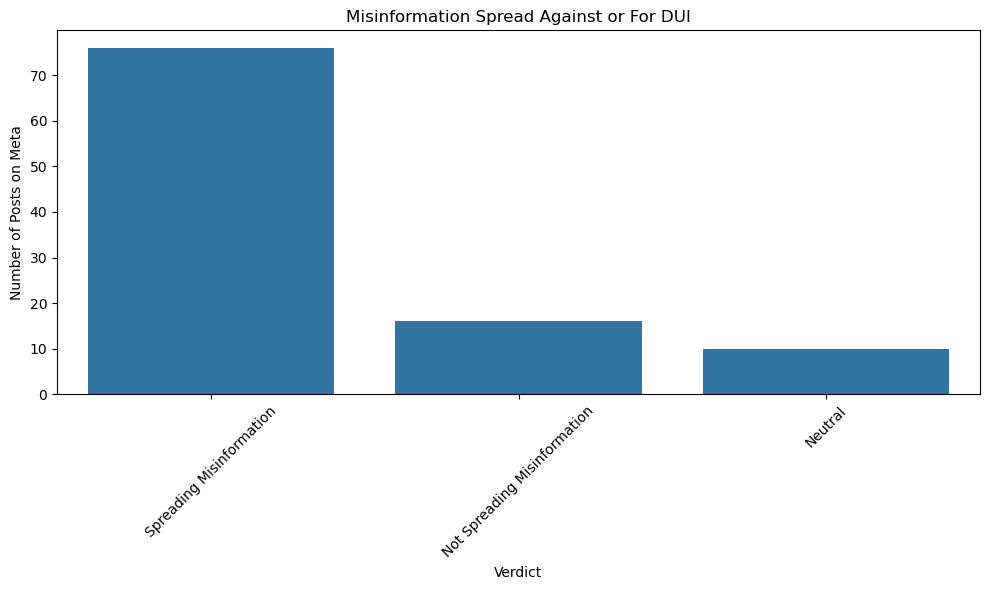

Shape of SDSM DataFrame: (45, 5)


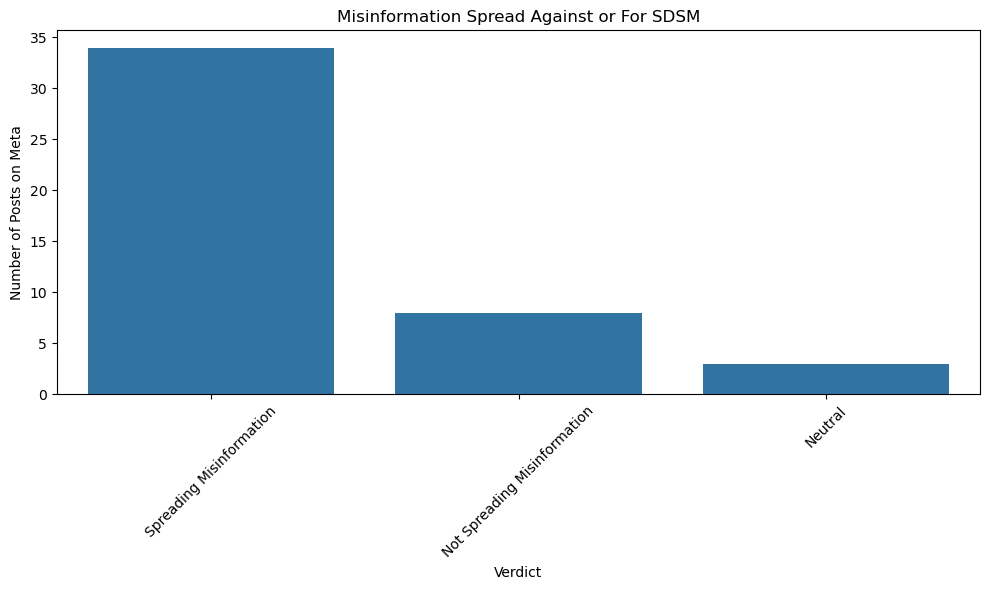

Shape of Left DataFrame: (60, 5)


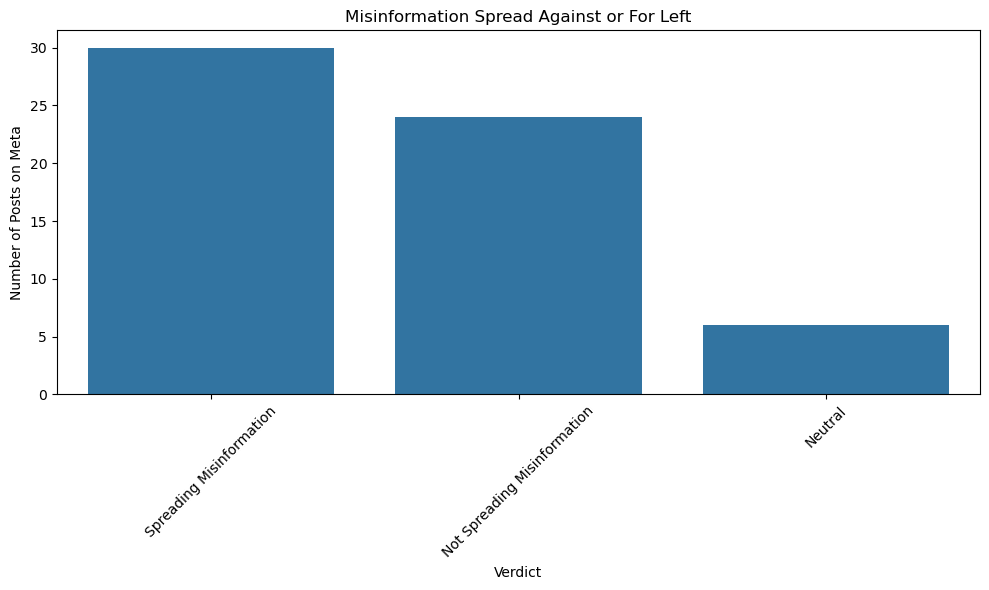

Shape of VMRO-DPMNE DataFrame: (16, 5)


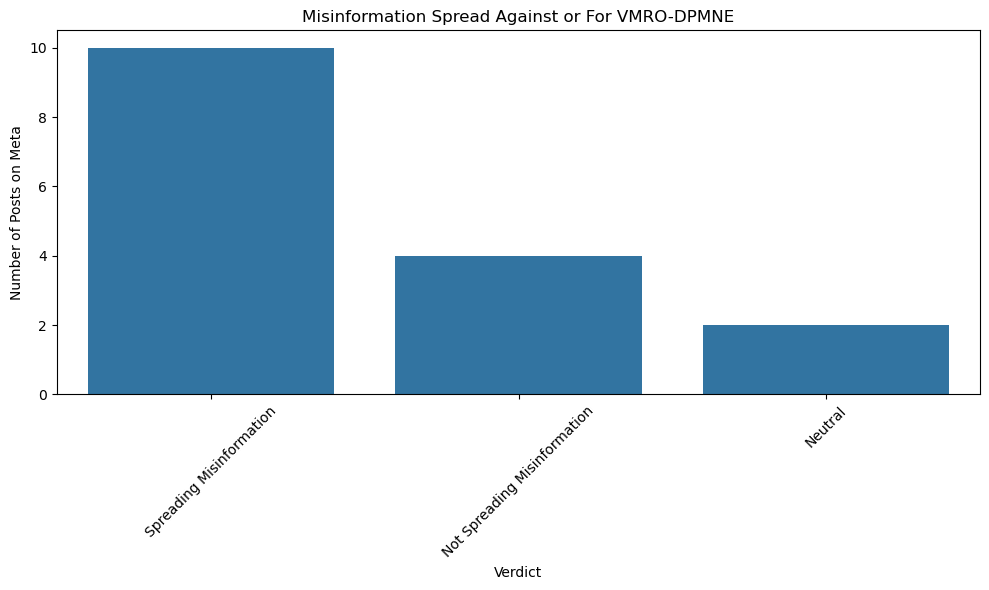

In [104]:
read_file_path = "./dataset/final-verdict/"
save_file_path = "./figures/"

# Visualization. Make me visualization of the data
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance_and_verdict.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Count the number of occurrences of each verdict
    verdict_counts = pandas_df['verdict'].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=verdict_counts.index, y=verdict_counts.values)
    plt.title(f"Misinformation Spread Against or For {party}")
    plt.xlabel("Verdict")
    plt.ylabel("Number of Posts on Meta")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to a file
    # plt.savefig(f"{party}_verdict_distribution.png")
    
    # Show the plot
    plt.savefig(os.path.join(save_file_path, party + "_verdict_distribution.png"))
    plt.show()


Shape of DUI DataFrame: (102, 5)


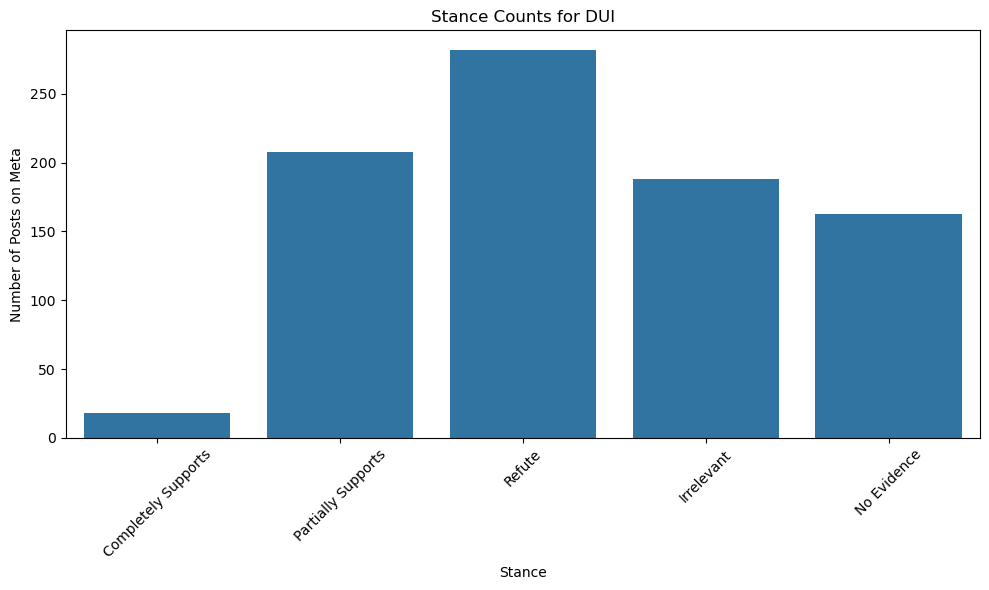

Shape of SDSM DataFrame: (45, 5)


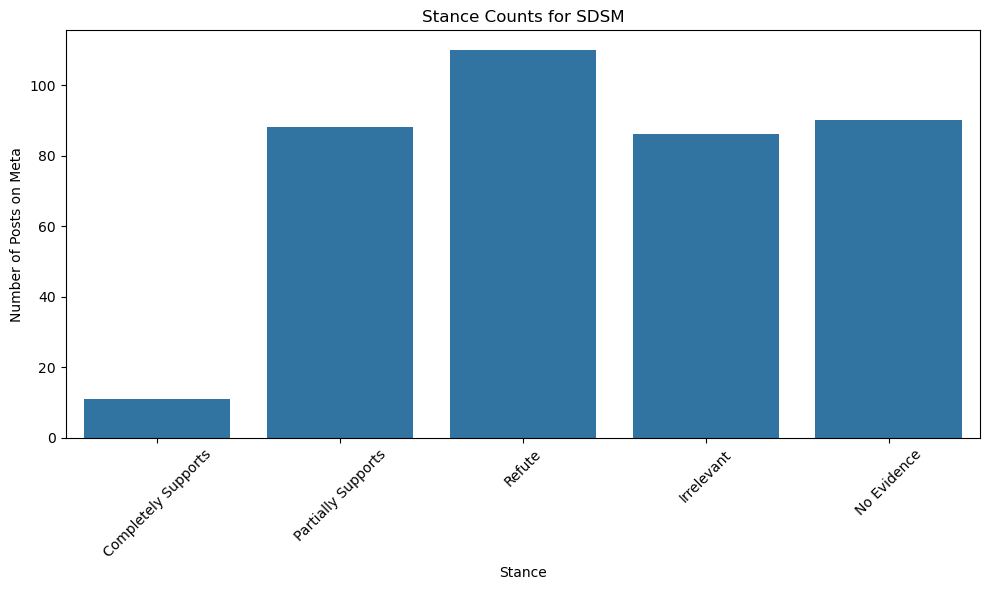

Shape of Left DataFrame: (60, 5)


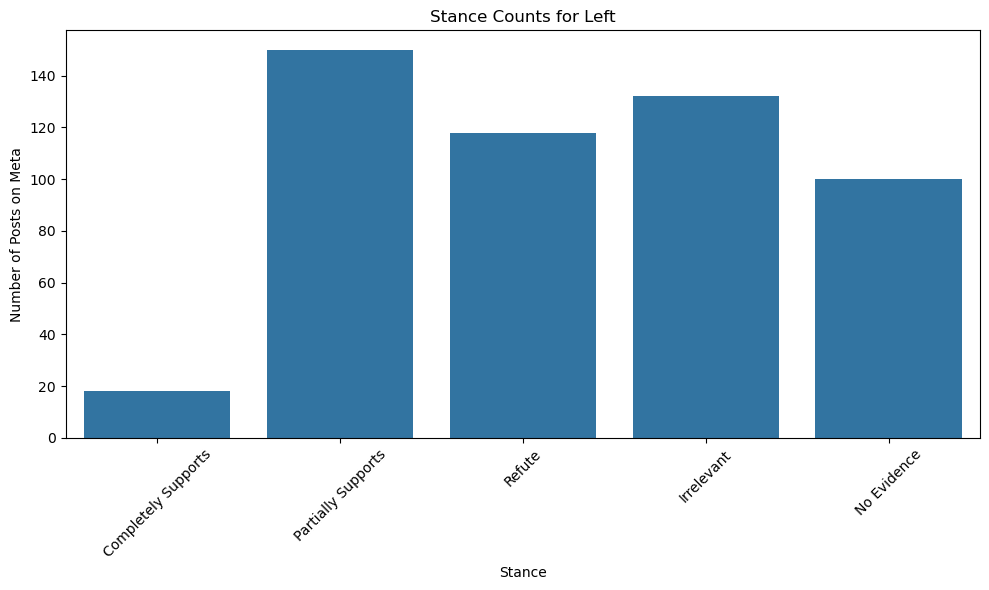

Shape of VMRO-DPMNE DataFrame: (16, 5)


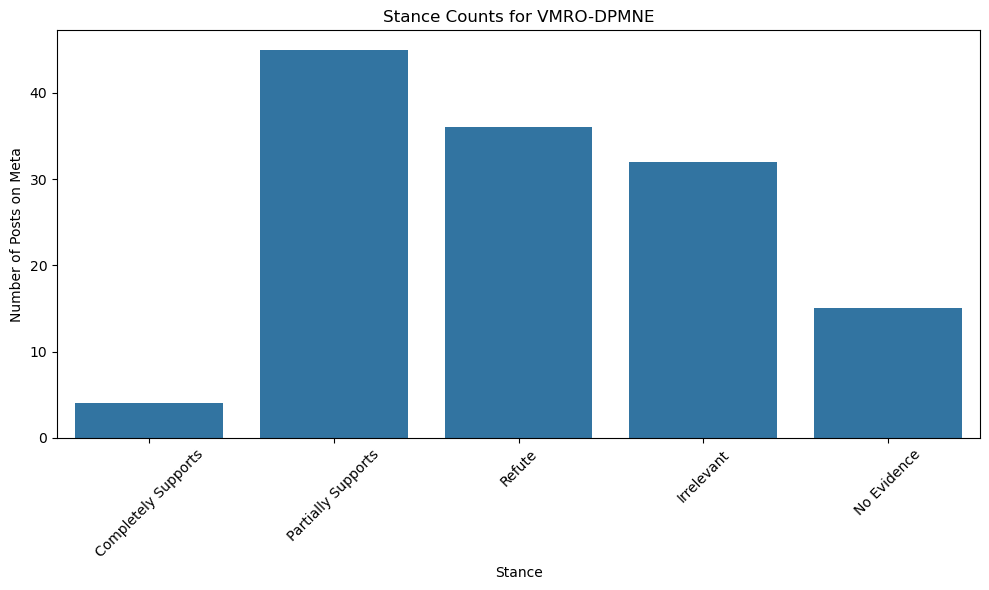

In [105]:
read_file_path = "./dataset/final-verdict/"
save_file_path = "./figures/"

# Make visualization for each party regarding the difference stances overall
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance_and_verdict.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Print the DataFrame shape
    print(f"Shape of {party} DataFrame:", pandas_df.shape)
    
    # Check if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Extract the stance counts from the JSON column
    pandas_df['stance_counts'] = pandas_df['stance_counts'].apply(json.loads)
    
    # Create a new DataFrame to hold the stance counts
    stance_counts_df = pd.DataFrame(pandas_df['stance_counts'].tolist())
    
    # Sum the stance counts across all rows
    total_stance_counts = stance_counts_df.sum()
    
    # Remove Unknown
    total_stance_counts = total_stance_counts.drop("Unknown")
    
    # Create a bar plot for the stance counts
    plt.figure(figsize=(10, 6))
    sns.barplot(x=total_stance_counts.index, y=total_stance_counts.values)
    plt.title(f"Stance Counts for {party}")
    plt.xlabel("Stance")
    plt.ylabel("Number of Posts on Meta")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_file_path, f"{party}_stance_counts.png"))
    plt.show()

<Figure size 1200x800 with 0 Axes>

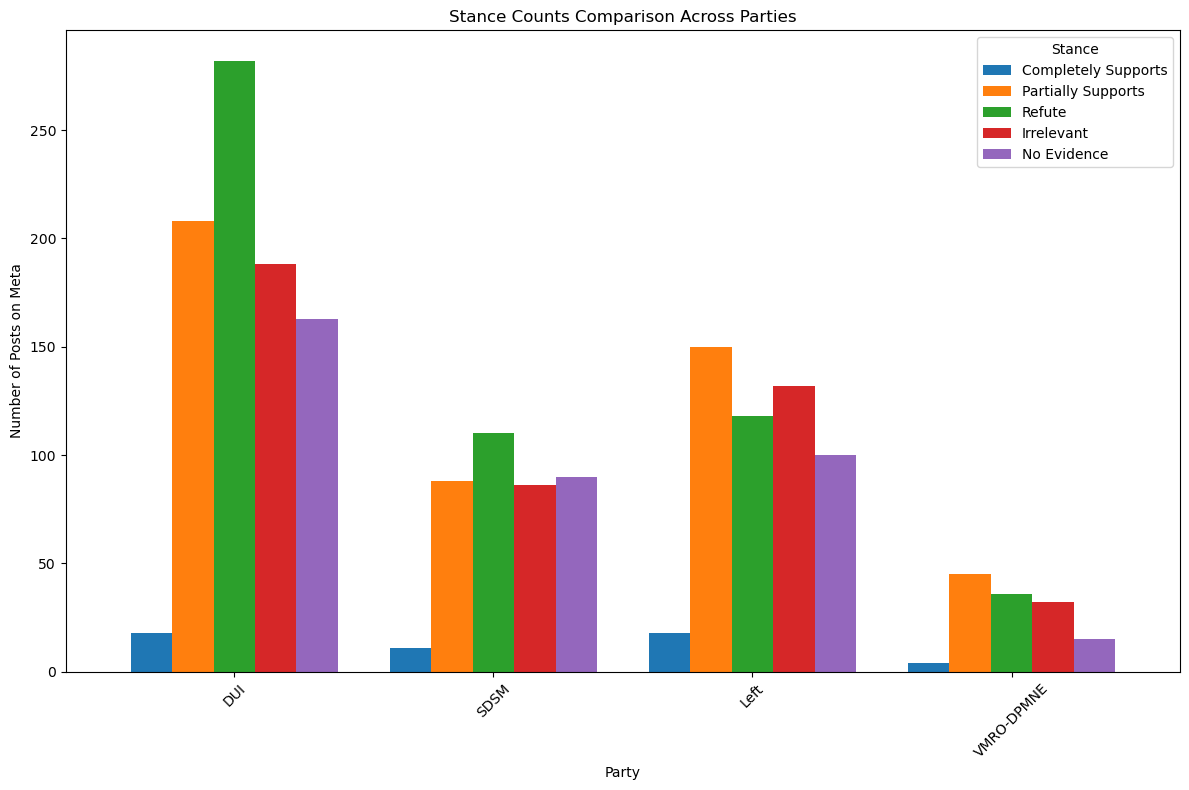

In [106]:
# Single Visualization
read_file_path = "./dataset/final-verdict/"
save_file_path = "./figures/"

# Initialize an empty DataFrame to store stance counts for all parties
all_parties_stance_counts = pd.DataFrame()

# Loop through each party and process their stance counts
for party in parties:
    # Read the CSV file into a DataFrame
    csv_file_path = os.path.join(read_file_path, party + "_claims_to_questions_to_proofs_with_stance_and_verdict.csv")
    pandas_df = pd.read_csv(csv_file_path)
    
    # Skip if the DataFrame is empty
    if pandas_df.empty:
        print(f"The DataFrame for {party} is empty.")
        continue
    
    # Extract the stance counts from the JSON column
    pandas_df['stance_counts'] = pandas_df['stance_counts'].apply(json.loads)
    
    # Create a new DataFrame to hold the stance counts
    stance_counts_df = pd.DataFrame(pandas_df['stance_counts'].tolist())
    
    # Sum the stance counts across all rows
    total_stance_counts = stance_counts_df.sum()
    
    # Remove Unknown
    if "Unknown" in total_stance_counts:
        total_stance_counts = total_stance_counts.drop("Unknown")
    
    # Add the party name to the stance counts
    total_stance_counts.name = party
    
    # Append to the combined DataFrame
    all_parties_stance_counts = pd.concat([all_parties_stance_counts, total_stance_counts], axis=1)

# Transpose the DataFrame for easier plotting
all_parties_stance_counts = all_parties_stance_counts.T

# Plot a grouped bar chart
plt.figure(figsize=(12, 8))
all_parties_stance_counts.plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Stance Counts Comparison Across Parties")
plt.xlabel("Party")
plt.ylabel("Number of Posts on Meta")
plt.xticks(rotation=45)
plt.legend(title="Stance")
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_file_path, "all_parties_stance_comparison.png"))
plt.show()